# Function Definitions

In [1]:
class LSTM:
    def __init__(self, input_size=340, output_size=101, n_h=100, seq_len=25, epochs=2, alpha=0.004, beta1=0.9,
                 beta2=0.999):
        self.input_size = input_size  # no. of unique characters in the training data
        self.output_size = output_size  # no. of RUL values in the dataset
        self.n_h = n_h  # no. of units in the hidden layer
        self.seq_len = seq_len  # no. of time steps, also size of mini batch
        self.epochs = epochs  # no. of training iterations
        self.alpha = alpha  # learning rate
        self.beta1 = beta1  # 1st momentum parameter
        self.beta2 = beta2  # 2nd momentum parameter

        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        # -----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d" + key] = np.zeros_like(self.params[key])
            self.adam_params["m" + key] = np.zeros_like(self.params[key])
            self.adam_params["v" + key] = np.zeros_like(self.params[key])

        self.smooth_loss = -np.log(1.0 / self.output_size) * self.seq_len

        return

    def init_random_params(self):
        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        return self.params

    # Firstly, we will compute the sigmoid activation used at the forget, input and output gate layers, and the softmax
    # activation used at the output layer. Tanh activation is also needed but numpy.tanh is used instead.

    def sigmoid(self, x):
        """
        Smoothes out values in the range of [0,1]
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Normalizes output into a probability distribution
        """
        e_x = np.exp(x - np.max(x))  # max(x) subtracted for numerical stability
        # e_x = np.exp(x) # Normal softmax activation function
        return e_x / np.sum(e_x, axis=0)

    # Although exploding gradients is not as prevalent for LSTMs as for RNNs, we will limit the gradients to a
    # conservative value using clip_grads. After back propagating through all LSTM cells, we will reset the
    # gradients using reset_grads.

    def clip_grads(self):
        """
        Limits the magnitude of gradients to avoid exploding gradients
        """
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return

    def reset_grads(self):
        """
        Resets gradients to zero before each backpropagation
        """
        for key in self.grads:
            self.grads[key].fill(0)
        return

    # The last utility function that we will create is for updating the weights using Adam. Note that the weights are
    # updated using the accumulated gradients for all time steps.

    def update_params(self, batch_num):
        """
        Updates parameters with Adam
        """
        for key in self.params:
            self.adam_params["m" + key] = self.adam_params["m" + key] * self.beta1 + \
                                          (1 - self.beta1) * self.grads["d" + key]
            self.adam_params["v" + key] = self.adam_params["v" + key] * self.beta2 + \
                                          (1 - self.beta2) * self.grads["d" + key] ** 2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1 ** batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2 ** batch_num)
            self.params[key] -= self.alpha * m_correlated / (np.sqrt(v_correlated) + 1e-8)
        return

    # Forward propagation for a time-step
    # We will propagate forwards through each LSTM cell using forward_step
    # A LSTM cell depends on the previous cell’s state (like Neural Networks). forward_step therefore takes as input
    # the previous hidden state (h_prev) and previous cell state (c_prev). At the beginning of every training iteration,
    # the previous hidden states are initialised to zero (i.e. at t = -1), but for subsequent time-steps, they
    # correspond to the hidden states at t-1, where t is the current time-step.

    def forward_step(self, x, h_prev, c_prev):
        """
        Implements the forward propagation for one time step
        """
        z = np.row_stack((h_prev, x))  # row_stack can also be used

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])  # [n_h, 1]
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])  # [n_h, 1]
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])  # [n_h, 1]

        c = f * c_prev + i * c_bar  # [n_h, 1]
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])  # [n_h, 1]
        h = o * np.tanh(c)  # [n_h, 1]

        v = np.dot(self.params["Wv"], h) + self.params["bv"]  # [output_size, n_h] @ [n_h, 1] + [
        # output_size, 1] = [output_size, 1]
        y_hat = self.softmax(v)  # [output_size, 1]
        # print("y_hat from softmax function in forward step", y_hat)

        return y_hat, v, h, o, c, c_bar, i, f, z

    # Backward propagation for a time-step
    # After forward propagation, we will pass the updated values of the last LSTM cell to backward_step and propagate
    # the gradients backwards to the first LSTM cell.
    # dh_next and dc_next are initialised to zero at t = -1, but take the values of dh_prev and dc_prev that
    # backward_step returns in subsequent time steps.
    # In addition, it is worth clarifying:

    # 1. As weights are shared by all time steps, the weight gradients are accumulated.
    # 2. We are adding dh_next to dh, because as Figure 1 shows, h is branched in forward propagation in the softmax
    # output layer and the next LSTM cell, where it is concatenated with x. Therefore, there are two gradients flowing
    # back. This applies to dc as well.
    # 3. There are four gradients flowing towards the input layer from the gates, therefore dz is the summation of
    # those gradients.

    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        dv = np.copy(y_hat)
        dv[y] -= 1  # dJ/dv = y_hat - y

        # print("-------------------------------------------------------------------------------------------------------")
        # print("y in back propagation:", y)
        # print("dv[y] from backward_step", dv)

        # Output bach propagation
        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        # Hidden state back propagation
        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o * (1 - o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        # Cell states back propagation
        dc = dh * o * (1 - np.tanh(c) ** 2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1 - c_bar ** 2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        # Input gate back propagation
        di = dc * c_bar
        da_i = di * i * (1 - i)
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        # Forget gate back propagation
        df = dc * c_prev
        da_f = df * f * (1 - f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        # Input back propagation
        dz = (np.dot(self.params["Wf"].T, da_f)\
             + np.dot(self.params["Wi"].T, da_i)\
             + np.dot(self.params["Wo"].T, da_o) \
             + np.dot(self.params["Wc"].T, da_c))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc

        return dh_prev, dc_prev

    # Forward and backward propagation for all time-steps
    # The forward and backward propagation steps will be executed within the forward_backward function. Here, we iterate
    # over all time steps and store the results for each time step in dictionaries. In the forward propagation loop,
    # we also accumulate the cross entropy loss.

    # forward_backward exports the cross entropy loss of the training batch, in addition to the hidden and cell states
    # of the last layer which are fed to the first LSTM cell as hprev and prev of the next training batch.

    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            loss += -np.log(y_hat[t][y_batch[t], 0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, dc_next, c[t - 1], z[t], f[t], i[t],
                                                  c_bar[t], c[t], o[t], h[t])

        return loss, h[self.seq_len - 1], c[self.seq_len - 1]


    def predict(self, x_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}
        y_hat_pred = np.zeros((self.seq_len, 1))


        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            y_hat_pred[t, :] = np.argmax(y_hat[t])

            loss += -np.log(y_hat_pred[t, :])

        return y_hat_pred, loss, h[self.seq_len - 1], c[self.seq_len - 1]

    # Gradient checking: To check the backpropagation calculation, we can numerically approximate the gradient at a
    # point and compare it to the model’s back propagation gradient.

    def gradient_check(self, x, y, h_prev, c_prev, num_checks=10, delta=1e-6):
        """
        Checks the magnitude of gradients against expected approximate values
        """
        print("**********************************")
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x, y, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params:
            print("---------", key, "---------")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0

            for _ in range(num_checks):  # sample 10 neurons

                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]

                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus - J_minus) / (2 * delta)
                grad_analytical += grads_numerical["d" + key].flat[idx]

            grad_numerical /= num_checks
            grad_analytical /= num_checks

            rel_error = abs(grad_analytical - grad_numerical) / abs(grad_analytical + grad_numerical)

            if rel_error > 1e-2:
                if not (grad_analytical < 1e-6 and grad_numerical < 1e-6):
                    test = False
                    assert (test)

            print('Approximate: \t%e, Exact: \t%e =>  Error: \t%e' % (grad_numerical, grad_analytical, rel_error))
        print("\nTest successful!")
        print("**********************************\n")
        return

    # we define the function to train the model. train takes as input a sequence of input image data and outputs a list
    # of losses for each training batch (J) as well as the trained parameters.
    # In order to speed up training, we will train our data in batches. The number of batches (num_batches) is given by
    # the total number of inputs data for each agent (len(X[i])) divided by the seq_len, which is user-defined.
    # The input text goes through the following processing steps:

    # 1. Firstly, we trim the input data that don’t form a full sequence
    # 2. When we iterate over each training batch, we slice the input data in batches of size seq_len
    # 3.

    def train(self, X, Y, params ,verbose=True):
        """
        Main method of the LSTM class where training takes place
        """
        self.params = params
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences
        Y_trimmed = Y[: num_batches * self.seq_len]  # trim output to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]
                y_batch = Y_trimmed[j: j + self.seq_len]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                # check gradients
            #    if epoch == 0 and j == 0:
            #        self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tLoss:',
                          np.round(self.smooth_loss, 2))

        return J, self.params

    def test_pred(self, X_test, params):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        h_prev = np.zeros((self.n_h, 1))
        c_prev = np.zeros((self.n_h, 1))

        for j in range(0, len(X_trimmed), self.seq_len):
            # prepare batches
            x_batch = X_trimmed[j: j + self.seq_len]

            y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

            Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

        return Y_hat_pred

    def test_loss(self, X_test, params, verbose=True):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        J_test = []  # to store losses
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))
            print('Epoch', epoch)
            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]

                y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J_test.append(self.smooth_loss)

                Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

                # print out train loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tTrain_Loss:',
                          np.round(self.smooth_loss, 2))

        return J_test


In [2]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    #Only sequences that meet the window-length are considered, no padding is used. This means for testing
    #we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    #we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [3]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [4]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)

In [5]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)

# Main

In [6]:

# input_size = 35 * 17 + 1 = 596 The input ton the LSTM, Z, has dimensions [input_size + n_h, 1]. Since the LSTM
# layer want to output n_h neurons, each weight should be of size [n_h, input_size + n_h] and each bias of size
# [n_h, 1]. Exception is the weight and bias at the output softmax layer (Wv, bv). The resulting output will be a
# probability distribution over all possible RUL in the dataset, therefore of size [output_size, 1], hence Wv should be
# of size [output_size, n_h] and bv of size [output_size, 1]
import numpy as np
import pickle
import os
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")


Failed on importing 'resource' package, continuing wihtout it!


# Read training data

In [7]:
# read training data
train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

### Remove the features which has low prognosability
### This part has been calculated by Matlab and the signals was selected

In [8]:
# remove the features which has low prognosability
# this part has been calculated by Matlab and the signals was selected
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  
0  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  
1  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  
2  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  
3  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  
4  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044

### Data Preprocessing
### Data Labeling - generate column RUL

In [9]:
# Data Preprocessing
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  RUL  
0  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  191  
1  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  190  
2  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  189  
3  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  188  
4  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044  187

### Generate label columns for training data

In [10]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()


id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9  ...     s12      s13      s14     s15  s17    s20      s21  RUL  \
0  9046.19  ...  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  191   
1  9044.07  ...  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  190   
2  9052.94  ...  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  189   
3  9049.48  ...  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  188   
4  9055.15  ...  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044  187   

   label1  label2  
0      -1      -1  
1      -1      -1  
2      -1      -1  
3      -1      -1  
4      -1      -1  

[5 rows x 21 columns]

### MinMax normalization. In the Predictive Maintenance Template , cycle column is also used for training so I will also include the cycle column. Here, I normalize the columns in the training data

In [11]:
# MinMax normalization
# In the Predictive Maintenance Template , cycle column is also used for training so we will also include the cycle
# column.
# Here, we normalize the columns in the training data.
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.459770  0.166667  0.183735  0.406802  0.309757  0.726248   
1   1      2  0.609195  0.250000  0.283133  0.453019  0.352633  0.628019   
2   1      3  0.252874  0.750000  0.343373  0.369523  0.370527  0.710145   
3   1      4  0.540230  0.500000  0.343373  0.256159  0.331195  0.740741   
4   1      5  0.390805  0.333333  0.349398  0.257467  0.404625  0.668277   

         s8        s9  ...       s13       s14       s15       s17       s20  \
0  0.242424  0.109755  ...  0.205882  0.199608  0.363986  0.333333  0.713178   
1  0.212121  0.100242  ...  0.279412  0.162813  0.411312  0.333333  0.666667   
2  0.272727  0.140043  ...  0.220588  0.171793  0.357445  0.166667  0.627907   
3  0.318182  0.124518  ...  0.294118  0.174889  0.166603  0.333333  0.573643   
4  0.242424  0.149960  ...  0.235294  0.174734  0.402078  0.416667  0.589147   

        s21  RUL  label1  label2  cycle_norm  
0  0.724662  191      -1      -1     0.00000  
1  0.731014  190      -1      -1     0.00277  
2  0.621375  189      -1      -1     0.00554  
3  0.662386  188      -1      -1     0.00831  
4  0.704502  187      -1      -1     0.01108  

[5 rows x 22 columns]

### Clip Response. This step is optional. In order for network to focus on the part of the data where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with higher RUL values as equal.

In [12]:
# Clip Response
# This step is optional. In order for network to focus on the part of the data where engines are more likely to fail
# (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with
# higher RUL values as equal.
clipResponse = True
if clipResponse:
    rulThreshold = 100
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()

train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape

(20631, 22)

# Read test data

In [13]:
# read test data
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21   
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42   
2   1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94  1401.34   
3   1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12  1406.42   
4   1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19  1401.92   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0   
1  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0   
2  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388  100.0   
3  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388  100.0   
4  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388  100.0   

     s20      s21  
0  38.86  23.3735  
1  39.02  23.3916  
2  39.08  23.4166  
3  39.00  23.3737  
4  38.99  23.4130  

[5 rows x 26 columns]

### Remove the features which has low prognosability like train_df dataset. this part has been calculated by Matlab and the signals was selected

In [14]:
# remove the features which has low prognosability like train_df dataset
# this part has been calculated by Matlab and the signals was selected
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1    0.0023    0.0003  643.02  1585.29  1398.21  553.90  2388.04   
1   1      2   -0.0027   -0.0003  641.71  1588.45  1395.42  554.85  2388.01   
2   1      3    0.0003    0.0001  642.46  1586.94  1401.34  554.11  2388.05   
3   1      4    0.0042    0.0000  642.44  1584.12  1406.42  554.07  2388.03   
4   1      5    0.0014    0.0000  642.51  1587.19  1401.92  554.16  2388.01   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  
0  9050.17  47.20  521.72  2388.03  8125.55  8.4052  392  38.86  23.3735  
1  9054.42  47.50  522.16  2388.06  8139.62  8.3803  393  39.02  23.3916  
2  9056.96  47.50  521.97  2388.03  8130.10  8.4441  393  39.08  23.4166  
3  9045.29  47.28  521.38  2388.05  8132.90  8.3917  391  39.00  23.3737  
4  9044.55  47.31  522.15  2388.03  8129.54  8.4031  390  38.99  23.4130

### Read ground truth data

In [15]:
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()

0
0  112
1   98
2   69
3   82
4   91

### Next, I prepare the test data. I first normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [16]:
# Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization
# applied on the training data.
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  
0  0.333333  0.558140  0.661834     0.00000  
1  0.416667  0.682171  0.686827     0.00277  
2  0.416667  0.728682  0.721348     0.00554  
3  0.250000  0.666667  0.662110     0.00831  
4  0.166667  0.658915  0.716377     0.01108

### Next, I use the ground truth dataset to generate labels for the test data.
### Generate column max for test data

In [17]:
# Next, we use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

### Generate RUL for test data

In [18]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  RUL  
0  0.333333  0.558140  0.661834     0.00000  142  
1  0.416667  0.682171  0.686827     0.00277  141  
2  0.416667  0.728682  0.721348     0.00554  140  
3  0.250000  0.666667  0.662110     0.00831  139  
4  0.166667  0.658915  0.716377     0.01108  138

### Clip Response on test dataset

In [19]:
# Clip Response on test dataset This step is optional. In order for network to focus on the part of the data
# where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150.
# This makes the network treat instances with higher RUL values as equal.
clipResponse_dataset = True
if clipResponse_dataset:
    rulThreshold = 100
    for i in range(len(test_df['RUL'])):
        test_df.loc[i, 'RUL'] = min(test_df.loc[i, 'RUL'], rulThreshold)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  RUL  
0  0.333333  0.558140  0.661834     0.00000  100  
1  0.416667  0.682171  0.686827     0.00277  100  
2  0.416667  0.728682  0.721348     0.00554  100  
3  0.250000  0.666667  0.662110     0.00831  100  
4  0.166667  0.658915  0.716377     0.01108  100

### Generate label columns w0 and w1 for test data

In [20]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape

(13096, 22)

In [21]:
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
            's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns = column_order)

### Sliding window over the input data

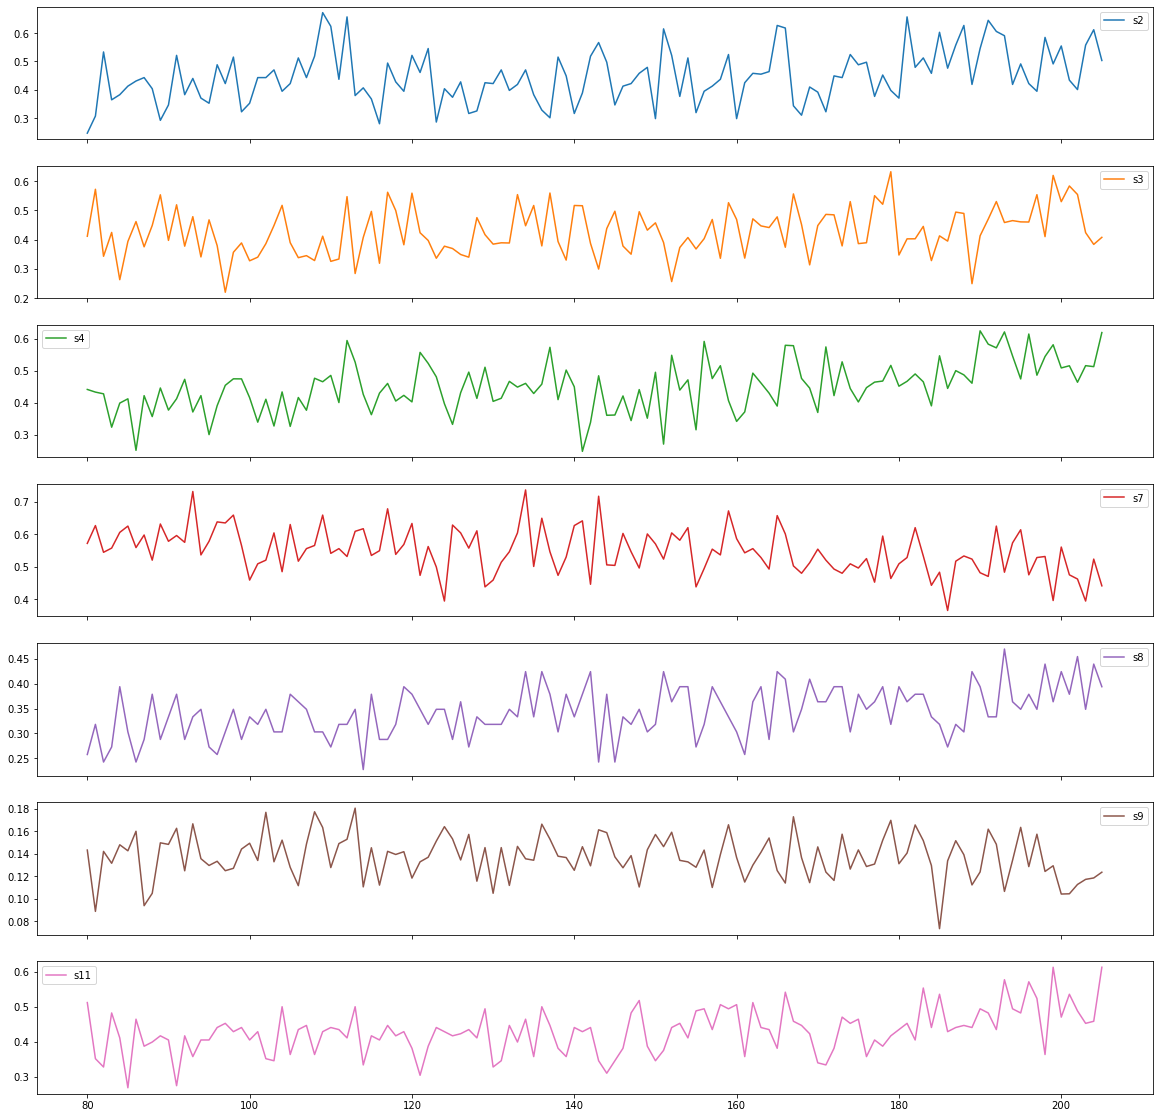

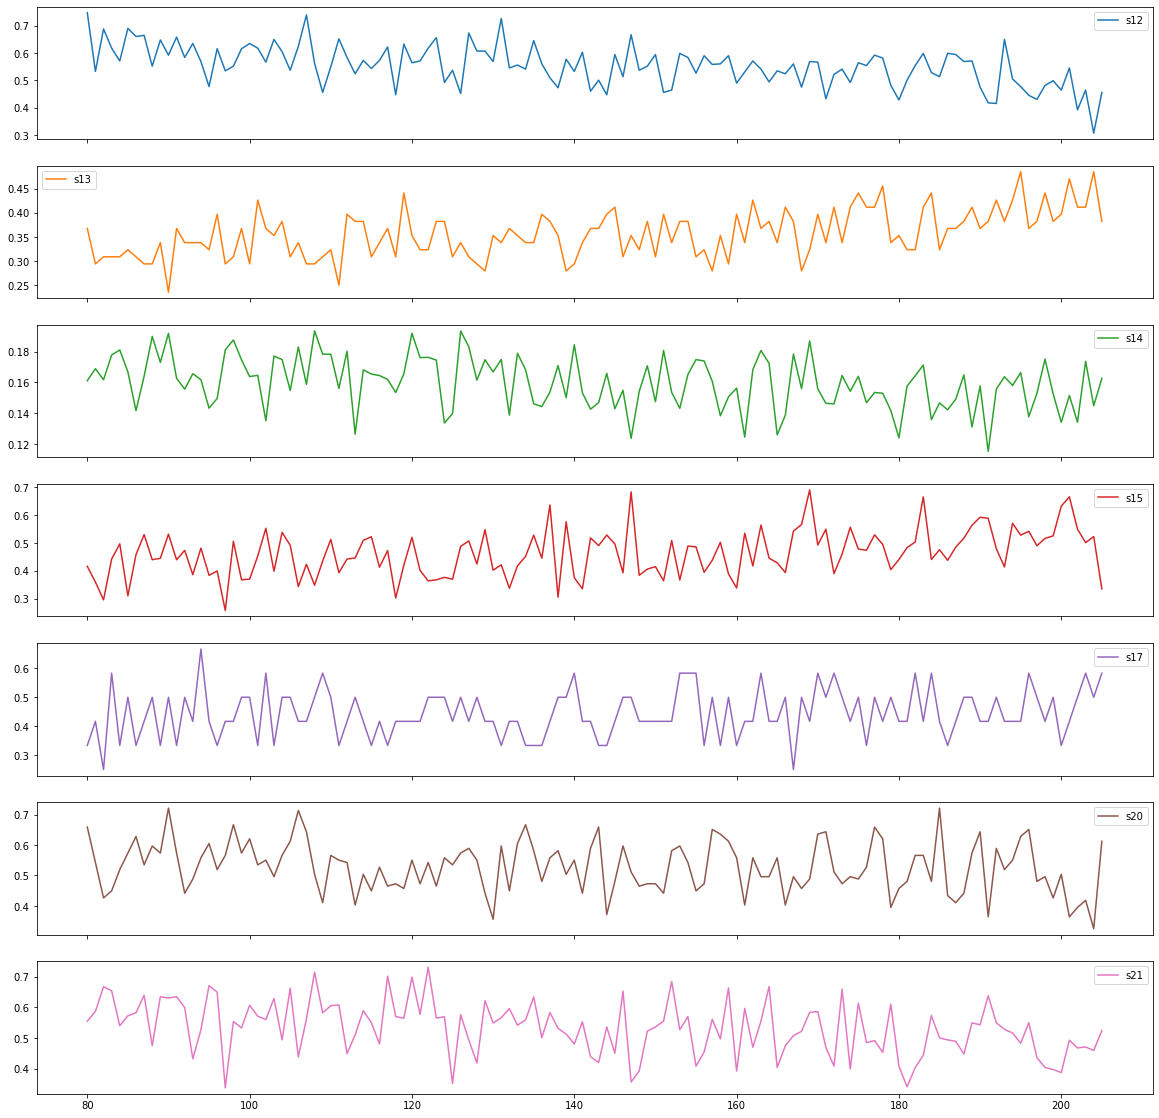

In [22]:
sequence_length = 35
sequence_length_ = 20  # length of sequence for each agent distraction
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

## Generate Train Data

In [23]:
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

### generator train data for the sequences for each agent and save in a list

In [24]:
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length_, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)

### generate train labels for each agent and save in a list

In [25]:
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)

### Generate train labels based on RUL for each agent and save in a list

In [26]:
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)

C:\Users\LO98E8~1\Temp\234/ipykernel_49572/1920039281.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)


In [27]:
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]

In [28]:
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]
    
print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

100
100
100
(108, 20, 17)
(108, 1)
(108, 1)


### generator test data for the sequences for each agent and save in a list

In [29]:
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length_, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)

### generate test labels for each agent and save in a list

In [30]:
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)

### Generate test labels based on RUL for each agent and save in a list

In [31]:
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)

C:\Users\LO98E8~1\Temp\234/ipykernel_49572/500274830.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)


### Select part of the train set which has the length longer than min_length

In [32]:
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]

###  change the key of dictionary and indexing it based on increasing number from 1

In [33]:
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X = {}
Y = {}
for i in data_array_.keys():
    X[i - 1] = data_array_[i].reshape(min_length, -1)
    Y[i - 1] = label_array_rul_[i]

X_test = {}
Y_test = {}
for i in seq_array_test_.keys():
    X_test[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test[i - 1] = label_array_test_rul_[i]

56
56
56
(108, 20, 17)
(108, 1)
(108, 1)


## The main distributed LSTM model for 10 worker, in case of master and workers

In [34]:
num_workers = 10
array_params = [dict() for i in range(num_workers)]
J = [list() for i in range(num_workers)]

worker_model = {}
for worker_i in range(num_workers):
    worker_model[worker_i] = LSTM()
    array_params[worker_i] = worker_model[worker_i].init_random_params()

iteration_epoch = 3000
for i in range(iteration_epoch):
    print("Number of iteration:", i, "/from", iteration_epoch)
    for worker_i in range(num_workers):
        cost, array_params[worker_i] = worker_model[worker_i].train(X[worker_i], Y[worker_i],
                                                                    array_params[worker_i])
        J[worker_i].append(cost)

    for key in array_params[0]:  # Fed average
        tmp = array_params[0][key]
        for worker_i in range(1, num_workers):
            tmp = tmp + array_params[worker_i][key]
        for worker_i in range(num_workers):
            array_params[worker_i][key] = (1 / num_workers) * tmp  # Distribute aggregate parameters to all workers

Number of iteration: 0 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.4]
Number of iteration: 1 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.39]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 

Epoch 1 	Batch: 50 - 75 	Loss: [115.02]
Epoch 0 	Batch: 50 - 75 	Loss: [115.04]
Epoch 1 	Batch: 50 - 75 	Loss: [115.]
Number of iteration: 10 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [114.98]
Epoch 1 	Batch: 50 - 75 	Loss: [114.94]
Epoch 0 	Batch: 50 - 75 	Loss: [114.96]
Epoch 1 	Batch: 50 - 75 	Loss: [114.91]
Epoch 0 	Batch: 50 - 75 	Loss: [114.99]
Epoch 1 	Batch: 50 - 75 	Loss: [114.94]
Epoch 0 	Batch: 50 - 75 	Loss: [115.]
Epoch 1 	Batch: 50 - 75 	Loss: [114.96]
Epoch 0 	Batch: 50 - 75 	Loss: [114.96]
Epoch 1 	Batch: 50 - 75 	Loss: [114.91]
Epoch 0 	Batch: 50 - 75 	Loss: [115.06]
Epoch 1 	Batch: 50 - 75 	Loss: [115.02]
Epoch 0 	Batch: 50 - 75 	Loss: [114.97]
Epoch 1 	Batch: 50 - 75 	Loss: [114.93]
Epoch 0 	Batch: 50 - 75 	Loss: [115.04]
Epoch 1 	Batch: 50 - 75 	Loss: [115.]
Epoch 0 	Batch: 50 - 75 	Loss: [114.98]
Epoch 1 	Batch: 50 - 75 	Loss: [114.94]
Epoch 0 	Batch: 50 - 75 	Loss: [114.95]
Epoch 1 	Batch: 50 - 75 	Loss: [114.9]
Number of iteration: 11 /from 3000
Epoch 0 	Batch: 5

Epoch 1 	Batch: 50 - 75 	Loss: [113.99]
Epoch 0 	Batch: 50 - 75 	Loss: [114.03]
Epoch 1 	Batch: 50 - 75 	Loss: [113.96]
Epoch 0 	Batch: 50 - 75 	Loss: [113.7]
Epoch 1 	Batch: 50 - 75 	Loss: [113.62]
Number of iteration: 20 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [113.72]
Epoch 1 	Batch: 50 - 75 	Loss: [113.65]
Epoch 0 	Batch: 50 - 75 	Loss: [113.7]
Epoch 1 	Batch: 50 - 75 	Loss: [113.62]
Epoch 0 	Batch: 50 - 75 	Loss: [113.87]
Epoch 1 	Batch: 50 - 75 	Loss: [113.79]
Epoch 0 	Batch: 50 - 75 	Loss: [113.74]
Epoch 1 	Batch: 50 - 75 	Loss: [113.66]
Epoch 0 	Batch: 50 - 75 	Loss: [113.63]
Epoch 1 	Batch: 50 - 75 	Loss: [113.55]
Epoch 0 	Batch: 50 - 75 	Loss: [114.17]
Epoch 1 	Batch: 50 - 75 	Loss: [114.11]
Epoch 0 	Batch: 50 - 75 	Loss: [113.79]
Epoch 1 	Batch: 50 - 75 	Loss: [113.71]
Epoch 0 	Batch: 50 - 75 	Loss: [113.93]
Epoch 1 	Batch: 50 - 75 	Loss: [113.85]
Epoch 0 	Batch: 50 - 75 	Loss: [113.9]
Epoch 1 	Batch: 50 - 75 	Loss: [113.83]
Epoch 0 	Batch: 50 - 75 	Loss: [113.54]
Epoch 1 

Epoch 1 	Batch: 50 - 75 	Loss: [112.24]
Epoch 0 	Batch: 50 - 75 	Loss: [112.52]
Epoch 1 	Batch: 50 - 75 	Loss: [112.43]
Epoch 0 	Batch: 50 - 75 	Loss: [112.49]
Epoch 1 	Batch: 50 - 75 	Loss: [112.4]
Epoch 0 	Batch: 50 - 75 	Loss: [111.9]
Epoch 1 	Batch: 50 - 75 	Loss: [111.8]
Number of iteration: 30 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [111.91]
Epoch 1 	Batch: 50 - 75 	Loss: [111.81]
Epoch 0 	Batch: 50 - 75 	Loss: [112.01]
Epoch 1 	Batch: 50 - 75 	Loss: [111.9]
Epoch 0 	Batch: 50 - 75 	Loss: [112.24]
Epoch 1 	Batch: 50 - 75 	Loss: [112.14]
Epoch 0 	Batch: 50 - 75 	Loss: [112.]
Epoch 1 	Batch: 50 - 75 	Loss: [111.91]
Epoch 0 	Batch: 50 - 75 	Loss: [111.88]
Epoch 1 	Batch: 50 - 75 	Loss: [111.77]
Epoch 0 	Batch: 50 - 75 	Loss: [112.92]
Epoch 1 	Batch: 50 - 75 	Loss: [112.83]
Epoch 0 	Batch: 50 - 75 	Loss: [112.16]
Epoch 1 	Batch: 50 - 75 	Loss: [112.05]
Epoch 0 	Batch: 50 - 75 	Loss: [112.34]
Epoch 1 	Batch: 50 - 75 	Loss: [112.23]
Epoch 0 	Batch: 50 - 75 	Loss: [112.33]
Epoch 1 	Ba

Epoch 1 	Batch: 50 - 75 	Loss: [111.28]
Epoch 0 	Batch: 50 - 75 	Loss: [110.37]
Epoch 1 	Batch: 50 - 75 	Loss: [110.26]
Epoch 0 	Batch: 50 - 75 	Loss: [110.52]
Epoch 1 	Batch: 50 - 75 	Loss: [110.42]
Epoch 0 	Batch: 50 - 75 	Loss: [110.71]
Epoch 1 	Batch: 50 - 75 	Loss: [110.6]
Epoch 0 	Batch: 50 - 75 	Loss: [109.75]
Epoch 1 	Batch: 50 - 75 	Loss: [109.64]
Number of iteration: 40 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [109.76]
Epoch 1 	Batch: 50 - 75 	Loss: [109.65]
Epoch 0 	Batch: 50 - 75 	Loss: [109.96]
Epoch 1 	Batch: 50 - 75 	Loss: [109.85]
Epoch 0 	Batch: 50 - 75 	Loss: [110.34]
Epoch 1 	Batch: 50 - 75 	Loss: [110.23]
Epoch 0 	Batch: 50 - 75 	Loss: [109.89]
Epoch 1 	Batch: 50 - 75 	Loss: [109.78]
Epoch 0 	Batch: 50 - 75 	Loss: [109.8]
Epoch 1 	Batch: 50 - 75 	Loss: [109.7]
Epoch 0 	Batch: 50 - 75 	Loss: [111.2]
Epoch 1 	Batch: 50 - 75 	Loss: [111.1]
Epoch 0 	Batch: 50 - 75 	Loss: [110.17]
Epoch 1 	Batch: 50 - 75 	Loss: [110.06]
Epoch 0 	Batch: 50 - 75 	Loss: [110.31]
Epoch 1 	B

Epoch 1 	Batch: 50 - 75 	Loss: [107.72]
Epoch 0 	Batch: 50 - 75 	Loss: [109.47]
Epoch 1 	Batch: 50 - 75 	Loss: [109.36]
Epoch 0 	Batch: 50 - 75 	Loss: [108.27]
Epoch 1 	Batch: 50 - 75 	Loss: [108.15]
Epoch 0 	Batch: 50 - 75 	Loss: [108.43]
Epoch 1 	Batch: 50 - 75 	Loss: [108.32]
Epoch 0 	Batch: 50 - 75 	Loss: [108.85]
Epoch 1 	Batch: 50 - 75 	Loss: [108.76]
Epoch 0 	Batch: 50 - 75 	Loss: [107.51]
Epoch 1 	Batch: 50 - 75 	Loss: [107.39]
Number of iteration: 50 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [107.5]
Epoch 1 	Batch: 50 - 75 	Loss: [107.39]
Epoch 0 	Batch: 50 - 75 	Loss: [107.77]
Epoch 1 	Batch: 50 - 75 	Loss: [107.66]
Epoch 0 	Batch: 50 - 75 	Loss: [108.4]
Epoch 1 	Batch: 50 - 75 	Loss: [108.29]
Epoch 0 	Batch: 50 - 75 	Loss: [107.64]
Epoch 1 	Batch: 50 - 75 	Loss: [107.52]
Epoch 0 	Batch: 50 - 75 	Loss: [107.6]
Epoch 1 	Batch: 50 - 75 	Loss: [107.49]
Epoch 0 	Batch: 50 - 75 	Loss: [109.27]
Epoch 1 	Batch: 50 - 75 	Loss: [109.16]
Epoch 0 	Batch: 50 - 75 	Loss: [108.05]
Epoch 1 

Epoch 1 	Batch: 50 - 75 	Loss: [105.45]
Epoch 0 	Batch: 50 - 75 	Loss: [105.61]
Epoch 1 	Batch: 50 - 75 	Loss: [105.5]
Epoch 0 	Batch: 50 - 75 	Loss: [107.44]
Epoch 1 	Batch: 50 - 75 	Loss: [107.32]
Epoch 0 	Batch: 50 - 75 	Loss: [106.19]
Epoch 1 	Batch: 50 - 75 	Loss: [106.07]
Epoch 0 	Batch: 50 - 75 	Loss: [106.21]
Epoch 1 	Batch: 50 - 75 	Loss: [106.08]
Epoch 0 	Batch: 50 - 75 	Loss: [107.01]
Epoch 1 	Batch: 50 - 75 	Loss: [106.9]
Epoch 0 	Batch: 50 - 75 	Loss: [105.16]
Epoch 1 	Batch: 50 - 75 	Loss: [105.04]
Number of iteration: 60 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [105.21]
Epoch 1 	Batch: 50 - 75 	Loss: [105.1]
Epoch 0 	Batch: 50 - 75 	Loss: [105.55]
Epoch 1 	Batch: 50 - 75 	Loss: [105.44]
Epoch 0 	Batch: 50 - 75 	Loss: [106.45]
Epoch 1 	Batch: 50 - 75 	Loss: [106.33]
Epoch 0 	Batch: 50 - 75 	Loss: [105.32]
Epoch 1 	Batch: 50 - 75 	Loss: [105.2]
Epoch 0 	Batch: 50 - 75 	Loss: [105.38]
Epoch 1 	Batch: 50 - 75 	Loss: [105.27]
Epoch 0 	Batch: 50 - 75 	Loss: [107.24]
Epoch 1 	

Epoch 1 	Batch: 50 - 75 	Loss: [104.52]
Epoch 0 	Batch: 50 - 75 	Loss: [103.19]
Epoch 1 	Batch: 50 - 75 	Loss: [103.07]
Epoch 0 	Batch: 50 - 75 	Loss: [103.31]
Epoch 1 	Batch: 50 - 75 	Loss: [103.19]
Epoch 0 	Batch: 50 - 75 	Loss: [105.4]
Epoch 1 	Batch: 50 - 75 	Loss: [105.28]
Epoch 0 	Batch: 50 - 75 	Loss: [104.01]
Epoch 1 	Batch: 50 - 75 	Loss: [103.9]
Epoch 0 	Batch: 50 - 75 	Loss: [103.88]
Epoch 1 	Batch: 50 - 75 	Loss: [103.76]
Epoch 0 	Batch: 50 - 75 	Loss: [105.12]
Epoch 1 	Batch: 50 - 75 	Loss: [105.02]
Epoch 0 	Batch: 50 - 75 	Loss: [102.76]
Epoch 1 	Batch: 50 - 75 	Loss: [102.63]
Number of iteration: 70 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [102.81]
Epoch 1 	Batch: 50 - 75 	Loss: [102.69]
Epoch 0 	Batch: 50 - 75 	Loss: [103.33]
Epoch 1 	Batch: 50 - 75 	Loss: [103.22]
Epoch 0 	Batch: 50 - 75 	Loss: [104.42]
Epoch 1 	Batch: 50 - 75 	Loss: [104.3]
Epoch 0 	Batch: 50 - 75 	Loss: [102.95]
Epoch 1 	Batch: 50 - 75 	Loss: [102.83]
Epoch 0 	Batch: 50 - 75 	Loss: [103.08]
Epoch 1 

Epoch 1 	Batch: 50 - 75 	Loss: [101.24]
Epoch 0 	Batch: 50 - 75 	Loss: [102.54]
Epoch 1 	Batch: 50 - 75 	Loss: [102.42]
Epoch 0 	Batch: 50 - 75 	Loss: [100.9]
Epoch 1 	Batch: 50 - 75 	Loss: [100.8]
Epoch 0 	Batch: 50 - 75 	Loss: [101.04]
Epoch 1 	Batch: 50 - 75 	Loss: [100.92]
Epoch 0 	Batch: 50 - 75 	Loss: [103.35]
Epoch 1 	Batch: 50 - 75 	Loss: [103.23]
Epoch 0 	Batch: 50 - 75 	Loss: [101.85]
Epoch 1 	Batch: 50 - 75 	Loss: [101.74]
Epoch 0 	Batch: 50 - 75 	Loss: [101.56]
Epoch 1 	Batch: 50 - 75 	Loss: [101.44]
Epoch 0 	Batch: 50 - 75 	Loss: [103.23]
Epoch 1 	Batch: 50 - 75 	Loss: [103.11]
Epoch 0 	Batch: 50 - 75 	Loss: [100.32]
Epoch 1 	Batch: 50 - 75 	Loss: [100.2]
Number of iteration: 80 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [100.38]
Epoch 1 	Batch: 50 - 75 	Loss: [100.26]
Epoch 0 	Batch: 50 - 75 	Loss: [101.13]
Epoch 1 	Batch: 50 - 75 	Loss: [101.01]
Epoch 0 	Batch: 50 - 75 	Loss: [102.33]
Epoch 1 	Batch: 50 - 75 	Loss: [102.21]
Epoch 0 	Batch: 50 - 75 	Loss: [100.67]
Epoch 1 

Epoch 1 	Batch: 50 - 75 	Loss: [99.05]
Epoch 0 	Batch: 50 - 75 	Loss: [100.49]
Epoch 1 	Batch: 50 - 75 	Loss: [100.39]
Epoch 0 	Batch: 50 - 75 	Loss: [98.64]
Epoch 1 	Batch: 50 - 75 	Loss: [98.54]
Epoch 0 	Batch: 50 - 75 	Loss: [98.82]
Epoch 1 	Batch: 50 - 75 	Loss: [98.71]
Epoch 0 	Batch: 50 - 75 	Loss: [101.32]
Epoch 1 	Batch: 50 - 75 	Loss: [101.21]
Epoch 0 	Batch: 50 - 75 	Loss: [99.72]
Epoch 1 	Batch: 50 - 75 	Loss: [99.61]
Epoch 0 	Batch: 50 - 75 	Loss: [99.27]
Epoch 1 	Batch: 50 - 75 	Loss: [99.15]
Epoch 0 	Batch: 50 - 75 	Loss: [101.38]
Epoch 1 	Batch: 50 - 75 	Loss: [101.28]
Epoch 0 	Batch: 50 - 75 	Loss: [97.94]
Epoch 1 	Batch: 50 - 75 	Loss: [97.82]
Number of iteration: 90 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [98.]
Epoch 1 	Batch: 50 - 75 	Loss: [97.88]
Epoch 0 	Batch: 50 - 75 	Loss: [98.94]
Epoch 1 	Batch: 50 - 75 	Loss: [98.83]
Epoch 0 	Batch: 50 - 75 	Loss: [100.29]
Epoch 1 	Batch: 50 - 75 	Loss: [100.17]
Epoch 0 	Batch: 50 - 75 	Loss: [98.42]
Epoch 1 	Batch: 50 - 75

Epoch 1 	Batch: 50 - 75 	Loss: [98.32]
Epoch 0 	Batch: 50 - 75 	Loss: [96.4]
Epoch 1 	Batch: 50 - 75 	Loss: [96.28]
Epoch 0 	Batch: 50 - 75 	Loss: [96.69]
Epoch 1 	Batch: 50 - 75 	Loss: [96.59]
Epoch 0 	Batch: 50 - 75 	Loss: [99.38]
Epoch 1 	Batch: 50 - 75 	Loss: [99.26]
Epoch 0 	Batch: 50 - 75 	Loss: [97.64]
Epoch 1 	Batch: 50 - 75 	Loss: [97.53]
Epoch 0 	Batch: 50 - 75 	Loss: [97.02]
Epoch 1 	Batch: 50 - 75 	Loss: [96.91]
Epoch 0 	Batch: 50 - 75 	Loss: [99.57]
Epoch 1 	Batch: 50 - 75 	Loss: [99.47]
Epoch 0 	Batch: 50 - 75 	Loss: [95.54]
Epoch 1 	Batch: 50 - 75 	Loss: [95.42]
Number of iteration: 100 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [95.67]
Epoch 1 	Batch: 50 - 75 	Loss: [95.55]
Epoch 0 	Batch: 50 - 75 	Loss: [96.82]
Epoch 1 	Batch: 50 - 75 	Loss: [96.71]
Epoch 0 	Batch: 50 - 75 	Loss: [98.22]
Epoch 1 	Batch: 50 - 75 	Loss: [98.11]
Epoch 0 	Batch: 50 - 75 	Loss: [96.17]
Epoch 1 	Batch: 50 - 75 	Loss: [96.06]
Epoch 0 	Batch: 50 - 75 	Loss: [96.48]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [94.1]
Epoch 0 	Batch: 50 - 75 	Loss: [94.72]
Epoch 1 	Batch: 50 - 75 	Loss: [94.62]
Epoch 0 	Batch: 50 - 75 	Loss: [97.46]
Epoch 1 	Batch: 50 - 75 	Loss: [97.34]
Epoch 0 	Batch: 50 - 75 	Loss: [95.62]
Epoch 1 	Batch: 50 - 75 	Loss: [95.51]
Epoch 0 	Batch: 50 - 75 	Loss: [94.83]
Epoch 1 	Batch: 50 - 75 	Loss: [94.73]
Epoch 0 	Batch: 50 - 75 	Loss: [97.81]
Epoch 1 	Batch: 50 - 75 	Loss: [97.72]
Epoch 0 	Batch: 50 - 75 	Loss: [93.21]
Epoch 1 	Batch: 50 - 75 	Loss: [93.09]
Number of iteration: 110 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [93.38]
Epoch 1 	Batch: 50 - 75 	Loss: [93.27]
Epoch 0 	Batch: 50 - 75 	Loss: [94.79]
Epoch 1 	Batch: 50 - 75 	Loss: [94.68]
Epoch 0 	Batch: 50 - 75 	Loss: [96.24]
Epoch 1 	Batch: 50 - 75 	Loss: [96.14]
Epoch 0 	Batch: 50 - 75 	Loss: [93.98]
Epoch 1 	Batch: 50 - 75 	Loss: [93.88]
Epoch 0 	Batch: 50 - 75 	Loss: [94.52]
Epoch 1 	Batch: 50 - 75 	Loss: [94.42]
Epoch 0 	Batch: 50 - 75 	Loss: [97.29]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [92.56]
Epoch 0 	Batch: 50 - 75 	Loss: [95.73]
Epoch 1 	Batch: 50 - 75 	Loss: [95.63]
Epoch 0 	Batch: 50 - 75 	Loss: [93.66]
Epoch 1 	Batch: 50 - 75 	Loss: [93.56]
Epoch 0 	Batch: 50 - 75 	Loss: [92.72]
Epoch 1 	Batch: 50 - 75 	Loss: [92.61]
Epoch 0 	Batch: 50 - 75 	Loss: [96.11]
Epoch 1 	Batch: 50 - 75 	Loss: [96.01]
Epoch 0 	Batch: 50 - 75 	Loss: [90.95]
Epoch 1 	Batch: 50 - 75 	Loss: [90.85]
Number of iteration: 120 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [91.21]
Epoch 1 	Batch: 50 - 75 	Loss: [91.1]
Epoch 0 	Batch: 50 - 75 	Loss: [92.82]
Epoch 1 	Batch: 50 - 75 	Loss: [92.71]
Epoch 0 	Batch: 50 - 75 	Loss: [94.34]
Epoch 1 	Batch: 50 - 75 	Loss: [94.24]
Epoch 0 	Batch: 50 - 75 	Loss: [91.85]
Epoch 1 	Batch: 50 - 75 	Loss: [91.76]
Epoch 0 	Batch: 50 - 75 	Loss: [92.46]
Epoch 1 	Batch: 50 - 75 	Loss: [92.35]
Epoch 0 	Batch: 50 - 75 	Loss: [95.56]
Epoch 1 	Batch: 50 - 75 	Loss: [95.46]
Epoch 0 	Batch: 50 - 75 	Loss: [93.47]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [93.96]
Epoch 0 	Batch: 50 - 75 	Loss: [91.78]
Epoch 1 	Batch: 50 - 75 	Loss: [91.68]
Epoch 0 	Batch: 50 - 75 	Loss: [90.55]
Epoch 1 	Batch: 50 - 75 	Loss: [90.44]
Epoch 0 	Batch: 50 - 75 	Loss: [94.44]
Epoch 1 	Batch: 50 - 75 	Loss: [94.35]
Epoch 0 	Batch: 50 - 75 	Loss: [88.77]
Epoch 1 	Batch: 50 - 75 	Loss: [88.65]
Number of iteration: 130 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [89.12]
Epoch 1 	Batch: 50 - 75 	Loss: [89.01]
Epoch 0 	Batch: 50 - 75 	Loss: [90.9]
Epoch 1 	Batch: 50 - 75 	Loss: [90.81]
Epoch 0 	Batch: 50 - 75 	Loss: [92.5]
Epoch 1 	Batch: 50 - 75 	Loss: [92.41]
Epoch 0 	Batch: 50 - 75 	Loss: [89.74]
Epoch 1 	Batch: 50 - 75 	Loss: [89.64]
Epoch 0 	Batch: 50 - 75 	Loss: [90.46]
Epoch 1 	Batch: 50 - 75 	Loss: [90.37]
Epoch 0 	Batch: 50 - 75 	Loss: [93.91]
Epoch 1 	Batch: 50 - 75 	Loss: [93.81]
Epoch 0 	Batch: 50 - 75 	Loss: [91.59]
Epoch 1 	Batch: 50 - 75 	Loss: [91.5]
Epoch 0 	Batch: 50 - 75 	Loss: [90.33]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [89.85]
Epoch 0 	Batch: 50 - 75 	Loss: [88.41]
Epoch 1 	Batch: 50 - 75 	Loss: [88.31]
Epoch 0 	Batch: 50 - 75 	Loss: [92.74]
Epoch 1 	Batch: 50 - 75 	Loss: [92.65]
Epoch 0 	Batch: 50 - 75 	Loss: [86.6]
Epoch 1 	Batch: 50 - 75 	Loss: [86.49]
Number of iteration: 140 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [87.12]
Epoch 1 	Batch: 50 - 75 	Loss: [87.02]
Epoch 0 	Batch: 50 - 75 	Loss: [89.05]
Epoch 1 	Batch: 50 - 75 	Loss: [88.96]
Epoch 0 	Batch: 50 - 75 	Loss: [90.7]
Epoch 1 	Batch: 50 - 75 	Loss: [90.61]
Epoch 0 	Batch: 50 - 75 	Loss: [87.85]
Epoch 1 	Batch: 50 - 75 	Loss: [87.75]
Epoch 0 	Batch: 50 - 75 	Loss: [88.49]
Epoch 1 	Batch: 50 - 75 	Loss: [88.38]
Epoch 0 	Batch: 50 - 75 	Loss: [92.28]
Epoch 1 	Batch: 50 - 75 	Loss: [92.18]
Epoch 0 	Batch: 50 - 75 	Loss: [89.76]
Epoch 1 	Batch: 50 - 75 	Loss: [89.67]
Epoch 0 	Batch: 50 - 75 	Loss: [88.21]
Epoch 1 	Batch: 50 - 75 	Loss: [88.12]
Epoch 0 	Batch: 50 - 75 	Loss: [92.57]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [86.38]
Epoch 0 	Batch: 50 - 75 	Loss: [91.16]
Epoch 1 	Batch: 50 - 75 	Loss: [91.1]
Epoch 0 	Batch: 50 - 75 	Loss: [84.6]
Epoch 1 	Batch: 50 - 75 	Loss: [84.53]
Number of iteration: 150 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [85.21]
Epoch 1 	Batch: 50 - 75 	Loss: [85.1]
Epoch 0 	Batch: 50 - 75 	Loss: [87.26]
Epoch 1 	Batch: 50 - 75 	Loss: [87.17]
Epoch 0 	Batch: 50 - 75 	Loss: [89.02]
Epoch 1 	Batch: 50 - 75 	Loss: [88.94]
Epoch 0 	Batch: 50 - 75 	Loss: [86.08]
Epoch 1 	Batch: 50 - 75 	Loss: [85.99]
Epoch 0 	Batch: 50 - 75 	Loss: [86.69]
Epoch 1 	Batch: 50 - 75 	Loss: [86.61]
Epoch 0 	Batch: 50 - 75 	Loss: [90.75]
Epoch 1 	Batch: 50 - 75 	Loss: [90.65]
Epoch 0 	Batch: 50 - 75 	Loss: [87.99]
Epoch 1 	Batch: 50 - 75 	Loss: [87.9]
Epoch 0 	Batch: 50 - 75 	Loss: [86.29]
Epoch 1 	Batch: 50 - 75 	Loss: [86.2]
Epoch 0 	Batch: 50 - 75 	Loss: [91.03]
Epoch 1 	Batch: 50 - 75 	Loss: [90.95]
Epoch 0 	Batch: 50 - 75 	Loss: [84.43]
Epoch 1 	Batch: 50 - 75 	Loss: [8

Epoch 1 	Batch: 50 - 75 	Loss: [89.63]
Epoch 0 	Batch: 50 - 75 	Loss: [82.67]
Epoch 1 	Batch: 50 - 75 	Loss: [82.57]
Number of iteration: 160 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [83.22]
Epoch 1 	Batch: 50 - 75 	Loss: [83.12]
Epoch 0 	Batch: 50 - 75 	Loss: [85.56]
Epoch 1 	Batch: 50 - 75 	Loss: [85.47]
Epoch 0 	Batch: 50 - 75 	Loss: [87.44]
Epoch 1 	Batch: 50 - 75 	Loss: [87.36]
Epoch 0 	Batch: 50 - 75 	Loss: [84.24]
Epoch 1 	Batch: 50 - 75 	Loss: [84.16]
Epoch 0 	Batch: 50 - 75 	Loss: [84.94]
Epoch 1 	Batch: 50 - 75 	Loss: [84.85]
Epoch 0 	Batch: 50 - 75 	Loss: [89.27]
Epoch 1 	Batch: 50 - 75 	Loss: [89.17]
Epoch 0 	Batch: 50 - 75 	Loss: [86.27]
Epoch 1 	Batch: 50 - 75 	Loss: [86.19]
Epoch 0 	Batch: 50 - 75 	Loss: [84.56]
Epoch 1 	Batch: 50 - 75 	Loss: [84.46]
Epoch 0 	Batch: 50 - 75 	Loss: [89.57]
Epoch 1 	Batch: 50 - 75 	Loss: [89.5]
Epoch 0 	Batch: 50 - 75 	Loss: [82.47]
Epoch 1 	Batch: 50 - 75 	Loss: [82.36]
Number of iteration: 161 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [80.66]
Number of iteration: 170 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [81.44]
Epoch 1 	Batch: 50 - 75 	Loss: [81.36]
Epoch 0 	Batch: 50 - 75 	Loss: [83.92]
Epoch 1 	Batch: 50 - 75 	Loss: [83.85]
Epoch 0 	Batch: 50 - 75 	Loss: [85.89]
Epoch 1 	Batch: 50 - 75 	Loss: [85.81]
Epoch 0 	Batch: 50 - 75 	Loss: [82.53]
Epoch 1 	Batch: 50 - 75 	Loss: [82.45]
Epoch 0 	Batch: 50 - 75 	Loss: [83.15]
Epoch 1 	Batch: 50 - 75 	Loss: [83.06]
Epoch 0 	Batch: 50 - 75 	Loss: [88.]
Epoch 1 	Batch: 50 - 75 	Loss: [87.91]
Epoch 0 	Batch: 50 - 75 	Loss: [84.67]
Epoch 1 	Batch: 50 - 75 	Loss: [84.59]
Epoch 0 	Batch: 50 - 75 	Loss: [82.79]
Epoch 1 	Batch: 50 - 75 	Loss: [82.72]
Epoch 0 	Batch: 50 - 75 	Loss: [88.14]
Epoch 1 	Batch: 50 - 75 	Loss: [88.06]
Epoch 0 	Batch: 50 - 75 	Loss: [80.57]
Epoch 1 	Batch: 50 - 75 	Loss: [80.47]
Number of iteration: 171 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [81.27]
Epoch 1 	Batch: 50 - 75 	Loss: [81.17]
Epoch 0 	Batch: 50 - 75 	Loss: [8

Epoch 1 	Batch: 50 - 75 	Loss: [79.6]
Epoch 0 	Batch: 50 - 75 	Loss: [82.29]
Epoch 1 	Batch: 50 - 75 	Loss: [82.21]
Epoch 0 	Batch: 50 - 75 	Loss: [84.3]
Epoch 1 	Batch: 50 - 75 	Loss: [84.23]
Epoch 0 	Batch: 50 - 75 	Loss: [80.81]
Epoch 1 	Batch: 50 - 75 	Loss: [80.74]
Epoch 0 	Batch: 50 - 75 	Loss: [81.49]
Epoch 1 	Batch: 50 - 75 	Loss: [81.43]
Epoch 0 	Batch: 50 - 75 	Loss: [86.84]
Epoch 1 	Batch: 50 - 75 	Loss: [86.76]
Epoch 0 	Batch: 50 - 75 	Loss: [83.05]
Epoch 1 	Batch: 50 - 75 	Loss: [82.98]
Epoch 0 	Batch: 50 - 75 	Loss: [81.01]
Epoch 1 	Batch: 50 - 75 	Loss: [80.92]
Epoch 0 	Batch: 50 - 75 	Loss: [86.6]
Epoch 1 	Batch: 50 - 75 	Loss: [86.52]
Epoch 0 	Batch: 50 - 75 	Loss: [78.83]
Epoch 1 	Batch: 50 - 75 	Loss: [78.76]
Number of iteration: 181 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [79.51]
Epoch 1 	Batch: 50 - 75 	Loss: [79.43]
Epoch 0 	Batch: 50 - 75 	Loss: [82.12]
Epoch 1 	Batch: 50 - 75 	Loss: [82.04]
Epoch 0 	Batch: 50 - 75 	Loss: [84.16]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [80.69]
Epoch 0 	Batch: 50 - 75 	Loss: [82.83]
Epoch 1 	Batch: 50 - 75 	Loss: [82.76]
Epoch 0 	Batch: 50 - 75 	Loss: [79.14]
Epoch 1 	Batch: 50 - 75 	Loss: [79.05]
Epoch 0 	Batch: 50 - 75 	Loss: [79.98]
Epoch 1 	Batch: 50 - 75 	Loss: [79.89]
Epoch 0 	Batch: 50 - 75 	Loss: [85.62]
Epoch 1 	Batch: 50 - 75 	Loss: [85.55]
Epoch 0 	Batch: 50 - 75 	Loss: [81.48]
Epoch 1 	Batch: 50 - 75 	Loss: [81.41]
Epoch 0 	Batch: 50 - 75 	Loss: [79.22]
Epoch 1 	Batch: 50 - 75 	Loss: [79.13]
Epoch 0 	Batch: 50 - 75 	Loss: [85.13]
Epoch 1 	Batch: 50 - 75 	Loss: [85.06]
Epoch 0 	Batch: 50 - 75 	Loss: [77.15]
Epoch 1 	Batch: 50 - 75 	Loss: [77.06]
Number of iteration: 191 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [77.75]
Epoch 1 	Batch: 50 - 75 	Loss: [77.67]
Epoch 0 	Batch: 50 - 75 	Loss: [80.6]
Epoch 1 	Batch: 50 - 75 	Loss: [80.53]
Epoch 0 	Batch: 50 - 75 	Loss: [82.69]
Epoch 1 	Batch: 50 - 75 	Loss: [82.61]
Epoch 0 	Batch: 50 - 75 	Loss: [78.97]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [81.36]
Epoch 0 	Batch: 50 - 75 	Loss: [77.52]
Epoch 1 	Batch: 50 - 75 	Loss: [77.44]
Epoch 0 	Batch: 50 - 75 	Loss: [78.31]
Epoch 1 	Batch: 50 - 75 	Loss: [78.22]
Epoch 0 	Batch: 50 - 75 	Loss: [84.43]
Epoch 1 	Batch: 50 - 75 	Loss: [84.33]
Epoch 0 	Batch: 50 - 75 	Loss: [80.05]
Epoch 1 	Batch: 50 - 75 	Loss: [79.98]
Epoch 0 	Batch: 50 - 75 	Loss: [77.74]
Epoch 1 	Batch: 50 - 75 	Loss: [77.65]
Epoch 0 	Batch: 50 - 75 	Loss: [83.71]
Epoch 1 	Batch: 50 - 75 	Loss: [83.64]
Epoch 0 	Batch: 50 - 75 	Loss: [75.48]
Epoch 1 	Batch: 50 - 75 	Loss: [75.4]
Number of iteration: 201 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [76.06]
Epoch 1 	Batch: 50 - 75 	Loss: [75.99]
Epoch 0 	Batch: 50 - 75 	Loss: [78.99]
Epoch 1 	Batch: 50 - 75 	Loss: [78.91]
Epoch 0 	Batch: 50 - 75 	Loss: [81.29]
Epoch 1 	Batch: 50 - 75 	Loss: [81.22]
Epoch 0 	Batch: 50 - 75 	Loss: [77.35]
Epoch 1 	Batch: 50 - 75 	Loss: [77.29]
Epoch 0 	Batch: 50 - 75 	Loss: [78.14]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [75.93]
Epoch 0 	Batch: 50 - 75 	Loss: [76.8]
Epoch 1 	Batch: 50 - 75 	Loss: [76.72]
Epoch 0 	Batch: 50 - 75 	Loss: [83.08]
Epoch 1 	Batch: 50 - 75 	Loss: [82.98]
Epoch 0 	Batch: 50 - 75 	Loss: [78.66]
Epoch 1 	Batch: 50 - 75 	Loss: [78.58]
Epoch 0 	Batch: 50 - 75 	Loss: [76.07]
Epoch 1 	Batch: 50 - 75 	Loss: [75.98]
Epoch 0 	Batch: 50 - 75 	Loss: [82.39]
Epoch 1 	Batch: 50 - 75 	Loss: [82.33]
Epoch 0 	Batch: 50 - 75 	Loss: [73.91]
Epoch 1 	Batch: 50 - 75 	Loss: [73.83]
Number of iteration: 211 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [74.53]
Epoch 1 	Batch: 50 - 75 	Loss: [74.46]
Epoch 0 	Batch: 50 - 75 	Loss: [77.52]
Epoch 1 	Batch: 50 - 75 	Loss: [77.48]
Epoch 0 	Batch: 50 - 75 	Loss: [79.96]
Epoch 1 	Batch: 50 - 75 	Loss: [79.89]
Epoch 0 	Batch: 50 - 75 	Loss: [75.85]
Epoch 1 	Batch: 50 - 75 	Loss: [75.78]
Epoch 0 	Batch: 50 - 75 	Loss: [76.63]
Epoch 1 	Batch: 50 - 75 	Loss: [76.55]
Epoch 0 	Batch: 50 - 75 	Loss: [82.93]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [75.32]
Epoch 0 	Batch: 50 - 75 	Loss: [81.71]
Epoch 1 	Batch: 50 - 75 	Loss: [81.63]
Epoch 0 	Batch: 50 - 75 	Loss: [77.12]
Epoch 1 	Batch: 50 - 75 	Loss: [77.05]
Epoch 0 	Batch: 50 - 75 	Loss: [74.54]
Epoch 1 	Batch: 50 - 75 	Loss: [74.46]
Epoch 0 	Batch: 50 - 75 	Loss: [80.89]
Epoch 1 	Batch: 50 - 75 	Loss: [80.83]
Epoch 0 	Batch: 50 - 75 	Loss: [72.31]
Epoch 1 	Batch: 50 - 75 	Loss: [72.22]
Number of iteration: 221 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [72.97]
Epoch 1 	Batch: 50 - 75 	Loss: [72.89]
Epoch 0 	Batch: 50 - 75 	Loss: [76.2]
Epoch 1 	Batch: 50 - 75 	Loss: [76.13]
Epoch 0 	Batch: 50 - 75 	Loss: [78.45]
Epoch 1 	Batch: 50 - 75 	Loss: [78.37]
Epoch 0 	Batch: 50 - 75 	Loss: [74.24]
Epoch 1 	Batch: 50 - 75 	Loss: [74.17]
Epoch 0 	Batch: 50 - 75 	Loss: [75.23]
Epoch 1 	Batch: 50 - 75 	Loss: [75.15]
Epoch 0 	Batch: 50 - 75 	Loss: [81.57]
Epoch 1 	Batch: 50 - 75 	Loss: [81.48]
Epoch 0 	Batch: 50 - 75 	Loss: [77.]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [80.17]
Epoch 0 	Batch: 50 - 75 	Loss: [75.71]
Epoch 1 	Batch: 50 - 75 	Loss: [75.62]
Epoch 0 	Batch: 50 - 75 	Loss: [73.2]
Epoch 1 	Batch: 50 - 75 	Loss: [73.14]
Epoch 0 	Batch: 50 - 75 	Loss: [79.31]
Epoch 1 	Batch: 50 - 75 	Loss: [79.24]
Epoch 0 	Batch: 50 - 75 	Loss: [70.77]
Epoch 1 	Batch: 50 - 75 	Loss: [70.69]
Number of iteration: 231 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [71.4]
Epoch 1 	Batch: 50 - 75 	Loss: [71.33]
Epoch 0 	Batch: 50 - 75 	Loss: [74.68]
Epoch 1 	Batch: 50 - 75 	Loss: [74.6]
Epoch 0 	Batch: 50 - 75 	Loss: [76.92]
Epoch 1 	Batch: 50 - 75 	Loss: [76.86]
Epoch 0 	Batch: 50 - 75 	Loss: [72.72]
Epoch 1 	Batch: 50 - 75 	Loss: [72.66]
Epoch 0 	Batch: 50 - 75 	Loss: [73.56]
Epoch 1 	Batch: 50 - 75 	Loss: [73.48]
Epoch 0 	Batch: 50 - 75 	Loss: [80.11]
Epoch 1 	Batch: 50 - 75 	Loss: [80.04]
Epoch 0 	Batch: 50 - 75 	Loss: [75.57]
Epoch 1 	Batch: 50 - 75 	Loss: [75.5]
Epoch 0 	Batch: 50 - 75 	Loss: [73.06]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [74.16]
Epoch 0 	Batch: 50 - 75 	Loss: [71.79]
Epoch 1 	Batch: 50 - 75 	Loss: [71.72]
Epoch 0 	Batch: 50 - 75 	Loss: [77.78]
Epoch 1 	Batch: 50 - 75 	Loss: [77.7]
Epoch 0 	Batch: 50 - 75 	Loss: [69.3]
Epoch 1 	Batch: 50 - 75 	Loss: [69.22]
Number of iteration: 241 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [69.91]
Epoch 1 	Batch: 50 - 75 	Loss: [69.85]
Epoch 0 	Batch: 50 - 75 	Loss: [73.1]
Epoch 1 	Batch: 50 - 75 	Loss: [73.03]
Epoch 0 	Batch: 50 - 75 	Loss: [75.38]
Epoch 1 	Batch: 50 - 75 	Loss: [75.3]
Epoch 0 	Batch: 50 - 75 	Loss: [71.18]
Epoch 1 	Batch: 50 - 75 	Loss: [71.13]
Epoch 0 	Batch: 50 - 75 	Loss: [71.94]
Epoch 1 	Batch: 50 - 75 	Loss: [71.86]
Epoch 0 	Batch: 50 - 75 	Loss: [78.69]
Epoch 1 	Batch: 50 - 75 	Loss: [78.61]
Epoch 0 	Batch: 50 - 75 	Loss: [74.08]
Epoch 1 	Batch: 50 - 75 	Loss: [74.]
Epoch 0 	Batch: 50 - 75 	Loss: [71.64]
Epoch 1 	Batch: 50 - 75 	Loss: [71.56]
Epoch 0 	Batch: 50 - 75 	Loss: [77.61]
Epoch 1 	Batch: 50 - 75 	Loss: [77

Epoch 1 	Batch: 50 - 75 	Loss: [70.49]
Epoch 0 	Batch: 50 - 75 	Loss: [76.01]
Epoch 1 	Batch: 50 - 75 	Loss: [75.93]
Epoch 0 	Batch: 50 - 75 	Loss: [67.86]
Epoch 1 	Batch: 50 - 75 	Loss: [67.78]
Number of iteration: 251 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [68.42]
Epoch 1 	Batch: 50 - 75 	Loss: [68.35]
Epoch 0 	Batch: 50 - 75 	Loss: [71.65]
Epoch 1 	Batch: 50 - 75 	Loss: [71.58]
Epoch 0 	Batch: 50 - 75 	Loss: [73.82]
Epoch 1 	Batch: 50 - 75 	Loss: [73.75]
Epoch 0 	Batch: 50 - 75 	Loss: [69.68]
Epoch 1 	Batch: 50 - 75 	Loss: [69.63]
Epoch 0 	Batch: 50 - 75 	Loss: [70.34]
Epoch 1 	Batch: 50 - 75 	Loss: [70.26]
Epoch 0 	Batch: 50 - 75 	Loss: [77.28]
Epoch 1 	Batch: 50 - 75 	Loss: [77.21]
Epoch 0 	Batch: 50 - 75 	Loss: [72.58]
Epoch 1 	Batch: 50 - 75 	Loss: [72.51]
Epoch 0 	Batch: 50 - 75 	Loss: [70.42]
Epoch 1 	Batch: 50 - 75 	Loss: [70.34]
Epoch 0 	Batch: 50 - 75 	Loss: [75.85]
Epoch 1 	Batch: 50 - 75 	Loss: [75.78]
Epoch 0 	Batch: 50 - 75 	Loss: [67.72]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [74.26]
Epoch 0 	Batch: 50 - 75 	Loss: [66.48]
Epoch 1 	Batch: 50 - 75 	Loss: [66.41]
Number of iteration: 261 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [67.09]
Epoch 1 	Batch: 50 - 75 	Loss: [67.04]
Epoch 0 	Batch: 50 - 75 	Loss: [70.2]
Epoch 1 	Batch: 50 - 75 	Loss: [70.16]
Epoch 0 	Batch: 50 - 75 	Loss: [72.36]
Epoch 1 	Batch: 50 - 75 	Loss: [72.3]
Epoch 0 	Batch: 50 - 75 	Loss: [68.27]
Epoch 1 	Batch: 50 - 75 	Loss: [68.24]
Epoch 0 	Batch: 50 - 75 	Loss: [68.88]
Epoch 1 	Batch: 50 - 75 	Loss: [68.83]
Epoch 0 	Batch: 50 - 75 	Loss: [75.94]
Epoch 1 	Batch: 50 - 75 	Loss: [75.86]
Epoch 0 	Batch: 50 - 75 	Loss: [71.14]
Epoch 1 	Batch: 50 - 75 	Loss: [71.07]
Epoch 0 	Batch: 50 - 75 	Loss: [69.02]
Epoch 1 	Batch: 50 - 75 	Loss: [68.94]
Epoch 0 	Batch: 50 - 75 	Loss: [74.18]
Epoch 1 	Batch: 50 - 75 	Loss: [74.13]
Epoch 0 	Batch: 50 - 75 	Loss: [66.34]
Epoch 1 	Batch: 50 - 75 	Loss: [66.26]
Number of iteration: 262 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6

Epoch 1 	Batch: 50 - 75 	Loss: [64.99]
Number of iteration: 271 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [65.86]
Epoch 1 	Batch: 50 - 75 	Loss: [65.79]
Epoch 0 	Batch: 50 - 75 	Loss: [68.87]
Epoch 1 	Batch: 50 - 75 	Loss: [68.78]
Epoch 0 	Batch: 50 - 75 	Loss: [71.01]
Epoch 1 	Batch: 50 - 75 	Loss: [70.95]
Epoch 0 	Batch: 50 - 75 	Loss: [66.88]
Epoch 1 	Batch: 50 - 75 	Loss: [66.83]
Epoch 0 	Batch: 50 - 75 	Loss: [67.85]
Epoch 1 	Batch: 50 - 75 	Loss: [67.78]
Epoch 0 	Batch: 50 - 75 	Loss: [74.62]
Epoch 1 	Batch: 50 - 75 	Loss: [74.57]
Epoch 0 	Batch: 50 - 75 	Loss: [69.85]
Epoch 1 	Batch: 50 - 75 	Loss: [69.79]
Epoch 0 	Batch: 50 - 75 	Loss: [67.67]
Epoch 1 	Batch: 50 - 75 	Loss: [67.63]
Epoch 0 	Batch: 50 - 75 	Loss: [72.56]
Epoch 1 	Batch: 50 - 75 	Loss: [72.48]
Epoch 0 	Batch: 50 - 75 	Loss: [64.92]
Epoch 1 	Batch: 50 - 75 	Loss: [64.85]
Number of iteration: 272 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [65.72]
Epoch 1 	Batch: 50 - 75 	Loss: [65.65]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [64.48]
Epoch 0 	Batch: 50 - 75 	Loss: [67.78]
Epoch 1 	Batch: 50 - 75 	Loss: [67.75]
Epoch 0 	Batch: 50 - 75 	Loss: [69.69]
Epoch 1 	Batch: 50 - 75 	Loss: [69.66]
Epoch 0 	Batch: 50 - 75 	Loss: [65.51]
Epoch 1 	Batch: 50 - 75 	Loss: [65.46]
Epoch 0 	Batch: 50 - 75 	Loss: [66.66]
Epoch 1 	Batch: 50 - 75 	Loss: [66.6]
Epoch 0 	Batch: 50 - 75 	Loss: [73.36]
Epoch 1 	Batch: 50 - 75 	Loss: [73.29]
Epoch 0 	Batch: 50 - 75 	Loss: [68.72]
Epoch 1 	Batch: 50 - 75 	Loss: [68.66]
Epoch 0 	Batch: 50 - 75 	Loss: [66.5]
Epoch 1 	Batch: 50 - 75 	Loss: [66.42]
Epoch 0 	Batch: 50 - 75 	Loss: [70.9]
Epoch 1 	Batch: 50 - 75 	Loss: [70.83]
Epoch 0 	Batch: 50 - 75 	Loss: [63.56]
Epoch 1 	Batch: 50 - 75 	Loss: [63.49]
Number of iteration: 282 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [64.41]
Epoch 1 	Batch: 50 - 75 	Loss: [64.34]
Epoch 0 	Batch: 50 - 75 	Loss: [67.69]
Epoch 1 	Batch: 50 - 75 	Loss: [67.65]
Epoch 0 	Batch: 50 - 75 	Loss: [69.63]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [66.51]
Epoch 0 	Batch: 50 - 75 	Loss: [68.57]
Epoch 1 	Batch: 50 - 75 	Loss: [68.54]
Epoch 0 	Batch: 50 - 75 	Loss: [64.2]
Epoch 1 	Batch: 50 - 75 	Loss: [64.14]
Epoch 0 	Batch: 50 - 75 	Loss: [65.61]
Epoch 1 	Batch: 50 - 75 	Loss: [65.55]
Epoch 0 	Batch: 50 - 75 	Loss: [72.14]
Epoch 1 	Batch: 50 - 75 	Loss: [72.05]
Epoch 0 	Batch: 50 - 75 	Loss: [67.64]
Epoch 1 	Batch: 50 - 75 	Loss: [67.59]
Epoch 0 	Batch: 50 - 75 	Loss: [65.15]
Epoch 1 	Batch: 50 - 75 	Loss: [65.1]
Epoch 0 	Batch: 50 - 75 	Loss: [69.38]
Epoch 1 	Batch: 50 - 75 	Loss: [69.34]
Epoch 0 	Batch: 50 - 75 	Loss: [62.21]
Epoch 1 	Batch: 50 - 75 	Loss: [62.17]
Number of iteration: 292 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [63.12]
Epoch 1 	Batch: 50 - 75 	Loss: [63.05]
Epoch 0 	Batch: 50 - 75 	Loss: [66.43]
Epoch 1 	Batch: 50 - 75 	Loss: [66.37]
Epoch 0 	Batch: 50 - 75 	Loss: [68.46]
Epoch 1 	Batch: 50 - 75 	Loss: [68.39]
Epoch 0 	Batch: 50 - 75 	Loss: [64.07]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [67.32]
Epoch 0 	Batch: 50 - 75 	Loss: [62.88]
Epoch 1 	Batch: 50 - 75 	Loss: [62.81]
Epoch 0 	Batch: 50 - 75 	Loss: [64.58]
Epoch 1 	Batch: 50 - 75 	Loss: [64.51]
Epoch 0 	Batch: 50 - 75 	Loss: [71.15]
Epoch 1 	Batch: 50 - 75 	Loss: [71.15]
Epoch 0 	Batch: 50 - 75 	Loss: [66.47]
Epoch 1 	Batch: 50 - 75 	Loss: [66.41]
Epoch 0 	Batch: 50 - 75 	Loss: [64.]
Epoch 1 	Batch: 50 - 75 	Loss: [63.93]
Epoch 0 	Batch: 50 - 75 	Loss: [68.15]
Epoch 1 	Batch: 50 - 75 	Loss: [68.12]
Epoch 0 	Batch: 50 - 75 	Loss: [60.98]
Epoch 1 	Batch: 50 - 75 	Loss: [60.92]
Number of iteration: 302 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.93]
Epoch 1 	Batch: 50 - 75 	Loss: [61.92]
Epoch 0 	Batch: 50 - 75 	Loss: [65.18]
Epoch 1 	Batch: 50 - 75 	Loss: [65.11]
Epoch 0 	Batch: 50 - 75 	Loss: [67.26]
Epoch 1 	Batch: 50 - 75 	Loss: [67.24]
Epoch 0 	Batch: 50 - 75 	Loss: [62.74]
Epoch 1 	Batch: 50 - 75 	Loss: [62.67]
Epoch 0 	Batch: 50 - 75 	Loss: [64.45]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [61.59]
Epoch 0 	Batch: 50 - 75 	Loss: [63.49]
Epoch 1 	Batch: 50 - 75 	Loss: [63.44]
Epoch 0 	Batch: 50 - 75 	Loss: [70.37]
Epoch 1 	Batch: 50 - 75 	Loss: [70.3]
Epoch 0 	Batch: 50 - 75 	Loss: [65.27]
Epoch 1 	Batch: 50 - 75 	Loss: [65.22]
Epoch 0 	Batch: 50 - 75 	Loss: [62.99]
Epoch 1 	Batch: 50 - 75 	Loss: [62.93]
Epoch 0 	Batch: 50 - 75 	Loss: [67.07]
Epoch 1 	Batch: 50 - 75 	Loss: [67.]
Epoch 0 	Batch: 50 - 75 	Loss: [59.83]
Epoch 1 	Batch: 50 - 75 	Loss: [59.78]
Number of iteration: 312 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [60.9]
Epoch 1 	Batch: 50 - 75 	Loss: [60.84]
Epoch 0 	Batch: 50 - 75 	Loss: [63.96]
Epoch 1 	Batch: 50 - 75 	Loss: [63.9]
Epoch 0 	Batch: 50 - 75 	Loss: [66.13]
Epoch 1 	Batch: 50 - 75 	Loss: [66.07]
Epoch 0 	Batch: 50 - 75 	Loss: [61.52]
Epoch 1 	Batch: 50 - 75 	Loss: [61.46]
Epoch 0 	Batch: 50 - 75 	Loss: [63.39]
Epoch 1 	Batch: 50 - 75 	Loss: [63.36]
Epoch 0 	Batch: 50 - 75 	Loss: [70.23]
Epoch 1 	Batch: 50 - 75 	Loss: [7

Epoch 1 	Batch: 50 - 75 	Loss: [62.39]
Epoch 0 	Batch: 50 - 75 	Loss: [69.19]
Epoch 1 	Batch: 50 - 75 	Loss: [69.14]
Epoch 0 	Batch: 50 - 75 	Loss: [64.03]
Epoch 1 	Batch: 50 - 75 	Loss: [63.96]
Epoch 0 	Batch: 50 - 75 	Loss: [61.59]
Epoch 1 	Batch: 50 - 75 	Loss: [61.52]
Epoch 0 	Batch: 50 - 75 	Loss: [65.84]
Epoch 1 	Batch: 50 - 75 	Loss: [65.78]
Epoch 0 	Batch: 50 - 75 	Loss: [58.66]
Epoch 1 	Batch: 50 - 75 	Loss: [58.61]
Number of iteration: 322 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [59.71]
Epoch 1 	Batch: 50 - 75 	Loss: [59.66]
Epoch 0 	Batch: 50 - 75 	Loss: [62.87]
Epoch 1 	Batch: 50 - 75 	Loss: [62.82]
Epoch 0 	Batch: 50 - 75 	Loss: [65.05]
Epoch 1 	Batch: 50 - 75 	Loss: [64.98]
Epoch 0 	Batch: 50 - 75 	Loss: [60.37]
Epoch 1 	Batch: 50 - 75 	Loss: [60.31]
Epoch 0 	Batch: 50 - 75 	Loss: [62.33]
Epoch 1 	Batch: 50 - 75 	Loss: [62.28]
Epoch 0 	Batch: 50 - 75 	Loss: [69.08]
Epoch 1 	Batch: 50 - 75 	Loss: [68.99]
Epoch 0 	Batch: 50 - 75 	Loss: [63.89]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [67.6]
Epoch 0 	Batch: 50 - 75 	Loss: [62.62]
Epoch 1 	Batch: 50 - 75 	Loss: [62.56]
Epoch 0 	Batch: 50 - 75 	Loss: [60.41]
Epoch 1 	Batch: 50 - 75 	Loss: [60.38]
Epoch 0 	Batch: 50 - 75 	Loss: [64.52]
Epoch 1 	Batch: 50 - 75 	Loss: [64.45]
Epoch 0 	Batch: 50 - 75 	Loss: [57.47]
Epoch 1 	Batch: 50 - 75 	Loss: [57.41]
Number of iteration: 332 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [58.49]
Epoch 1 	Batch: 50 - 75 	Loss: [58.44]
Epoch 0 	Batch: 50 - 75 	Loss: [61.51]
Epoch 1 	Batch: 50 - 75 	Loss: [61.45]
Epoch 0 	Batch: 50 - 75 	Loss: [63.77]
Epoch 1 	Batch: 50 - 75 	Loss: [63.7]
Epoch 0 	Batch: 50 - 75 	Loss: [59.17]
Epoch 1 	Batch: 50 - 75 	Loss: [59.11]
Epoch 0 	Batch: 50 - 75 	Loss: [61.2]
Epoch 1 	Batch: 50 - 75 	Loss: [61.15]
Epoch 0 	Batch: 50 - 75 	Loss: [67.53]
Epoch 1 	Batch: 50 - 75 	Loss: [67.44]
Epoch 0 	Batch: 50 - 75 	Loss: [62.49]
Epoch 1 	Batch: 50 - 75 	Loss: [62.43]
Epoch 0 	Batch: 50 - 75 	Loss: [60.32]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [61.34]
Epoch 0 	Batch: 50 - 75 	Loss: [59.68]
Epoch 1 	Batch: 50 - 75 	Loss: [59.67]
Epoch 0 	Batch: 50 - 75 	Loss: [63.11]
Epoch 1 	Batch: 50 - 75 	Loss: [63.05]
Epoch 0 	Batch: 50 - 75 	Loss: [56.25]
Epoch 1 	Batch: 50 - 75 	Loss: [56.2]
Number of iteration: 342 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.28]
Epoch 1 	Batch: 50 - 75 	Loss: [57.22]
Epoch 0 	Batch: 50 - 75 	Loss: [60.15]
Epoch 1 	Batch: 50 - 75 	Loss: [60.08]
Epoch 0 	Batch: 50 - 75 	Loss: [62.54]
Epoch 1 	Batch: 50 - 75 	Loss: [62.47]
Epoch 0 	Batch: 50 - 75 	Loss: [57.99]
Epoch 1 	Batch: 50 - 75 	Loss: [57.95]
Epoch 0 	Batch: 50 - 75 	Loss: [60.06]
Epoch 1 	Batch: 50 - 75 	Loss: [60.01]
Epoch 0 	Batch: 50 - 75 	Loss: [66.1]
Epoch 1 	Batch: 50 - 75 	Loss: [66.02]
Epoch 0 	Batch: 50 - 75 	Loss: [61.28]
Epoch 1 	Batch: 50 - 75 	Loss: [61.23]
Epoch 0 	Batch: 50 - 75 	Loss: [59.61]
Epoch 1 	Batch: 50 - 75 	Loss: [59.59]
Epoch 0 	Batch: 50 - 75 	Loss: [62.98]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [58.74]
Epoch 0 	Batch: 50 - 75 	Loss: [61.87]
Epoch 1 	Batch: 50 - 75 	Loss: [61.81]
Epoch 0 	Batch: 50 - 75 	Loss: [55.27]
Epoch 1 	Batch: 50 - 75 	Loss: [55.26]
Number of iteration: 352 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [56.22]
Epoch 1 	Batch: 50 - 75 	Loss: [56.16]
Epoch 0 	Batch: 50 - 75 	Loss: [58.79]
Epoch 1 	Batch: 50 - 75 	Loss: [58.73]
Epoch 0 	Batch: 50 - 75 	Loss: [61.35]
Epoch 1 	Batch: 50 - 75 	Loss: [61.29]
Epoch 0 	Batch: 50 - 75 	Loss: [57.04]
Epoch 1 	Batch: 50 - 75 	Loss: [56.99]
Epoch 0 	Batch: 50 - 75 	Loss: [58.87]
Epoch 1 	Batch: 50 - 75 	Loss: [58.83]
Epoch 0 	Batch: 50 - 75 	Loss: [64.71]
Epoch 1 	Batch: 50 - 75 	Loss: [64.64]
Epoch 0 	Batch: 50 - 75 	Loss: [60.32]
Epoch 1 	Batch: 50 - 75 	Loss: [60.28]
Epoch 0 	Batch: 50 - 75 	Loss: [58.68]
Epoch 1 	Batch: 50 - 75 	Loss: [58.65]
Epoch 0 	Batch: 50 - 75 	Loss: [61.74]
Epoch 1 	Batch: 50 - 75 	Loss: [61.67]
Epoch 0 	Batch: 50 - 75 	Loss: [55.22]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [60.56]
Epoch 0 	Batch: 50 - 75 	Loss: [54.35]
Epoch 1 	Batch: 50 - 75 	Loss: [54.31]
Number of iteration: 362 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [55.19]
Epoch 1 	Batch: 50 - 75 	Loss: [55.13]
Epoch 0 	Batch: 50 - 75 	Loss: [57.61]
Epoch 1 	Batch: 50 - 75 	Loss: [57.55]
Epoch 0 	Batch: 50 - 75 	Loss: [60.26]
Epoch 1 	Batch: 50 - 75 	Loss: [60.22]
Epoch 0 	Batch: 50 - 75 	Loss: [56.11]
Epoch 1 	Batch: 50 - 75 	Loss: [56.05]
Epoch 0 	Batch: 50 - 75 	Loss: [57.75]
Epoch 1 	Batch: 50 - 75 	Loss: [57.7]
Epoch 0 	Batch: 50 - 75 	Loss: [63.38]
Epoch 1 	Batch: 50 - 75 	Loss: [63.3]
Epoch 0 	Batch: 50 - 75 	Loss: [59.28]
Epoch 1 	Batch: 50 - 75 	Loss: [59.22]
Epoch 0 	Batch: 50 - 75 	Loss: [57.74]
Epoch 1 	Batch: 50 - 75 	Loss: [57.67]
Epoch 0 	Batch: 50 - 75 	Loss: [60.49]
Epoch 1 	Batch: 50 - 75 	Loss: [60.46]
Epoch 0 	Batch: 50 - 75 	Loss: [54.26]
Epoch 1 	Batch: 50 - 75 	Loss: [54.22]
Number of iteration: 363 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5

Epoch 1 	Batch: 50 - 75 	Loss: [53.35]
Number of iteration: 372 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.2]
Epoch 1 	Batch: 50 - 75 	Loss: [54.16]
Epoch 0 	Batch: 50 - 75 	Loss: [56.37]
Epoch 1 	Batch: 50 - 75 	Loss: [56.34]
Epoch 0 	Batch: 50 - 75 	Loss: [59.14]
Epoch 1 	Batch: 50 - 75 	Loss: [59.07]
Epoch 0 	Batch: 50 - 75 	Loss: [55.04]
Epoch 1 	Batch: 50 - 75 	Loss: [54.99]
Epoch 0 	Batch: 50 - 75 	Loss: [56.63]
Epoch 1 	Batch: 50 - 75 	Loss: [56.63]
Epoch 0 	Batch: 50 - 75 	Loss: [62.03]
Epoch 1 	Batch: 50 - 75 	Loss: [61.96]
Epoch 0 	Batch: 50 - 75 	Loss: [58.21]
Epoch 1 	Batch: 50 - 75 	Loss: [58.14]
Epoch 0 	Batch: 50 - 75 	Loss: [56.6]
Epoch 1 	Batch: 50 - 75 	Loss: [56.58]
Epoch 0 	Batch: 50 - 75 	Loss: [59.25]
Epoch 1 	Batch: 50 - 75 	Loss: [59.2]
Epoch 0 	Batch: 50 - 75 	Loss: [53.3]
Epoch 1 	Batch: 50 - 75 	Loss: [53.25]
Number of iteration: 373 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.11]
Epoch 1 	Batch: 50 - 75 	Loss: [54.1]
Epoch 0 	Batch: 50 - 75 	Loss: [56.2

Epoch 1 	Batch: 50 - 75 	Loss: [53.36]
Epoch 0 	Batch: 50 - 75 	Loss: [55.31]
Epoch 1 	Batch: 50 - 75 	Loss: [55.26]
Epoch 0 	Batch: 50 - 75 	Loss: [57.99]
Epoch 1 	Batch: 50 - 75 	Loss: [57.92]
Epoch 0 	Batch: 50 - 75 	Loss: [54.13]
Epoch 1 	Batch: 50 - 75 	Loss: [54.08]
Epoch 0 	Batch: 50 - 75 	Loss: [55.59]
Epoch 1 	Batch: 50 - 75 	Loss: [55.55]
Epoch 0 	Batch: 50 - 75 	Loss: [60.73]
Epoch 1 	Batch: 50 - 75 	Loss: [60.67]
Epoch 0 	Batch: 50 - 75 	Loss: [56.99]
Epoch 1 	Batch: 50 - 75 	Loss: [56.93]
Epoch 0 	Batch: 50 - 75 	Loss: [55.88]
Epoch 1 	Batch: 50 - 75 	Loss: [55.89]
Epoch 0 	Batch: 50 - 75 	Loss: [58.11]
Epoch 1 	Batch: 50 - 75 	Loss: [58.04]
Epoch 0 	Batch: 50 - 75 	Loss: [52.51]
Epoch 1 	Batch: 50 - 75 	Loss: [52.46]
Number of iteration: 383 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [53.32]
Epoch 1 	Batch: 50 - 75 	Loss: [53.31]
Epoch 0 	Batch: 50 - 75 	Loss: [55.2]
Epoch 1 	Batch: 50 - 75 	Loss: [55.14]
Epoch 0 	Batch: 50 - 75 	Loss: [57.86]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [54.33]
Epoch 0 	Batch: 50 - 75 	Loss: [56.86]
Epoch 1 	Batch: 50 - 75 	Loss: [56.82]
Epoch 0 	Batch: 50 - 75 	Loss: [53.22]
Epoch 1 	Batch: 50 - 75 	Loss: [53.17]
Epoch 0 	Batch: 50 - 75 	Loss: [54.5]
Epoch 1 	Batch: 50 - 75 	Loss: [54.48]
Epoch 0 	Batch: 50 - 75 	Loss: [59.58]
Epoch 1 	Batch: 50 - 75 	Loss: [59.51]
Epoch 0 	Batch: 50 - 75 	Loss: [56.08]
Epoch 1 	Batch: 50 - 75 	Loss: [56.03]
Epoch 0 	Batch: 50 - 75 	Loss: [55.15]
Epoch 1 	Batch: 50 - 75 	Loss: [55.12]
Epoch 0 	Batch: 50 - 75 	Loss: [56.97]
Epoch 1 	Batch: 50 - 75 	Loss: [56.91]
Epoch 0 	Batch: 50 - 75 	Loss: [51.76]
Epoch 1 	Batch: 50 - 75 	Loss: [51.73]
Number of iteration: 393 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.41]
Epoch 1 	Batch: 50 - 75 	Loss: [52.36]
Epoch 0 	Batch: 50 - 75 	Loss: [54.3]
Epoch 1 	Batch: 50 - 75 	Loss: [54.27]
Epoch 0 	Batch: 50 - 75 	Loss: [56.77]
Epoch 1 	Batch: 50 - 75 	Loss: [56.74]
Epoch 0 	Batch: 50 - 75 	Loss: [53.11]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [55.8]
Epoch 0 	Batch: 50 - 75 	Loss: [52.41]
Epoch 1 	Batch: 50 - 75 	Loss: [52.37]
Epoch 0 	Batch: 50 - 75 	Loss: [53.51]
Epoch 1 	Batch: 50 - 75 	Loss: [53.48]
Epoch 0 	Batch: 50 - 75 	Loss: [58.35]
Epoch 1 	Batch: 50 - 75 	Loss: [58.28]
Epoch 0 	Batch: 50 - 75 	Loss: [54.99]
Epoch 1 	Batch: 50 - 75 	Loss: [54.93]
Epoch 0 	Batch: 50 - 75 	Loss: [54.18]
Epoch 1 	Batch: 50 - 75 	Loss: [54.16]
Epoch 0 	Batch: 50 - 75 	Loss: [55.87]
Epoch 1 	Batch: 50 - 75 	Loss: [55.82]
Epoch 0 	Batch: 50 - 75 	Loss: [51.05]
Epoch 1 	Batch: 50 - 75 	Loss: [51.]
Number of iteration: 403 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.38]
Epoch 1 	Batch: 50 - 75 	Loss: [51.34]
Epoch 0 	Batch: 50 - 75 	Loss: [53.53]
Epoch 1 	Batch: 50 - 75 	Loss: [53.49]
Epoch 0 	Batch: 50 - 75 	Loss: [55.75]
Epoch 1 	Batch: 50 - 75 	Loss: [55.72]
Epoch 0 	Batch: 50 - 75 	Loss: [52.32]
Epoch 1 	Batch: 50 - 75 	Loss: [52.28]
Epoch 0 	Batch: 50 - 75 	Loss: [53.42]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [52.5]
Epoch 1 	Batch: 50 - 75 	Loss: [52.46]
Epoch 0 	Batch: 50 - 75 	Loss: [57.3]
Epoch 1 	Batch: 50 - 75 	Loss: [57.24]
Epoch 0 	Batch: 50 - 75 	Loss: [54.15]
Epoch 1 	Batch: 50 - 75 	Loss: [54.11]
Epoch 0 	Batch: 50 - 75 	Loss: [53.54]
Epoch 1 	Batch: 50 - 75 	Loss: [53.51]
Epoch 0 	Batch: 50 - 75 	Loss: [54.88]
Epoch 1 	Batch: 50 - 75 	Loss: [54.85]
Epoch 0 	Batch: 50 - 75 	Loss: [50.25]
Epoch 1 	Batch: 50 - 75 	Loss: [50.23]
Number of iteration: 413 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [50.54]
Epoch 1 	Batch: 50 - 75 	Loss: [50.5]
Epoch 0 	Batch: 50 - 75 	Loss: [52.61]
Epoch 1 	Batch: 50 - 75 	Loss: [52.57]
Epoch 0 	Batch: 50 - 75 	Loss: [54.74]
Epoch 1 	Batch: 50 - 75 	Loss: [54.7]
Epoch 0 	Batch: 50 - 75 	Loss: [51.61]
Epoch 1 	Batch: 50 - 75 	Loss: [51.58]
Epoch 0 	Batch: 50 - 75 	Loss: [52.4]
Epoch 1 	Batch: 50 - 75 	Loss: [52.34]
Epoch 0 	Batch: 50 - 75 	Loss: [57.2]
Epoch 1 	Batch: 50 - 75 	Loss: [57.13]
Epoch 0 	Batch: 50 - 75 	Loss: [54

Epoch 0 	Batch: 50 - 75 	Loss: [56.32]
Epoch 1 	Batch: 50 - 75 	Loss: [56.31]
Epoch 0 	Batch: 50 - 75 	Loss: [53.35]
Epoch 1 	Batch: 50 - 75 	Loss: [53.29]
Epoch 0 	Batch: 50 - 75 	Loss: [52.73]
Epoch 1 	Batch: 50 - 75 	Loss: [52.71]
Epoch 0 	Batch: 50 - 75 	Loss: [53.85]
Epoch 1 	Batch: 50 - 75 	Loss: [53.79]
Epoch 0 	Batch: 50 - 75 	Loss: [49.51]
Epoch 1 	Batch: 50 - 75 	Loss: [49.47]
Number of iteration: 423 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.7]
Epoch 1 	Batch: 50 - 75 	Loss: [49.69]
Epoch 0 	Batch: 50 - 75 	Loss: [51.54]
Epoch 1 	Batch: 50 - 75 	Loss: [51.49]
Epoch 0 	Batch: 50 - 75 	Loss: [53.64]
Epoch 1 	Batch: 50 - 75 	Loss: [53.58]
Epoch 0 	Batch: 50 - 75 	Loss: [50.88]
Epoch 1 	Batch: 50 - 75 	Loss: [50.84]
Epoch 0 	Batch: 50 - 75 	Loss: [51.41]
Epoch 1 	Batch: 50 - 75 	Loss: [51.36]
Epoch 0 	Batch: 50 - 75 	Loss: [56.27]
Epoch 1 	Batch: 50 - 75 	Loss: [56.22]
Epoch 0 	Batch: 50 - 75 	Loss: [53.24]
Epoch 1 	Batch: 50 - 75 	Loss: [53.22]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [52.37]
Epoch 1 	Batch: 50 - 75 	Loss: [52.32]
Epoch 0 	Batch: 50 - 75 	Loss: [51.97]
Epoch 1 	Batch: 50 - 75 	Loss: [51.95]
Epoch 0 	Batch: 50 - 75 	Loss: [52.81]
Epoch 1 	Batch: 50 - 75 	Loss: [52.75]
Epoch 0 	Batch: 50 - 75 	Loss: [48.89]
Epoch 1 	Batch: 50 - 75 	Loss: [48.85]
Number of iteration: 433 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.09]
Epoch 1 	Batch: 50 - 75 	Loss: [49.05]
Epoch 0 	Batch: 50 - 75 	Loss: [50.77]
Epoch 1 	Batch: 50 - 75 	Loss: [50.72]
Epoch 0 	Batch: 50 - 75 	Loss: [52.86]
Epoch 1 	Batch: 50 - 75 	Loss: [52.81]
Epoch 0 	Batch: 50 - 75 	Loss: [50.22]
Epoch 1 	Batch: 50 - 75 	Loss: [50.21]
Epoch 0 	Batch: 50 - 75 	Loss: [50.54]
Epoch 1 	Batch: 50 - 75 	Loss: [50.49]
Epoch 0 	Batch: 50 - 75 	Loss: [55.27]
Epoch 1 	Batch: 50 - 75 	Loss: [55.2]
Epoch 0 	Batch: 50 - 75 	Loss: [52.27]
Epoch 1 	Batch: 50 - 75 	Loss: [52.21]
Epoch 0 	Batch: 50 - 75 	Loss: [51.9]
Epoch 1 	Batch: 50 - 75 	Loss: [51.9]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [51.1]
Epoch 1 	Batch: 50 - 75 	Loss: [51.07]
Epoch 0 	Batch: 50 - 75 	Loss: [51.86]
Epoch 1 	Batch: 50 - 75 	Loss: [51.81]
Epoch 0 	Batch: 50 - 75 	Loss: [48.43]
Epoch 1 	Batch: 50 - 75 	Loss: [48.39]
Number of iteration: 443 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [48.39]
Epoch 1 	Batch: 50 - 75 	Loss: [48.43]
Epoch 0 	Batch: 50 - 75 	Loss: [50.06]
Epoch 1 	Batch: 50 - 75 	Loss: [50.01]
Epoch 0 	Batch: 50 - 75 	Loss: [52.74]
Epoch 1 	Batch: 50 - 75 	Loss: [52.7]
Epoch 0 	Batch: 50 - 75 	Loss: [49.52]
Epoch 1 	Batch: 50 - 75 	Loss: [49.51]
Epoch 0 	Batch: 50 - 75 	Loss: [49.69]
Epoch 1 	Batch: 50 - 75 	Loss: [49.64]
Epoch 0 	Batch: 50 - 75 	Loss: [54.4]
Epoch 1 	Batch: 50 - 75 	Loss: [54.35]
Epoch 0 	Batch: 50 - 75 	Loss: [51.23]
Epoch 1 	Batch: 50 - 75 	Loss: [51.21]
Epoch 0 	Batch: 50 - 75 	Loss: [51.03]
Epoch 1 	Batch: 50 - 75 	Loss: [50.98]
Epoch 0 	Batch: 50 - 75 	Loss: [51.76]
Epoch 1 	Batch: 50 - 75 	Loss: [51.73]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [51.05]
Epoch 1 	Batch: 50 - 75 	Loss: [51.]
Epoch 0 	Batch: 50 - 75 	Loss: [47.92]
Epoch 1 	Batch: 50 - 75 	Loss: [47.88]
Number of iteration: 453 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.73]
Epoch 1 	Batch: 50 - 75 	Loss: [47.69]
Epoch 0 	Batch: 50 - 75 	Loss: [49.34]
Epoch 1 	Batch: 50 - 75 	Loss: [49.31]
Epoch 0 	Batch: 50 - 75 	Loss: [51.97]
Epoch 1 	Batch: 50 - 75 	Loss: [51.94]
Epoch 0 	Batch: 50 - 75 	Loss: [49.]
Epoch 1 	Batch: 50 - 75 	Loss: [48.96]
Epoch 0 	Batch: 50 - 75 	Loss: [48.92]
Epoch 1 	Batch: 50 - 75 	Loss: [48.87]
Epoch 0 	Batch: 50 - 75 	Loss: [54.14]
Epoch 1 	Batch: 50 - 75 	Loss: [54.08]
Epoch 0 	Batch: 50 - 75 	Loss: [50.69]
Epoch 1 	Batch: 50 - 75 	Loss: [50.67]
Epoch 0 	Batch: 50 - 75 	Loss: [50.37]
Epoch 1 	Batch: 50 - 75 	Loss: [50.34]
Epoch 0 	Batch: 50 - 75 	Loss: [50.96]
Epoch 1 	Batch: 50 - 75 	Loss: [50.91]
Epoch 0 	Batch: 50 - 75 	Loss: [47.85]
Epoch 1 	Batch: 50 - 75 	Loss: [47.81]
Number of iteration: 454 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [47.56]
Epoch 1 	Batch: 50 - 75 	Loss: [47.58]
Number of iteration: 463 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.]
Epoch 1 	Batch: 50 - 75 	Loss: [46.97]
Epoch 0 	Batch: 50 - 75 	Loss: [48.44]
Epoch 1 	Batch: 50 - 75 	Loss: [48.39]
Epoch 0 	Batch: 50 - 75 	Loss: [51.03]
Epoch 1 	Batch: 50 - 75 	Loss: [50.98]
Epoch 0 	Batch: 50 - 75 	Loss: [48.39]
Epoch 1 	Batch: 50 - 75 	Loss: [48.35]
Epoch 0 	Batch: 50 - 75 	Loss: [48.08]
Epoch 1 	Batch: 50 - 75 	Loss: [48.03]
Epoch 0 	Batch: 50 - 75 	Loss: [53.28]
Epoch 1 	Batch: 50 - 75 	Loss: [53.23]
Epoch 0 	Batch: 50 - 75 	Loss: [49.95]
Epoch 1 	Batch: 50 - 75 	Loss: [49.92]
Epoch 0 	Batch: 50 - 75 	Loss: [49.89]
Epoch 1 	Batch: 50 - 75 	Loss: [49.92]
Epoch 0 	Batch: 50 - 75 	Loss: [50.02]
Epoch 1 	Batch: 50 - 75 	Loss: [49.97]
Epoch 0 	Batch: 50 - 75 	Loss: [47.56]
Epoch 1 	Batch: 50 - 75 	Loss: [47.54]
Number of iteration: 464 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [46.93]
Epoch 1 	Batch: 50 - 75 	Loss: [4

Epoch 0 	Batch: 50 - 75 	Loss: [46.22]
Epoch 1 	Batch: 50 - 75 	Loss: [46.18]
Epoch 0 	Batch: 50 - 75 	Loss: [47.58]
Epoch 1 	Batch: 50 - 75 	Loss: [47.53]
Epoch 0 	Batch: 50 - 75 	Loss: [50.02]
Epoch 1 	Batch: 50 - 75 	Loss: [49.96]
Epoch 0 	Batch: 50 - 75 	Loss: [47.69]
Epoch 1 	Batch: 50 - 75 	Loss: [47.67]
Epoch 0 	Batch: 50 - 75 	Loss: [47.24]
Epoch 1 	Batch: 50 - 75 	Loss: [47.19]
Epoch 0 	Batch: 50 - 75 	Loss: [52.34]
Epoch 1 	Batch: 50 - 75 	Loss: [52.29]
Epoch 0 	Batch: 50 - 75 	Loss: [49.28]
Epoch 1 	Batch: 50 - 75 	Loss: [49.25]
Epoch 0 	Batch: 50 - 75 	Loss: [49.23]
Epoch 1 	Batch: 50 - 75 	Loss: [49.2]
Epoch 0 	Batch: 50 - 75 	Loss: [49.09]
Epoch 1 	Batch: 50 - 75 	Loss: [49.05]
Epoch 0 	Batch: 50 - 75 	Loss: [47.03]
Epoch 1 	Batch: 50 - 75 	Loss: [46.99]
Number of iteration: 474 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [46.14]
Epoch 1 	Batch: 50 - 75 	Loss: [46.1]
Epoch 0 	Batch: 50 - 75 	Loss: [47.49]
Epoch 1 	Batch: 50 - 75 	Loss: [47.45]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [46.97]
Epoch 1 	Batch: 50 - 75 	Loss: [46.98]
Epoch 0 	Batch: 50 - 75 	Loss: [49.02]
Epoch 1 	Batch: 50 - 75 	Loss: [48.97]
Epoch 0 	Batch: 50 - 75 	Loss: [47.06]
Epoch 1 	Batch: 50 - 75 	Loss: [47.06]
Epoch 0 	Batch: 50 - 75 	Loss: [46.4]
Epoch 1 	Batch: 50 - 75 	Loss: [46.35]
Epoch 0 	Batch: 50 - 75 	Loss: [51.6]
Epoch 1 	Batch: 50 - 75 	Loss: [51.56]
Epoch 0 	Batch: 50 - 75 	Loss: [48.45]
Epoch 1 	Batch: 50 - 75 	Loss: [48.4]
Epoch 0 	Batch: 50 - 75 	Loss: [48.65]
Epoch 1 	Batch: 50 - 75 	Loss: [48.61]
Epoch 0 	Batch: 50 - 75 	Loss: [48.2]
Epoch 1 	Batch: 50 - 75 	Loss: [48.14]
Epoch 0 	Batch: 50 - 75 	Loss: [46.52]
Epoch 1 	Batch: 50 - 75 	Loss: [46.48]
Number of iteration: 484 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.39]
Epoch 1 	Batch: 50 - 75 	Loss: [45.4]
Epoch 0 	Batch: 50 - 75 	Loss: [46.95]
Epoch 1 	Batch: 50 - 75 	Loss: [46.94]
Epoch 0 	Batch: 50 - 75 	Loss: [48.93]
Epoch 1 	Batch: 50 - 75 	Loss: [48.89]
Epoch 0 	Batch: 50 - 75 	Loss: [4

Epoch 0 	Batch: 50 - 75 	Loss: [48.07]
Epoch 1 	Batch: 50 - 75 	Loss: [48.04]
Epoch 0 	Batch: 50 - 75 	Loss: [46.38]
Epoch 1 	Batch: 50 - 75 	Loss: [46.39]
Epoch 0 	Batch: 50 - 75 	Loss: [45.65]
Epoch 1 	Batch: 50 - 75 	Loss: [45.61]
Epoch 0 	Batch: 50 - 75 	Loss: [50.88]
Epoch 1 	Batch: 50 - 75 	Loss: [50.83]
Epoch 0 	Batch: 50 - 75 	Loss: [47.61]
Epoch 1 	Batch: 50 - 75 	Loss: [47.57]
Epoch 0 	Batch: 50 - 75 	Loss: [47.81]
Epoch 1 	Batch: 50 - 75 	Loss: [47.77]
Epoch 0 	Batch: 50 - 75 	Loss: [47.27]
Epoch 1 	Batch: 50 - 75 	Loss: [47.23]
Epoch 0 	Batch: 50 - 75 	Loss: [45.89]
Epoch 1 	Batch: 50 - 75 	Loss: [45.86]
Number of iteration: 494 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.28]
Epoch 1 	Batch: 50 - 75 	Loss: [45.24]
Epoch 0 	Batch: 50 - 75 	Loss: [46.35]
Epoch 1 	Batch: 50 - 75 	Loss: [46.31]
Epoch 0 	Batch: 50 - 75 	Loss: [48.]
Epoch 1 	Batch: 50 - 75 	Loss: [47.96]
Epoch 0 	Batch: 50 - 75 	Loss: [46.35]
Epoch 1 	Batch: 50 - 75 	Loss: [46.33]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [46.04]
Epoch 1 	Batch: 50 - 75 	Loss: [46.]
Epoch 0 	Batch: 50 - 75 	Loss: [45.]
Epoch 1 	Batch: 50 - 75 	Loss: [44.96]
Epoch 0 	Batch: 50 - 75 	Loss: [50.29]
Epoch 1 	Batch: 50 - 75 	Loss: [50.24]
Epoch 0 	Batch: 50 - 75 	Loss: [46.8]
Epoch 1 	Batch: 50 - 75 	Loss: [46.76]
Epoch 0 	Batch: 50 - 75 	Loss: [47.09]
Epoch 1 	Batch: 50 - 75 	Loss: [47.03]
Epoch 0 	Batch: 50 - 75 	Loss: [46.46]
Epoch 1 	Batch: 50 - 75 	Loss: [46.41]
Epoch 0 	Batch: 50 - 75 	Loss: [45.41]
Epoch 1 	Batch: 50 - 75 	Loss: [45.39]
Number of iteration: 504 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.66]
Epoch 1 	Batch: 50 - 75 	Loss: [44.74]
Epoch 0 	Batch: 50 - 75 	Loss: [45.76]
Epoch 1 	Batch: 50 - 75 	Loss: [45.73]
Epoch 0 	Batch: 50 - 75 	Loss: [47.08]
Epoch 1 	Batch: 50 - 75 	Loss: [47.04]
Epoch 0 	Batch: 50 - 75 	Loss: [45.96]
Epoch 1 	Batch: 50 - 75 	Loss: [45.92]
Epoch 0 	Batch: 50 - 75 	Loss: [44.92]
Epoch 1 	Batch: 50 - 75 	Loss: [44.94]
Epoch 0 	Batch: 50 - 75 	Loss: [5

Epoch 0 	Batch: 50 - 75 	Loss: [44.44]
Epoch 1 	Batch: 50 - 75 	Loss: [44.39]
Epoch 0 	Batch: 50 - 75 	Loss: [49.73]
Epoch 1 	Batch: 50 - 75 	Loss: [49.67]
Epoch 0 	Batch: 50 - 75 	Loss: [45.89]
Epoch 1 	Batch: 50 - 75 	Loss: [45.84]
Epoch 0 	Batch: 50 - 75 	Loss: [46.16]
Epoch 1 	Batch: 50 - 75 	Loss: [46.1]
Epoch 0 	Batch: 50 - 75 	Loss: [45.61]
Epoch 1 	Batch: 50 - 75 	Loss: [45.56]
Epoch 0 	Batch: 50 - 75 	Loss: [44.91]
Epoch 1 	Batch: 50 - 75 	Loss: [44.9]
Number of iteration: 514 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.52]
Epoch 1 	Batch: 50 - 75 	Loss: [44.52]
Epoch 0 	Batch: 50 - 75 	Loss: [45.14]
Epoch 1 	Batch: 50 - 75 	Loss: [45.11]
Epoch 0 	Batch: 50 - 75 	Loss: [46.65]
Epoch 1 	Batch: 50 - 75 	Loss: [46.62]
Epoch 0 	Batch: 50 - 75 	Loss: [45.28]
Epoch 1 	Batch: 50 - 75 	Loss: [45.24]
Epoch 0 	Batch: 50 - 75 	Loss: [44.35]
Epoch 1 	Batch: 50 - 75 	Loss: [44.35]
Epoch 0 	Batch: 50 - 75 	Loss: [49.62]
Epoch 1 	Batch: 50 - 75 	Loss: [49.57]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [48.96]
Epoch 1 	Batch: 50 - 75 	Loss: [48.92]
Epoch 0 	Batch: 50 - 75 	Loss: [45.01]
Epoch 1 	Batch: 50 - 75 	Loss: [44.98]
Epoch 0 	Batch: 50 - 75 	Loss: [45.76]
Epoch 1 	Batch: 50 - 75 	Loss: [45.73]
Epoch 0 	Batch: 50 - 75 	Loss: [44.91]
Epoch 1 	Batch: 50 - 75 	Loss: [44.87]
Epoch 0 	Batch: 50 - 75 	Loss: [44.51]
Epoch 1 	Batch: 50 - 75 	Loss: [44.48]
Number of iteration: 524 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.62]
Epoch 1 	Batch: 50 - 75 	Loss: [44.61]
Epoch 0 	Batch: 50 - 75 	Loss: [44.52]
Epoch 1 	Batch: 50 - 75 	Loss: [44.48]
Epoch 0 	Batch: 50 - 75 	Loss: [45.95]
Epoch 1 	Batch: 50 - 75 	Loss: [45.91]
Epoch 0 	Batch: 50 - 75 	Loss: [44.64]
Epoch 1 	Batch: 50 - 75 	Loss: [44.6]
Epoch 0 	Batch: 50 - 75 	Loss: [43.76]
Epoch 1 	Batch: 50 - 75 	Loss: [43.77]
Epoch 0 	Batch: 50 - 75 	Loss: [48.95]
Epoch 1 	Batch: 50 - 75 	Loss: [49.06]
Epoch 0 	Batch: 50 - 75 	Loss: [44.95]
Epoch 1 	Batch: 50 - 75 	Loss: [44.91]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [44.28]
Epoch 1 	Batch: 50 - 75 	Loss: [44.26]
Epoch 0 	Batch: 50 - 75 	Loss: [45.36]
Epoch 1 	Batch: 50 - 75 	Loss: [45.32]
Epoch 0 	Batch: 50 - 75 	Loss: [44.28]
Epoch 1 	Batch: 50 - 75 	Loss: [44.26]
Epoch 0 	Batch: 50 - 75 	Loss: [44.06]
Epoch 1 	Batch: 50 - 75 	Loss: [44.03]
Number of iteration: 534 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.11]
Epoch 1 	Batch: 50 - 75 	Loss: [44.1]
Epoch 0 	Batch: 50 - 75 	Loss: [43.93]
Epoch 1 	Batch: 50 - 75 	Loss: [43.91]
Epoch 0 	Batch: 50 - 75 	Loss: [45.16]
Epoch 1 	Batch: 50 - 75 	Loss: [45.12]
Epoch 0 	Batch: 50 - 75 	Loss: [44.24]
Epoch 1 	Batch: 50 - 75 	Loss: [44.23]
Epoch 0 	Batch: 50 - 75 	Loss: [43.26]
Epoch 1 	Batch: 50 - 75 	Loss: [43.25]
Epoch 0 	Batch: 50 - 75 	Loss: [48.6]
Epoch 1 	Batch: 50 - 75 	Loss: [48.61]
Epoch 0 	Batch: 50 - 75 	Loss: [44.22]
Epoch 1 	Batch: 50 - 75 	Loss: [44.19]
Epoch 0 	Batch: 50 - 75 	Loss: [45.3]
Epoch 1 	Batch: 50 - 75 	Loss: [45.31]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [44.79]
Epoch 1 	Batch: 50 - 75 	Loss: [44.75]
Epoch 0 	Batch: 50 - 75 	Loss: [43.71]
Epoch 1 	Batch: 50 - 75 	Loss: [43.67]
Epoch 0 	Batch: 50 - 75 	Loss: [43.68]
Epoch 1 	Batch: 50 - 75 	Loss: [43.68]
Number of iteration: 544 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [43.65]
Epoch 1 	Batch: 50 - 75 	Loss: [43.61]
Epoch 0 	Batch: 50 - 75 	Loss: [43.57]
Epoch 1 	Batch: 50 - 75 	Loss: [43.55]
Epoch 0 	Batch: 50 - 75 	Loss: [44.44]
Epoch 1 	Batch: 50 - 75 	Loss: [44.41]
Epoch 0 	Batch: 50 - 75 	Loss: [43.8]
Epoch 1 	Batch: 50 - 75 	Loss: [43.8]
Epoch 0 	Batch: 50 - 75 	Loss: [42.75]
Epoch 1 	Batch: 50 - 75 	Loss: [42.74]
Epoch 0 	Batch: 50 - 75 	Loss: [47.99]
Epoch 1 	Batch: 50 - 75 	Loss: [47.95]
Epoch 0 	Batch: 50 - 75 	Loss: [43.58]
Epoch 1 	Batch: 50 - 75 	Loss: [43.58]
Epoch 0 	Batch: 50 - 75 	Loss: [44.7]
Epoch 1 	Batch: 50 - 75 	Loss: [44.66]
Epoch 0 	Batch: 50 - 75 	Loss: [43.63]
Epoch 1 	Batch: 50 - 75 	Loss: [43.6]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [43.09]
Epoch 1 	Batch: 50 - 75 	Loss: [43.05]
Epoch 0 	Batch: 50 - 75 	Loss: [43.1]
Epoch 1 	Batch: 50 - 75 	Loss: [43.06]
Number of iteration: 554 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [43.3]
Epoch 1 	Batch: 50 - 75 	Loss: [43.28]
Epoch 0 	Batch: 50 - 75 	Loss: [42.84]
Epoch 1 	Batch: 50 - 75 	Loss: [42.82]
Epoch 0 	Batch: 50 - 75 	Loss: [43.9]
Epoch 1 	Batch: 50 - 75 	Loss: [43.85]
Epoch 0 	Batch: 50 - 75 	Loss: [43.09]
Epoch 1 	Batch: 50 - 75 	Loss: [43.08]
Epoch 0 	Batch: 50 - 75 	Loss: [42.09]
Epoch 1 	Batch: 50 - 75 	Loss: [42.07]
Epoch 0 	Batch: 50 - 75 	Loss: [47.4]
Epoch 1 	Batch: 50 - 75 	Loss: [47.35]
Epoch 0 	Batch: 50 - 75 	Loss: [43.25]
Epoch 1 	Batch: 50 - 75 	Loss: [43.24]
Epoch 0 	Batch: 50 - 75 	Loss: [44.04]
Epoch 1 	Batch: 50 - 75 	Loss: [44.01]
Epoch 0 	Batch: 50 - 75 	Loss: [43.02]
Epoch 1 	Batch: 50 - 75 	Loss: [42.98]
Epoch 0 	Batch: 50 - 75 	Loss: [43.04]
Epoch 1 	Batch: 50 - 75 	Loss: [43.]
Number of iteration: 555 /from 300

Epoch 0 	Batch: 50 - 75 	Loss: [42.48]
Epoch 1 	Batch: 50 - 75 	Loss: [42.44]
Number of iteration: 564 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.79]
Epoch 1 	Batch: 50 - 75 	Loss: [42.76]
Epoch 0 	Batch: 50 - 75 	Loss: [42.3]
Epoch 1 	Batch: 50 - 75 	Loss: [42.27]
Epoch 0 	Batch: 50 - 75 	Loss: [43.24]
Epoch 1 	Batch: 50 - 75 	Loss: [43.19]
Epoch 0 	Batch: 50 - 75 	Loss: [42.53]
Epoch 1 	Batch: 50 - 75 	Loss: [42.53]
Epoch 0 	Batch: 50 - 75 	Loss: [41.44]
Epoch 1 	Batch: 50 - 75 	Loss: [41.42]
Epoch 0 	Batch: 50 - 75 	Loss: [46.79]
Epoch 1 	Batch: 50 - 75 	Loss: [46.74]
Epoch 0 	Batch: 50 - 75 	Loss: [42.76]
Epoch 1 	Batch: 50 - 75 	Loss: [42.74]
Epoch 0 	Batch: 50 - 75 	Loss: [43.46]
Epoch 1 	Batch: 50 - 75 	Loss: [43.48]
Epoch 0 	Batch: 50 - 75 	Loss: [42.37]
Epoch 1 	Batch: 50 - 75 	Loss: [42.34]
Epoch 0 	Batch: 50 - 75 	Loss: [42.41]
Epoch 1 	Batch: 50 - 75 	Loss: [42.38]
Number of iteration: 565 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.73]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [42.5]
Epoch 1 	Batch: 50 - 75 	Loss: [42.49]
Epoch 0 	Batch: 50 - 75 	Loss: [41.75]
Epoch 1 	Batch: 50 - 75 	Loss: [41.71]
Epoch 0 	Batch: 50 - 75 	Loss: [42.57]
Epoch 1 	Batch: 50 - 75 	Loss: [42.53]
Epoch 0 	Batch: 50 - 75 	Loss: [42.11]
Epoch 1 	Batch: 50 - 75 	Loss: [42.08]
Epoch 0 	Batch: 50 - 75 	Loss: [40.85]
Epoch 1 	Batch: 50 - 75 	Loss: [40.82]
Epoch 0 	Batch: 50 - 75 	Loss: [46.05]
Epoch 1 	Batch: 50 - 75 	Loss: [46.03]
Epoch 0 	Batch: 50 - 75 	Loss: [42.07]
Epoch 1 	Batch: 50 - 75 	Loss: [42.04]
Epoch 0 	Batch: 50 - 75 	Loss: [43.17]
Epoch 1 	Batch: 50 - 75 	Loss: [43.16]
Epoch 0 	Batch: 50 - 75 	Loss: [42.]
Epoch 1 	Batch: 50 - 75 	Loss: [41.99]
Epoch 0 	Batch: 50 - 75 	Loss: [41.84]
Epoch 1 	Batch: 50 - 75 	Loss: [41.8]
Number of iteration: 575 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.46]
Epoch 1 	Batch: 50 - 75 	Loss: [42.49]
Epoch 0 	Batch: 50 - 75 	Loss: [41.68]
Epoch 1 	Batch: 50 - 75 	Loss: [41.65]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [41.17]
Epoch 1 	Batch: 50 - 75 	Loss: [41.17]
Epoch 0 	Batch: 50 - 75 	Loss: [42.17]
Epoch 1 	Batch: 50 - 75 	Loss: [42.13]
Epoch 0 	Batch: 50 - 75 	Loss: [41.52]
Epoch 1 	Batch: 50 - 75 	Loss: [41.49]
Epoch 0 	Batch: 50 - 75 	Loss: [40.18]
Epoch 1 	Batch: 50 - 75 	Loss: [40.16]
Epoch 0 	Batch: 50 - 75 	Loss: [45.49]
Epoch 1 	Batch: 50 - 75 	Loss: [45.46]
Epoch 0 	Batch: 50 - 75 	Loss: [41.36]
Epoch 1 	Batch: 50 - 75 	Loss: [41.33]
Epoch 0 	Batch: 50 - 75 	Loss: [42.53]
Epoch 1 	Batch: 50 - 75 	Loss: [42.51]
Epoch 0 	Batch: 50 - 75 	Loss: [41.57]
Epoch 1 	Batch: 50 - 75 	Loss: [41.55]
Epoch 0 	Batch: 50 - 75 	Loss: [41.29]
Epoch 1 	Batch: 50 - 75 	Loss: [41.25]
Number of iteration: 585 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.01]
Epoch 1 	Batch: 50 - 75 	Loss: [41.99]
Epoch 0 	Batch: 50 - 75 	Loss: [41.16]
Epoch 1 	Batch: 50 - 75 	Loss: [41.14]
Epoch 0 	Batch: 50 - 75 	Loss: [42.09]
Epoch 1 	Batch: 50 - 75 	Loss: [42.05]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [41.34]
Epoch 1 	Batch: 50 - 75 	Loss: [41.3]
Epoch 0 	Batch: 50 - 75 	Loss: [40.93]
Epoch 1 	Batch: 50 - 75 	Loss: [40.91]
Epoch 0 	Batch: 50 - 75 	Loss: [39.64]
Epoch 1 	Batch: 50 - 75 	Loss: [39.63]
Epoch 0 	Batch: 50 - 75 	Loss: [44.91]
Epoch 1 	Batch: 50 - 75 	Loss: [44.87]
Epoch 0 	Batch: 50 - 75 	Loss: [40.78]
Epoch 1 	Batch: 50 - 75 	Loss: [40.75]
Epoch 0 	Batch: 50 - 75 	Loss: [41.82]
Epoch 1 	Batch: 50 - 75 	Loss: [41.77]
Epoch 0 	Batch: 50 - 75 	Loss: [41.11]
Epoch 1 	Batch: 50 - 75 	Loss: [41.09]
Epoch 0 	Batch: 50 - 75 	Loss: [40.68]
Epoch 1 	Batch: 50 - 75 	Loss: [40.65]
Number of iteration: 595 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.62]
Epoch 1 	Batch: 50 - 75 	Loss: [41.6]
Epoch 0 	Batch: 50 - 75 	Loss: [40.73]
Epoch 1 	Batch: 50 - 75 	Loss: [40.71]
Epoch 0 	Batch: 50 - 75 	Loss: [41.26]
Epoch 1 	Batch: 50 - 75 	Loss: [41.21]
Epoch 0 	Batch: 50 - 75 	Loss: [40.87]
Epoch 1 	Batch: 50 - 75 	Loss: [40.85]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [40.67]
Epoch 1 	Batch: 50 - 75 	Loss: [40.66]
Epoch 0 	Batch: 50 - 75 	Loss: [39.14]
Epoch 1 	Batch: 50 - 75 	Loss: [39.13]
Epoch 0 	Batch: 50 - 75 	Loss: [44.19]
Epoch 1 	Batch: 50 - 75 	Loss: [44.17]
Epoch 0 	Batch: 50 - 75 	Loss: [40.32]
Epoch 1 	Batch: 50 - 75 	Loss: [40.3]
Epoch 0 	Batch: 50 - 75 	Loss: [41.28]
Epoch 1 	Batch: 50 - 75 	Loss: [41.28]
Epoch 0 	Batch: 50 - 75 	Loss: [40.8]
Epoch 1 	Batch: 50 - 75 	Loss: [40.81]
Epoch 0 	Batch: 50 - 75 	Loss: [40.14]
Epoch 1 	Batch: 50 - 75 	Loss: [40.12]
Number of iteration: 605 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.25]
Epoch 1 	Batch: 50 - 75 	Loss: [41.26]
Epoch 0 	Batch: 50 - 75 	Loss: [40.04]
Epoch 1 	Batch: 50 - 75 	Loss: [40.01]
Epoch 0 	Batch: 50 - 75 	Loss: [40.55]
Epoch 1 	Batch: 50 - 75 	Loss: [40.51]
Epoch 0 	Batch: 50 - 75 	Loss: [40.63]
Epoch 1 	Batch: 50 - 75 	Loss: [40.62]
Epoch 0 	Batch: 50 - 75 	Loss: [39.1]
Epoch 1 	Batch: 50 - 75 	Loss: [39.07]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [38.66]
Epoch 1 	Batch: 50 - 75 	Loss: [38.65]
Epoch 0 	Batch: 50 - 75 	Loss: [43.8]
Epoch 1 	Batch: 50 - 75 	Loss: [43.79]
Epoch 0 	Batch: 50 - 75 	Loss: [39.75]
Epoch 1 	Batch: 50 - 75 	Loss: [39.72]
Epoch 0 	Batch: 50 - 75 	Loss: [40.83]
Epoch 1 	Batch: 50 - 75 	Loss: [40.81]
Epoch 0 	Batch: 50 - 75 	Loss: [40.61]
Epoch 1 	Batch: 50 - 75 	Loss: [40.61]
Epoch 0 	Batch: 50 - 75 	Loss: [39.63]
Epoch 1 	Batch: 50 - 75 	Loss: [39.59]
Number of iteration: 615 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.93]
Epoch 1 	Batch: 50 - 75 	Loss: [40.91]
Epoch 0 	Batch: 50 - 75 	Loss: [39.37]
Epoch 1 	Batch: 50 - 75 	Loss: [39.33]
Epoch 0 	Batch: 50 - 75 	Loss: [39.97]
Epoch 1 	Batch: 50 - 75 	Loss: [39.93]
Epoch 0 	Batch: 50 - 75 	Loss: [40.29]
Epoch 1 	Batch: 50 - 75 	Loss: [40.27]
Epoch 0 	Batch: 50 - 75 	Loss: [38.62]
Epoch 1 	Batch: 50 - 75 	Loss: [38.58]
Epoch 0 	Batch: 50 - 75 	Loss: [43.78]
Epoch 1 	Batch: 50 - 75 	Loss: [43.74]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [43.28]
Epoch 1 	Batch: 50 - 75 	Loss: [43.34]
Epoch 0 	Batch: 50 - 75 	Loss: [39.07]
Epoch 1 	Batch: 50 - 75 	Loss: [39.03]
Epoch 0 	Batch: 50 - 75 	Loss: [40.69]
Epoch 1 	Batch: 50 - 75 	Loss: [40.67]
Epoch 0 	Batch: 50 - 75 	Loss: [40.27]
Epoch 1 	Batch: 50 - 75 	Loss: [40.24]
Epoch 0 	Batch: 50 - 75 	Loss: [39.14]
Epoch 1 	Batch: 50 - 75 	Loss: [39.12]
Number of iteration: 625 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.5]
Epoch 1 	Batch: 50 - 75 	Loss: [40.5]
Epoch 0 	Batch: 50 - 75 	Loss: [38.76]
Epoch 1 	Batch: 50 - 75 	Loss: [38.72]
Epoch 0 	Batch: 50 - 75 	Loss: [39.49]
Epoch 1 	Batch: 50 - 75 	Loss: [39.45]
Epoch 0 	Batch: 50 - 75 	Loss: [39.89]
Epoch 1 	Batch: 50 - 75 	Loss: [39.87]
Epoch 0 	Batch: 50 - 75 	Loss: [38.04]
Epoch 1 	Batch: 50 - 75 	Loss: [38.01]
Epoch 0 	Batch: 50 - 75 	Loss: [43.44]
Epoch 1 	Batch: 50 - 75 	Loss: [43.5]
Epoch 0 	Batch: 50 - 75 	Loss: [39.]
Epoch 1 	Batch: 50 - 75 	Loss: [38.97]
Epoch 0 	Batch: 50 - 75 	Loss: [4

Epoch 0 	Batch: 50 - 75 	Loss: [38.53]
Epoch 1 	Batch: 50 - 75 	Loss: [38.51]
Epoch 0 	Batch: 50 - 75 	Loss: [40.34]
Epoch 1 	Batch: 50 - 75 	Loss: [40.32]
Epoch 0 	Batch: 50 - 75 	Loss: [39.97]
Epoch 1 	Batch: 50 - 75 	Loss: [39.97]
Epoch 0 	Batch: 50 - 75 	Loss: [38.65]
Epoch 1 	Batch: 50 - 75 	Loss: [38.62]
Number of iteration: 635 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.1]
Epoch 1 	Batch: 50 - 75 	Loss: [40.07]
Epoch 0 	Batch: 50 - 75 	Loss: [38.14]
Epoch 1 	Batch: 50 - 75 	Loss: [38.13]
Epoch 0 	Batch: 50 - 75 	Loss: [38.99]
Epoch 1 	Batch: 50 - 75 	Loss: [38.94]
Epoch 0 	Batch: 50 - 75 	Loss: [39.33]
Epoch 1 	Batch: 50 - 75 	Loss: [39.32]
Epoch 0 	Batch: 50 - 75 	Loss: [37.45]
Epoch 1 	Batch: 50 - 75 	Loss: [37.42]
Epoch 0 	Batch: 50 - 75 	Loss: [43.]
Epoch 1 	Batch: 50 - 75 	Loss: [42.97]
Epoch 0 	Batch: 50 - 75 	Loss: [38.5]
Epoch 1 	Batch: 50 - 75 	Loss: [38.5]
Epoch 0 	Batch: 50 - 75 	Loss: [40.29]
Epoch 1 	Batch: 50 - 75 	Loss: [40.31]
Epoch 0 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [40.11]
Epoch 1 	Batch: 50 - 75 	Loss: [40.07]
Epoch 0 	Batch: 50 - 75 	Loss: [39.83]
Epoch 1 	Batch: 50 - 75 	Loss: [39.84]
Epoch 0 	Batch: 50 - 75 	Loss: [38.15]
Epoch 1 	Batch: 50 - 75 	Loss: [38.11]
Number of iteration: 645 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.69]
Epoch 1 	Batch: 50 - 75 	Loss: [39.66]
Epoch 0 	Batch: 50 - 75 	Loss: [37.85]
Epoch 1 	Batch: 50 - 75 	Loss: [37.83]
Epoch 0 	Batch: 50 - 75 	Loss: [38.39]
Epoch 1 	Batch: 50 - 75 	Loss: [38.36]
Epoch 0 	Batch: 50 - 75 	Loss: [39.12]
Epoch 1 	Batch: 50 - 75 	Loss: [39.11]
Epoch 0 	Batch: 50 - 75 	Loss: [37.02]
Epoch 1 	Batch: 50 - 75 	Loss: [37.01]
Epoch 0 	Batch: 50 - 75 	Loss: [42.52]
Epoch 1 	Batch: 50 - 75 	Loss: [42.49]
Epoch 0 	Batch: 50 - 75 	Loss: [38.23]
Epoch 1 	Batch: 50 - 75 	Loss: [38.2]
Epoch 0 	Batch: 50 - 75 	Loss: [40.02]
Epoch 1 	Batch: 50 - 75 	Loss: [40.01]
Epoch 0 	Batch: 50 - 75 	Loss: [39.82]
Epoch 1 	Batch: 50 - 75 	Loss: [39.84]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [39.69]
Epoch 1 	Batch: 50 - 75 	Loss: [39.68]
Epoch 0 	Batch: 50 - 75 	Loss: [37.69]
Epoch 1 	Batch: 50 - 75 	Loss: [37.67]
Number of iteration: 655 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.46]
Epoch 1 	Batch: 50 - 75 	Loss: [39.46]
Epoch 0 	Batch: 50 - 75 	Loss: [37.48]
Epoch 1 	Batch: 50 - 75 	Loss: [37.52]
Epoch 0 	Batch: 50 - 75 	Loss: [37.84]
Epoch 1 	Batch: 50 - 75 	Loss: [37.8]
Epoch 0 	Batch: 50 - 75 	Loss: [38.64]
Epoch 1 	Batch: 50 - 75 	Loss: [38.6]
Epoch 0 	Batch: 50 - 75 	Loss: [36.57]
Epoch 1 	Batch: 50 - 75 	Loss: [36.54]
Epoch 0 	Batch: 50 - 75 	Loss: [42.48]
Epoch 1 	Batch: 50 - 75 	Loss: [42.48]
Epoch 0 	Batch: 50 - 75 	Loss: [37.93]
Epoch 1 	Batch: 50 - 75 	Loss: [37.94]
Epoch 0 	Batch: 50 - 75 	Loss: [39.64]
Epoch 1 	Batch: 50 - 75 	Loss: [39.64]
Epoch 0 	Batch: 50 - 75 	Loss: [39.67]
Epoch 1 	Batch: 50 - 75 	Loss: [39.69]
Epoch 0 	Batch: 50 - 75 	Loss: [37.66]
Epoch 1 	Batch: 50 - 75 	Loss: [37.63]
Number of iteration: 656 /from

Epoch 0 	Batch: 50 - 75 	Loss: [37.31]
Epoch 1 	Batch: 50 - 75 	Loss: [37.3]
Number of iteration: 665 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.46]
Epoch 1 	Batch: 50 - 75 	Loss: [39.43]
Epoch 0 	Batch: 50 - 75 	Loss: [37.32]
Epoch 1 	Batch: 50 - 75 	Loss: [37.3]
Epoch 0 	Batch: 50 - 75 	Loss: [37.44]
Epoch 1 	Batch: 50 - 75 	Loss: [37.42]
Epoch 0 	Batch: 50 - 75 	Loss: [38.12]
Epoch 1 	Batch: 50 - 75 	Loss: [38.15]
Epoch 0 	Batch: 50 - 75 	Loss: [36.15]
Epoch 1 	Batch: 50 - 75 	Loss: [36.11]
Epoch 0 	Batch: 50 - 75 	Loss: [42.3]
Epoch 1 	Batch: 50 - 75 	Loss: [42.28]
Epoch 0 	Batch: 50 - 75 	Loss: [37.63]
Epoch 1 	Batch: 50 - 75 	Loss: [37.6]
Epoch 0 	Batch: 50 - 75 	Loss: [39.48]
Epoch 1 	Batch: 50 - 75 	Loss: [39.52]
Epoch 0 	Batch: 50 - 75 	Loss: [39.58]
Epoch 1 	Batch: 50 - 75 	Loss: [39.55]
Epoch 0 	Batch: 50 - 75 	Loss: [37.28]
Epoch 1 	Batch: 50 - 75 	Loss: [37.25]
Number of iteration: 666 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.41]
Epoch 1 	Batch: 50 - 75 	Loss: [39.

Epoch 0 	Batch: 50 - 75 	Loss: [39.55]
Epoch 1 	Batch: 50 - 75 	Loss: [39.66]
Epoch 0 	Batch: 50 - 75 	Loss: [36.74]
Epoch 1 	Batch: 50 - 75 	Loss: [36.71]
Epoch 0 	Batch: 50 - 75 	Loss: [37.05]
Epoch 1 	Batch: 50 - 75 	Loss: [37.02]
Epoch 0 	Batch: 50 - 75 	Loss: [38.01]
Epoch 1 	Batch: 50 - 75 	Loss: [38.01]
Epoch 0 	Batch: 50 - 75 	Loss: [35.67]
Epoch 1 	Batch: 50 - 75 	Loss: [35.64]
Epoch 0 	Batch: 50 - 75 	Loss: [42.]
Epoch 1 	Batch: 50 - 75 	Loss: [42.02]
Epoch 0 	Batch: 50 - 75 	Loss: [37.16]
Epoch 1 	Batch: 50 - 75 	Loss: [37.14]
Epoch 0 	Batch: 50 - 75 	Loss: [39.27]
Epoch 1 	Batch: 50 - 75 	Loss: [39.32]
Epoch 0 	Batch: 50 - 75 	Loss: [39.23]
Epoch 1 	Batch: 50 - 75 	Loss: [39.2]
Epoch 0 	Batch: 50 - 75 	Loss: [36.79]
Epoch 1 	Batch: 50 - 75 	Loss: [36.76]
Number of iteration: 676 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.71]
Epoch 1 	Batch: 50 - 75 	Loss: [39.69]
Epoch 0 	Batch: 50 - 75 	Loss: [36.68]
Epoch 1 	Batch: 50 - 75 	Loss: [36.65]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [36.29]
Epoch 1 	Batch: 50 - 75 	Loss: [36.28]
Epoch 0 	Batch: 50 - 75 	Loss: [36.47]
Epoch 1 	Batch: 50 - 75 	Loss: [36.44]
Epoch 0 	Batch: 50 - 75 	Loss: [37.57]
Epoch 1 	Batch: 50 - 75 	Loss: [37.55]
Epoch 0 	Batch: 50 - 75 	Loss: [35.18]
Epoch 1 	Batch: 50 - 75 	Loss: [35.15]
Epoch 0 	Batch: 50 - 75 	Loss: [41.78]
Epoch 1 	Batch: 50 - 75 	Loss: [41.76]
Epoch 0 	Batch: 50 - 75 	Loss: [36.57]
Epoch 1 	Batch: 50 - 75 	Loss: [36.57]
Epoch 0 	Batch: 50 - 75 	Loss: [39.18]
Epoch 1 	Batch: 50 - 75 	Loss: [39.18]
Epoch 0 	Batch: 50 - 75 	Loss: [38.88]
Epoch 1 	Batch: 50 - 75 	Loss: [38.87]
Epoch 0 	Batch: 50 - 75 	Loss: [36.29]
Epoch 1 	Batch: 50 - 75 	Loss: [36.26]
Number of iteration: 686 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.87]
Epoch 1 	Batch: 50 - 75 	Loss: [39.85]
Epoch 0 	Batch: 50 - 75 	Loss: [36.25]
Epoch 1 	Batch: 50 - 75 	Loss: [36.23]
Epoch 0 	Batch: 50 - 75 	Loss: [36.41]
Epoch 1 	Batch: 50 - 75 	Loss: [36.38]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [35.94]
Epoch 1 	Batch: 50 - 75 	Loss: [35.92]
Epoch 0 	Batch: 50 - 75 	Loss: [37.22]
Epoch 1 	Batch: 50 - 75 	Loss: [37.24]
Epoch 0 	Batch: 50 - 75 	Loss: [34.76]
Epoch 1 	Batch: 50 - 75 	Loss: [34.73]
Epoch 0 	Batch: 50 - 75 	Loss: [41.94]
Epoch 1 	Batch: 50 - 75 	Loss: [41.91]
Epoch 0 	Batch: 50 - 75 	Loss: [36.23]
Epoch 1 	Batch: 50 - 75 	Loss: [36.23]
Epoch 0 	Batch: 50 - 75 	Loss: [38.55]
Epoch 1 	Batch: 50 - 75 	Loss: [38.57]
Epoch 0 	Batch: 50 - 75 	Loss: [38.58]
Epoch 1 	Batch: 50 - 75 	Loss: [38.56]
Epoch 0 	Batch: 50 - 75 	Loss: [35.95]
Epoch 1 	Batch: 50 - 75 	Loss: [35.96]
Number of iteration: 696 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.89]
Epoch 1 	Batch: 50 - 75 	Loss: [39.86]
Epoch 0 	Batch: 50 - 75 	Loss: [35.88]
Epoch 1 	Batch: 50 - 75 	Loss: [35.94]
Epoch 0 	Batch: 50 - 75 	Loss: [35.89]
Epoch 1 	Batch: 50 - 75 	Loss: [35.87]
Epoch 0 	Batch: 50 - 75 	Loss: [37.22]
Epoch 1 	Batch: 50 - 75 	Loss: [37.27]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [37.05]
Epoch 1 	Batch: 50 - 75 	Loss: [37.03]
Epoch 0 	Batch: 50 - 75 	Loss: [34.32]
Epoch 1 	Batch: 50 - 75 	Loss: [34.31]
Epoch 0 	Batch: 50 - 75 	Loss: [41.59]
Epoch 1 	Batch: 50 - 75 	Loss: [41.56]
Epoch 0 	Batch: 50 - 75 	Loss: [36.18]
Epoch 1 	Batch: 50 - 75 	Loss: [36.17]
Epoch 0 	Batch: 50 - 75 	Loss: [38.39]
Epoch 1 	Batch: 50 - 75 	Loss: [38.38]
Epoch 0 	Batch: 50 - 75 	Loss: [38.26]
Epoch 1 	Batch: 50 - 75 	Loss: [38.26]
Epoch 0 	Batch: 50 - 75 	Loss: [36.02]
Epoch 1 	Batch: 50 - 75 	Loss: [36.]
Number of iteration: 706 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.58]
Epoch 1 	Batch: 50 - 75 	Loss: [39.54]
Epoch 0 	Batch: 50 - 75 	Loss: [35.71]
Epoch 1 	Batch: 50 - 75 	Loss: [35.68]
Epoch 0 	Batch: 50 - 75 	Loss: [35.58]
Epoch 1 	Batch: 50 - 75 	Loss: [35.55]
Epoch 0 	Batch: 50 - 75 	Loss: [36.99]
Epoch 1 	Batch: 50 - 75 	Loss: [36.96]
Epoch 0 	Batch: 50 - 75 	Loss: [34.29]
Epoch 1 	Batch: 50 - 75 	Loss: [34.28]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [33.88]
Epoch 1 	Batch: 50 - 75 	Loss: [33.85]
Epoch 0 	Batch: 50 - 75 	Loss: [41.38]
Epoch 1 	Batch: 50 - 75 	Loss: [41.37]
Epoch 0 	Batch: 50 - 75 	Loss: [35.72]
Epoch 1 	Batch: 50 - 75 	Loss: [35.7]
Epoch 0 	Batch: 50 - 75 	Loss: [38.13]
Epoch 1 	Batch: 50 - 75 	Loss: [38.15]
Epoch 0 	Batch: 50 - 75 	Loss: [38.05]
Epoch 1 	Batch: 50 - 75 	Loss: [38.03]
Epoch 0 	Batch: 50 - 75 	Loss: [35.69]
Epoch 1 	Batch: 50 - 75 	Loss: [35.69]
Number of iteration: 716 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.19]
Epoch 1 	Batch: 50 - 75 	Loss: [39.18]
Epoch 0 	Batch: 50 - 75 	Loss: [35.22]
Epoch 1 	Batch: 50 - 75 	Loss: [35.2]
Epoch 0 	Batch: 50 - 75 	Loss: [35.31]
Epoch 1 	Batch: 50 - 75 	Loss: [35.29]
Epoch 0 	Batch: 50 - 75 	Loss: [36.82]
Epoch 1 	Batch: 50 - 75 	Loss: [36.83]
Epoch 0 	Batch: 50 - 75 	Loss: [33.82]
Epoch 1 	Batch: 50 - 75 	Loss: [33.81]
Epoch 0 	Batch: 50 - 75 	Loss: [41.37]
Epoch 1 	Batch: 50 - 75 	Loss: [41.4]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [41.15]
Epoch 1 	Batch: 50 - 75 	Loss: [41.14]
Epoch 0 	Batch: 50 - 75 	Loss: [35.29]
Epoch 1 	Batch: 50 - 75 	Loss: [35.27]
Epoch 0 	Batch: 50 - 75 	Loss: [37.63]
Epoch 1 	Batch: 50 - 75 	Loss: [37.63]
Epoch 0 	Batch: 50 - 75 	Loss: [37.84]
Epoch 1 	Batch: 50 - 75 	Loss: [37.83]
Epoch 0 	Batch: 50 - 75 	Loss: [35.37]
Epoch 1 	Batch: 50 - 75 	Loss: [35.35]
Number of iteration: 726 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.88]
Epoch 1 	Batch: 50 - 75 	Loss: [38.86]
Epoch 0 	Batch: 50 - 75 	Loss: [34.77]
Epoch 1 	Batch: 50 - 75 	Loss: [34.77]
Epoch 0 	Batch: 50 - 75 	Loss: [35.21]
Epoch 1 	Batch: 50 - 75 	Loss: [35.21]
Epoch 0 	Batch: 50 - 75 	Loss: [36.7]
Epoch 1 	Batch: 50 - 75 	Loss: [36.73]
Epoch 0 	Batch: 50 - 75 	Loss: [33.48]
Epoch 1 	Batch: 50 - 75 	Loss: [33.47]
Epoch 0 	Batch: 50 - 75 	Loss: [41.12]
Epoch 1 	Batch: 50 - 75 	Loss: [41.08]
Epoch 0 	Batch: 50 - 75 	Loss: [35.23]
Epoch 1 	Batch: 50 - 75 	Loss: [35.2]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [34.71]
Epoch 1 	Batch: 50 - 75 	Loss: [34.68]
Epoch 0 	Batch: 50 - 75 	Loss: [37.24]
Epoch 1 	Batch: 50 - 75 	Loss: [37.23]
Epoch 0 	Batch: 50 - 75 	Loss: [37.63]
Epoch 1 	Batch: 50 - 75 	Loss: [37.62]
Epoch 0 	Batch: 50 - 75 	Loss: [35.04]
Epoch 1 	Batch: 50 - 75 	Loss: [35.02]
Number of iteration: 736 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.75]
Epoch 1 	Batch: 50 - 75 	Loss: [38.72]
Epoch 0 	Batch: 50 - 75 	Loss: [34.3]
Epoch 1 	Batch: 50 - 75 	Loss: [34.29]
Epoch 0 	Batch: 50 - 75 	Loss: [35.02]
Epoch 1 	Batch: 50 - 75 	Loss: [34.99]
Epoch 0 	Batch: 50 - 75 	Loss: [36.67]
Epoch 1 	Batch: 50 - 75 	Loss: [36.66]
Epoch 0 	Batch: 50 - 75 	Loss: [33.12]
Epoch 1 	Batch: 50 - 75 	Loss: [33.11]
Epoch 0 	Batch: 50 - 75 	Loss: [40.91]
Epoch 1 	Batch: 50 - 75 	Loss: [40.88]
Epoch 0 	Batch: 50 - 75 	Loss: [34.66]
Epoch 1 	Batch: 50 - 75 	Loss: [34.62]
Epoch 0 	Batch: 50 - 75 	Loss: [37.2]
Epoch 1 	Batch: 50 - 75 	Loss: [37.17]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [36.74]
Epoch 1 	Batch: 50 - 75 	Loss: [36.74]
Epoch 0 	Batch: 50 - 75 	Loss: [37.39]
Epoch 1 	Batch: 50 - 75 	Loss: [37.39]
Epoch 0 	Batch: 50 - 75 	Loss: [35.]
Epoch 1 	Batch: 50 - 75 	Loss: [34.99]
Number of iteration: 746 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.22]
Epoch 1 	Batch: 50 - 75 	Loss: [38.21]
Epoch 0 	Batch: 50 - 75 	Loss: [34.25]
Epoch 1 	Batch: 50 - 75 	Loss: [34.25]
Epoch 0 	Batch: 50 - 75 	Loss: [34.72]
Epoch 1 	Batch: 50 - 75 	Loss: [34.69]
Epoch 0 	Batch: 50 - 75 	Loss: [36.45]
Epoch 1 	Batch: 50 - 75 	Loss: [36.43]
Epoch 0 	Batch: 50 - 75 	Loss: [32.78]
Epoch 1 	Batch: 50 - 75 	Loss: [32.77]
Epoch 0 	Batch: 50 - 75 	Loss: [40.49]
Epoch 1 	Batch: 50 - 75 	Loss: [40.45]
Epoch 0 	Batch: 50 - 75 	Loss: [34.09]
Epoch 1 	Batch: 50 - 75 	Loss: [34.07]
Epoch 0 	Batch: 50 - 75 	Loss: [36.7]
Epoch 1 	Batch: 50 - 75 	Loss: [36.67]
Epoch 0 	Batch: 50 - 75 	Loss: [37.37]
Epoch 1 	Batch: 50 - 75 	Loss: [37.36]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [37.2]
Epoch 1 	Batch: 50 - 75 	Loss: [37.19]
Epoch 0 	Batch: 50 - 75 	Loss: [35.]
Epoch 1 	Batch: 50 - 75 	Loss: [34.96]
Number of iteration: 756 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.01]
Epoch 1 	Batch: 50 - 75 	Loss: [38.02]
Epoch 0 	Batch: 50 - 75 	Loss: [33.79]
Epoch 1 	Batch: 50 - 75 	Loss: [33.78]
Epoch 0 	Batch: 50 - 75 	Loss: [34.35]
Epoch 1 	Batch: 50 - 75 	Loss: [34.36]
Epoch 0 	Batch: 50 - 75 	Loss: [36.09]
Epoch 1 	Batch: 50 - 75 	Loss: [36.1]
Epoch 0 	Batch: 50 - 75 	Loss: [32.48]
Epoch 1 	Batch: 50 - 75 	Loss: [32.47]
Epoch 0 	Batch: 50 - 75 	Loss: [40.27]
Epoch 1 	Batch: 50 - 75 	Loss: [40.24]
Epoch 0 	Batch: 50 - 75 	Loss: [33.64]
Epoch 1 	Batch: 50 - 75 	Loss: [33.62]
Epoch 0 	Batch: 50 - 75 	Loss: [36.21]
Epoch 1 	Batch: 50 - 75 	Loss: [36.24]
Epoch 0 	Batch: 50 - 75 	Loss: [37.17]
Epoch 1 	Batch: 50 - 75 	Loss: [37.17]
Epoch 0 	Batch: 50 - 75 	Loss: [34.94]
Epoch 1 	Batch: 50 - 75 	Loss: [34.93]
Number of iteration: 757 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [34.63]
Epoch 1 	Batch: 50 - 75 	Loss: [34.6]
Number of iteration: 766 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.44]
Epoch 1 	Batch: 50 - 75 	Loss: [37.42]
Epoch 0 	Batch: 50 - 75 	Loss: [33.48]
Epoch 1 	Batch: 50 - 75 	Loss: [33.46]
Epoch 0 	Batch: 50 - 75 	Loss: [34.14]
Epoch 1 	Batch: 50 - 75 	Loss: [34.13]
Epoch 0 	Batch: 50 - 75 	Loss: [35.94]
Epoch 1 	Batch: 50 - 75 	Loss: [35.94]
Epoch 0 	Batch: 50 - 75 	Loss: [32.08]
Epoch 1 	Batch: 50 - 75 	Loss: [32.07]
Epoch 0 	Batch: 50 - 75 	Loss: [39.77]
Epoch 1 	Batch: 50 - 75 	Loss: [39.76]
Epoch 0 	Batch: 50 - 75 	Loss: [33.53]
Epoch 1 	Batch: 50 - 75 	Loss: [33.51]
Epoch 0 	Batch: 50 - 75 	Loss: [35.87]
Epoch 1 	Batch: 50 - 75 	Loss: [35.83]
Epoch 0 	Batch: 50 - 75 	Loss: [36.84]
Epoch 1 	Batch: 50 - 75 	Loss: [36.82]
Epoch 0 	Batch: 50 - 75 	Loss: [34.59]
Epoch 1 	Batch: 50 - 75 	Loss: [34.57]
Number of iteration: 767 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.38]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [36.83]
Epoch 1 	Batch: 50 - 75 	Loss: [36.79]
Epoch 0 	Batch: 50 - 75 	Loss: [33.15]
Epoch 1 	Batch: 50 - 75 	Loss: [33.16]
Epoch 0 	Batch: 50 - 75 	Loss: [33.79]
Epoch 1 	Batch: 50 - 75 	Loss: [33.8]
Epoch 0 	Batch: 50 - 75 	Loss: [35.74]
Epoch 1 	Batch: 50 - 75 	Loss: [35.7]
Epoch 0 	Batch: 50 - 75 	Loss: [31.74]
Epoch 1 	Batch: 50 - 75 	Loss: [31.74]
Epoch 0 	Batch: 50 - 75 	Loss: [39.95]
Epoch 1 	Batch: 50 - 75 	Loss: [39.94]
Epoch 0 	Batch: 50 - 75 	Loss: [33.28]
Epoch 1 	Batch: 50 - 75 	Loss: [33.28]
Epoch 0 	Batch: 50 - 75 	Loss: [35.32]
Epoch 1 	Batch: 50 - 75 	Loss: [35.29]
Epoch 0 	Batch: 50 - 75 	Loss: [36.51]
Epoch 1 	Batch: 50 - 75 	Loss: [36.5]
Epoch 0 	Batch: 50 - 75 	Loss: [34.14]
Epoch 1 	Batch: 50 - 75 	Loss: [34.13]
Number of iteration: 777 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.76]
Epoch 1 	Batch: 50 - 75 	Loss: [36.73]
Epoch 0 	Batch: 50 - 75 	Loss: [33.13]
Epoch 1 	Batch: 50 - 75 	Loss: [33.12]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [32.89]
Epoch 1 	Batch: 50 - 75 	Loss: [32.87]
Epoch 0 	Batch: 50 - 75 	Loss: [33.52]
Epoch 1 	Batch: 50 - 75 	Loss: [33.51]
Epoch 0 	Batch: 50 - 75 	Loss: [35.42]
Epoch 1 	Batch: 50 - 75 	Loss: [35.4]
Epoch 0 	Batch: 50 - 75 	Loss: [31.39]
Epoch 1 	Batch: 50 - 75 	Loss: [31.37]
Epoch 0 	Batch: 50 - 75 	Loss: [39.89]
Epoch 1 	Batch: 50 - 75 	Loss: [39.9]
Epoch 0 	Batch: 50 - 75 	Loss: [33.32]
Epoch 1 	Batch: 50 - 75 	Loss: [33.32]
Epoch 0 	Batch: 50 - 75 	Loss: [35.36]
Epoch 1 	Batch: 50 - 75 	Loss: [35.34]
Epoch 0 	Batch: 50 - 75 	Loss: [36.3]
Epoch 1 	Batch: 50 - 75 	Loss: [36.32]
Epoch 0 	Batch: 50 - 75 	Loss: [33.84]
Epoch 1 	Batch: 50 - 75 	Loss: [33.81]
Number of iteration: 787 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.53]
Epoch 1 	Batch: 50 - 75 	Loss: [36.52]
Epoch 0 	Batch: 50 - 75 	Loss: [32.84]
Epoch 1 	Batch: 50 - 75 	Loss: [32.81]
Epoch 0 	Batch: 50 - 75 	Loss: [33.48]
Epoch 1 	Batch: 50 - 75 	Loss: [33.5]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [33.22]
Epoch 1 	Batch: 50 - 75 	Loss: [33.2]
Epoch 0 	Batch: 50 - 75 	Loss: [35.]
Epoch 1 	Batch: 50 - 75 	Loss: [34.97]
Epoch 0 	Batch: 50 - 75 	Loss: [30.99]
Epoch 1 	Batch: 50 - 75 	Loss: [30.97]
Epoch 0 	Batch: 50 - 75 	Loss: [39.32]
Epoch 1 	Batch: 50 - 75 	Loss: [39.29]
Epoch 0 	Batch: 50 - 75 	Loss: [33.03]
Epoch 1 	Batch: 50 - 75 	Loss: [33.02]
Epoch 0 	Batch: 50 - 75 	Loss: [34.91]
Epoch 1 	Batch: 50 - 75 	Loss: [34.88]
Epoch 0 	Batch: 50 - 75 	Loss: [36.14]
Epoch 1 	Batch: 50 - 75 	Loss: [36.13]
Epoch 0 	Batch: 50 - 75 	Loss: [33.3]
Epoch 1 	Batch: 50 - 75 	Loss: [33.27]
Number of iteration: 797 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.13]
Epoch 1 	Batch: 50 - 75 	Loss: [36.12]
Epoch 0 	Batch: 50 - 75 	Loss: [32.27]
Epoch 1 	Batch: 50 - 75 	Loss: [32.24]
Epoch 0 	Batch: 50 - 75 	Loss: [33.19]
Epoch 1 	Batch: 50 - 75 	Loss: [33.17]
Epoch 0 	Batch: 50 - 75 	Loss: [34.93]
Epoch 1 	Batch: 50 - 75 	Loss: [34.9]
Epoch 0 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [34.45]
Epoch 1 	Batch: 50 - 75 	Loss: [34.45]
Epoch 0 	Batch: 50 - 75 	Loss: [30.57]
Epoch 1 	Batch: 50 - 75 	Loss: [30.54]
Epoch 0 	Batch: 50 - 75 	Loss: [38.64]
Epoch 1 	Batch: 50 - 75 	Loss: [38.59]
Epoch 0 	Batch: 50 - 75 	Loss: [32.8]
Epoch 1 	Batch: 50 - 75 	Loss: [32.8]
Epoch 0 	Batch: 50 - 75 	Loss: [34.79]
Epoch 1 	Batch: 50 - 75 	Loss: [34.77]
Epoch 0 	Batch: 50 - 75 	Loss: [35.9]
Epoch 1 	Batch: 50 - 75 	Loss: [35.9]
Epoch 0 	Batch: 50 - 75 	Loss: [32.83]
Epoch 1 	Batch: 50 - 75 	Loss: [32.8]
Number of iteration: 807 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.62]
Epoch 1 	Batch: 50 - 75 	Loss: [35.6]
Epoch 0 	Batch: 50 - 75 	Loss: [32.11]
Epoch 1 	Batch: 50 - 75 	Loss: [32.11]
Epoch 0 	Batch: 50 - 75 	Loss: [32.73]
Epoch 1 	Batch: 50 - 75 	Loss: [32.7]
Epoch 0 	Batch: 50 - 75 	Loss: [34.45]
Epoch 1 	Batch: 50 - 75 	Loss: [34.47]
Epoch 0 	Batch: 50 - 75 	Loss: [30.52]
Epoch 1 	Batch: 50 - 75 	Loss: [30.49]
Epoch 0 	Batch: 50 - 75 	Loss: [38.

Epoch 0 	Batch: 50 - 75 	Loss: [30.34]
Epoch 1 	Batch: 50 - 75 	Loss: [30.36]
Epoch 0 	Batch: 50 - 75 	Loss: [38.19]
Epoch 1 	Batch: 50 - 75 	Loss: [38.16]
Epoch 0 	Batch: 50 - 75 	Loss: [32.53]
Epoch 1 	Batch: 50 - 75 	Loss: [32.53]
Epoch 0 	Batch: 50 - 75 	Loss: [34.41]
Epoch 1 	Batch: 50 - 75 	Loss: [34.38]
Epoch 0 	Batch: 50 - 75 	Loss: [35.65]
Epoch 1 	Batch: 50 - 75 	Loss: [35.64]
Epoch 0 	Batch: 50 - 75 	Loss: [32.32]
Epoch 1 	Batch: 50 - 75 	Loss: [32.3]
Number of iteration: 817 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.11]
Epoch 1 	Batch: 50 - 75 	Loss: [35.08]
Epoch 0 	Batch: 50 - 75 	Loss: [31.79]
Epoch 1 	Batch: 50 - 75 	Loss: [31.77]
Epoch 0 	Batch: 50 - 75 	Loss: [32.37]
Epoch 1 	Batch: 50 - 75 	Loss: [32.35]
Epoch 0 	Batch: 50 - 75 	Loss: [34.21]
Epoch 1 	Batch: 50 - 75 	Loss: [34.2]
Epoch 0 	Batch: 50 - 75 	Loss: [30.35]
Epoch 1 	Batch: 50 - 75 	Loss: [30.35]
Epoch 0 	Batch: 50 - 75 	Loss: [38.15]
Epoch 1 	Batch: 50 - 75 	Loss: [38.13]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [37.72]
Epoch 1 	Batch: 50 - 75 	Loss: [37.71]
Epoch 0 	Batch: 50 - 75 	Loss: [32.31]
Epoch 1 	Batch: 50 - 75 	Loss: [32.28]
Epoch 0 	Batch: 50 - 75 	Loss: [34.17]
Epoch 1 	Batch: 50 - 75 	Loss: [34.13]
Epoch 0 	Batch: 50 - 75 	Loss: [35.35]
Epoch 1 	Batch: 50 - 75 	Loss: [35.35]
Epoch 0 	Batch: 50 - 75 	Loss: [32.03]
Epoch 1 	Batch: 50 - 75 	Loss: [32.]
Number of iteration: 827 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.83]
Epoch 1 	Batch: 50 - 75 	Loss: [34.88]
Epoch 0 	Batch: 50 - 75 	Loss: [31.41]
Epoch 1 	Batch: 50 - 75 	Loss: [31.4]
Epoch 0 	Batch: 50 - 75 	Loss: [32.16]
Epoch 1 	Batch: 50 - 75 	Loss: [32.14]
Epoch 0 	Batch: 50 - 75 	Loss: [33.85]
Epoch 1 	Batch: 50 - 75 	Loss: [33.87]
Epoch 0 	Batch: 50 - 75 	Loss: [30.15]
Epoch 1 	Batch: 50 - 75 	Loss: [30.14]
Epoch 0 	Batch: 50 - 75 	Loss: [37.7]
Epoch 1 	Batch: 50 - 75 	Loss: [37.69]
Epoch 0 	Batch: 50 - 75 	Loss: [32.25]
Epoch 1 	Batch: 50 - 75 	Loss: [32.23]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [31.95]
Epoch 1 	Batch: 50 - 75 	Loss: [31.93]
Epoch 0 	Batch: 50 - 75 	Loss: [33.76]
Epoch 1 	Batch: 50 - 75 	Loss: [33.74]
Epoch 0 	Batch: 50 - 75 	Loss: [35.08]
Epoch 1 	Batch: 50 - 75 	Loss: [35.09]
Epoch 0 	Batch: 50 - 75 	Loss: [31.63]
Epoch 1 	Batch: 50 - 75 	Loss: [31.61]
Number of iteration: 837 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.]
Epoch 1 	Batch: 50 - 75 	Loss: [35.09]
Epoch 0 	Batch: 50 - 75 	Loss: [31.2]
Epoch 1 	Batch: 50 - 75 	Loss: [31.18]
Epoch 0 	Batch: 50 - 75 	Loss: [31.78]
Epoch 1 	Batch: 50 - 75 	Loss: [31.77]
Epoch 0 	Batch: 50 - 75 	Loss: [33.58]
Epoch 1 	Batch: 50 - 75 	Loss: [33.56]
Epoch 0 	Batch: 50 - 75 	Loss: [29.8]
Epoch 1 	Batch: 50 - 75 	Loss: [29.79]
Epoch 0 	Batch: 50 - 75 	Loss: [37.21]
Epoch 1 	Batch: 50 - 75 	Loss: [37.17]
Epoch 0 	Batch: 50 - 75 	Loss: [31.91]
Epoch 1 	Batch: 50 - 75 	Loss: [31.89]
Epoch 0 	Batch: 50 - 75 	Loss: [33.71]
Epoch 1 	Batch: 50 - 75 	Loss: [33.73]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [33.45]
Epoch 1 	Batch: 50 - 75 	Loss: [33.42]
Epoch 0 	Batch: 50 - 75 	Loss: [34.88]
Epoch 1 	Batch: 50 - 75 	Loss: [34.87]
Epoch 0 	Batch: 50 - 75 	Loss: [31.27]
Epoch 1 	Batch: 50 - 75 	Loss: [31.26]
Number of iteration: 847 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.89]
Epoch 1 	Batch: 50 - 75 	Loss: [34.88]
Epoch 0 	Batch: 50 - 75 	Loss: [30.72]
Epoch 1 	Batch: 50 - 75 	Loss: [30.7]
Epoch 0 	Batch: 50 - 75 	Loss: [31.55]
Epoch 1 	Batch: 50 - 75 	Loss: [31.54]
Epoch 0 	Batch: 50 - 75 	Loss: [33.46]
Epoch 1 	Batch: 50 - 75 	Loss: [33.46]
Epoch 0 	Batch: 50 - 75 	Loss: [29.53]
Epoch 1 	Batch: 50 - 75 	Loss: [29.51]
Epoch 0 	Batch: 50 - 75 	Loss: [36.74]
Epoch 1 	Batch: 50 - 75 	Loss: [36.7]
Epoch 0 	Batch: 50 - 75 	Loss: [31.53]
Epoch 1 	Batch: 50 - 75 	Loss: [31.51]
Epoch 0 	Batch: 50 - 75 	Loss: [33.39]
Epoch 1 	Batch: 50 - 75 	Loss: [33.42]
Epoch 0 	Batch: 50 - 75 	Loss: [34.85]
Epoch 1 	Batch: 50 - 75 	Loss: [34.84]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [34.53]
Epoch 1 	Batch: 50 - 75 	Loss: [34.51]
Epoch 0 	Batch: 50 - 75 	Loss: [30.92]
Epoch 1 	Batch: 50 - 75 	Loss: [30.9]
Number of iteration: 857 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.76]
Epoch 1 	Batch: 50 - 75 	Loss: [34.76]
Epoch 0 	Batch: 50 - 75 	Loss: [30.35]
Epoch 1 	Batch: 50 - 75 	Loss: [30.34]
Epoch 0 	Batch: 50 - 75 	Loss: [31.18]
Epoch 1 	Batch: 50 - 75 	Loss: [31.15]
Epoch 0 	Batch: 50 - 75 	Loss: [33.01]
Epoch 1 	Batch: 50 - 75 	Loss: [32.99]
Epoch 0 	Batch: 50 - 75 	Loss: [29.33]
Epoch 1 	Batch: 50 - 75 	Loss: [29.3]
Epoch 0 	Batch: 50 - 75 	Loss: [36.12]
Epoch 1 	Batch: 50 - 75 	Loss: [36.08]
Epoch 0 	Batch: 50 - 75 	Loss: [31.14]
Epoch 1 	Batch: 50 - 75 	Loss: [31.14]
Epoch 0 	Batch: 50 - 75 	Loss: [33.34]
Epoch 1 	Batch: 50 - 75 	Loss: [33.35]
Epoch 0 	Batch: 50 - 75 	Loss: [34.48]
Epoch 1 	Batch: 50 - 75 	Loss: [34.47]
Epoch 0 	Batch: 50 - 75 	Loss: [30.92]
Epoch 1 	Batch: 50 - 75 	Loss: [30.9]
Number of iteration: 858 /from 

Epoch 0 	Batch: 50 - 75 	Loss: [30.57]
Epoch 1 	Batch: 50 - 75 	Loss: [30.54]
Number of iteration: 867 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.32]
Epoch 1 	Batch: 50 - 75 	Loss: [34.3]
Epoch 0 	Batch: 50 - 75 	Loss: [30.1]
Epoch 1 	Batch: 50 - 75 	Loss: [30.09]
Epoch 0 	Batch: 50 - 75 	Loss: [30.61]
Epoch 1 	Batch: 50 - 75 	Loss: [30.59]
Epoch 0 	Batch: 50 - 75 	Loss: [32.45]
Epoch 1 	Batch: 50 - 75 	Loss: [32.43]
Epoch 0 	Batch: 50 - 75 	Loss: [28.92]
Epoch 1 	Batch: 50 - 75 	Loss: [28.9]
Epoch 0 	Batch: 50 - 75 	Loss: [35.57]
Epoch 1 	Batch: 50 - 75 	Loss: [35.53]
Epoch 0 	Batch: 50 - 75 	Loss: [30.78]
Epoch 1 	Batch: 50 - 75 	Loss: [30.75]
Epoch 0 	Batch: 50 - 75 	Loss: [32.95]
Epoch 1 	Batch: 50 - 75 	Loss: [32.95]
Epoch 0 	Batch: 50 - 75 	Loss: [34.08]
Epoch 1 	Batch: 50 - 75 	Loss: [34.06]
Epoch 0 	Batch: 50 - 75 	Loss: [30.52]
Epoch 1 	Batch: 50 - 75 	Loss: [30.51]
Number of iteration: 868 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.25]
Epoch 1 	Batch: 50 - 75 	Loss: [34

Epoch 0 	Batch: 50 - 75 	Loss: [33.53]
Epoch 1 	Batch: 50 - 75 	Loss: [33.52]
Epoch 0 	Batch: 50 - 75 	Loss: [29.88]
Epoch 1 	Batch: 50 - 75 	Loss: [29.88]
Epoch 0 	Batch: 50 - 75 	Loss: [30.11]
Epoch 1 	Batch: 50 - 75 	Loss: [30.08]
Epoch 0 	Batch: 50 - 75 	Loss: [31.9]
Epoch 1 	Batch: 50 - 75 	Loss: [31.87]
Epoch 0 	Batch: 50 - 75 	Loss: [28.46]
Epoch 1 	Batch: 50 - 75 	Loss: [28.43]
Epoch 0 	Batch: 50 - 75 	Loss: [34.89]
Epoch 1 	Batch: 50 - 75 	Loss: [34.86]
Epoch 0 	Batch: 50 - 75 	Loss: [30.3]
Epoch 1 	Batch: 50 - 75 	Loss: [30.28]
Epoch 0 	Batch: 50 - 75 	Loss: [32.47]
Epoch 1 	Batch: 50 - 75 	Loss: [32.48]
Epoch 0 	Batch: 50 - 75 	Loss: [33.6]
Epoch 1 	Batch: 50 - 75 	Loss: [33.59]
Epoch 0 	Batch: 50 - 75 	Loss: [30.34]
Epoch 1 	Batch: 50 - 75 	Loss: [30.33]
Number of iteration: 878 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.5]
Epoch 1 	Batch: 50 - 75 	Loss: [33.49]
Epoch 0 	Batch: 50 - 75 	Loss: [29.86]
Epoch 1 	Batch: 50 - 75 	Loss: [29.87]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [29.67]
Epoch 1 	Batch: 50 - 75 	Loss: [29.65]
Epoch 0 	Batch: 50 - 75 	Loss: [29.9]
Epoch 1 	Batch: 50 - 75 	Loss: [29.93]
Epoch 0 	Batch: 50 - 75 	Loss: [31.43]
Epoch 1 	Batch: 50 - 75 	Loss: [31.44]
Epoch 0 	Batch: 50 - 75 	Loss: [28.06]
Epoch 1 	Batch: 50 - 75 	Loss: [28.04]
Epoch 0 	Batch: 50 - 75 	Loss: [34.25]
Epoch 1 	Batch: 50 - 75 	Loss: [34.23]
Epoch 0 	Batch: 50 - 75 	Loss: [29.83]
Epoch 1 	Batch: 50 - 75 	Loss: [29.82]
Epoch 0 	Batch: 50 - 75 	Loss: [32.2]
Epoch 1 	Batch: 50 - 75 	Loss: [32.22]
Epoch 0 	Batch: 50 - 75 	Loss: [33.22]
Epoch 1 	Batch: 50 - 75 	Loss: [33.22]
Epoch 0 	Batch: 50 - 75 	Loss: [30.26]
Epoch 1 	Batch: 50 - 75 	Loss: [30.27]
Number of iteration: 888 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.16]
Epoch 1 	Batch: 50 - 75 	Loss: [33.17]
Epoch 0 	Batch: 50 - 75 	Loss: [29.62]
Epoch 1 	Batch: 50 - 75 	Loss: [29.61]
Epoch 0 	Batch: 50 - 75 	Loss: [29.95]
Epoch 1 	Batch: 50 - 75 	Loss: [29.93]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [29.78]
Epoch 1 	Batch: 50 - 75 	Loss: [29.77]
Epoch 0 	Batch: 50 - 75 	Loss: [31.4]
Epoch 1 	Batch: 50 - 75 	Loss: [31.41]
Epoch 0 	Batch: 50 - 75 	Loss: [27.77]
Epoch 1 	Batch: 50 - 75 	Loss: [27.76]
Epoch 0 	Batch: 50 - 75 	Loss: [33.98]
Epoch 1 	Batch: 50 - 75 	Loss: [33.98]
Epoch 0 	Batch: 50 - 75 	Loss: [30.13]
Epoch 1 	Batch: 50 - 75 	Loss: [30.12]
Epoch 0 	Batch: 50 - 75 	Loss: [32.35]
Epoch 1 	Batch: 50 - 75 	Loss: [32.38]
Epoch 0 	Batch: 50 - 75 	Loss: [33.06]
Epoch 1 	Batch: 50 - 75 	Loss: [33.07]
Epoch 0 	Batch: 50 - 75 	Loss: [29.99]
Epoch 1 	Batch: 50 - 75 	Loss: [29.97]
Number of iteration: 898 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.93]
Epoch 1 	Batch: 50 - 75 	Loss: [33.04]
Epoch 0 	Batch: 50 - 75 	Loss: [29.46]
Epoch 1 	Batch: 50 - 75 	Loss: [29.47]
Epoch 0 	Batch: 50 - 75 	Loss: [29.76]
Epoch 1 	Batch: 50 - 75 	Loss: [29.76]
Epoch 0 	Batch: 50 - 75 	Loss: [31.41]
Epoch 1 	Batch: 50 - 75 	Loss: [31.45]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [31.41]
Epoch 1 	Batch: 50 - 75 	Loss: [31.4]
Epoch 0 	Batch: 50 - 75 	Loss: [27.77]
Epoch 1 	Batch: 50 - 75 	Loss: [27.82]
Epoch 0 	Batch: 50 - 75 	Loss: [34.02]
Epoch 1 	Batch: 50 - 75 	Loss: [34.01]
Epoch 0 	Batch: 50 - 75 	Loss: [29.95]
Epoch 1 	Batch: 50 - 75 	Loss: [29.94]
Epoch 0 	Batch: 50 - 75 	Loss: [32.18]
Epoch 1 	Batch: 50 - 75 	Loss: [32.18]
Epoch 0 	Batch: 50 - 75 	Loss: [32.85]
Epoch 1 	Batch: 50 - 75 	Loss: [32.83]
Epoch 0 	Batch: 50 - 75 	Loss: [29.85]
Epoch 1 	Batch: 50 - 75 	Loss: [29.82]
Number of iteration: 908 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.97]
Epoch 1 	Batch: 50 - 75 	Loss: [33.02]
Epoch 0 	Batch: 50 - 75 	Loss: [29.1]
Epoch 1 	Batch: 50 - 75 	Loss: [29.08]
Epoch 0 	Batch: 50 - 75 	Loss: [29.41]
Epoch 1 	Batch: 50 - 75 	Loss: [29.39]
Epoch 0 	Batch: 50 - 75 	Loss: [31.4]
Epoch 1 	Batch: 50 - 75 	Loss: [31.4]
Epoch 0 	Batch: 50 - 75 	Loss: [27.81]
Epoch 1 	Batch: 50 - 75 	Loss: [27.81]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [27.73]
Epoch 1 	Batch: 50 - 75 	Loss: [27.74]
Epoch 0 	Batch: 50 - 75 	Loss: [34.]
Epoch 1 	Batch: 50 - 75 	Loss: [33.97]
Epoch 0 	Batch: 50 - 75 	Loss: [29.54]
Epoch 1 	Batch: 50 - 75 	Loss: [29.53]
Epoch 0 	Batch: 50 - 75 	Loss: [31.98]
Epoch 1 	Batch: 50 - 75 	Loss: [31.99]
Epoch 0 	Batch: 50 - 75 	Loss: [32.38]
Epoch 1 	Batch: 50 - 75 	Loss: [32.36]
Epoch 0 	Batch: 50 - 75 	Loss: [29.64]
Epoch 1 	Batch: 50 - 75 	Loss: [29.63]
Number of iteration: 918 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.94]
Epoch 1 	Batch: 50 - 75 	Loss: [33.01]
Epoch 0 	Batch: 50 - 75 	Loss: [28.62]
Epoch 1 	Batch: 50 - 75 	Loss: [28.6]
Epoch 0 	Batch: 50 - 75 	Loss: [29.01]
Epoch 1 	Batch: 50 - 75 	Loss: [29.02]
Epoch 0 	Batch: 50 - 75 	Loss: [31.33]
Epoch 1 	Batch: 50 - 75 	Loss: [31.34]
Epoch 0 	Batch: 50 - 75 	Loss: [27.73]
Epoch 1 	Batch: 50 - 75 	Loss: [27.73]
Epoch 0 	Batch: 50 - 75 	Loss: [33.95]
Epoch 1 	Batch: 50 - 75 	Loss: [33.97]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [33.67]
Epoch 1 	Batch: 50 - 75 	Loss: [33.64]
Epoch 0 	Batch: 50 - 75 	Loss: [29.14]
Epoch 1 	Batch: 50 - 75 	Loss: [29.12]
Epoch 0 	Batch: 50 - 75 	Loss: [31.53]
Epoch 1 	Batch: 50 - 75 	Loss: [31.53]
Epoch 0 	Batch: 50 - 75 	Loss: [31.91]
Epoch 1 	Batch: 50 - 75 	Loss: [31.89]
Epoch 0 	Batch: 50 - 75 	Loss: [29.42]
Epoch 1 	Batch: 50 - 75 	Loss: [29.39]
Number of iteration: 928 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.54]
Epoch 1 	Batch: 50 - 75 	Loss: [32.53]
Epoch 0 	Batch: 50 - 75 	Loss: [28.19]
Epoch 1 	Batch: 50 - 75 	Loss: [28.16]
Epoch 0 	Batch: 50 - 75 	Loss: [28.71]
Epoch 1 	Batch: 50 - 75 	Loss: [28.69]
Epoch 0 	Batch: 50 - 75 	Loss: [31.13]
Epoch 1 	Batch: 50 - 75 	Loss: [31.16]
Epoch 0 	Batch: 50 - 75 	Loss: [27.53]
Epoch 1 	Batch: 50 - 75 	Loss: [27.5]
Epoch 0 	Batch: 50 - 75 	Loss: [33.63]
Epoch 1 	Batch: 50 - 75 	Loss: [33.61]
Epoch 0 	Batch: 50 - 75 	Loss: [29.1]
Epoch 1 	Batch: 50 - 75 	Loss: [29.09]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [28.74]
Epoch 1 	Batch: 50 - 75 	Loss: [28.73]
Epoch 0 	Batch: 50 - 75 	Loss: [31.19]
Epoch 1 	Batch: 50 - 75 	Loss: [31.21]
Epoch 0 	Batch: 50 - 75 	Loss: [31.49]
Epoch 1 	Batch: 50 - 75 	Loss: [31.49]
Epoch 0 	Batch: 50 - 75 	Loss: [29.21]
Epoch 1 	Batch: 50 - 75 	Loss: [29.19]
Number of iteration: 938 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.43]
Epoch 1 	Batch: 50 - 75 	Loss: [32.4]
Epoch 0 	Batch: 50 - 75 	Loss: [27.94]
Epoch 1 	Batch: 50 - 75 	Loss: [27.94]
Epoch 0 	Batch: 50 - 75 	Loss: [28.23]
Epoch 1 	Batch: 50 - 75 	Loss: [28.21]
Epoch 0 	Batch: 50 - 75 	Loss: [30.85]
Epoch 1 	Batch: 50 - 75 	Loss: [30.83]
Epoch 0 	Batch: 50 - 75 	Loss: [27.09]
Epoch 1 	Batch: 50 - 75 	Loss: [27.08]
Epoch 0 	Batch: 50 - 75 	Loss: [33.13]
Epoch 1 	Batch: 50 - 75 	Loss: [33.1]
Epoch 0 	Batch: 50 - 75 	Loss: [28.7]
Epoch 1 	Batch: 50 - 75 	Loss: [28.68]
Epoch 0 	Batch: 50 - 75 	Loss: [31.2]
Epoch 1 	Batch: 50 - 75 	Loss: [31.18]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [31.12]
Epoch 1 	Batch: 50 - 75 	Loss: [31.08]
Epoch 0 	Batch: 50 - 75 	Loss: [31.2]
Epoch 1 	Batch: 50 - 75 	Loss: [31.18]
Epoch 0 	Batch: 50 - 75 	Loss: [28.76]
Epoch 1 	Batch: 50 - 75 	Loss: [28.75]
Number of iteration: 948 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.8]
Epoch 1 	Batch: 50 - 75 	Loss: [31.78]
Epoch 0 	Batch: 50 - 75 	Loss: [27.83]
Epoch 1 	Batch: 50 - 75 	Loss: [27.81]
Epoch 0 	Batch: 50 - 75 	Loss: [27.73]
Epoch 1 	Batch: 50 - 75 	Loss: [27.71]
Epoch 0 	Batch: 50 - 75 	Loss: [30.45]
Epoch 1 	Batch: 50 - 75 	Loss: [30.42]
Epoch 0 	Batch: 50 - 75 	Loss: [26.66]
Epoch 1 	Batch: 50 - 75 	Loss: [26.64]
Epoch 0 	Batch: 50 - 75 	Loss: [32.78]
Epoch 1 	Batch: 50 - 75 	Loss: [32.74]
Epoch 0 	Batch: 50 - 75 	Loss: [28.25]
Epoch 1 	Batch: 50 - 75 	Loss: [28.23]
Epoch 0 	Batch: 50 - 75 	Loss: [31.04]
Epoch 1 	Batch: 50 - 75 	Loss: [31.02]
Epoch 0 	Batch: 50 - 75 	Loss: [31.16]
Epoch 1 	Batch: 50 - 75 	Loss: [31.14]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [30.75]
Epoch 1 	Batch: 50 - 75 	Loss: [30.73]
Epoch 0 	Batch: 50 - 75 	Loss: [28.66]
Epoch 1 	Batch: 50 - 75 	Loss: [28.65]
Number of iteration: 958 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.26]
Epoch 1 	Batch: 50 - 75 	Loss: [31.24]
Epoch 0 	Batch: 50 - 75 	Loss: [27.39]
Epoch 1 	Batch: 50 - 75 	Loss: [27.37]
Epoch 0 	Batch: 50 - 75 	Loss: [27.22]
Epoch 1 	Batch: 50 - 75 	Loss: [27.2]
Epoch 0 	Batch: 50 - 75 	Loss: [30.12]
Epoch 1 	Batch: 50 - 75 	Loss: [30.1]
Epoch 0 	Batch: 50 - 75 	Loss: [26.25]
Epoch 1 	Batch: 50 - 75 	Loss: [26.23]
Epoch 0 	Batch: 50 - 75 	Loss: [32.52]
Epoch 1 	Batch: 50 - 75 	Loss: [32.5]
Epoch 0 	Batch: 50 - 75 	Loss: [27.75]
Epoch 1 	Batch: 50 - 75 	Loss: [27.74]
Epoch 0 	Batch: 50 - 75 	Loss: [30.46]
Epoch 1 	Batch: 50 - 75 	Loss: [30.47]
Epoch 0 	Batch: 50 - 75 	Loss: [30.7]
Epoch 1 	Batch: 50 - 75 	Loss: [30.68]
Epoch 0 	Batch: 50 - 75 	Loss: [28.62]
Epoch 1 	Batch: 50 - 75 	Loss: [28.62]
Number of iteration: 959 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [28.45]
Epoch 1 	Batch: 50 - 75 	Loss: [28.43]
Number of iteration: 968 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.6]
Epoch 1 	Batch: 50 - 75 	Loss: [30.57]
Epoch 0 	Batch: 50 - 75 	Loss: [27.06]
Epoch 1 	Batch: 50 - 75 	Loss: [27.04]
Epoch 0 	Batch: 50 - 75 	Loss: [26.77]
Epoch 1 	Batch: 50 - 75 	Loss: [26.75]
Epoch 0 	Batch: 50 - 75 	Loss: [29.59]
Epoch 1 	Batch: 50 - 75 	Loss: [29.56]
Epoch 0 	Batch: 50 - 75 	Loss: [25.87]
Epoch 1 	Batch: 50 - 75 	Loss: [25.85]
Epoch 0 	Batch: 50 - 75 	Loss: [32.19]
Epoch 1 	Batch: 50 - 75 	Loss: [32.17]
Epoch 0 	Batch: 50 - 75 	Loss: [27.36]
Epoch 1 	Batch: 50 - 75 	Loss: [27.34]
Epoch 0 	Batch: 50 - 75 	Loss: [30.06]
Epoch 1 	Batch: 50 - 75 	Loss: [30.06]
Epoch 0 	Batch: 50 - 75 	Loss: [30.31]
Epoch 1 	Batch: 50 - 75 	Loss: [30.3]
Epoch 0 	Batch: 50 - 75 	Loss: [28.44]
Epoch 1 	Batch: 50 - 75 	Loss: [28.42]
Number of iteration: 969 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.53]
Epoch 1 	Batch: 50 - 75 	Loss: [3

Epoch 0 	Batch: 50 - 75 	Loss: [29.93]
Epoch 1 	Batch: 50 - 75 	Loss: [29.9]
Epoch 0 	Batch: 50 - 75 	Loss: [26.78]
Epoch 1 	Batch: 50 - 75 	Loss: [26.77]
Epoch 0 	Batch: 50 - 75 	Loss: [26.33]
Epoch 1 	Batch: 50 - 75 	Loss: [26.3]
Epoch 0 	Batch: 50 - 75 	Loss: [29.01]
Epoch 1 	Batch: 50 - 75 	Loss: [28.98]
Epoch 0 	Batch: 50 - 75 	Loss: [25.48]
Epoch 1 	Batch: 50 - 75 	Loss: [25.45]
Epoch 0 	Batch: 50 - 75 	Loss: [31.7]
Epoch 1 	Batch: 50 - 75 	Loss: [31.68]
Epoch 0 	Batch: 50 - 75 	Loss: [26.98]
Epoch 1 	Batch: 50 - 75 	Loss: [26.97]
Epoch 0 	Batch: 50 - 75 	Loss: [29.54]
Epoch 1 	Batch: 50 - 75 	Loss: [29.53]
Epoch 0 	Batch: 50 - 75 	Loss: [30.12]
Epoch 1 	Batch: 50 - 75 	Loss: [30.13]
Epoch 0 	Batch: 50 - 75 	Loss: [28.07]
Epoch 1 	Batch: 50 - 75 	Loss: [28.05]
Number of iteration: 979 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.86]
Epoch 1 	Batch: 50 - 75 	Loss: [29.82]
Epoch 0 	Batch: 50 - 75 	Loss: [26.74]
Epoch 1 	Batch: 50 - 75 	Loss: [26.73]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [26.42]
Epoch 1 	Batch: 50 - 75 	Loss: [26.4]
Epoch 0 	Batch: 50 - 75 	Loss: [25.9]
Epoch 1 	Batch: 50 - 75 	Loss: [25.88]
Epoch 0 	Batch: 50 - 75 	Loss: [28.6]
Epoch 1 	Batch: 50 - 75 	Loss: [28.6]
Epoch 0 	Batch: 50 - 75 	Loss: [25.69]
Epoch 1 	Batch: 50 - 75 	Loss: [25.67]
Epoch 0 	Batch: 50 - 75 	Loss: [31.35]
Epoch 1 	Batch: 50 - 75 	Loss: [31.44]
Epoch 0 	Batch: 50 - 75 	Loss: [26.59]
Epoch 1 	Batch: 50 - 75 	Loss: [26.57]
Epoch 0 	Batch: 50 - 75 	Loss: [29.09]
Epoch 1 	Batch: 50 - 75 	Loss: [29.08]
Epoch 0 	Batch: 50 - 75 	Loss: [29.84]
Epoch 1 	Batch: 50 - 75 	Loss: [29.81]
Epoch 0 	Batch: 50 - 75 	Loss: [28.04]
Epoch 1 	Batch: 50 - 75 	Loss: [28.02]
Number of iteration: 989 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.24]
Epoch 1 	Batch: 50 - 75 	Loss: [29.21]
Epoch 0 	Batch: 50 - 75 	Loss: [26.37]
Epoch 1 	Batch: 50 - 75 	Loss: [26.36]
Epoch 0 	Batch: 50 - 75 	Loss: [25.87]
Epoch 1 	Batch: 50 - 75 	Loss: [25.84]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [25.52]
Epoch 1 	Batch: 50 - 75 	Loss: [25.5]
Epoch 0 	Batch: 50 - 75 	Loss: [28.73]
Epoch 1 	Batch: 50 - 75 	Loss: [28.79]
Epoch 0 	Batch: 50 - 75 	Loss: [25.26]
Epoch 1 	Batch: 50 - 75 	Loss: [25.24]
Epoch 0 	Batch: 50 - 75 	Loss: [31.05]
Epoch 1 	Batch: 50 - 75 	Loss: [31.05]
Epoch 0 	Batch: 50 - 75 	Loss: [26.3]
Epoch 1 	Batch: 50 - 75 	Loss: [26.29]
Epoch 0 	Batch: 50 - 75 	Loss: [28.64]
Epoch 1 	Batch: 50 - 75 	Loss: [28.63]
Epoch 0 	Batch: 50 - 75 	Loss: [29.32]
Epoch 1 	Batch: 50 - 75 	Loss: [29.3]
Epoch 0 	Batch: 50 - 75 	Loss: [27.94]
Epoch 1 	Batch: 50 - 75 	Loss: [27.95]
Number of iteration: 999 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.75]
Epoch 1 	Batch: 50 - 75 	Loss: [28.73]
Epoch 0 	Batch: 50 - 75 	Loss: [26.06]
Epoch 1 	Batch: 50 - 75 	Loss: [26.1]
Epoch 0 	Batch: 50 - 75 	Loss: [25.5]
Epoch 1 	Batch: 50 - 75 	Loss: [25.49]
Epoch 0 	Batch: 50 - 75 	Loss: [28.82]
Epoch 1 	Batch: 50 - 75 	Loss: [28.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2

Epoch 0 	Batch: 50 - 75 	Loss: [29.05]
Epoch 1 	Batch: 50 - 75 	Loss: [29.02]
Epoch 0 	Batch: 50 - 75 	Loss: [24.99]
Epoch 1 	Batch: 50 - 75 	Loss: [24.97]
Epoch 0 	Batch: 50 - 75 	Loss: [31.09]
Epoch 1 	Batch: 50 - 75 	Loss: [31.08]
Epoch 0 	Batch: 50 - 75 	Loss: [26.11]
Epoch 1 	Batch: 50 - 75 	Loss: [26.1]
Epoch 0 	Batch: 50 - 75 	Loss: [28.74]
Epoch 1 	Batch: 50 - 75 	Loss: [28.76]
Epoch 0 	Batch: 50 - 75 	Loss: [28.84]
Epoch 1 	Batch: 50 - 75 	Loss: [28.81]
Epoch 0 	Batch: 50 - 75 	Loss: [27.76]
Epoch 1 	Batch: 50 - 75 	Loss: [27.75]
Number of iteration: 1009 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.32]
Epoch 1 	Batch: 50 - 75 	Loss: [28.29]
Epoch 0 	Batch: 50 - 75 	Loss: [25.97]
Epoch 1 	Batch: 50 - 75 	Loss: [25.96]
Epoch 0 	Batch: 50 - 75 	Loss: [25.19]
Epoch 1 	Batch: 50 - 75 	Loss: [25.16]
Epoch 0 	Batch: 50 - 75 	Loss: [29.]
Epoch 1 	Batch: 50 - 75 	Loss: [28.99]
Epoch 0 	Batch: 50 - 75 	Loss: [24.95]
Epoch 1 	Batch: 50 - 75 	Loss: [24.94]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [24.59]
Epoch 1 	Batch: 50 - 75 	Loss: [24.56]
Epoch 0 	Batch: 50 - 75 	Loss: [30.65]
Epoch 1 	Batch: 50 - 75 	Loss: [30.62]
Epoch 0 	Batch: 50 - 75 	Loss: [25.86]
Epoch 1 	Batch: 50 - 75 	Loss: [25.85]
Epoch 0 	Batch: 50 - 75 	Loss: [28.3]
Epoch 1 	Batch: 50 - 75 	Loss: [28.29]
Epoch 0 	Batch: 50 - 75 	Loss: [28.46]
Epoch 1 	Batch: 50 - 75 	Loss: [28.46]
Epoch 0 	Batch: 50 - 75 	Loss: [27.37]
Epoch 1 	Batch: 50 - 75 	Loss: [27.37]
Number of iteration: 1019 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.84]
Epoch 1 	Batch: 50 - 75 	Loss: [27.82]
Epoch 0 	Batch: 50 - 75 	Loss: [25.66]
Epoch 1 	Batch: 50 - 75 	Loss: [25.65]
Epoch 0 	Batch: 50 - 75 	Loss: [24.81]
Epoch 1 	Batch: 50 - 75 	Loss: [24.8]
Epoch 0 	Batch: 50 - 75 	Loss: [28.62]
Epoch 1 	Batch: 50 - 75 	Loss: [28.59]
Epoch 0 	Batch: 50 - 75 	Loss: [24.54]
Epoch 1 	Batch: 50 - 75 	Loss: [24.52]
Epoch 0 	Batch: 50 - 75 	Loss: [30.59]
Epoch 1 	Batch: 50 - 75 	Loss: [30.55]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [30.04]
Epoch 1 	Batch: 50 - 75 	Loss: [30.01]
Epoch 0 	Batch: 50 - 75 	Loss: [25.51]
Epoch 1 	Batch: 50 - 75 	Loss: [25.5]
Epoch 0 	Batch: 50 - 75 	Loss: [27.82]
Epoch 1 	Batch: 50 - 75 	Loss: [27.85]
Epoch 0 	Batch: 50 - 75 	Loss: [28.24]
Epoch 1 	Batch: 50 - 75 	Loss: [28.23]
Epoch 0 	Batch: 50 - 75 	Loss: [27.]
Epoch 1 	Batch: 50 - 75 	Loss: [26.97]
Number of iteration: 1029 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.34]
Epoch 1 	Batch: 50 - 75 	Loss: [27.32]
Epoch 0 	Batch: 50 - 75 	Loss: [25.37]
Epoch 1 	Batch: 50 - 75 	Loss: [25.35]
Epoch 0 	Batch: 50 - 75 	Loss: [24.56]
Epoch 1 	Batch: 50 - 75 	Loss: [24.54]
Epoch 0 	Batch: 50 - 75 	Loss: [28.38]
Epoch 1 	Batch: 50 - 75 	Loss: [28.37]
Epoch 0 	Batch: 50 - 75 	Loss: [24.13]
Epoch 1 	Batch: 50 - 75 	Loss: [24.12]
Epoch 0 	Batch: 50 - 75 	Loss: [29.98]
Epoch 1 	Batch: 50 - 75 	Loss: [29.95]
Epoch 0 	Batch: 50 - 75 	Loss: [25.49]
Epoch 1 	Batch: 50 - 75 	Loss: [25.47]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [25.19]
Epoch 1 	Batch: 50 - 75 	Loss: [25.19]
Epoch 0 	Batch: 50 - 75 	Loss: [27.45]
Epoch 1 	Batch: 50 - 75 	Loss: [27.44]
Epoch 0 	Batch: 50 - 75 	Loss: [28.]
Epoch 1 	Batch: 50 - 75 	Loss: [27.99]
Epoch 0 	Batch: 50 - 75 	Loss: [26.53]
Epoch 1 	Batch: 50 - 75 	Loss: [26.52]
Number of iteration: 1039 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.85]
Epoch 1 	Batch: 50 - 75 	Loss: [26.82]
Epoch 0 	Batch: 50 - 75 	Loss: [24.95]
Epoch 1 	Batch: 50 - 75 	Loss: [24.94]
Epoch 0 	Batch: 50 - 75 	Loss: [24.13]
Epoch 1 	Batch: 50 - 75 	Loss: [24.11]
Epoch 0 	Batch: 50 - 75 	Loss: [28.]
Epoch 1 	Batch: 50 - 75 	Loss: [28.03]
Epoch 0 	Batch: 50 - 75 	Loss: [23.72]
Epoch 1 	Batch: 50 - 75 	Loss: [23.7]
Epoch 0 	Batch: 50 - 75 	Loss: [29.39]
Epoch 1 	Batch: 50 - 75 	Loss: [29.35]
Epoch 0 	Batch: 50 - 75 	Loss: [25.18]
Epoch 1 	Batch: 50 - 75 	Loss: [25.17]
Epoch 0 	Batch: 50 - 75 	Loss: [27.43]
Epoch 1 	Batch: 50 - 75 	Loss: [27.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2

Epoch 0 	Batch: 50 - 75 	Loss: [27.02]
Epoch 1 	Batch: 50 - 75 	Loss: [27.01]
Epoch 0 	Batch: 50 - 75 	Loss: [27.71]
Epoch 1 	Batch: 50 - 75 	Loss: [27.75]
Epoch 0 	Batch: 50 - 75 	Loss: [26.47]
Epoch 1 	Batch: 50 - 75 	Loss: [26.45]
Number of iteration: 1049 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.34]
Epoch 1 	Batch: 50 - 75 	Loss: [26.32]
Epoch 0 	Batch: 50 - 75 	Loss: [24.67]
Epoch 1 	Batch: 50 - 75 	Loss: [24.68]
Epoch 0 	Batch: 50 - 75 	Loss: [23.76]
Epoch 1 	Batch: 50 - 75 	Loss: [23.73]
Epoch 0 	Batch: 50 - 75 	Loss: [27.64]
Epoch 1 	Batch: 50 - 75 	Loss: [27.65]
Epoch 0 	Batch: 50 - 75 	Loss: [23.36]
Epoch 1 	Batch: 50 - 75 	Loss: [23.35]
Epoch 0 	Batch: 50 - 75 	Loss: [28.84]
Epoch 1 	Batch: 50 - 75 	Loss: [28.8]
Epoch 0 	Batch: 50 - 75 	Loss: [25.02]
Epoch 1 	Batch: 50 - 75 	Loss: [25.01]
Epoch 0 	Batch: 50 - 75 	Loss: [26.98]
Epoch 1 	Batch: 50 - 75 	Loss: [26.95]
Epoch 0 	Batch: 50 - 75 	Loss: [27.74]
Epoch 1 	Batch: 50 - 75 	Loss: [27.74]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [27.95]
Epoch 1 	Batch: 50 - 75 	Loss: [27.95]
Epoch 0 	Batch: 50 - 75 	Loss: [26.49]
Epoch 1 	Batch: 50 - 75 	Loss: [26.5]
Number of iteration: 1059 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.05]
Epoch 1 	Batch: 50 - 75 	Loss: [26.07]
Epoch 0 	Batch: 50 - 75 	Loss: [24.56]
Epoch 1 	Batch: 50 - 75 	Loss: [24.54]
Epoch 0 	Batch: 50 - 75 	Loss: [23.42]
Epoch 1 	Batch: 50 - 75 	Loss: [23.4]
Epoch 0 	Batch: 50 - 75 	Loss: [27.43]
Epoch 1 	Batch: 50 - 75 	Loss: [27.43]
Epoch 0 	Batch: 50 - 75 	Loss: [23.14]
Epoch 1 	Batch: 50 - 75 	Loss: [23.14]
Epoch 0 	Batch: 50 - 75 	Loss: [28.43]
Epoch 1 	Batch: 50 - 75 	Loss: [28.41]
Epoch 0 	Batch: 50 - 75 	Loss: [24.98]
Epoch 1 	Batch: 50 - 75 	Loss: [24.96]
Epoch 0 	Batch: 50 - 75 	Loss: [26.93]
Epoch 1 	Batch: 50 - 75 	Loss: [26.9]
Epoch 0 	Batch: 50 - 75 	Loss: [27.93]
Epoch 1 	Batch: 50 - 75 	Loss: [27.93]
Epoch 0 	Batch: 50 - 75 	Loss: [26.49]
Epoch 1 	Batch: 50 - 75 	Loss: [26.46]
Number of iteration: 1060 /fro

Epoch 0 	Batch: 50 - 75 	Loss: [26.27]
Epoch 1 	Batch: 50 - 75 	Loss: [26.26]
Number of iteration: 1069 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.73]
Epoch 1 	Batch: 50 - 75 	Loss: [25.7]
Epoch 0 	Batch: 50 - 75 	Loss: [24.25]
Epoch 1 	Batch: 50 - 75 	Loss: [24.23]
Epoch 0 	Batch: 50 - 75 	Loss: [23.04]
Epoch 1 	Batch: 50 - 75 	Loss: [23.02]
Epoch 0 	Batch: 50 - 75 	Loss: [28.01]
Epoch 1 	Batch: 50 - 75 	Loss: [27.98]
Epoch 0 	Batch: 50 - 75 	Loss: [22.84]
Epoch 1 	Batch: 50 - 75 	Loss: [22.83]
Epoch 0 	Batch: 50 - 75 	Loss: [28.16]
Epoch 1 	Batch: 50 - 75 	Loss: [28.14]
Epoch 0 	Batch: 50 - 75 	Loss: [24.56]
Epoch 1 	Batch: 50 - 75 	Loss: [24.55]
Epoch 0 	Batch: 50 - 75 	Loss: [26.62]
Epoch 1 	Batch: 50 - 75 	Loss: [26.6]
Epoch 0 	Batch: 50 - 75 	Loss: [27.5]
Epoch 1 	Batch: 50 - 75 	Loss: [27.47]
Epoch 0 	Batch: 50 - 75 	Loss: [26.27]
Epoch 1 	Batch: 50 - 75 	Loss: [26.26]
Number of iteration: 1070 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.67]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [25.29]
Epoch 1 	Batch: 50 - 75 	Loss: [25.26]
Epoch 0 	Batch: 50 - 75 	Loss: [23.89]
Epoch 1 	Batch: 50 - 75 	Loss: [23.88]
Epoch 0 	Batch: 50 - 75 	Loss: [22.63]
Epoch 1 	Batch: 50 - 75 	Loss: [22.61]
Epoch 0 	Batch: 50 - 75 	Loss: [27.81]
Epoch 1 	Batch: 50 - 75 	Loss: [27.83]
Epoch 0 	Batch: 50 - 75 	Loss: [22.56]
Epoch 1 	Batch: 50 - 75 	Loss: [22.63]
Epoch 0 	Batch: 50 - 75 	Loss: [27.71]
Epoch 1 	Batch: 50 - 75 	Loss: [27.69]
Epoch 0 	Batch: 50 - 75 	Loss: [24.29]
Epoch 1 	Batch: 50 - 75 	Loss: [24.28]
Epoch 0 	Batch: 50 - 75 	Loss: [26.22]
Epoch 1 	Batch: 50 - 75 	Loss: [26.19]
Epoch 0 	Batch: 50 - 75 	Loss: [26.94]
Epoch 1 	Batch: 50 - 75 	Loss: [26.91]
Epoch 0 	Batch: 50 - 75 	Loss: [26.1]
Epoch 1 	Batch: 50 - 75 	Loss: [26.13]
Number of iteration: 1080 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.25]
Epoch 1 	Batch: 50 - 75 	Loss: [25.25]
Epoch 0 	Batch: 50 - 75 	Loss: [23.87]
Epoch 1 	Batch: 50 - 75 	Loss: [23.86]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [23.64]
Epoch 1 	Batch: 50 - 75 	Loss: [23.64]
Epoch 0 	Batch: 50 - 75 	Loss: [22.26]
Epoch 1 	Batch: 50 - 75 	Loss: [22.24]
Epoch 0 	Batch: 50 - 75 	Loss: [28.]
Epoch 1 	Batch: 50 - 75 	Loss: [28.04]
Epoch 0 	Batch: 50 - 75 	Loss: [22.44]
Epoch 1 	Batch: 50 - 75 	Loss: [22.43]
Epoch 0 	Batch: 50 - 75 	Loss: [27.42]
Epoch 1 	Batch: 50 - 75 	Loss: [27.42]
Epoch 0 	Batch: 50 - 75 	Loss: [24.04]
Epoch 1 	Batch: 50 - 75 	Loss: [24.02]
Epoch 0 	Batch: 50 - 75 	Loss: [25.79]
Epoch 1 	Batch: 50 - 75 	Loss: [25.76]
Epoch 0 	Batch: 50 - 75 	Loss: [26.48]
Epoch 1 	Batch: 50 - 75 	Loss: [26.46]
Epoch 0 	Batch: 50 - 75 	Loss: [26.01]
Epoch 1 	Batch: 50 - 75 	Loss: [26.]
Number of iteration: 1090 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.96]
Epoch 1 	Batch: 50 - 75 	Loss: [24.93]
Epoch 0 	Batch: 50 - 75 	Loss: [23.63]
Epoch 1 	Batch: 50 - 75 	Loss: [23.61]
Epoch 0 	Batch: 50 - 75 	Loss: [22.24]
Epoch 1 	Batch: 50 - 75 	Loss: [22.22]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [21.9]
Epoch 1 	Batch: 50 - 75 	Loss: [21.89]
Epoch 0 	Batch: 50 - 75 	Loss: [27.69]
Epoch 1 	Batch: 50 - 75 	Loss: [27.69]
Epoch 0 	Batch: 50 - 75 	Loss: [22.09]
Epoch 1 	Batch: 50 - 75 	Loss: [22.07]
Epoch 0 	Batch: 50 - 75 	Loss: [27.04]
Epoch 1 	Batch: 50 - 75 	Loss: [27.02]
Epoch 0 	Batch: 50 - 75 	Loss: [23.78]
Epoch 1 	Batch: 50 - 75 	Loss: [23.76]
Epoch 0 	Batch: 50 - 75 	Loss: [25.5]
Epoch 1 	Batch: 50 - 75 	Loss: [25.5]
Epoch 0 	Batch: 50 - 75 	Loss: [26.07]
Epoch 1 	Batch: 50 - 75 	Loss: [26.06]
Epoch 0 	Batch: 50 - 75 	Loss: [25.67]
Epoch 1 	Batch: 50 - 75 	Loss: [25.63]
Number of iteration: 1100 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.44]
Epoch 1 	Batch: 50 - 75 	Loss: [24.43]
Epoch 0 	Batch: 50 - 75 	Loss: [23.37]
Epoch 1 	Batch: 50 - 75 	Loss: [23.36]
Epoch 0 	Batch: 50 - 75 	Loss: [21.88]
Epoch 1 	Batch: 50 - 75 	Loss: [21.86]
Epoch 0 	Batch: 50 - 75 	Loss: [27.7]
Epoch 1 	Batch: 50 - 75 	Loss: [27.8]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [27.76]
Epoch 1 	Batch: 50 - 75 	Loss: [27.75]
Epoch 0 	Batch: 50 - 75 	Loss: [21.85]
Epoch 1 	Batch: 50 - 75 	Loss: [21.83]
Epoch 0 	Batch: 50 - 75 	Loss: [26.53]
Epoch 1 	Batch: 50 - 75 	Loss: [26.51]
Epoch 0 	Batch: 50 - 75 	Loss: [23.48]
Epoch 1 	Batch: 50 - 75 	Loss: [23.46]
Epoch 0 	Batch: 50 - 75 	Loss: [25.52]
Epoch 1 	Batch: 50 - 75 	Loss: [25.51]
Epoch 0 	Batch: 50 - 75 	Loss: [25.86]
Epoch 1 	Batch: 50 - 75 	Loss: [25.85]
Epoch 0 	Batch: 50 - 75 	Loss: [25.44]
Epoch 1 	Batch: 50 - 75 	Loss: [25.43]
Number of iteration: 1110 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.06]
Epoch 1 	Batch: 50 - 75 	Loss: [24.04]
Epoch 0 	Batch: 50 - 75 	Loss: [23.02]
Epoch 1 	Batch: 50 - 75 	Loss: [23.02]
Epoch 0 	Batch: 50 - 75 	Loss: [21.57]
Epoch 1 	Batch: 50 - 75 	Loss: [21.55]
Epoch 0 	Batch: 50 - 75 	Loss: [27.76]
Epoch 1 	Batch: 50 - 75 	Loss: [27.74]
Epoch 0 	Batch: 50 - 75 	Loss: [21.81]
Epoch 1 	Batch: 50 - 75 	Loss: [21.79]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [21.52]
Epoch 1 	Batch: 50 - 75 	Loss: [21.5]
Epoch 0 	Batch: 50 - 75 	Loss: [26.2]
Epoch 1 	Batch: 50 - 75 	Loss: [26.17]
Epoch 0 	Batch: 50 - 75 	Loss: [23.23]
Epoch 1 	Batch: 50 - 75 	Loss: [23.22]
Epoch 0 	Batch: 50 - 75 	Loss: [25.09]
Epoch 1 	Batch: 50 - 75 	Loss: [25.07]
Epoch 0 	Batch: 50 - 75 	Loss: [25.45]
Epoch 1 	Batch: 50 - 75 	Loss: [25.43]
Epoch 0 	Batch: 50 - 75 	Loss: [25.09]
Epoch 1 	Batch: 50 - 75 	Loss: [25.13]
Number of iteration: 1120 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.86]
Epoch 1 	Batch: 50 - 75 	Loss: [23.94]
Epoch 0 	Batch: 50 - 75 	Loss: [22.89]
Epoch 1 	Batch: 50 - 75 	Loss: [22.89]
Epoch 0 	Batch: 50 - 75 	Loss: [21.29]
Epoch 1 	Batch: 50 - 75 	Loss: [21.28]
Epoch 0 	Batch: 50 - 75 	Loss: [27.36]
Epoch 1 	Batch: 50 - 75 	Loss: [27.33]
Epoch 0 	Batch: 50 - 75 	Loss: [21.48]
Epoch 1 	Batch: 50 - 75 	Loss: [21.47]
Epoch 0 	Batch: 50 - 75 	Loss: [26.15]
Epoch 1 	Batch: 50 - 75 	Loss: [26.13]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [26.26]
Epoch 1 	Batch: 50 - 75 	Loss: [26.3]
Epoch 0 	Batch: 50 - 75 	Loss: [23.04]
Epoch 1 	Batch: 50 - 75 	Loss: [23.04]
Epoch 0 	Batch: 50 - 75 	Loss: [24.89]
Epoch 1 	Batch: 50 - 75 	Loss: [24.86]
Epoch 0 	Batch: 50 - 75 	Loss: [25.07]
Epoch 1 	Batch: 50 - 75 	Loss: [25.06]
Epoch 0 	Batch: 50 - 75 	Loss: [24.92]
Epoch 1 	Batch: 50 - 75 	Loss: [24.93]
Number of iteration: 1130 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.45]
Epoch 1 	Batch: 50 - 75 	Loss: [24.47]
Epoch 0 	Batch: 50 - 75 	Loss: [23.05]
Epoch 1 	Batch: 50 - 75 	Loss: [23.04]
Epoch 0 	Batch: 50 - 75 	Loss: [21.42]
Epoch 1 	Batch: 50 - 75 	Loss: [21.48]
Epoch 0 	Batch: 50 - 75 	Loss: [27.17]
Epoch 1 	Batch: 50 - 75 	Loss: [27.16]
Epoch 0 	Batch: 50 - 75 	Loss: [21.24]
Epoch 1 	Batch: 50 - 75 	Loss: [21.23]
Epoch 0 	Batch: 50 - 75 	Loss: [26.29]
Epoch 1 	Batch: 50 - 75 	Loss: [26.47]
Epoch 0 	Batch: 50 - 75 	Loss: [23.05]
Epoch 1 	Batch: 50 - 75 	Loss: [23.05]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [23.07]
Epoch 1 	Batch: 50 - 75 	Loss: [23.06]
Epoch 0 	Batch: 50 - 75 	Loss: [24.61]
Epoch 1 	Batch: 50 - 75 	Loss: [24.72]
Epoch 0 	Batch: 50 - 75 	Loss: [24.7]
Epoch 1 	Batch: 50 - 75 	Loss: [24.68]
Epoch 0 	Batch: 50 - 75 	Loss: [24.87]
Epoch 1 	Batch: 50 - 75 	Loss: [24.86]
Number of iteration: 1140 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.09]
Epoch 1 	Batch: 50 - 75 	Loss: [24.08]
Epoch 0 	Batch: 50 - 75 	Loss: [22.8]
Epoch 1 	Batch: 50 - 75 	Loss: [22.78]
Epoch 0 	Batch: 50 - 75 	Loss: [21.95]
Epoch 1 	Batch: 50 - 75 	Loss: [21.95]
Epoch 0 	Batch: 50 - 75 	Loss: [26.79]
Epoch 1 	Batch: 50 - 75 	Loss: [26.81]
Epoch 0 	Batch: 50 - 75 	Loss: [21.42]
Epoch 1 	Batch: 50 - 75 	Loss: [21.43]
Epoch 0 	Batch: 50 - 75 	Loss: [26.42]
Epoch 1 	Batch: 50 - 75 	Loss: [26.44]
Epoch 0 	Batch: 50 - 75 	Loss: [23.04]
Epoch 1 	Batch: 50 - 75 	Loss: [23.04]
Epoch 0 	Batch: 50 - 75 	Loss: [24.7]
Epoch 1 	Batch: 50 - 75 	Loss: [24.72]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [25.4]
Epoch 1 	Batch: 50 - 75 	Loss: [25.41]
Epoch 0 	Batch: 50 - 75 	Loss: [24.2]
Epoch 1 	Batch: 50 - 75 	Loss: [24.18]
Epoch 0 	Batch: 50 - 75 	Loss: [24.44]
Epoch 1 	Batch: 50 - 75 	Loss: [24.43]
Number of iteration: 1150 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.87]
Epoch 1 	Batch: 50 - 75 	Loss: [23.84]
Epoch 0 	Batch: 50 - 75 	Loss: [22.4]
Epoch 1 	Batch: 50 - 75 	Loss: [22.38]
Epoch 0 	Batch: 50 - 75 	Loss: [21.56]
Epoch 1 	Batch: 50 - 75 	Loss: [21.53]
Epoch 0 	Batch: 50 - 75 	Loss: [26.3]
Epoch 1 	Batch: 50 - 75 	Loss: [26.3]
Epoch 0 	Batch: 50 - 75 	Loss: [21.18]
Epoch 1 	Batch: 50 - 75 	Loss: [21.16]
Epoch 0 	Batch: 50 - 75 	Loss: [25.98]
Epoch 1 	Batch: 50 - 75 	Loss: [25.97]
Epoch 0 	Batch: 50 - 75 	Loss: [22.76]
Epoch 1 	Batch: 50 - 75 	Loss: [22.74]
Epoch 0 	Batch: 50 - 75 	Loss: [25.38]
Epoch 1 	Batch: 50 - 75 	Loss: [25.49]
Epoch 0 	Batch: 50 - 75 	Loss: [24.15]
Epoch 1 	Batch: 50 - 75 	Loss: [24.13]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [23.72]
Epoch 1 	Batch: 50 - 75 	Loss: [23.71]
Epoch 0 	Batch: 50 - 75 	Loss: [24.2]
Epoch 1 	Batch: 50 - 75 	Loss: [24.2]
Number of iteration: 1160 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.36]
Epoch 1 	Batch: 50 - 75 	Loss: [23.35]
Epoch 0 	Batch: 50 - 75 	Loss: [22.08]
Epoch 1 	Batch: 50 - 75 	Loss: [22.07]
Epoch 0 	Batch: 50 - 75 	Loss: [21.1]
Epoch 1 	Batch: 50 - 75 	Loss: [21.08]
Epoch 0 	Batch: 50 - 75 	Loss: [25.82]
Epoch 1 	Batch: 50 - 75 	Loss: [25.78]
Epoch 0 	Batch: 50 - 75 	Loss: [20.93]
Epoch 1 	Batch: 50 - 75 	Loss: [20.91]
Epoch 0 	Batch: 50 - 75 	Loss: [25.67]
Epoch 1 	Batch: 50 - 75 	Loss: [25.63]
Epoch 0 	Batch: 50 - 75 	Loss: [22.47]
Epoch 1 	Batch: 50 - 75 	Loss: [22.46]
Epoch 0 	Batch: 50 - 75 	Loss: [25.52]
Epoch 1 	Batch: 50 - 75 	Loss: [25.51]
Epoch 0 	Batch: 50 - 75 	Loss: [23.7]
Epoch 1 	Batch: 50 - 75 	Loss: [23.68]
Epoch 0 	Batch: 50 - 75 	Loss: [24.19]
Epoch 1 	Batch: 50 - 75 	Loss: [24.18]
Number of iteration: 1161 /from

Epoch 0 	Batch: 50 - 75 	Loss: [23.99]
Epoch 1 	Batch: 50 - 75 	Loss: [24.01]
Number of iteration: 1170 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.96]
Epoch 1 	Batch: 50 - 75 	Loss: [22.93]
Epoch 0 	Batch: 50 - 75 	Loss: [21.75]
Epoch 1 	Batch: 50 - 75 	Loss: [21.73]
Epoch 0 	Batch: 50 - 75 	Loss: [20.69]
Epoch 1 	Batch: 50 - 75 	Loss: [20.67]
Epoch 0 	Batch: 50 - 75 	Loss: [25.76]
Epoch 1 	Batch: 50 - 75 	Loss: [25.72]
Epoch 0 	Batch: 50 - 75 	Loss: [20.65]
Epoch 1 	Batch: 50 - 75 	Loss: [20.64]
Epoch 0 	Batch: 50 - 75 	Loss: [25.17]
Epoch 1 	Batch: 50 - 75 	Loss: [25.14]
Epoch 0 	Batch: 50 - 75 	Loss: [22.2]
Epoch 1 	Batch: 50 - 75 	Loss: [22.21]
Epoch 0 	Batch: 50 - 75 	Loss: [25.03]
Epoch 1 	Batch: 50 - 75 	Loss: [25.01]
Epoch 0 	Batch: 50 - 75 	Loss: [23.43]
Epoch 1 	Batch: 50 - 75 	Loss: [23.42]
Epoch 0 	Batch: 50 - 75 	Loss: [23.98]
Epoch 1 	Batch: 50 - 75 	Loss: [23.97]
Number of iteration: 1171 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.9]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [22.5]
Epoch 1 	Batch: 50 - 75 	Loss: [22.48]
Epoch 0 	Batch: 50 - 75 	Loss: [21.62]
Epoch 1 	Batch: 50 - 75 	Loss: [21.63]
Epoch 0 	Batch: 50 - 75 	Loss: [20.35]
Epoch 1 	Batch: 50 - 75 	Loss: [20.33]
Epoch 0 	Batch: 50 - 75 	Loss: [25.54]
Epoch 1 	Batch: 50 - 75 	Loss: [25.5]
Epoch 0 	Batch: 50 - 75 	Loss: [20.3]
Epoch 1 	Batch: 50 - 75 	Loss: [20.3]
Epoch 0 	Batch: 50 - 75 	Loss: [24.75]
Epoch 1 	Batch: 50 - 75 	Loss: [24.74]
Epoch 0 	Batch: 50 - 75 	Loss: [22.48]
Epoch 1 	Batch: 50 - 75 	Loss: [22.53]
Epoch 0 	Batch: 50 - 75 	Loss: [24.48]
Epoch 1 	Batch: 50 - 75 	Loss: [24.45]
Epoch 0 	Batch: 50 - 75 	Loss: [23.28]
Epoch 1 	Batch: 50 - 75 	Loss: [23.27]
Epoch 0 	Batch: 50 - 75 	Loss: [23.76]
Epoch 1 	Batch: 50 - 75 	Loss: [23.77]
Number of iteration: 1181 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.46]
Epoch 1 	Batch: 50 - 75 	Loss: [22.44]
Epoch 0 	Batch: 50 - 75 	Loss: [21.62]
Epoch 1 	Batch: 50 - 75 	Loss: [21.61]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [21.94]
Epoch 1 	Batch: 50 - 75 	Loss: [21.93]
Epoch 0 	Batch: 50 - 75 	Loss: [20.03]
Epoch 1 	Batch: 50 - 75 	Loss: [20.01]
Epoch 0 	Batch: 50 - 75 	Loss: [25.2]
Epoch 1 	Batch: 50 - 75 	Loss: [25.2]
Epoch 0 	Batch: 50 - 75 	Loss: [20.17]
Epoch 1 	Batch: 50 - 75 	Loss: [20.16]
Epoch 0 	Batch: 50 - 75 	Loss: [24.59]
Epoch 1 	Batch: 50 - 75 	Loss: [24.56]
Epoch 0 	Batch: 50 - 75 	Loss: [22.63]
Epoch 1 	Batch: 50 - 75 	Loss: [22.61]
Epoch 0 	Batch: 50 - 75 	Loss: [24.02]
Epoch 1 	Batch: 50 - 75 	Loss: [23.99]
Epoch 0 	Batch: 50 - 75 	Loss: [23.01]
Epoch 1 	Batch: 50 - 75 	Loss: [23.]
Epoch 0 	Batch: 50 - 75 	Loss: [24.03]
Epoch 1 	Batch: 50 - 75 	Loss: [24.02]
Number of iteration: 1191 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.02]
Epoch 1 	Batch: 50 - 75 	Loss: [22.]
Epoch 0 	Batch: 50 - 75 	Loss: [21.91]
Epoch 1 	Batch: 50 - 75 	Loss: [21.89]
Epoch 0 	Batch: 50 - 75 	Loss: [20.]
Epoch 1 	Batch: 50 - 75 	Loss: [19.98]
Epoch 0 	Batch: 50 - 75 	Loss: [25.

Epoch 0 	Batch: 50 - 75 	Loss: [19.76]
Epoch 1 	Batch: 50 - 75 	Loss: [19.76]
Epoch 0 	Batch: 50 - 75 	Loss: [24.74]
Epoch 1 	Batch: 50 - 75 	Loss: [24.71]
Epoch 0 	Batch: 50 - 75 	Loss: [19.94]
Epoch 1 	Batch: 50 - 75 	Loss: [19.92]
Epoch 0 	Batch: 50 - 75 	Loss: [24.27]
Epoch 1 	Batch: 50 - 75 	Loss: [24.24]
Epoch 0 	Batch: 50 - 75 	Loss: [22.28]
Epoch 1 	Batch: 50 - 75 	Loss: [22.28]
Epoch 0 	Batch: 50 - 75 	Loss: [23.57]
Epoch 1 	Batch: 50 - 75 	Loss: [23.55]
Epoch 0 	Batch: 50 - 75 	Loss: [22.73]
Epoch 1 	Batch: 50 - 75 	Loss: [22.72]
Epoch 0 	Batch: 50 - 75 	Loss: [23.75]
Epoch 1 	Batch: 50 - 75 	Loss: [23.71]
Number of iteration: 1201 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.57]
Epoch 1 	Batch: 50 - 75 	Loss: [21.55]
Epoch 0 	Batch: 50 - 75 	Loss: [21.57]
Epoch 1 	Batch: 50 - 75 	Loss: [21.57]
Epoch 0 	Batch: 50 - 75 	Loss: [19.75]
Epoch 1 	Batch: 50 - 75 	Loss: [19.74]
Epoch 0 	Batch: 50 - 75 	Loss: [24.67]
Epoch 1 	Batch: 50 - 75 	Loss: [24.65]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [24.16]
Epoch 1 	Batch: 50 - 75 	Loss: [24.13]
Epoch 0 	Batch: 50 - 75 	Loss: [19.76]
Epoch 1 	Batch: 50 - 75 	Loss: [19.74]
Epoch 0 	Batch: 50 - 75 	Loss: [23.87]
Epoch 1 	Batch: 50 - 75 	Loss: [23.85]
Epoch 0 	Batch: 50 - 75 	Loss: [22.03]
Epoch 1 	Batch: 50 - 75 	Loss: [22.03]
Epoch 0 	Batch: 50 - 75 	Loss: [23.77]
Epoch 1 	Batch: 50 - 75 	Loss: [23.76]
Epoch 0 	Batch: 50 - 75 	Loss: [22.41]
Epoch 1 	Batch: 50 - 75 	Loss: [22.39]
Epoch 0 	Batch: 50 - 75 	Loss: [23.28]
Epoch 1 	Batch: 50 - 75 	Loss: [23.28]
Number of iteration: 1211 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.13]
Epoch 1 	Batch: 50 - 75 	Loss: [21.13]
Epoch 0 	Batch: 50 - 75 	Loss: [21.21]
Epoch 1 	Batch: 50 - 75 	Loss: [21.19]
Epoch 0 	Batch: 50 - 75 	Loss: [19.46]
Epoch 1 	Batch: 50 - 75 	Loss: [19.45]
Epoch 0 	Batch: 50 - 75 	Loss: [24.09]
Epoch 1 	Batch: 50 - 75 	Loss: [24.06]
Epoch 0 	Batch: 50 - 75 	Loss: [19.72]
Epoch 1 	Batch: 50 - 75 	Loss: [19.72]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [19.59]
Epoch 1 	Batch: 50 - 75 	Loss: [19.57]
Epoch 0 	Batch: 50 - 75 	Loss: [23.45]
Epoch 1 	Batch: 50 - 75 	Loss: [23.43]
Epoch 0 	Batch: 50 - 75 	Loss: [21.72]
Epoch 1 	Batch: 50 - 75 	Loss: [21.7]
Epoch 0 	Batch: 50 - 75 	Loss: [23.33]
Epoch 1 	Batch: 50 - 75 	Loss: [23.29]
Epoch 0 	Batch: 50 - 75 	Loss: [21.98]
Epoch 1 	Batch: 50 - 75 	Loss: [21.95]
Epoch 0 	Batch: 50 - 75 	Loss: [23.36]
Epoch 1 	Batch: 50 - 75 	Loss: [23.33]
Number of iteration: 1221 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.71]
Epoch 1 	Batch: 50 - 75 	Loss: [20.69]
Epoch 0 	Batch: 50 - 75 	Loss: [20.85]
Epoch 1 	Batch: 50 - 75 	Loss: [20.85]
Epoch 0 	Batch: 50 - 75 	Loss: [19.15]
Epoch 1 	Batch: 50 - 75 	Loss: [19.14]
Epoch 0 	Batch: 50 - 75 	Loss: [23.65]
Epoch 1 	Batch: 50 - 75 	Loss: [23.61]
Epoch 0 	Batch: 50 - 75 	Loss: [19.56]
Epoch 1 	Batch: 50 - 75 	Loss: [19.54]
Epoch 0 	Batch: 50 - 75 	Loss: [23.41]
Epoch 1 	Batch: 50 - 75 	Loss: [23.39]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [22.96]
Epoch 1 	Batch: 50 - 75 	Loss: [22.93]
Epoch 0 	Batch: 50 - 75 	Loss: [21.35]
Epoch 1 	Batch: 50 - 75 	Loss: [21.35]
Epoch 0 	Batch: 50 - 75 	Loss: [22.76]
Epoch 1 	Batch: 50 - 75 	Loss: [22.73]
Epoch 0 	Batch: 50 - 75 	Loss: [21.63]
Epoch 1 	Batch: 50 - 75 	Loss: [21.63]
Epoch 0 	Batch: 50 - 75 	Loss: [23.08]
Epoch 1 	Batch: 50 - 75 	Loss: [23.06]
Number of iteration: 1231 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.26]
Epoch 1 	Batch: 50 - 75 	Loss: [20.24]
Epoch 0 	Batch: 50 - 75 	Loss: [20.55]
Epoch 1 	Batch: 50 - 75 	Loss: [20.54]
Epoch 0 	Batch: 50 - 75 	Loss: [18.77]
Epoch 1 	Batch: 50 - 75 	Loss: [18.75]
Epoch 0 	Batch: 50 - 75 	Loss: [23.21]
Epoch 1 	Batch: 50 - 75 	Loss: [23.19]
Epoch 0 	Batch: 50 - 75 	Loss: [19.27]
Epoch 1 	Batch: 50 - 75 	Loss: [19.26]
Epoch 0 	Batch: 50 - 75 	Loss: [22.9]
Epoch 1 	Batch: 50 - 75 	Loss: [22.87]
Epoch 0 	Batch: 50 - 75 	Loss: [21.34]
Epoch 1 	Batch: 50 - 75 	Loss: [21.32]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [21.09]
Epoch 1 	Batch: 50 - 75 	Loss: [21.07]
Epoch 0 	Batch: 50 - 75 	Loss: [22.73]
Epoch 1 	Batch: 50 - 75 	Loss: [22.71]
Epoch 0 	Batch: 50 - 75 	Loss: [21.63]
Epoch 1 	Batch: 50 - 75 	Loss: [21.68]
Epoch 0 	Batch: 50 - 75 	Loss: [22.87]
Epoch 1 	Batch: 50 - 75 	Loss: [22.86]
Number of iteration: 1241 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.87]
Epoch 1 	Batch: 50 - 75 	Loss: [19.84]
Epoch 0 	Batch: 50 - 75 	Loss: [20.43]
Epoch 1 	Batch: 50 - 75 	Loss: [20.42]
Epoch 0 	Batch: 50 - 75 	Loss: [18.56]
Epoch 1 	Batch: 50 - 75 	Loss: [18.55]
Epoch 0 	Batch: 50 - 75 	Loss: [22.74]
Epoch 1 	Batch: 50 - 75 	Loss: [22.72]
Epoch 0 	Batch: 50 - 75 	Loss: [19.2]
Epoch 1 	Batch: 50 - 75 	Loss: [19.2]
Epoch 0 	Batch: 50 - 75 	Loss: [22.46]
Epoch 1 	Batch: 50 - 75 	Loss: [22.44]
Epoch 0 	Batch: 50 - 75 	Loss: [21.05]
Epoch 1 	Batch: 50 - 75 	Loss: [21.03]
Epoch 0 	Batch: 50 - 75 	Loss: [22.68]
Epoch 1 	Batch: 50 - 75 	Loss: [22.76]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [22.78]
Epoch 1 	Batch: 50 - 75 	Loss: [22.76]
Epoch 0 	Batch: 50 - 75 	Loss: [22.01]
Epoch 1 	Batch: 50 - 75 	Loss: [22.01]
Epoch 0 	Batch: 50 - 75 	Loss: [22.71]
Epoch 1 	Batch: 50 - 75 	Loss: [22.69]
Number of iteration: 1251 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.51]
Epoch 1 	Batch: 50 - 75 	Loss: [19.5]
Epoch 0 	Batch: 50 - 75 	Loss: [20.28]
Epoch 1 	Batch: 50 - 75 	Loss: [20.28]
Epoch 0 	Batch: 50 - 75 	Loss: [19.71]
Epoch 1 	Batch: 50 - 75 	Loss: [19.95]
Epoch 0 	Batch: 50 - 75 	Loss: [22.27]
Epoch 1 	Batch: 50 - 75 	Loss: [22.27]
Epoch 0 	Batch: 50 - 75 	Loss: [19.03]
Epoch 1 	Batch: 50 - 75 	Loss: [19.03]
Epoch 0 	Batch: 50 - 75 	Loss: [22.15]
Epoch 1 	Batch: 50 - 75 	Loss: [22.14]
Epoch 0 	Batch: 50 - 75 	Loss: [20.78]
Epoch 1 	Batch: 50 - 75 	Loss: [20.76]
Epoch 0 	Batch: 50 - 75 	Loss: [22.73]
Epoch 1 	Batch: 50 - 75 	Loss: [22.72]
Epoch 0 	Batch: 50 - 75 	Loss: [21.99]
Epoch 1 	Batch: 50 - 75 	Loss: [22.02]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [21.8]
Epoch 1 	Batch: 50 - 75 	Loss: [21.78]
Epoch 0 	Batch: 50 - 75 	Loss: [22.2]
Epoch 1 	Batch: 50 - 75 	Loss: [22.17]
Number of iteration: 1261 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.23]
Epoch 1 	Batch: 50 - 75 	Loss: [19.22]
Epoch 0 	Batch: 50 - 75 	Loss: [20.01]
Epoch 1 	Batch: 50 - 75 	Loss: [19.99]
Epoch 0 	Batch: 50 - 75 	Loss: [20.24]
Epoch 1 	Batch: 50 - 75 	Loss: [20.21]
Epoch 0 	Batch: 50 - 75 	Loss: [22.52]
Epoch 1 	Batch: 50 - 75 	Loss: [22.51]
Epoch 0 	Batch: 50 - 75 	Loss: [18.85]
Epoch 1 	Batch: 50 - 75 	Loss: [18.84]
Epoch 0 	Batch: 50 - 75 	Loss: [21.92]
Epoch 1 	Batch: 50 - 75 	Loss: [21.9]
Epoch 0 	Batch: 50 - 75 	Loss: [20.73]
Epoch 1 	Batch: 50 - 75 	Loss: [20.73]
Epoch 0 	Batch: 50 - 75 	Loss: [22.52]
Epoch 1 	Batch: 50 - 75 	Loss: [22.5]
Epoch 0 	Batch: 50 - 75 	Loss: [21.76]
Epoch 1 	Batch: 50 - 75 	Loss: [21.73]
Epoch 0 	Batch: 50 - 75 	Loss: [22.14]
Epoch 1 	Batch: 50 - 75 	Loss: [22.12]
Number of iteration: 1262 /from

Epoch 0 	Batch: 50 - 75 	Loss: [21.73]
Epoch 1 	Batch: 50 - 75 	Loss: [21.73]
Number of iteration: 1271 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.86]
Epoch 1 	Batch: 50 - 75 	Loss: [18.85]
Epoch 0 	Batch: 50 - 75 	Loss: [19.66]
Epoch 1 	Batch: 50 - 75 	Loss: [19.64]
Epoch 0 	Batch: 50 - 75 	Loss: [19.78]
Epoch 1 	Batch: 50 - 75 	Loss: [19.76]
Epoch 0 	Batch: 50 - 75 	Loss: [22.12]
Epoch 1 	Batch: 50 - 75 	Loss: [22.1]
Epoch 0 	Batch: 50 - 75 	Loss: [18.62]
Epoch 1 	Batch: 50 - 75 	Loss: [18.62]
Epoch 0 	Batch: 50 - 75 	Loss: [21.54]
Epoch 1 	Batch: 50 - 75 	Loss: [21.52]
Epoch 0 	Batch: 50 - 75 	Loss: [20.4]
Epoch 1 	Batch: 50 - 75 	Loss: [20.37]
Epoch 0 	Batch: 50 - 75 	Loss: [22.2]
Epoch 1 	Batch: 50 - 75 	Loss: [22.22]
Epoch 0 	Batch: 50 - 75 	Loss: [21.29]
Epoch 1 	Batch: 50 - 75 	Loss: [21.27]
Epoch 0 	Batch: 50 - 75 	Loss: [21.71]
Epoch 1 	Batch: 50 - 75 	Loss: [21.7]
Number of iteration: 1272 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1

Epoch 0 	Batch: 50 - 75 	Loss: [18.44]
Epoch 1 	Batch: 50 - 75 	Loss: [18.42]
Epoch 0 	Batch: 50 - 75 	Loss: [19.34]
Epoch 1 	Batch: 50 - 75 	Loss: [19.33]
Epoch 0 	Batch: 50 - 75 	Loss: [19.36]
Epoch 1 	Batch: 50 - 75 	Loss: [19.34]
Epoch 0 	Batch: 50 - 75 	Loss: [21.7]
Epoch 1 	Batch: 50 - 75 	Loss: [21.68]
Epoch 0 	Batch: 50 - 75 	Loss: [18.42]
Epoch 1 	Batch: 50 - 75 	Loss: [18.43]
Epoch 0 	Batch: 50 - 75 	Loss: [21.09]
Epoch 1 	Batch: 50 - 75 	Loss: [21.07]
Epoch 0 	Batch: 50 - 75 	Loss: [19.98]
Epoch 1 	Batch: 50 - 75 	Loss: [19.96]
Epoch 0 	Batch: 50 - 75 	Loss: [21.77]
Epoch 1 	Batch: 50 - 75 	Loss: [21.75]
Epoch 0 	Batch: 50 - 75 	Loss: [20.84]
Epoch 1 	Batch: 50 - 75 	Loss: [20.81]
Epoch 0 	Batch: 50 - 75 	Loss: [21.66]
Epoch 1 	Batch: 50 - 75 	Loss: [21.66]
Number of iteration: 1282 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.4]
Epoch 1 	Batch: 50 - 75 	Loss: [18.38]
Epoch 0 	Batch: 50 - 75 	Loss: [19.31]
Epoch 1 	Batch: 50 - 75 	Loss: [19.29]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [19.08]
Epoch 1 	Batch: 50 - 75 	Loss: [19.07]
Epoch 0 	Batch: 50 - 75 	Loss: [19.03]
Epoch 1 	Batch: 50 - 75 	Loss: [19.]
Epoch 0 	Batch: 50 - 75 	Loss: [21.25]
Epoch 1 	Batch: 50 - 75 	Loss: [21.23]
Epoch 0 	Batch: 50 - 75 	Loss: [18.22]
Epoch 1 	Batch: 50 - 75 	Loss: [18.21]
Epoch 0 	Batch: 50 - 75 	Loss: [20.75]
Epoch 1 	Batch: 50 - 75 	Loss: [20.74]
Epoch 0 	Batch: 50 - 75 	Loss: [19.69]
Epoch 1 	Batch: 50 - 75 	Loss: [19.67]
Epoch 0 	Batch: 50 - 75 	Loss: [21.33]
Epoch 1 	Batch: 50 - 75 	Loss: [21.33]
Epoch 0 	Batch: 50 - 75 	Loss: [20.38]
Epoch 1 	Batch: 50 - 75 	Loss: [20.35]
Epoch 0 	Batch: 50 - 75 	Loss: [21.58]
Epoch 1 	Batch: 50 - 75 	Loss: [21.59]
Number of iteration: 1292 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.97]
Epoch 1 	Batch: 50 - 75 	Loss: [17.95]
Epoch 0 	Batch: 50 - 75 	Loss: [19.05]
Epoch 1 	Batch: 50 - 75 	Loss: [19.04]
Epoch 0 	Batch: 50 - 75 	Loss: [18.98]
Epoch 1 	Batch: 50 - 75 	Loss: [18.96]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [18.59]
Epoch 1 	Batch: 50 - 75 	Loss: [18.57]
Epoch 0 	Batch: 50 - 75 	Loss: [20.88]
Epoch 1 	Batch: 50 - 75 	Loss: [20.86]
Epoch 0 	Batch: 50 - 75 	Loss: [17.94]
Epoch 1 	Batch: 50 - 75 	Loss: [17.92]
Epoch 0 	Batch: 50 - 75 	Loss: [20.66]
Epoch 1 	Batch: 50 - 75 	Loss: [20.63]
Epoch 0 	Batch: 50 - 75 	Loss: [19.43]
Epoch 1 	Batch: 50 - 75 	Loss: [19.42]
Epoch 0 	Batch: 50 - 75 	Loss: [21.35]
Epoch 1 	Batch: 50 - 75 	Loss: [21.34]
Epoch 0 	Batch: 50 - 75 	Loss: [20.]
Epoch 1 	Batch: 50 - 75 	Loss: [19.98]
Epoch 0 	Batch: 50 - 75 	Loss: [21.27]
Epoch 1 	Batch: 50 - 75 	Loss: [21.28]
Number of iteration: 1302 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.56]
Epoch 1 	Batch: 50 - 75 	Loss: [17.54]
Epoch 0 	Batch: 50 - 75 	Loss: [18.72]
Epoch 1 	Batch: 50 - 75 	Loss: [18.7]
Epoch 0 	Batch: 50 - 75 	Loss: [18.55]
Epoch 1 	Batch: 50 - 75 	Loss: [18.53]
Epoch 0 	Batch: 50 - 75 	Loss: [20.84]
Epoch 1 	Batch: 50 - 75 	Loss: [20.83]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [20.58]
Epoch 1 	Batch: 50 - 75 	Loss: [20.58]
Epoch 0 	Batch: 50 - 75 	Loss: [17.63]
Epoch 1 	Batch: 50 - 75 	Loss: [17.62]
Epoch 0 	Batch: 50 - 75 	Loss: [20.27]
Epoch 1 	Batch: 50 - 75 	Loss: [20.25]
Epoch 0 	Batch: 50 - 75 	Loss: [19.01]
Epoch 1 	Batch: 50 - 75 	Loss: [18.99]
Epoch 0 	Batch: 50 - 75 	Loss: [20.86]
Epoch 1 	Batch: 50 - 75 	Loss: [20.84]
Epoch 0 	Batch: 50 - 75 	Loss: [19.58]
Epoch 1 	Batch: 50 - 75 	Loss: [19.56]
Epoch 0 	Batch: 50 - 75 	Loss: [21.02]
Epoch 1 	Batch: 50 - 75 	Loss: [21.04]
Number of iteration: 1312 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.15]
Epoch 1 	Batch: 50 - 75 	Loss: [17.13]
Epoch 0 	Batch: 50 - 75 	Loss: [18.32]
Epoch 1 	Batch: 50 - 75 	Loss: [18.3]
Epoch 0 	Batch: 50 - 75 	Loss: [18.13]
Epoch 1 	Batch: 50 - 75 	Loss: [18.11]
Epoch 0 	Batch: 50 - 75 	Loss: [20.55]
Epoch 1 	Batch: 50 - 75 	Loss: [20.53]
Epoch 0 	Batch: 50 - 75 	Loss: [17.6]
Epoch 1 	Batch: 50 - 75 	Loss: [17.58]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [17.4]
Epoch 1 	Batch: 50 - 75 	Loss: [17.4]
Epoch 0 	Batch: 50 - 75 	Loss: [20.02]
Epoch 1 	Batch: 50 - 75 	Loss: [20.01]
Epoch 0 	Batch: 50 - 75 	Loss: [18.51]
Epoch 1 	Batch: 50 - 75 	Loss: [18.49]
Epoch 0 	Batch: 50 - 75 	Loss: [20.39]
Epoch 1 	Batch: 50 - 75 	Loss: [20.36]
Epoch 0 	Batch: 50 - 75 	Loss: [19.17]
Epoch 1 	Batch: 50 - 75 	Loss: [19.16]
Epoch 0 	Batch: 50 - 75 	Loss: [21.25]
Epoch 1 	Batch: 50 - 75 	Loss: [21.25]
Number of iteration: 1322 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.76]
Epoch 1 	Batch: 50 - 75 	Loss: [16.74]
Epoch 0 	Batch: 50 - 75 	Loss: [17.9]
Epoch 1 	Batch: 50 - 75 	Loss: [17.88]
Epoch 0 	Batch: 50 - 75 	Loss: [17.69]
Epoch 1 	Batch: 50 - 75 	Loss: [17.66]
Epoch 0 	Batch: 50 - 75 	Loss: [20.25]
Epoch 1 	Batch: 50 - 75 	Loss: [20.23]
Epoch 0 	Batch: 50 - 75 	Loss: [17.39]
Epoch 1 	Batch: 50 - 75 	Loss: [17.38]
Epoch 0 	Batch: 50 - 75 	Loss: [19.99]
Epoch 1 	Batch: 50 - 75 	Loss: [19.96]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [19.78]
Epoch 1 	Batch: 50 - 75 	Loss: [19.77]
Epoch 0 	Batch: 50 - 75 	Loss: [18.06]
Epoch 1 	Batch: 50 - 75 	Loss: [18.04]
Epoch 0 	Batch: 50 - 75 	Loss: [19.82]
Epoch 1 	Batch: 50 - 75 	Loss: [19.79]
Epoch 0 	Batch: 50 - 75 	Loss: [18.87]
Epoch 1 	Batch: 50 - 75 	Loss: [18.86]
Epoch 0 	Batch: 50 - 75 	Loss: [20.87]
Epoch 1 	Batch: 50 - 75 	Loss: [20.84]
Number of iteration: 1332 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.39]
Epoch 1 	Batch: 50 - 75 	Loss: [16.37]
Epoch 0 	Batch: 50 - 75 	Loss: [17.53]
Epoch 1 	Batch: 50 - 75 	Loss: [17.51]
Epoch 0 	Batch: 50 - 75 	Loss: [17.3]
Epoch 1 	Batch: 50 - 75 	Loss: [17.28]
Epoch 0 	Batch: 50 - 75 	Loss: [19.82]
Epoch 1 	Batch: 50 - 75 	Loss: [19.8]
Epoch 0 	Batch: 50 - 75 	Loss: [17.21]
Epoch 1 	Batch: 50 - 75 	Loss: [17.21]
Epoch 0 	Batch: 50 - 75 	Loss: [19.76]
Epoch 1 	Batch: 50 - 75 	Loss: [19.75]
Epoch 0 	Batch: 50 - 75 	Loss: [18.02]
Epoch 1 	Batch: 50 - 75 	Loss: [17.99]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [17.6]
Epoch 1 	Batch: 50 - 75 	Loss: [17.58]
Epoch 0 	Batch: 50 - 75 	Loss: [19.31]
Epoch 1 	Batch: 50 - 75 	Loss: [19.31]
Epoch 0 	Batch: 50 - 75 	Loss: [18.48]
Epoch 1 	Batch: 50 - 75 	Loss: [18.46]
Epoch 0 	Batch: 50 - 75 	Loss: [20.41]
Epoch 1 	Batch: 50 - 75 	Loss: [20.39]
Number of iteration: 1342 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.13]
Epoch 1 	Batch: 50 - 75 	Loss: [16.13]
Epoch 0 	Batch: 50 - 75 	Loss: [17.2]
Epoch 1 	Batch: 50 - 75 	Loss: [17.18]
Epoch 0 	Batch: 50 - 75 	Loss: [16.99]
Epoch 1 	Batch: 50 - 75 	Loss: [16.97]
Epoch 0 	Batch: 50 - 75 	Loss: [19.67]
Epoch 1 	Batch: 50 - 75 	Loss: [19.7]
Epoch 0 	Batch: 50 - 75 	Loss: [17.35]
Epoch 1 	Batch: 50 - 75 	Loss: [17.34]
Epoch 0 	Batch: 50 - 75 	Loss: [19.57]
Epoch 1 	Batch: 50 - 75 	Loss: [19.55]
Epoch 0 	Batch: 50 - 75 	Loss: [17.56]
Epoch 1 	Batch: 50 - 75 	Loss: [17.54]
Epoch 0 	Batch: 50 - 75 	Loss: [19.31]
Epoch 1 	Batch: 50 - 75 	Loss: [19.31]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [18.91]
Epoch 1 	Batch: 50 - 75 	Loss: [18.88]
Epoch 0 	Batch: 50 - 75 	Loss: [18.14]
Epoch 1 	Batch: 50 - 75 	Loss: [18.12]
Epoch 0 	Batch: 50 - 75 	Loss: [20.01]
Epoch 1 	Batch: 50 - 75 	Loss: [19.99]
Number of iteration: 1352 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.17]
Epoch 1 	Batch: 50 - 75 	Loss: [16.15]
Epoch 0 	Batch: 50 - 75 	Loss: [16.9]
Epoch 1 	Batch: 50 - 75 	Loss: [16.89]
Epoch 0 	Batch: 50 - 75 	Loss: [16.67]
Epoch 1 	Batch: 50 - 75 	Loss: [16.65]
Epoch 0 	Batch: 50 - 75 	Loss: [19.68]
Epoch 1 	Batch: 50 - 75 	Loss: [19.67]
Epoch 0 	Batch: 50 - 75 	Loss: [17.36]
Epoch 1 	Batch: 50 - 75 	Loss: [17.35]
Epoch 0 	Batch: 50 - 75 	Loss: [19.34]
Epoch 1 	Batch: 50 - 75 	Loss: [19.34]
Epoch 0 	Batch: 50 - 75 	Loss: [17.2]
Epoch 1 	Batch: 50 - 75 	Loss: [17.19]
Epoch 0 	Batch: 50 - 75 	Loss: [18.86]
Epoch 1 	Batch: 50 - 75 	Loss: [18.83]
Epoch 0 	Batch: 50 - 75 	Loss: [18.1]
Epoch 1 	Batch: 50 - 75 	Loss: [18.08]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [17.77]
Epoch 1 	Batch: 50 - 75 	Loss: [17.77]
Epoch 0 	Batch: 50 - 75 	Loss: [19.57]
Epoch 1 	Batch: 50 - 75 	Loss: [19.54]
Number of iteration: 1362 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.87]
Epoch 1 	Batch: 50 - 75 	Loss: [15.85]
Epoch 0 	Batch: 50 - 75 	Loss: [17.85]
Epoch 1 	Batch: 50 - 75 	Loss: [18.06]
Epoch 0 	Batch: 50 - 75 	Loss: [16.63]
Epoch 1 	Batch: 50 - 75 	Loss: [16.61]
Epoch 0 	Batch: 50 - 75 	Loss: [19.31]
Epoch 1 	Batch: 50 - 75 	Loss: [19.31]
Epoch 0 	Batch: 50 - 75 	Loss: [16.96]
Epoch 1 	Batch: 50 - 75 	Loss: [16.97]
Epoch 0 	Batch: 50 - 75 	Loss: [19.55]
Epoch 1 	Batch: 50 - 75 	Loss: [19.58]
Epoch 0 	Batch: 50 - 75 	Loss: [16.86]
Epoch 1 	Batch: 50 - 75 	Loss: [16.86]
Epoch 0 	Batch: 50 - 75 	Loss: [18.87]
Epoch 1 	Batch: 50 - 75 	Loss: [18.87]
Epoch 0 	Batch: 50 - 75 	Loss: [17.76]
Epoch 1 	Batch: 50 - 75 	Loss: [17.75]
Epoch 0 	Batch: 50 - 75 	Loss: [19.52]
Epoch 1 	Batch: 50 - 75 	Loss: [19.51]
Number of iteration: 1363 /

Epoch 0 	Batch: 50 - 75 	Loss: [19.33]
Epoch 1 	Batch: 50 - 75 	Loss: [19.3]
Number of iteration: 1372 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.66]
Epoch 1 	Batch: 50 - 75 	Loss: [15.65]
Epoch 0 	Batch: 50 - 75 	Loss: [18.1]
Epoch 1 	Batch: 50 - 75 	Loss: [18.08]
Epoch 0 	Batch: 50 - 75 	Loss: [16.5]
Epoch 1 	Batch: 50 - 75 	Loss: [16.49]
Epoch 0 	Batch: 50 - 75 	Loss: [19.26]
Epoch 1 	Batch: 50 - 75 	Loss: [19.25]
Epoch 0 	Batch: 50 - 75 	Loss: [17.49]
Epoch 1 	Batch: 50 - 75 	Loss: [17.47]
Epoch 0 	Batch: 50 - 75 	Loss: [19.53]
Epoch 1 	Batch: 50 - 75 	Loss: [19.51]
Epoch 0 	Batch: 50 - 75 	Loss: [16.59]
Epoch 1 	Batch: 50 - 75 	Loss: [16.58]
Epoch 0 	Batch: 50 - 75 	Loss: [19.16]
Epoch 1 	Batch: 50 - 75 	Loss: [19.15]
Epoch 0 	Batch: 50 - 75 	Loss: [18.13]
Epoch 1 	Batch: 50 - 75 	Loss: [18.19]
Epoch 0 	Batch: 50 - 75 	Loss: [19.28]
Epoch 1 	Batch: 50 - 75 	Loss: [19.26]
Number of iteration: 1373 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.64]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [15.75]
Epoch 1 	Batch: 50 - 75 	Loss: [15.78]
Epoch 0 	Batch: 50 - 75 	Loss: [17.61]
Epoch 1 	Batch: 50 - 75 	Loss: [17.58]
Epoch 0 	Batch: 50 - 75 	Loss: [16.21]
Epoch 1 	Batch: 50 - 75 	Loss: [16.2]
Epoch 0 	Batch: 50 - 75 	Loss: [18.91]
Epoch 1 	Batch: 50 - 75 	Loss: [18.9]
Epoch 0 	Batch: 50 - 75 	Loss: [17.07]
Epoch 1 	Batch: 50 - 75 	Loss: [17.05]
Epoch 0 	Batch: 50 - 75 	Loss: [19.4]
Epoch 1 	Batch: 50 - 75 	Loss: [19.41]
Epoch 0 	Batch: 50 - 75 	Loss: [16.24]
Epoch 1 	Batch: 50 - 75 	Loss: [16.23]
Epoch 0 	Batch: 50 - 75 	Loss: [18.77]
Epoch 1 	Batch: 50 - 75 	Loss: [18.75]
Epoch 0 	Batch: 50 - 75 	Loss: [18.52]
Epoch 1 	Batch: 50 - 75 	Loss: [18.51]
Epoch 0 	Batch: 50 - 75 	Loss: [18.97]
Epoch 1 	Batch: 50 - 75 	Loss: [18.98]
Number of iteration: 1383 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.77]
Epoch 1 	Batch: 50 - 75 	Loss: [15.77]
Epoch 0 	Batch: 50 - 75 	Loss: [17.56]
Epoch 1 	Batch: 50 - 75 	Loss: [17.54]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [17.15]
Epoch 1 	Batch: 50 - 75 	Loss: [17.13]
Epoch 0 	Batch: 50 - 75 	Loss: [15.86]
Epoch 1 	Batch: 50 - 75 	Loss: [15.84]
Epoch 0 	Batch: 50 - 75 	Loss: [18.56]
Epoch 1 	Batch: 50 - 75 	Loss: [18.56]
Epoch 0 	Batch: 50 - 75 	Loss: [16.73]
Epoch 1 	Batch: 50 - 75 	Loss: [16.73]
Epoch 0 	Batch: 50 - 75 	Loss: [19.21]
Epoch 1 	Batch: 50 - 75 	Loss: [19.19]
Epoch 0 	Batch: 50 - 75 	Loss: [15.98]
Epoch 1 	Batch: 50 - 75 	Loss: [15.97]
Epoch 0 	Batch: 50 - 75 	Loss: [18.51]
Epoch 1 	Batch: 50 - 75 	Loss: [18.49]
Epoch 0 	Batch: 50 - 75 	Loss: [18.14]
Epoch 1 	Batch: 50 - 75 	Loss: [18.11]
Epoch 0 	Batch: 50 - 75 	Loss: [18.6]
Epoch 1 	Batch: 50 - 75 	Loss: [18.57]
Number of iteration: 1393 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.48]
Epoch 1 	Batch: 50 - 75 	Loss: [15.46]
Epoch 0 	Batch: 50 - 75 	Loss: [17.1]
Epoch 1 	Batch: 50 - 75 	Loss: [17.08]
Epoch 0 	Batch: 50 - 75 	Loss: [15.82]
Epoch 1 	Batch: 50 - 75 	Loss: [15.8]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [15.51]
Epoch 1 	Batch: 50 - 75 	Loss: [15.49]
Epoch 0 	Batch: 50 - 75 	Loss: [18.3]
Epoch 1 	Batch: 50 - 75 	Loss: [18.3]
Epoch 0 	Batch: 50 - 75 	Loss: [16.38]
Epoch 1 	Batch: 50 - 75 	Loss: [16.37]
Epoch 0 	Batch: 50 - 75 	Loss: [18.72]
Epoch 1 	Batch: 50 - 75 	Loss: [18.7]
Epoch 0 	Batch: 50 - 75 	Loss: [15.63]
Epoch 1 	Batch: 50 - 75 	Loss: [15.61]
Epoch 0 	Batch: 50 - 75 	Loss: [18.]
Epoch 1 	Batch: 50 - 75 	Loss: [17.97]
Epoch 0 	Batch: 50 - 75 	Loss: [17.62]
Epoch 1 	Batch: 50 - 75 	Loss: [17.59]
Epoch 0 	Batch: 50 - 75 	Loss: [18.21]
Epoch 1 	Batch: 50 - 75 	Loss: [18.18]
Number of iteration: 1403 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.1]
Epoch 1 	Batch: 50 - 75 	Loss: [15.08]
Epoch 0 	Batch: 50 - 75 	Loss: [16.63]
Epoch 1 	Batch: 50 - 75 	Loss: [16.6]
Epoch 0 	Batch: 50 - 75 	Loss: [15.48]
Epoch 1 	Batch: 50 - 75 	Loss: [15.46]
Epoch 0 	Batch: 50 - 75 	Loss: [18.3]
Epoch 1 	Batch: 50 - 75 	Loss: [18.29]
Epoch 0 	Batch: 50 - 75 	Loss: [16.

Epoch 0 	Batch: 50 - 75 	Loss: [18.27]
Epoch 1 	Batch: 50 - 75 	Loss: [18.25]
Epoch 0 	Batch: 50 - 75 	Loss: [16.03]
Epoch 1 	Batch: 50 - 75 	Loss: [16.02]
Epoch 0 	Batch: 50 - 75 	Loss: [18.36]
Epoch 1 	Batch: 50 - 75 	Loss: [18.34]
Epoch 0 	Batch: 50 - 75 	Loss: [15.28]
Epoch 1 	Batch: 50 - 75 	Loss: [15.28]
Epoch 0 	Batch: 50 - 75 	Loss: [17.58]
Epoch 1 	Batch: 50 - 75 	Loss: [17.57]
Epoch 0 	Batch: 50 - 75 	Loss: [17.13]
Epoch 1 	Batch: 50 - 75 	Loss: [17.12]
Epoch 0 	Batch: 50 - 75 	Loss: [17.91]
Epoch 1 	Batch: 50 - 75 	Loss: [17.91]
Number of iteration: 1413 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.74]
Epoch 1 	Batch: 50 - 75 	Loss: [14.73]
Epoch 0 	Batch: 50 - 75 	Loss: [16.16]
Epoch 1 	Batch: 50 - 75 	Loss: [16.14]
Epoch 0 	Batch: 50 - 75 	Loss: [15.14]
Epoch 1 	Batch: 50 - 75 	Loss: [15.13]
Epoch 0 	Batch: 50 - 75 	Loss: [18.24]
Epoch 1 	Batch: 50 - 75 	Loss: [18.22]
Epoch 0 	Batch: 50 - 75 	Loss: [16.]
Epoch 1 	Batch: 50 - 75 	Loss: [15.99]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [15.71]
Epoch 1 	Batch: 50 - 75 	Loss: [15.69]
Epoch 0 	Batch: 50 - 75 	Loss: [17.9]
Epoch 1 	Batch: 50 - 75 	Loss: [17.89]
Epoch 0 	Batch: 50 - 75 	Loss: [15.09]
Epoch 1 	Batch: 50 - 75 	Loss: [15.12]
Epoch 0 	Batch: 50 - 75 	Loss: [17.16]
Epoch 1 	Batch: 50 - 75 	Loss: [17.16]
Epoch 0 	Batch: 50 - 75 	Loss: [16.7]
Epoch 1 	Batch: 50 - 75 	Loss: [16.68]
Epoch 0 	Batch: 50 - 75 	Loss: [17.59]
Epoch 1 	Batch: 50 - 75 	Loss: [17.57]
Number of iteration: 1423 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.43]
Epoch 1 	Batch: 50 - 75 	Loss: [14.42]
Epoch 0 	Batch: 50 - 75 	Loss: [15.73]
Epoch 1 	Batch: 50 - 75 	Loss: [15.7]
Epoch 0 	Batch: 50 - 75 	Loss: [14.83]
Epoch 1 	Batch: 50 - 75 	Loss: [14.81]
Epoch 0 	Batch: 50 - 75 	Loss: [17.79]
Epoch 1 	Batch: 50 - 75 	Loss: [17.79]
Epoch 0 	Batch: 50 - 75 	Loss: [15.67]
Epoch 1 	Batch: 50 - 75 	Loss: [15.65]
Epoch 0 	Batch: 50 - 75 	Loss: [17.87]
Epoch 1 	Batch: 50 - 75 	Loss: [17.84]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [18.32]
Epoch 1 	Batch: 50 - 75 	Loss: [18.37]
Epoch 0 	Batch: 50 - 75 	Loss: [17.72]
Epoch 1 	Batch: 50 - 75 	Loss: [17.87]
Epoch 0 	Batch: 50 - 75 	Loss: [17.49]
Epoch 1 	Batch: 50 - 75 	Loss: [17.47]
Epoch 0 	Batch: 50 - 75 	Loss: [16.56]
Epoch 1 	Batch: 50 - 75 	Loss: [16.55]
Epoch 0 	Batch: 50 - 75 	Loss: [17.41]
Epoch 1 	Batch: 50 - 75 	Loss: [17.41]
Number of iteration: 1433 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.33]
Epoch 1 	Batch: 50 - 75 	Loss: [15.37]
Epoch 0 	Batch: 50 - 75 	Loss: [15.54]
Epoch 1 	Batch: 50 - 75 	Loss: [15.52]
Epoch 0 	Batch: 50 - 75 	Loss: [14.99]
Epoch 1 	Batch: 50 - 75 	Loss: [14.99]
Epoch 0 	Batch: 50 - 75 	Loss: [17.7]
Epoch 1 	Batch: 50 - 75 	Loss: [17.7]
Epoch 0 	Batch: 50 - 75 	Loss: [15.57]
Epoch 1 	Batch: 50 - 75 	Loss: [15.57]
Epoch 0 	Batch: 50 - 75 	Loss: [18.39]
Epoch 1 	Batch: 50 - 75 	Loss: [18.62]
Epoch 0 	Batch: 50 - 75 	Loss: [17.93]
Epoch 1 	Batch: 50 - 75 	Loss: [17.97]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [18.2]
Epoch 1 	Batch: 50 - 75 	Loss: [18.21]
Epoch 0 	Batch: 50 - 75 	Loss: [17.42]
Epoch 1 	Batch: 50 - 75 	Loss: [17.4]
Epoch 0 	Batch: 50 - 75 	Loss: [16.68]
Epoch 1 	Batch: 50 - 75 	Loss: [16.68]
Epoch 0 	Batch: 50 - 75 	Loss: [18.46]
Epoch 1 	Batch: 50 - 75 	Loss: [18.67]
Number of iteration: 1443 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.38]
Epoch 1 	Batch: 50 - 75 	Loss: [15.38]
Epoch 0 	Batch: 50 - 75 	Loss: [15.32]
Epoch 1 	Batch: 50 - 75 	Loss: [15.3]
Epoch 0 	Batch: 50 - 75 	Loss: [14.83]
Epoch 1 	Batch: 50 - 75 	Loss: [14.82]
Epoch 0 	Batch: 50 - 75 	Loss: [17.34]
Epoch 1 	Batch: 50 - 75 	Loss: [17.31]
Epoch 0 	Batch: 50 - 75 	Loss: [15.43]
Epoch 1 	Batch: 50 - 75 	Loss: [15.41]
Epoch 0 	Batch: 50 - 75 	Loss: [19.42]
Epoch 1 	Batch: 50 - 75 	Loss: [19.4]
Epoch 0 	Batch: 50 - 75 	Loss: [18.2]
Epoch 1 	Batch: 50 - 75 	Loss: [18.18]
Epoch 0 	Batch: 50 - 75 	Loss: [17.38]
Epoch 1 	Batch: 50 - 75 	Loss: [17.39]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [17.17]
Epoch 1 	Batch: 50 - 75 	Loss: [17.15]
Epoch 0 	Batch: 50 - 75 	Loss: [16.43]
Epoch 1 	Batch: 50 - 75 	Loss: [16.41]
Epoch 0 	Batch: 50 - 75 	Loss: [18.94]
Epoch 1 	Batch: 50 - 75 	Loss: [18.94]
Number of iteration: 1453 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.04]
Epoch 1 	Batch: 50 - 75 	Loss: [15.02]
Epoch 0 	Batch: 50 - 75 	Loss: [15.]
Epoch 1 	Batch: 50 - 75 	Loss: [14.98]
Epoch 0 	Batch: 50 - 75 	Loss: [14.58]
Epoch 1 	Batch: 50 - 75 	Loss: [14.62]
Epoch 0 	Batch: 50 - 75 	Loss: [16.94]
Epoch 1 	Batch: 50 - 75 	Loss: [16.93]
Epoch 0 	Batch: 50 - 75 	Loss: [15.07]
Epoch 1 	Batch: 50 - 75 	Loss: [15.07]
Epoch 0 	Batch: 50 - 75 	Loss: [18.95]
Epoch 1 	Batch: 50 - 75 	Loss: [18.93]
Epoch 0 	Batch: 50 - 75 	Loss: [17.77]
Epoch 1 	Batch: 50 - 75 	Loss: [17.74]
Epoch 0 	Batch: 50 - 75 	Loss: [17.12]
Epoch 1 	Batch: 50 - 75 	Loss: [17.1]
Epoch 0 	Batch: 50 - 75 	Loss: [16.39]
Epoch 1 	Batch: 50 - 75 	Loss: [16.37]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [16.04]
Epoch 1 	Batch: 50 - 75 	Loss: [16.02]
Epoch 0 	Batch: 50 - 75 	Loss: [18.51]
Epoch 1 	Batch: 50 - 75 	Loss: [18.51]
Number of iteration: 1463 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.73]
Epoch 1 	Batch: 50 - 75 	Loss: [14.72]
Epoch 0 	Batch: 50 - 75 	Loss: [14.66]
Epoch 1 	Batch: 50 - 75 	Loss: [14.65]
Epoch 0 	Batch: 50 - 75 	Loss: [15.26]
Epoch 1 	Batch: 50 - 75 	Loss: [15.24]
Epoch 0 	Batch: 50 - 75 	Loss: [17.39]
Epoch 1 	Batch: 50 - 75 	Loss: [17.36]
Epoch 0 	Batch: 50 - 75 	Loss: [15.2]
Epoch 1 	Batch: 50 - 75 	Loss: [15.21]
Epoch 0 	Batch: 50 - 75 	Loss: [18.51]
Epoch 1 	Batch: 50 - 75 	Loss: [18.48]
Epoch 0 	Batch: 50 - 75 	Loss: [17.21]
Epoch 1 	Batch: 50 - 75 	Loss: [17.19]
Epoch 0 	Batch: 50 - 75 	Loss: [16.77]
Epoch 1 	Batch: 50 - 75 	Loss: [16.75]
Epoch 0 	Batch: 50 - 75 	Loss: [16.]
Epoch 1 	Batch: 50 - 75 	Loss: [15.98]
Epoch 0 	Batch: 50 - 75 	Loss: [18.49]
Epoch 1 	Batch: 50 - 75 	Loss: [18.47]
Number of iteration: 1464 /fro

Epoch 0 	Batch: 50 - 75 	Loss: [18.04]
Epoch 1 	Batch: 50 - 75 	Loss: [18.02]
Number of iteration: 1473 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.39]
Epoch 1 	Batch: 50 - 75 	Loss: [14.37]
Epoch 0 	Batch: 50 - 75 	Loss: [14.32]
Epoch 1 	Batch: 50 - 75 	Loss: [14.3]
Epoch 0 	Batch: 50 - 75 	Loss: [15.29]
Epoch 1 	Batch: 50 - 75 	Loss: [15.27]
Epoch 0 	Batch: 50 - 75 	Loss: [16.94]
Epoch 1 	Batch: 50 - 75 	Loss: [16.92]
Epoch 0 	Batch: 50 - 75 	Loss: [15.08]
Epoch 1 	Batch: 50 - 75 	Loss: [15.08]
Epoch 0 	Batch: 50 - 75 	Loss: [18.01]
Epoch 1 	Batch: 50 - 75 	Loss: [18.01]
Epoch 0 	Batch: 50 - 75 	Loss: [16.66]
Epoch 1 	Batch: 50 - 75 	Loss: [16.63]
Epoch 0 	Batch: 50 - 75 	Loss: [16.34]
Epoch 1 	Batch: 50 - 75 	Loss: [16.32]
Epoch 0 	Batch: 50 - 75 	Loss: [15.57]
Epoch 1 	Batch: 50 - 75 	Loss: [15.54]
Epoch 0 	Batch: 50 - 75 	Loss: [17.99]
Epoch 1 	Batch: 50 - 75 	Loss: [17.96]
Number of iteration: 1474 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.35]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [14.01]
Epoch 1 	Batch: 50 - 75 	Loss: [13.99]
Epoch 0 	Batch: 50 - 75 	Loss: [13.97]
Epoch 1 	Batch: 50 - 75 	Loss: [13.95]
Epoch 0 	Batch: 50 - 75 	Loss: [14.96]
Epoch 1 	Batch: 50 - 75 	Loss: [14.94]
Epoch 0 	Batch: 50 - 75 	Loss: [16.58]
Epoch 1 	Batch: 50 - 75 	Loss: [16.56]
Epoch 0 	Batch: 50 - 75 	Loss: [14.78]
Epoch 1 	Batch: 50 - 75 	Loss: [14.77]
Epoch 0 	Batch: 50 - 75 	Loss: [17.67]
Epoch 1 	Batch: 50 - 75 	Loss: [17.64]
Epoch 0 	Batch: 50 - 75 	Loss: [16.12]
Epoch 1 	Batch: 50 - 75 	Loss: [16.1]
Epoch 0 	Batch: 50 - 75 	Loss: [15.96]
Epoch 1 	Batch: 50 - 75 	Loss: [15.95]
Epoch 0 	Batch: 50 - 75 	Loss: [15.13]
Epoch 1 	Batch: 50 - 75 	Loss: [15.11]
Epoch 0 	Batch: 50 - 75 	Loss: [17.51]
Epoch 1 	Batch: 50 - 75 	Loss: [17.49]
Number of iteration: 1484 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.97]
Epoch 1 	Batch: 50 - 75 	Loss: [13.95]
Epoch 0 	Batch: 50 - 75 	Loss: [13.93]
Epoch 1 	Batch: 50 - 75 	Loss: [13.92]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [13.64]
Epoch 1 	Batch: 50 - 75 	Loss: [13.62]
Epoch 0 	Batch: 50 - 75 	Loss: [14.54]
Epoch 1 	Batch: 50 - 75 	Loss: [14.52]
Epoch 0 	Batch: 50 - 75 	Loss: [16.18]
Epoch 1 	Batch: 50 - 75 	Loss: [16.16]
Epoch 0 	Batch: 50 - 75 	Loss: [14.43]
Epoch 1 	Batch: 50 - 75 	Loss: [14.41]
Epoch 0 	Batch: 50 - 75 	Loss: [17.14]
Epoch 1 	Batch: 50 - 75 	Loss: [17.11]
Epoch 0 	Batch: 50 - 75 	Loss: [15.6]
Epoch 1 	Batch: 50 - 75 	Loss: [15.57]
Epoch 0 	Batch: 50 - 75 	Loss: [15.65]
Epoch 1 	Batch: 50 - 75 	Loss: [15.64]
Epoch 0 	Batch: 50 - 75 	Loss: [14.73]
Epoch 1 	Batch: 50 - 75 	Loss: [14.71]
Epoch 0 	Batch: 50 - 75 	Loss: [17.03]
Epoch 1 	Batch: 50 - 75 	Loss: [17.]
Number of iteration: 1494 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.6]
Epoch 1 	Batch: 50 - 75 	Loss: [13.58]
Epoch 0 	Batch: 50 - 75 	Loss: [13.6]
Epoch 1 	Batch: 50 - 75 	Loss: [13.59]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.48]
Epoch 0 	Batch: 50 - 75 	Loss: [1

Epoch 0 	Batch: 50 - 75 	Loss: [14.12]
Epoch 1 	Batch: 50 - 75 	Loss: [14.1]
Epoch 0 	Batch: 50 - 75 	Loss: [15.89]
Epoch 1 	Batch: 50 - 75 	Loss: [15.9]
Epoch 0 	Batch: 50 - 75 	Loss: [14.08]
Epoch 1 	Batch: 50 - 75 	Loss: [14.06]
Epoch 0 	Batch: 50 - 75 	Loss: [16.61]
Epoch 1 	Batch: 50 - 75 	Loss: [16.58]
Epoch 0 	Batch: 50 - 75 	Loss: [15.11]
Epoch 1 	Batch: 50 - 75 	Loss: [15.08]
Epoch 0 	Batch: 50 - 75 	Loss: [15.34]
Epoch 1 	Batch: 50 - 75 	Loss: [15.33]
Epoch 0 	Batch: 50 - 75 	Loss: [14.33]
Epoch 1 	Batch: 50 - 75 	Loss: [14.31]
Epoch 0 	Batch: 50 - 75 	Loss: [16.54]
Epoch 1 	Batch: 50 - 75 	Loss: [16.52]
Number of iteration: 1504 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.23]
Epoch 1 	Batch: 50 - 75 	Loss: [13.21]
Epoch 0 	Batch: 50 - 75 	Loss: [13.27]
Epoch 1 	Batch: 50 - 75 	Loss: [13.25]
Epoch 0 	Batch: 50 - 75 	Loss: [14.08]
Epoch 1 	Batch: 50 - 75 	Loss: [14.06]
Epoch 0 	Batch: 50 - 75 	Loss: [15.89]
Epoch 1 	Batch: 50 - 75 	Loss: [15.92]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [15.99]
Epoch 1 	Batch: 50 - 75 	Loss: [15.97]
Epoch 0 	Batch: 50 - 75 	Loss: [13.74]
Epoch 1 	Batch: 50 - 75 	Loss: [13.73]
Epoch 0 	Batch: 50 - 75 	Loss: [16.14]
Epoch 1 	Batch: 50 - 75 	Loss: [16.12]
Epoch 0 	Batch: 50 - 75 	Loss: [14.67]
Epoch 1 	Batch: 50 - 75 	Loss: [14.65]
Epoch 0 	Batch: 50 - 75 	Loss: [15.08]
Epoch 1 	Batch: 50 - 75 	Loss: [15.06]
Epoch 0 	Batch: 50 - 75 	Loss: [13.98]
Epoch 1 	Batch: 50 - 75 	Loss: [13.96]
Epoch 0 	Batch: 50 - 75 	Loss: [16.13]
Epoch 1 	Batch: 50 - 75 	Loss: [16.13]
Number of iteration: 1514 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.9]
Epoch 1 	Batch: 50 - 75 	Loss: [12.88]
Epoch 0 	Batch: 50 - 75 	Loss: [12.99]
Epoch 1 	Batch: 50 - 75 	Loss: [12.97]
Epoch 0 	Batch: 50 - 75 	Loss: [13.67]
Epoch 1 	Batch: 50 - 75 	Loss: [13.66]
Epoch 0 	Batch: 50 - 75 	Loss: [15.94]
Epoch 1 	Batch: 50 - 75 	Loss: [15.92]
Epoch 0 	Batch: 50 - 75 	Loss: [13.71]
Epoch 1 	Batch: 50 - 75 	Loss: [13.7]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [13.4]
Epoch 1 	Batch: 50 - 75 	Loss: [13.38]
Epoch 0 	Batch: 50 - 75 	Loss: [15.68]
Epoch 1 	Batch: 50 - 75 	Loss: [15.66]
Epoch 0 	Batch: 50 - 75 	Loss: [14.22]
Epoch 1 	Batch: 50 - 75 	Loss: [14.2]
Epoch 0 	Batch: 50 - 75 	Loss: [14.76]
Epoch 1 	Batch: 50 - 75 	Loss: [14.74]
Epoch 0 	Batch: 50 - 75 	Loss: [13.6]
Epoch 1 	Batch: 50 - 75 	Loss: [13.58]
Epoch 0 	Batch: 50 - 75 	Loss: [15.81]
Epoch 1 	Batch: 50 - 75 	Loss: [15.78]
Number of iteration: 1524 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.56]
Epoch 1 	Batch: 50 - 75 	Loss: [12.55]
Epoch 0 	Batch: 50 - 75 	Loss: [12.67]
Epoch 1 	Batch: 50 - 75 	Loss: [12.65]
Epoch 0 	Batch: 50 - 75 	Loss: [13.3]
Epoch 1 	Batch: 50 - 75 	Loss: [13.28]
Epoch 0 	Batch: 50 - 75 	Loss: [15.44]
Epoch 1 	Batch: 50 - 75 	Loss: [15.42]
Epoch 0 	Batch: 50 - 75 	Loss: [13.36]
Epoch 1 	Batch: 50 - 75 	Loss: [13.35]
Epoch 0 	Batch: 50 - 75 	Loss: [15.63]
Epoch 1 	Batch: 50 - 75 	Loss: [15.61]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [15.21]
Epoch 1 	Batch: 50 - 75 	Loss: [15.19]
Epoch 0 	Batch: 50 - 75 	Loss: [13.78]
Epoch 1 	Batch: 50 - 75 	Loss: [13.76]
Epoch 0 	Batch: 50 - 75 	Loss: [14.46]
Epoch 1 	Batch: 50 - 75 	Loss: [14.45]
Epoch 0 	Batch: 50 - 75 	Loss: [13.26]
Epoch 1 	Batch: 50 - 75 	Loss: [13.25]
Epoch 0 	Batch: 50 - 75 	Loss: [15.46]
Epoch 1 	Batch: 50 - 75 	Loss: [15.45]
Number of iteration: 1534 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.26]
Epoch 1 	Batch: 50 - 75 	Loss: [12.24]
Epoch 0 	Batch: 50 - 75 	Loss: [12.35]
Epoch 1 	Batch: 50 - 75 	Loss: [12.34]
Epoch 0 	Batch: 50 - 75 	Loss: [12.96]
Epoch 1 	Batch: 50 - 75 	Loss: [12.94]
Epoch 0 	Batch: 50 - 75 	Loss: [14.96]
Epoch 1 	Batch: 50 - 75 	Loss: [14.94]
Epoch 0 	Batch: 50 - 75 	Loss: [13.03]
Epoch 1 	Batch: 50 - 75 	Loss: [13.01]
Epoch 0 	Batch: 50 - 75 	Loss: [15.17]
Epoch 1 	Batch: 50 - 75 	Loss: [15.16]
Epoch 0 	Batch: 50 - 75 	Loss: [13.74]
Epoch 1 	Batch: 50 - 75 	Loss: [13.72]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [13.37]
Epoch 1 	Batch: 50 - 75 	Loss: [13.35]
Epoch 0 	Batch: 50 - 75 	Loss: [14.16]
Epoch 1 	Batch: 50 - 75 	Loss: [14.14]
Epoch 0 	Batch: 50 - 75 	Loss: [12.97]
Epoch 1 	Batch: 50 - 75 	Loss: [12.95]
Epoch 0 	Batch: 50 - 75 	Loss: [15.09]
Epoch 1 	Batch: 50 - 75 	Loss: [15.07]
Number of iteration: 1544 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.95]
Epoch 1 	Batch: 50 - 75 	Loss: [11.93]
Epoch 0 	Batch: 50 - 75 	Loss: [12.16]
Epoch 1 	Batch: 50 - 75 	Loss: [12.17]
Epoch 0 	Batch: 50 - 75 	Loss: [12.71]
Epoch 1 	Batch: 50 - 75 	Loss: [12.69]
Epoch 0 	Batch: 50 - 75 	Loss: [14.52]
Epoch 1 	Batch: 50 - 75 	Loss: [14.5]
Epoch 0 	Batch: 50 - 75 	Loss: [12.71]
Epoch 1 	Batch: 50 - 75 	Loss: [12.69]
Epoch 0 	Batch: 50 - 75 	Loss: [14.95]
Epoch 1 	Batch: 50 - 75 	Loss: [14.93]
Epoch 0 	Batch: 50 - 75 	Loss: [13.33]
Epoch 1 	Batch: 50 - 75 	Loss: [13.31]
Epoch 0 	Batch: 50 - 75 	Loss: [14.13]
Epoch 1 	Batch: 50 - 75 	Loss: [14.14]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [13.93]
Epoch 1 	Batch: 50 - 75 	Loss: [13.92]
Epoch 0 	Batch: 50 - 75 	Loss: [12.63]
Epoch 1 	Batch: 50 - 75 	Loss: [12.61]
Epoch 0 	Batch: 50 - 75 	Loss: [14.75]
Epoch 1 	Batch: 50 - 75 	Loss: [14.74]
Number of iteration: 1554 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.68]
Epoch 1 	Batch: 50 - 75 	Loss: [11.74]
Epoch 0 	Batch: 50 - 75 	Loss: [11.93]
Epoch 1 	Batch: 50 - 75 	Loss: [11.91]
Epoch 0 	Batch: 50 - 75 	Loss: [12.45]
Epoch 1 	Batch: 50 - 75 	Loss: [12.44]
Epoch 0 	Batch: 50 - 75 	Loss: [14.06]
Epoch 1 	Batch: 50 - 75 	Loss: [14.04]
Epoch 0 	Batch: 50 - 75 	Loss: [12.42]
Epoch 1 	Batch: 50 - 75 	Loss: [12.41]
Epoch 0 	Batch: 50 - 75 	Loss: [14.61]
Epoch 1 	Batch: 50 - 75 	Loss: [14.61]
Epoch 0 	Batch: 50 - 75 	Loss: [12.94]
Epoch 1 	Batch: 50 - 75 	Loss: [12.92]
Epoch 0 	Batch: 50 - 75 	Loss: [13.9]
Epoch 1 	Batch: 50 - 75 	Loss: [13.89]
Epoch 0 	Batch: 50 - 75 	Loss: [12.6]
Epoch 1 	Batch: 50 - 75 	Loss: [12.6]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.79]
Epoch 0 	Batch: 50 - 75 	Loss: [14.47]
Epoch 1 	Batch: 50 - 75 	Loss: [14.47]
Number of iteration: 1564 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.69]
Epoch 1 	Batch: 50 - 75 	Loss: [11.71]
Epoch 0 	Batch: 50 - 75 	Loss: [11.73]
Epoch 1 	Batch: 50 - 75 	Loss: [11.72]
Epoch 0 	Batch: 50 - 75 	Loss: [12.2]
Epoch 1 	Batch: 50 - 75 	Loss: [12.18]
Epoch 0 	Batch: 50 - 75 	Loss: [13.68]
Epoch 1 	Batch: 50 - 75 	Loss: [13.66]
Epoch 0 	Batch: 50 - 75 	Loss: [12.16]
Epoch 1 	Batch: 50 - 75 	Loss: [12.16]
Epoch 0 	Batch: 50 - 75 	Loss: [14.83]
Epoch 1 	Batch: 50 - 75 	Loss: [14.84]
Epoch 0 	Batch: 50 - 75 	Loss: [13.13]
Epoch 1 	Batch: 50 - 75 	Loss: [13.3]
Epoch 0 	Batch: 50 - 75 	Loss: [13.7]
Epoch 1 	Batch: 50 - 75 	Loss: [13.79]
Epoch 0 	Batch: 50 - 75 	Loss: [12.85]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 0 	Batch: 50 - 75 	Loss: [14.49]
Epoch 1 	Batch: 50 - 75 	Loss: [14.5]
Number of iteration: 1565 /from

Epoch 0 	Batch: 50 - 75 	Loss: [15.11]
Epoch 1 	Batch: 50 - 75 	Loss: [15.23]
Number of iteration: 1574 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.97]
Epoch 1 	Batch: 50 - 75 	Loss: [14.03]
Epoch 0 	Batch: 50 - 75 	Loss: [13.46]
Epoch 1 	Batch: 50 - 75 	Loss: [13.61]
Epoch 0 	Batch: 50 - 75 	Loss: [13.36]
Epoch 1 	Batch: 50 - 75 	Loss: [13.45]
Epoch 0 	Batch: 50 - 75 	Loss: [14.91]
Epoch 1 	Batch: 50 - 75 	Loss: [14.94]
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.52]
Epoch 0 	Batch: 50 - 75 	Loss: [17.47]
Epoch 1 	Batch: 50 - 75 	Loss: [17.65]
Epoch 0 	Batch: 50 - 75 	Loss: [16.35]
Epoch 1 	Batch: 50 - 75 	Loss: [16.35]
Epoch 0 	Batch: 50 - 75 	Loss: [15.51]
Epoch 1 	Batch: 50 - 75 	Loss: [15.56]
Epoch 0 	Batch: 50 - 75 	Loss: [15.72]
Epoch 1 	Batch: 50 - 75 	Loss: [15.73]
Epoch 0 	Batch: 50 - 75 	Loss: [15.25]
Epoch 1 	Batch: 50 - 75 	Loss: [15.48]
Number of iteration: 1575 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.04]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [14.03]
Epoch 1 	Batch: 50 - 75 	Loss: [14.02]
Epoch 0 	Batch: 50 - 75 	Loss: [15.47]
Epoch 1 	Batch: 50 - 75 	Loss: [15.46]
Epoch 0 	Batch: 50 - 75 	Loss: [13.91]
Epoch 1 	Batch: 50 - 75 	Loss: [13.93]
Epoch 0 	Batch: 50 - 75 	Loss: [15.]
Epoch 1 	Batch: 50 - 75 	Loss: [15.]
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.48]
Epoch 0 	Batch: 50 - 75 	Loss: [18.48]
Epoch 1 	Batch: 50 - 75 	Loss: [18.45]
Epoch 0 	Batch: 50 - 75 	Loss: [16.4]
Epoch 1 	Batch: 50 - 75 	Loss: [16.41]
Epoch 0 	Batch: 50 - 75 	Loss: [15.71]
Epoch 1 	Batch: 50 - 75 	Loss: [15.73]
Epoch 0 	Batch: 50 - 75 	Loss: [15.66]
Epoch 1 	Batch: 50 - 75 	Loss: [15.65]
Epoch 0 	Batch: 50 - 75 	Loss: [16.19]
Epoch 1 	Batch: 50 - 75 	Loss: [16.2]
Number of iteration: 1585 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.]
Epoch 1 	Batch: 50 - 75 	Loss: [13.98]
Epoch 0 	Batch: 50 - 75 	Loss: [15.44]
Epoch 1 	Batch: 50 - 75 	Loss: [15.42]
Epoch 0 	Batch: 50 - 75 	Loss: [13.

Epoch 0 	Batch: 50 - 75 	Loss: [15.01]
Epoch 1 	Batch: 50 - 75 	Loss: [14.98]
Epoch 0 	Batch: 50 - 75 	Loss: [14.52]
Epoch 1 	Batch: 50 - 75 	Loss: [14.51]
Epoch 0 	Batch: 50 - 75 	Loss: [14.68]
Epoch 1 	Batch: 50 - 75 	Loss: [14.66]
Epoch 0 	Batch: 50 - 75 	Loss: [12.24]
Epoch 1 	Batch: 50 - 75 	Loss: [12.23]
Epoch 0 	Batch: 50 - 75 	Loss: [18.05]
Epoch 1 	Batch: 50 - 75 	Loss: [18.01]
Epoch 0 	Batch: 50 - 75 	Loss: [16.17]
Epoch 1 	Batch: 50 - 75 	Loss: [16.15]
Epoch 0 	Batch: 50 - 75 	Loss: [15.64]
Epoch 1 	Batch: 50 - 75 	Loss: [15.62]
Epoch 0 	Batch: 50 - 75 	Loss: [15.24]
Epoch 1 	Batch: 50 - 75 	Loss: [15.22]
Epoch 0 	Batch: 50 - 75 	Loss: [15.97]
Epoch 1 	Batch: 50 - 75 	Loss: [15.95]
Number of iteration: 1595 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.62]
Epoch 1 	Batch: 50 - 75 	Loss: [13.6]
Epoch 0 	Batch: 50 - 75 	Loss: [14.96]
Epoch 1 	Batch: 50 - 75 	Loss: [14.93]
Epoch 0 	Batch: 50 - 75 	Loss: [14.52]
Epoch 1 	Batch: 50 - 75 	Loss: [14.53]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [14.22]
Epoch 1 	Batch: 50 - 75 	Loss: [14.2]
Epoch 0 	Batch: 50 - 75 	Loss: [15.06]
Epoch 1 	Batch: 50 - 75 	Loss: [15.33]
Epoch 0 	Batch: 50 - 75 	Loss: [11.93]
Epoch 1 	Batch: 50 - 75 	Loss: [11.91]
Epoch 0 	Batch: 50 - 75 	Loss: [17.4]
Epoch 1 	Batch: 50 - 75 	Loss: [17.37]
Epoch 0 	Batch: 50 - 75 	Loss: [15.59]
Epoch 1 	Batch: 50 - 75 	Loss: [15.56]
Epoch 0 	Batch: 50 - 75 	Loss: [15.23]
Epoch 1 	Batch: 50 - 75 	Loss: [15.21]
Epoch 0 	Batch: 50 - 75 	Loss: [14.74]
Epoch 1 	Batch: 50 - 75 	Loss: [14.72]
Epoch 0 	Batch: 50 - 75 	Loss: [15.52]
Epoch 1 	Batch: 50 - 75 	Loss: [15.51]
Number of iteration: 1605 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.22]
Epoch 1 	Batch: 50 - 75 	Loss: [13.21]
Epoch 0 	Batch: 50 - 75 	Loss: [14.49]
Epoch 1 	Batch: 50 - 75 	Loss: [14.46]
Epoch 0 	Batch: 50 - 75 	Loss: [14.18]
Epoch 1 	Batch: 50 - 75 	Loss: [14.16]
Epoch 0 	Batch: 50 - 75 	Loss: [15.43]
Epoch 1 	Batch: 50 - 75 	Loss: [15.79]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [15.99]
Epoch 1 	Batch: 50 - 75 	Loss: [15.96]
Epoch 0 	Batch: 50 - 75 	Loss: [11.66]
Epoch 1 	Batch: 50 - 75 	Loss: [11.64]
Epoch 0 	Batch: 50 - 75 	Loss: [16.91]
Epoch 1 	Batch: 50 - 75 	Loss: [16.88]
Epoch 0 	Batch: 50 - 75 	Loss: [15.05]
Epoch 1 	Batch: 50 - 75 	Loss: [15.03]
Epoch 0 	Batch: 50 - 75 	Loss: [14.83]
Epoch 1 	Batch: 50 - 75 	Loss: [14.81]
Epoch 0 	Batch: 50 - 75 	Loss: [14.34]
Epoch 1 	Batch: 50 - 75 	Loss: [14.31]
Epoch 0 	Batch: 50 - 75 	Loss: [15.11]
Epoch 1 	Batch: 50 - 75 	Loss: [15.09]
Number of iteration: 1615 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.88]
Epoch 1 	Batch: 50 - 75 	Loss: [12.86]
Epoch 0 	Batch: 50 - 75 	Loss: [13.99]
Epoch 1 	Batch: 50 - 75 	Loss: [13.97]
Epoch 0 	Batch: 50 - 75 	Loss: [13.75]
Epoch 1 	Batch: 50 - 75 	Loss: [13.73]
Epoch 0 	Batch: 50 - 75 	Loss: [15.93]
Epoch 1 	Batch: 50 - 75 	Loss: [15.9]
Epoch 0 	Batch: 50 - 75 	Loss: [11.63]
Epoch 1 	Batch: 50 - 75 	Loss: [11.61]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [11.35]
Epoch 1 	Batch: 50 - 75 	Loss: [11.34]
Epoch 0 	Batch: 50 - 75 	Loss: [16.31]
Epoch 1 	Batch: 50 - 75 	Loss: [16.28]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.47]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.49]
Epoch 0 	Batch: 50 - 75 	Loss: [13.85]
Epoch 1 	Batch: 50 - 75 	Loss: [13.82]
Epoch 0 	Batch: 50 - 75 	Loss: [14.69]
Epoch 1 	Batch: 50 - 75 	Loss: [14.67]
Number of iteration: 1625 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.47]
Epoch 0 	Batch: 50 - 75 	Loss: [13.53]
Epoch 1 	Batch: 50 - 75 	Loss: [13.51]
Epoch 0 	Batch: 50 - 75 	Loss: [13.32]
Epoch 1 	Batch: 50 - 75 	Loss: [13.3]
Epoch 0 	Batch: 50 - 75 	Loss: [15.33]
Epoch 1 	Batch: 50 - 75 	Loss: [15.3]
Epoch 0 	Batch: 50 - 75 	Loss: [11.32]
Epoch 1 	Batch: 50 - 75 	Loss: [11.31]
Epoch 0 	Batch: 50 - 75 	Loss: [16.25]
Epoch 1 	Batch: 50 - 75 	Loss: [16.22]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [15.76]
Epoch 1 	Batch: 50 - 75 	Loss: [15.74]
Epoch 0 	Batch: 50 - 75 	Loss: [13.96]
Epoch 1 	Batch: 50 - 75 	Loss: [13.94]
Epoch 0 	Batch: 50 - 75 	Loss: [14.11]
Epoch 1 	Batch: 50 - 75 	Loss: [14.09]
Epoch 0 	Batch: 50 - 75 	Loss: [13.37]
Epoch 1 	Batch: 50 - 75 	Loss: [13.35]
Epoch 0 	Batch: 50 - 75 	Loss: [14.35]
Epoch 1 	Batch: 50 - 75 	Loss: [14.34]
Number of iteration: 1635 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.11]
Epoch 1 	Batch: 50 - 75 	Loss: [12.1]
Epoch 0 	Batch: 50 - 75 	Loss: [13.08]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 0 	Batch: 50 - 75 	Loss: [12.89]
Epoch 1 	Batch: 50 - 75 	Loss: [12.87]
Epoch 0 	Batch: 50 - 75 	Loss: [14.75]
Epoch 1 	Batch: 50 - 75 	Loss: [14.72]
Epoch 0 	Batch: 50 - 75 	Loss: [11.06]
Epoch 1 	Batch: 50 - 75 	Loss: [11.05]
Epoch 0 	Batch: 50 - 75 	Loss: [15.72]
Epoch 1 	Batch: 50 - 75 	Loss: [15.7]
Epoch 0 	Batch: 50 - 75 	Loss: [13.91]
Epoch 1 	Batch: 50 - 75 	Loss: [13.89]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [13.46]
Epoch 1 	Batch: 50 - 75 	Loss: [13.43]
Epoch 0 	Batch: 50 - 75 	Loss: [13.75]
Epoch 1 	Batch: 50 - 75 	Loss: [13.73]
Epoch 0 	Batch: 50 - 75 	Loss: [13.01]
Epoch 1 	Batch: 50 - 75 	Loss: [12.99]
Epoch 0 	Batch: 50 - 75 	Loss: [14.01]
Epoch 1 	Batch: 50 - 75 	Loss: [13.99]
Number of iteration: 1645 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.76]
Epoch 1 	Batch: 50 - 75 	Loss: [11.74]
Epoch 0 	Batch: 50 - 75 	Loss: [12.65]
Epoch 1 	Batch: 50 - 75 	Loss: [12.62]
Epoch 0 	Batch: 50 - 75 	Loss: [12.46]
Epoch 1 	Batch: 50 - 75 	Loss: [12.44]
Epoch 0 	Batch: 50 - 75 	Loss: [14.22]
Epoch 1 	Batch: 50 - 75 	Loss: [14.19]
Epoch 0 	Batch: 50 - 75 	Loss: [10.97]
Epoch 1 	Batch: 50 - 75 	Loss: [10.96]
Epoch 0 	Batch: 50 - 75 	Loss: [15.33]
Epoch 1 	Batch: 50 - 75 	Loss: [15.3]
Epoch 0 	Batch: 50 - 75 	Loss: [13.41]
Epoch 1 	Batch: 50 - 75 	Loss: [13.38]
Epoch 0 	Batch: 50 - 75 	Loss: [13.71]
Epoch 1 	Batch: 50 - 75 	Loss: [13.7]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [13.46]
Epoch 1 	Batch: 50 - 75 	Loss: [13.45]
Epoch 0 	Batch: 50 - 75 	Loss: [12.61]
Epoch 1 	Batch: 50 - 75 	Loss: [12.59]
Epoch 0 	Batch: 50 - 75 	Loss: [13.74]
Epoch 1 	Batch: 50 - 75 	Loss: [13.72]
Number of iteration: 1655 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.41]
Epoch 1 	Batch: 50 - 75 	Loss: [11.39]
Epoch 0 	Batch: 50 - 75 	Loss: [12.23]
Epoch 1 	Batch: 50 - 75 	Loss: [12.21]
Epoch 0 	Batch: 50 - 75 	Loss: [12.03]
Epoch 1 	Batch: 50 - 75 	Loss: [12.01]
Epoch 0 	Batch: 50 - 75 	Loss: [13.72]
Epoch 1 	Batch: 50 - 75 	Loss: [13.7]
Epoch 0 	Batch: 50 - 75 	Loss: [10.76]
Epoch 1 	Batch: 50 - 75 	Loss: [10.75]
Epoch 0 	Batch: 50 - 75 	Loss: [14.97]
Epoch 1 	Batch: 50 - 75 	Loss: [14.96]
Epoch 0 	Batch: 50 - 75 	Loss: [12.92]
Epoch 1 	Batch: 50 - 75 	Loss: [12.9]
Epoch 0 	Batch: 50 - 75 	Loss: [13.43]
Epoch 1 	Batch: 50 - 75 	Loss: [13.43]
Epoch 0 	Batch: 50 - 75 	Loss: [12.57]
Epoch 1 	Batch: 50 - 75 	Loss: [12.55]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [12.18]
Epoch 1 	Batch: 50 - 75 	Loss: [12.16]
Epoch 0 	Batch: 50 - 75 	Loss: [13.47]
Epoch 1 	Batch: 50 - 75 	Loss: [13.45]
Number of iteration: 1665 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.1]
Epoch 1 	Batch: 50 - 75 	Loss: [11.08]
Epoch 0 	Batch: 50 - 75 	Loss: [11.82]
Epoch 1 	Batch: 50 - 75 	Loss: [11.8]
Epoch 0 	Batch: 50 - 75 	Loss: [11.62]
Epoch 1 	Batch: 50 - 75 	Loss: [11.6]
Epoch 0 	Batch: 50 - 75 	Loss: [13.29]
Epoch 1 	Batch: 50 - 75 	Loss: [13.27]
Epoch 0 	Batch: 50 - 75 	Loss: [10.53]
Epoch 1 	Batch: 50 - 75 	Loss: [10.52]
Epoch 0 	Batch: 50 - 75 	Loss: [14.52]
Epoch 1 	Batch: 50 - 75 	Loss: [14.5]
Epoch 0 	Batch: 50 - 75 	Loss: [12.46]
Epoch 1 	Batch: 50 - 75 	Loss: [12.44]
Epoch 0 	Batch: 50 - 75 	Loss: [13.1]
Epoch 1 	Batch: 50 - 75 	Loss: [13.09]
Epoch 0 	Batch: 50 - 75 	Loss: [12.14]
Epoch 1 	Batch: 50 - 75 	Loss: [12.12]
Epoch 0 	Batch: 50 - 75 	Loss: [13.44]
Epoch 1 	Batch: 50 - 75 	Loss: [13.43]
Number of iteration: 1666 /from 

Epoch 0 	Batch: 50 - 75 	Loss: [13.17]
Epoch 1 	Batch: 50 - 75 	Loss: [13.15]
Number of iteration: 1675 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.8]
Epoch 1 	Batch: 50 - 75 	Loss: [10.78]
Epoch 0 	Batch: 50 - 75 	Loss: [11.44]
Epoch 1 	Batch: 50 - 75 	Loss: [11.42]
Epoch 0 	Batch: 50 - 75 	Loss: [11.23]
Epoch 1 	Batch: 50 - 75 	Loss: [11.21]
Epoch 0 	Batch: 50 - 75 	Loss: [12.85]
Epoch 1 	Batch: 50 - 75 	Loss: [12.82]
Epoch 0 	Batch: 50 - 75 	Loss: [10.31]
Epoch 1 	Batch: 50 - 75 	Loss: [10.3]
Epoch 0 	Batch: 50 - 75 	Loss: [14.06]
Epoch 1 	Batch: 50 - 75 	Loss: [14.04]
Epoch 0 	Batch: 50 - 75 	Loss: [12.03]
Epoch 1 	Batch: 50 - 75 	Loss: [12.]
Epoch 0 	Batch: 50 - 75 	Loss: [12.77]
Epoch 1 	Batch: 50 - 75 	Loss: [12.76]
Epoch 0 	Batch: 50 - 75 	Loss: [11.73]
Epoch 1 	Batch: 50 - 75 	Loss: [11.7]
Epoch 0 	Batch: 50 - 75 	Loss: [13.13]
Epoch 1 	Batch: 50 - 75 	Loss: [13.12]
Number of iteration: 1676 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.77]
Epoch 1 	Batch: 50 - 75 	Loss: [10

Epoch 0 	Batch: 50 - 75 	Loss: [10.51]
Epoch 1 	Batch: 50 - 75 	Loss: [10.5]
Epoch 0 	Batch: 50 - 75 	Loss: [11.08]
Epoch 1 	Batch: 50 - 75 	Loss: [11.07]
Epoch 0 	Batch: 50 - 75 	Loss: [10.86]
Epoch 1 	Batch: 50 - 75 	Loss: [10.84]
Epoch 0 	Batch: 50 - 75 	Loss: [12.42]
Epoch 1 	Batch: 50 - 75 	Loss: [12.4]
Epoch 0 	Batch: 50 - 75 	Loss: [10.18]
Epoch 1 	Batch: 50 - 75 	Loss: [10.17]
Epoch 0 	Batch: 50 - 75 	Loss: [14.03]
Epoch 1 	Batch: 50 - 75 	Loss: [14.01]
Epoch 0 	Batch: 50 - 75 	Loss: [11.62]
Epoch 1 	Batch: 50 - 75 	Loss: [11.6]
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.49]
Epoch 0 	Batch: 50 - 75 	Loss: [11.37]
Epoch 1 	Batch: 50 - 75 	Loss: [11.35]
Epoch 0 	Batch: 50 - 75 	Loss: [13.1]
Epoch 1 	Batch: 50 - 75 	Loss: [13.13]
Number of iteration: 1686 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.48]
Epoch 1 	Batch: 50 - 75 	Loss: [10.47]
Epoch 0 	Batch: 50 - 75 	Loss: [11.05]
Epoch 1 	Batch: 50 - 75 	Loss: [11.03]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [10.76]
Epoch 1 	Batch: 50 - 75 	Loss: [10.74]
Epoch 0 	Batch: 50 - 75 	Loss: [10.54]
Epoch 1 	Batch: 50 - 75 	Loss: [10.53]
Epoch 0 	Batch: 50 - 75 	Loss: [12.09]
Epoch 1 	Batch: 50 - 75 	Loss: [12.07]
Epoch 0 	Batch: 50 - 75 	Loss: [11.7]
Epoch 1 	Batch: 50 - 75 	Loss: [12.24]
Epoch 0 	Batch: 50 - 75 	Loss: [14.02]
Epoch 1 	Batch: 50 - 75 	Loss: [14.25]
Epoch 0 	Batch: 50 - 75 	Loss: [11.39]
Epoch 1 	Batch: 50 - 75 	Loss: [11.4]
Epoch 0 	Batch: 50 - 75 	Loss: [12.79]
Epoch 1 	Batch: 50 - 75 	Loss: [12.77]
Epoch 0 	Batch: 50 - 75 	Loss: [11.11]
Epoch 1 	Batch: 50 - 75 	Loss: [11.1]
Epoch 0 	Batch: 50 - 75 	Loss: [12.95]
Epoch 1 	Batch: 50 - 75 	Loss: [12.93]
Number of iteration: 1696 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.25]
Epoch 1 	Batch: 50 - 75 	Loss: [10.29]
Epoch 0 	Batch: 50 - 75 	Loss: [10.73]
Epoch 1 	Batch: 50 - 75 	Loss: [10.71]
Epoch 0 	Batch: 50 - 75 	Loss: [10.55]
Epoch 1 	Batch: 50 - 75 	Loss: [10.64]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [10.92]
Epoch 1 	Batch: 50 - 75 	Loss: [10.95]
Epoch 0 	Batch: 50 - 75 	Loss: [11.97]
Epoch 1 	Batch: 50 - 75 	Loss: [11.96]
Epoch 0 	Batch: 50 - 75 	Loss: [13.01]
Epoch 1 	Batch: 50 - 75 	Loss: [12.99]
Epoch 0 	Batch: 50 - 75 	Loss: [14.28]
Epoch 1 	Batch: 50 - 75 	Loss: [14.25]
Epoch 0 	Batch: 50 - 75 	Loss: [11.19]
Epoch 1 	Batch: 50 - 75 	Loss: [11.19]
Epoch 0 	Batch: 50 - 75 	Loss: [12.82]
Epoch 1 	Batch: 50 - 75 	Loss: [12.8]
Epoch 0 	Batch: 50 - 75 	Loss: [10.89]
Epoch 1 	Batch: 50 - 75 	Loss: [10.87]
Epoch 0 	Batch: 50 - 75 	Loss: [12.75]
Epoch 1 	Batch: 50 - 75 	Loss: [12.74]
Number of iteration: 1706 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.52]
Epoch 1 	Batch: 50 - 75 	Loss: [10.54]
Epoch 0 	Batch: 50 - 75 	Loss: [10.5]
Epoch 1 	Batch: 50 - 75 	Loss: [10.49]
Epoch 0 	Batch: 50 - 75 	Loss: [10.99]
Epoch 1 	Batch: 50 - 75 	Loss: [11.01]
Epoch 0 	Batch: 50 - 75 	Loss: [11.96]
Epoch 1 	Batch: 50 - 75 	Loss: [11.95]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [11.85]
Epoch 1 	Batch: 50 - 75 	Loss: [11.84]
Epoch 0 	Batch: 50 - 75 	Loss: [12.54]
Epoch 1 	Batch: 50 - 75 	Loss: [12.52]
Epoch 0 	Batch: 50 - 75 	Loss: [13.88]
Epoch 1 	Batch: 50 - 75 	Loss: [13.88]
Epoch 0 	Batch: 50 - 75 	Loss: [11.68]
Epoch 1 	Batch: 50 - 75 	Loss: [11.79]
Epoch 0 	Batch: 50 - 75 	Loss: [12.68]
Epoch 1 	Batch: 50 - 75 	Loss: [12.69]
Epoch 0 	Batch: 50 - 75 	Loss: [10.74]
Epoch 1 	Batch: 50 - 75 	Loss: [10.74]
Epoch 0 	Batch: 50 - 75 	Loss: [12.48]
Epoch 1 	Batch: 50 - 75 	Loss: [12.48]
Number of iteration: 1716 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.12]
Epoch 1 	Batch: 50 - 75 	Loss: [11.15]
Epoch 0 	Batch: 50 - 75 	Loss: [10.23]
Epoch 1 	Batch: 50 - 75 	Loss: [10.21]
Epoch 0 	Batch: 50 - 75 	Loss: [11.11]
Epoch 1 	Batch: 50 - 75 	Loss: [11.09]
Epoch 0 	Batch: 50 - 75 	Loss: [11.82]
Epoch 1 	Batch: 50 - 75 	Loss: [11.81]
Epoch 0 	Batch: 50 - 75 	Loss: [12.5]
Epoch 1 	Batch: 50 - 75 	Loss: [12.47]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [12.08]
Epoch 1 	Batch: 50 - 75 	Loss: [12.05]
Epoch 0 	Batch: 50 - 75 	Loss: [13.53]
Epoch 1 	Batch: 50 - 75 	Loss: [13.5]
Epoch 0 	Batch: 50 - 75 	Loss: [12.09]
Epoch 1 	Batch: 50 - 75 	Loss: [12.09]
Epoch 0 	Batch: 50 - 75 	Loss: [13.26]
Epoch 1 	Batch: 50 - 75 	Loss: [13.25]
Epoch 0 	Batch: 50 - 75 	Loss: [10.54]
Epoch 1 	Batch: 50 - 75 	Loss: [10.53]
Epoch 0 	Batch: 50 - 75 	Loss: [12.22]
Epoch 1 	Batch: 50 - 75 	Loss: [12.21]
Number of iteration: 1726 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.01]
Epoch 1 	Batch: 50 - 75 	Loss: [11.02]
Epoch 0 	Batch: 50 - 75 	Loss: [9.97]
Epoch 1 	Batch: 50 - 75 	Loss: [9.95]
Epoch 0 	Batch: 50 - 75 	Loss: [10.78]
Epoch 1 	Batch: 50 - 75 	Loss: [10.76]
Epoch 0 	Batch: 50 - 75 	Loss: [11.48]
Epoch 1 	Batch: 50 - 75 	Loss: [11.46]
Epoch 0 	Batch: 50 - 75 	Loss: [12.03]
Epoch 1 	Batch: 50 - 75 	Loss: [12.01]
Epoch 0 	Batch: 50 - 75 	Loss: [13.48]
Epoch 1 	Batch: 50 - 75 	Loss: [13.46]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [13.18]
Epoch 1 	Batch: 50 - 75 	Loss: [13.16]
Epoch 0 	Batch: 50 - 75 	Loss: [11.89]
Epoch 1 	Batch: 50 - 75 	Loss: [11.88]
Epoch 0 	Batch: 50 - 75 	Loss: [13.11]
Epoch 1 	Batch: 50 - 75 	Loss: [13.1]
Epoch 0 	Batch: 50 - 75 	Loss: [10.3]
Epoch 1 	Batch: 50 - 75 	Loss: [10.3]
Epoch 0 	Batch: 50 - 75 	Loss: [11.97]
Epoch 1 	Batch: 50 - 75 	Loss: [11.97]
Number of iteration: 1736 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.84]
Epoch 1 	Batch: 50 - 75 	Loss: [10.84]
Epoch 0 	Batch: 50 - 75 	Loss: [9.71]
Epoch 1 	Batch: 50 - 75 	Loss: [9.7]
Epoch 0 	Batch: 50 - 75 	Loss: [10.42]
Epoch 1 	Batch: 50 - 75 	Loss: [10.41]
Epoch 0 	Batch: 50 - 75 	Loss: [11.11]
Epoch 1 	Batch: 50 - 75 	Loss: [11.1]
Epoch 0 	Batch: 50 - 75 	Loss: [11.59]
Epoch 1 	Batch: 50 - 75 	Loss: [11.56]
Epoch 0 	Batch: 50 - 75 	Loss: [13.15]
Epoch 1 	Batch: 50 - 75 	Loss: [13.14]
Epoch 0 	Batch: 50 - 75 	Loss: [11.86]
Epoch 1 	Batch: 50 - 75 	Loss: [11.85]
Epoch 0 	Batch: 50 - 75 	Loss: [13

Epoch 0 	Batch: 50 - 75 	Loss: [11.54]
Epoch 1 	Batch: 50 - 75 	Loss: [11.52]
Epoch 0 	Batch: 50 - 75 	Loss: [12.9]
Epoch 1 	Batch: 50 - 75 	Loss: [12.87]
Epoch 0 	Batch: 50 - 75 	Loss: [10.07]
Epoch 1 	Batch: 50 - 75 	Loss: [10.05]
Epoch 0 	Batch: 50 - 75 	Loss: [11.83]
Epoch 1 	Batch: 50 - 75 	Loss: [11.82]
Number of iteration: 1746 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.69]
Epoch 1 	Batch: 50 - 75 	Loss: [10.69]
Epoch 0 	Batch: 50 - 75 	Loss: [9.46]
Epoch 1 	Batch: 50 - 75 	Loss: [9.45]
Epoch 0 	Batch: 50 - 75 	Loss: [10.09]
Epoch 1 	Batch: 50 - 75 	Loss: [10.08]
Epoch 0 	Batch: 50 - 75 	Loss: [10.87]
Epoch 1 	Batch: 50 - 75 	Loss: [10.87]
Epoch 0 	Batch: 50 - 75 	Loss: [11.18]
Epoch 1 	Batch: 50 - 75 	Loss: [11.16]
Epoch 0 	Batch: 50 - 75 	Loss: [12.85]
Epoch 1 	Batch: 50 - 75 	Loss: [12.83]
Epoch 0 	Batch: 50 - 75 	Loss: [11.5]
Epoch 1 	Batch: 50 - 75 	Loss: [11.48]
Epoch 0 	Batch: 50 - 75 	Loss: [12.86]
Epoch 1 	Batch: 50 - 75 	Loss: [12.84]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [10.08]
Epoch 1 	Batch: 50 - 75 	Loss: [10.12]
Epoch 0 	Batch: 50 - 75 	Loss: [11.67]
Epoch 1 	Batch: 50 - 75 	Loss: [11.65]
Number of iteration: 1756 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.73]
Epoch 1 	Batch: 50 - 75 	Loss: [10.72]
Epoch 0 	Batch: 50 - 75 	Loss: [9.32]
Epoch 1 	Batch: 50 - 75 	Loss: [9.38]
Epoch 0 	Batch: 50 - 75 	Loss: [9.81]
Epoch 1 	Batch: 50 - 75 	Loss: [9.82]
Epoch 0 	Batch: 50 - 75 	Loss: [13.2]
Epoch 1 	Batch: 50 - 75 	Loss: [13.58]
Epoch 0 	Batch: 50 - 75 	Loss: [10.9]
Epoch 1 	Batch: 50 - 75 	Loss: [10.93]
Epoch 0 	Batch: 50 - 75 	Loss: [13.43]
Epoch 1 	Batch: 50 - 75 	Loss: [13.87]
Epoch 0 	Batch: 50 - 75 	Loss: [11.21]
Epoch 1 	Batch: 50 - 75 	Loss: [11.22]
Epoch 0 	Batch: 50 - 75 	Loss: [12.56]
Epoch 1 	Batch: 50 - 75 	Loss: [12.74]
Epoch 0 	Batch: 50 - 75 	Loss: [10.12]
Epoch 1 	Batch: 50 - 75 	Loss: [10.15]
Epoch 0 	Batch: 50 - 75 	Loss: [11.64]
Epoch 1 	Batch: 50 - 75 	Loss: [11.62]
Number of iteration: 1757 /from 3

Epoch 0 	Batch: 50 - 75 	Loss: [12.02]
Epoch 1 	Batch: 50 - 75 	Loss: [12.09]
Number of iteration: 1766 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.21]
Epoch 1 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [11.55]
Epoch 1 	Batch: 50 - 75 	Loss: [11.63]
Epoch 0 	Batch: 50 - 75 	Loss: [10.58]
Epoch 1 	Batch: 50 - 75 	Loss: [10.72]
Epoch 0 	Batch: 50 - 75 	Loss: [14.36]
Epoch 1 	Batch: 50 - 75 	Loss: [14.38]
Epoch 0 	Batch: 50 - 75 	Loss: [10.92]
Epoch 1 	Batch: 50 - 75 	Loss: [10.94]
Epoch 0 	Batch: 50 - 75 	Loss: [15.73]
Epoch 1 	Batch: 50 - 75 	Loss: [15.72]
Epoch 0 	Batch: 50 - 75 	Loss: [11.43]
Epoch 1 	Batch: 50 - 75 	Loss: [11.48]
Epoch 0 	Batch: 50 - 75 	Loss: [12.88]
Epoch 1 	Batch: 50 - 75 	Loss: [12.98]
Epoch 0 	Batch: 50 - 75 	Loss: [12.02]
Epoch 1 	Batch: 50 - 75 	Loss: [12.05]
Epoch 0 	Batch: 50 - 75 	Loss: [12.09]
Epoch 1 	Batch: 50 - 75 	Loss: [12.13]
Number of iteration: 1767 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.27]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [11.13]
Epoch 1 	Batch: 50 - 75 	Loss: [11.12]
Epoch 0 	Batch: 50 - 75 	Loss: [12.06]
Epoch 1 	Batch: 50 - 75 	Loss: [12.04]
Epoch 0 	Batch: 50 - 75 	Loss: [11.89]
Epoch 1 	Batch: 50 - 75 	Loss: [11.91]
Epoch 0 	Batch: 50 - 75 	Loss: [14.13]
Epoch 1 	Batch: 50 - 75 	Loss: [14.11]
Epoch 0 	Batch: 50 - 75 	Loss: [10.88]
Epoch 1 	Batch: 50 - 75 	Loss: [10.87]
Epoch 0 	Batch: 50 - 75 	Loss: [15.57]
Epoch 1 	Batch: 50 - 75 	Loss: [15.54]
Epoch 0 	Batch: 50 - 75 	Loss: [11.39]
Epoch 1 	Batch: 50 - 75 	Loss: [11.37]
Epoch 0 	Batch: 50 - 75 	Loss: [13.62]
Epoch 1 	Batch: 50 - 75 	Loss: [13.89]
Epoch 0 	Batch: 50 - 75 	Loss: [12.15]
Epoch 1 	Batch: 50 - 75 	Loss: [12.14]
Epoch 0 	Batch: 50 - 75 	Loss: [12.45]
Epoch 1 	Batch: 50 - 75 	Loss: [12.44]
Number of iteration: 1777 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.1]
Epoch 1 	Batch: 50 - 75 	Loss: [11.08]
Epoch 0 	Batch: 50 - 75 	Loss: [12.02]
Epoch 1 	Batch: 50 - 75 	Loss: [12.]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [11.64]
Epoch 1 	Batch: 50 - 75 	Loss: [11.62]
Epoch 0 	Batch: 50 - 75 	Loss: [11.59]
Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Epoch 0 	Batch: 50 - 75 	Loss: [13.59]
Epoch 1 	Batch: 50 - 75 	Loss: [13.56]
Epoch 0 	Batch: 50 - 75 	Loss: [10.64]
Epoch 1 	Batch: 50 - 75 	Loss: [10.63]
Epoch 0 	Batch: 50 - 75 	Loss: [15.11]
Epoch 1 	Batch: 50 - 75 	Loss: [15.08]
Epoch 0 	Batch: 50 - 75 	Loss: [11.07]
Epoch 1 	Batch: 50 - 75 	Loss: [11.05]
Epoch 0 	Batch: 50 - 75 	Loss: [14.79]
Epoch 1 	Batch: 50 - 75 	Loss: [14.8]
Epoch 0 	Batch: 50 - 75 	Loss: [11.85]
Epoch 1 	Batch: 50 - 75 	Loss: [11.83]
Epoch 0 	Batch: 50 - 75 	Loss: [12.15]
Epoch 1 	Batch: 50 - 75 	Loss: [12.14]
Number of iteration: 1787 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.75]
Epoch 1 	Batch: 50 - 75 	Loss: [10.73]
Epoch 0 	Batch: 50 - 75 	Loss: [11.59]
Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Epoch 0 	Batch: 50 - 75 	Loss: [11.55]
Epoch 1 	Batch: 50 - 75 	Loss: [11.53]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [11.18]
Epoch 1 	Batch: 50 - 75 	Loss: [11.16]
Epoch 0 	Batch: 50 - 75 	Loss: [13.02]
Epoch 1 	Batch: 50 - 75 	Loss: [12.99]
Epoch 0 	Batch: 50 - 75 	Loss: [10.3]
Epoch 1 	Batch: 50 - 75 	Loss: [10.28]
Epoch 0 	Batch: 50 - 75 	Loss: [14.51]
Epoch 1 	Batch: 50 - 75 	Loss: [14.48]
Epoch 0 	Batch: 50 - 75 	Loss: [10.69]
Epoch 1 	Batch: 50 - 75 	Loss: [10.67]
Epoch 0 	Batch: 50 - 75 	Loss: [14.54]
Epoch 1 	Batch: 50 - 75 	Loss: [14.57]
Epoch 0 	Batch: 50 - 75 	Loss: [11.45]
Epoch 1 	Batch: 50 - 75 	Loss: [11.43]
Epoch 0 	Batch: 50 - 75 	Loss: [11.81]
Epoch 1 	Batch: 50 - 75 	Loss: [11.8]
Number of iteration: 1797 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.39]
Epoch 1 	Batch: 50 - 75 	Loss: [10.37]
Epoch 0 	Batch: 50 - 75 	Loss: [11.17]
Epoch 1 	Batch: 50 - 75 	Loss: [11.15]
Epoch 0 	Batch: 50 - 75 	Loss: [11.14]
Epoch 1 	Batch: 50 - 75 	Loss: [11.12]
Epoch 0 	Batch: 50 - 75 	Loss: [12.96]
Epoch 1 	Batch: 50 - 75 	Loss: [12.94]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [12.47]
Epoch 1 	Batch: 50 - 75 	Loss: [12.45]
Epoch 0 	Batch: 50 - 75 	Loss: [9.95]
Epoch 1 	Batch: 50 - 75 	Loss: [9.93]
Epoch 0 	Batch: 50 - 75 	Loss: [13.91]
Epoch 1 	Batch: 50 - 75 	Loss: [13.88]
Epoch 0 	Batch: 50 - 75 	Loss: [10.32]
Epoch 1 	Batch: 50 - 75 	Loss: [10.3]
Epoch 0 	Batch: 50 - 75 	Loss: [14.17]
Epoch 1 	Batch: 50 - 75 	Loss: [14.16]
Epoch 0 	Batch: 50 - 75 	Loss: [11.04]
Epoch 1 	Batch: 50 - 75 	Loss: [11.02]
Epoch 0 	Batch: 50 - 75 	Loss: [11.51]
Epoch 1 	Batch: 50 - 75 	Loss: [11.5]
Number of iteration: 1807 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.04]
Epoch 1 	Batch: 50 - 75 	Loss: [10.02]
Epoch 0 	Batch: 50 - 75 	Loss: [10.76]
Epoch 1 	Batch: 50 - 75 	Loss: [10.74]
Epoch 0 	Batch: 50 - 75 	Loss: [10.73]
Epoch 1 	Batch: 50 - 75 	Loss: [10.71]
Epoch 0 	Batch: 50 - 75 	Loss: [12.42]
Epoch 1 	Batch: 50 - 75 	Loss: [12.39]
Epoch 0 	Batch: 50 - 75 	Loss: [9.91]
Epoch 1 	Batch: 50 - 75 	Loss: [9.9]
Epoch 0 	Batch: 50 - 75 	Loss: [13

Epoch 0 	Batch: 50 - 75 	Loss: [13.35]
Epoch 1 	Batch: 50 - 75 	Loss: [13.33]
Epoch 0 	Batch: 50 - 75 	Loss: [9.96]
Epoch 1 	Batch: 50 - 75 	Loss: [9.94]
Epoch 0 	Batch: 50 - 75 	Loss: [13.75]
Epoch 1 	Batch: 50 - 75 	Loss: [13.73]
Epoch 0 	Batch: 50 - 75 	Loss: [10.64]
Epoch 1 	Batch: 50 - 75 	Loss: [10.62]
Epoch 0 	Batch: 50 - 75 	Loss: [11.18]
Epoch 1 	Batch: 50 - 75 	Loss: [11.17]
Number of iteration: 1817 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.71]
Epoch 1 	Batch: 50 - 75 	Loss: [9.69]
Epoch 0 	Batch: 50 - 75 	Loss: [10.35]
Epoch 1 	Batch: 50 - 75 	Loss: [10.33]
Epoch 0 	Batch: 50 - 75 	Loss: [10.34]
Epoch 1 	Batch: 50 - 75 	Loss: [10.32]
Epoch 0 	Batch: 50 - 75 	Loss: [11.9]
Epoch 1 	Batch: 50 - 75 	Loss: [11.88]
Epoch 0 	Batch: 50 - 75 	Loss: [9.57]
Epoch 1 	Batch: 50 - 75 	Loss: [9.56]
Epoch 0 	Batch: 50 - 75 	Loss: [13.3]
Epoch 1 	Batch: 50 - 75 	Loss: [13.28]
Epoch 0 	Batch: 50 - 75 	Loss: [9.92]
Epoch 1 	Batch: 50 - 75 	Loss: [9.91]
Epoch 0 	Batch: 50 - 75 	Loss: [13.7]

Epoch 0 	Batch: 50 - 75 	Loss: [13.35]
Epoch 1 	Batch: 50 - 75 	Loss: [13.32]
Epoch 0 	Batch: 50 - 75 	Loss: [10.25]
Epoch 1 	Batch: 50 - 75 	Loss: [10.23]
Epoch 0 	Batch: 50 - 75 	Loss: [10.88]
Epoch 1 	Batch: 50 - 75 	Loss: [10.87]
Number of iteration: 1827 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Epoch 0 	Batch: 50 - 75 	Loss: [9.98]
Epoch 1 	Batch: 50 - 75 	Loss: [9.96]
Epoch 0 	Batch: 50 - 75 	Loss: [9.95]
Epoch 1 	Batch: 50 - 75 	Loss: [9.94]
Epoch 0 	Batch: 50 - 75 	Loss: [11.41]
Epoch 1 	Batch: 50 - 75 	Loss: [11.39]
Epoch 0 	Batch: 50 - 75 	Loss: [9.25]
Epoch 1 	Batch: 50 - 75 	Loss: [9.24]
Epoch 0 	Batch: 50 - 75 	Loss: [12.89]
Epoch 1 	Batch: 50 - 75 	Loss: [12.88]
Epoch 0 	Batch: 50 - 75 	Loss: [9.58]
Epoch 1 	Batch: 50 - 75 	Loss: [9.56]
Epoch 0 	Batch: 50 - 75 	Loss: [13.29]
Epoch 1 	Batch: 50 - 75 	Loss: [13.27]
Epoch 0 	Batch: 50 - 75 	Loss: [10.21]
Epoch 1 	Batch: 50 - 75 	Loss: [10.19]
Epoch 0 	Batch: 50 - 75 	Loss: [10.85

Epoch 0 	Batch: 50 - 75 	Loss: [10.57]
Epoch 1 	Batch: 50 - 75 	Loss: [10.55]
Number of iteration: 1837 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.08]
Epoch 1 	Batch: 50 - 75 	Loss: [9.06]
Epoch 0 	Batch: 50 - 75 	Loss: [9.63]
Epoch 1 	Batch: 50 - 75 	Loss: [9.61]
Epoch 0 	Batch: 50 - 75 	Loss: [9.58]
Epoch 1 	Batch: 50 - 75 	Loss: [9.56]
Epoch 0 	Batch: 50 - 75 	Loss: [10.95]
Epoch 1 	Batch: 50 - 75 	Loss: [10.92]
Epoch 0 	Batch: 50 - 75 	Loss: [9.01]
Epoch 1 	Batch: 50 - 75 	Loss: [9.03]
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.47]
Epoch 0 	Batch: 50 - 75 	Loss: [9.24]
Epoch 1 	Batch: 50 - 75 	Loss: [9.23]
Epoch 0 	Batch: 50 - 75 	Loss: [13.38]
Epoch 1 	Batch: 50 - 75 	Loss: [13.36]
Epoch 0 	Batch: 50 - 75 	Loss: [9.83]
Epoch 1 	Batch: 50 - 75 	Loss: [9.81]
Epoch 0 	Batch: 50 - 75 	Loss: [10.53]
Epoch 1 	Batch: 50 - 75 	Loss: [10.52]
Number of iteration: 1838 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.05]
Epoch 1 	Batch: 50 - 75 	Loss: [9.03]
Epoc

Epoch 0 	Batch: 50 - 75 	Loss: [9.29]
Epoch 1 	Batch: 50 - 75 	Loss: [9.28]
Epoch 0 	Batch: 50 - 75 	Loss: [9.22]
Epoch 1 	Batch: 50 - 75 	Loss: [9.21]
Epoch 0 	Batch: 50 - 75 	Loss: [10.51]
Epoch 1 	Batch: 50 - 75 	Loss: [10.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.77]
Epoch 1 	Batch: 50 - 75 	Loss: [8.76]
Epoch 0 	Batch: 50 - 75 	Loss: [12.01]
Epoch 1 	Batch: 50 - 75 	Loss: [11.99]
Epoch 0 	Batch: 50 - 75 	Loss: [8.92]
Epoch 1 	Batch: 50 - 75 	Loss: [8.91]
Epoch 0 	Batch: 50 - 75 	Loss: [13.17]
Epoch 1 	Batch: 50 - 75 	Loss: [13.14]
Epoch 0 	Batch: 50 - 75 	Loss: [9.47]
Epoch 1 	Batch: 50 - 75 	Loss: [9.45]
Epoch 0 	Batch: 50 - 75 	Loss: [10.35]
Epoch 1 	Batch: 50 - 75 	Loss: [10.35]
Number of iteration: 1848 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.76]
Epoch 1 	Batch: 50 - 75 	Loss: [8.75]
Epoch 0 	Batch: 50 - 75 	Loss: [9.26]
Epoch 1 	Batch: 50 - 75 	Loss: [9.24]
Epoch 0 	Batch: 50 - 75 	Loss: [9.19]
Epoch 1 	Batch: 50 - 75 	Loss: [9.17]
Epoch 0 	Batch: 50 - 75 	Loss: [10.47]
Epoc

Epoch 0 	Batch: 50 - 75 	Loss: [8.49]
Epoch 1 	Batch: 50 - 75 	Loss: [8.48]
Epoch 0 	Batch: 50 - 75 	Loss: [11.55]
Epoch 1 	Batch: 50 - 75 	Loss: [11.52]
Epoch 0 	Batch: 50 - 75 	Loss: [8.62]
Epoch 1 	Batch: 50 - 75 	Loss: [8.6]
Epoch 0 	Batch: 50 - 75 	Loss: [12.69]
Epoch 1 	Batch: 50 - 75 	Loss: [12.66]
Epoch 0 	Batch: 50 - 75 	Loss: [9.12]
Epoch 1 	Batch: 50 - 75 	Loss: [9.1]
Epoch 0 	Batch: 50 - 75 	Loss: [10.17]
Epoch 1 	Batch: 50 - 75 	Loss: [10.17]
Number of iteration: 1858 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.5]
Epoch 1 	Batch: 50 - 75 	Loss: [8.48]
Epoch 0 	Batch: 50 - 75 	Loss: [8.95]
Epoch 1 	Batch: 50 - 75 	Loss: [8.93]
Epoch 0 	Batch: 50 - 75 	Loss: [8.84]
Epoch 1 	Batch: 50 - 75 	Loss: [8.83]
Epoch 0 	Batch: 50 - 75 	Loss: [10.06]
Epoch 1 	Batch: 50 - 75 	Loss: [10.04]
Epoch 0 	Batch: 50 - 75 	Loss: [8.46]
Epoch 1 	Batch: 50 - 75 	Loss: [8.45]
Epoch 0 	Batch: 50 - 75 	Loss: [11.5]
Epoch 1 	Batch: 50 - 75 	Loss: [11.48]
Epoch 0 	Batch: 50 - 75 	Loss: [8.59]
Epoch 1

Epoch 0 	Batch: 50 - 75 	Loss: [12.24]
Epoch 1 	Batch: 50 - 75 	Loss: [12.22]
Epoch 0 	Batch: 50 - 75 	Loss: [8.78]
Epoch 1 	Batch: 50 - 75 	Loss: [8.76]
Epoch 0 	Batch: 50 - 75 	Loss: [9.97]
Epoch 1 	Batch: 50 - 75 	Loss: [9.95]
Number of iteration: 1868 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.24]
Epoch 1 	Batch: 50 - 75 	Loss: [8.23]
Epoch 0 	Batch: 50 - 75 	Loss: [8.66]
Epoch 1 	Batch: 50 - 75 	Loss: [8.65]
Epoch 0 	Batch: 50 - 75 	Loss: [8.52]
Epoch 1 	Batch: 50 - 75 	Loss: [8.5]
Epoch 0 	Batch: 50 - 75 	Loss: [9.68]
Epoch 1 	Batch: 50 - 75 	Loss: [9.66]
Epoch 0 	Batch: 50 - 75 	Loss: [8.21]
Epoch 1 	Batch: 50 - 75 	Loss: [8.19]
Epoch 0 	Batch: 50 - 75 	Loss: [11.06]
Epoch 1 	Batch: 50 - 75 	Loss: [11.04]
Epoch 0 	Batch: 50 - 75 	Loss: [8.3]
Epoch 1 	Batch: 50 - 75 	Loss: [8.29]
Epoch 0 	Batch: 50 - 75 	Loss: [12.2]
Epoch 1 	Batch: 50 - 75 	Loss: [12.18]
Epoch 0 	Batch: 50 - 75 	Loss: [8.75]
Epoch 1 	Batch: 50 - 75 	Loss: [8.73]
Epoch 0 	Batch: 50 - 75 	Loss: [9.94]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [7.99]
Epoch 1 	Batch: 50 - 75 	Loss: [7.98]
Epoch 0 	Batch: 50 - 75 	Loss: [8.43]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 0 	Batch: 50 - 75 	Loss: [8.21]
Epoch 1 	Batch: 50 - 75 	Loss: [8.19]
Epoch 0 	Batch: 50 - 75 	Loss: [9.33]
Epoch 1 	Batch: 50 - 75 	Loss: [9.31]
Epoch 0 	Batch: 50 - 75 	Loss: [7.98]
Epoch 1 	Batch: 50 - 75 	Loss: [7.97]
Epoch 0 	Batch: 50 - 75 	Loss: [11.17]
Epoch 1 	Batch: 50 - 75 	Loss: [11.32]
Epoch 0 	Batch: 50 - 75 	Loss: [8.03]
Epoch 1 	Batch: 50 - 75 	Loss: [8.02]
Epoch 0 	Batch: 50 - 75 	Loss: [11.76]
Epoch 1 	Batch: 50 - 75 	Loss: [11.75]
Epoch 0 	Batch: 50 - 75 	Loss: [8.43]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 0 	Batch: 50 - 75 	Loss: [9.78]
Epoch 1 	Batch: 50 - 75 	Loss: [9.77]
Number of iteration: 1879 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.95]
Epoch 0 	Batch: 50 - 75 	Loss: [8.41]
Epoch 1 	Batch: 50 - 75 	Loss: [8.4]
Epoch 0 	Batch: 50 - 75 	Loss: [8.18]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [10.94]
Epoch 1 	Batch: 50 - 75 	Loss: [10.99]
Epoch 0 	Batch: 50 - 75 	Loss: [9.]
Epoch 1 	Batch: 50 - 75 	Loss: [9.08]
Epoch 0 	Batch: 50 - 75 	Loss: [12.41]
Epoch 1 	Batch: 50 - 75 	Loss: [12.87]
Epoch 0 	Batch: 50 - 75 	Loss: [9.26]
Epoch 1 	Batch: 50 - 75 	Loss: [9.6]
Epoch 0 	Batch: 50 - 75 	Loss: [11.77]
Epoch 1 	Batch: 50 - 75 	Loss: [11.75]
Epoch 0 	Batch: 50 - 75 	Loss: [8.67]
Epoch 1 	Batch: 50 - 75 	Loss: [8.68]
Epoch 0 	Batch: 50 - 75 	Loss: [9.64]
Epoch 1 	Batch: 50 - 75 	Loss: [9.64]
Number of iteration: 1889 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.24]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Epoch 0 	Batch: 50 - 75 	Loss: [8.8]
Epoch 1 	Batch: 50 - 75 	Loss: [8.79]
Epoch 0 	Batch: 50 - 75 	Loss: [8.68]
Epoch 1 	Batch: 50 - 75 	Loss: [8.68]
Epoch 0 	Batch: 50 - 75 	Loss: [11.02]
Epoch 1 	Batch: 50 - 75 	Loss: [11.06]
Epoch 0 	Batch: 50 - 75 	Loss: [9.09]
Epoch 1 	Batch: 50 - 75 	Loss: [9.25]
Epoch 0 	Batch: 50 - 75 	Loss: [12.93]
Epoch 1 

Epoch 0 	Batch: 50 - 75 	Loss: [14.31]
Epoch 1 	Batch: 50 - 75 	Loss: [14.38]
Epoch 0 	Batch: 50 - 75 	Loss: [9.96]
Epoch 1 	Batch: 50 - 75 	Loss: [9.96]
Epoch 0 	Batch: 50 - 75 	Loss: [11.99]
Epoch 1 	Batch: 50 - 75 	Loss: [11.98]
Epoch 0 	Batch: 50 - 75 	Loss: [10.39]
Epoch 1 	Batch: 50 - 75 	Loss: [10.39]
Epoch 0 	Batch: 50 - 75 	Loss: [10.47]
Epoch 1 	Batch: 50 - 75 	Loss: [10.51]
Number of iteration: 1899 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.47]
Epoch 1 	Batch: 50 - 75 	Loss: [9.45]
Epoch 0 	Batch: 50 - 75 	Loss: [8.96]
Epoch 1 	Batch: 50 - 75 	Loss: [8.96]
Epoch 0 	Batch: 50 - 75 	Loss: [8.59]
Epoch 1 	Batch: 50 - 75 	Loss: [8.58]
Epoch 0 	Batch: 50 - 75 	Loss: [11.32]
Epoch 1 	Batch: 50 - 75 	Loss: [11.34]
Epoch 0 	Batch: 50 - 75 	Loss: [11.24]
Epoch 1 	Batch: 50 - 75 	Loss: [11.22]
Epoch 0 	Batch: 50 - 75 	Loss: [14.4]
Epoch 1 	Batch: 50 - 75 	Loss: [14.51]
Epoch 0 	Batch: 50 - 75 	Loss: [9.94]
Epoch 1 	Batch: 50 - 75 	Loss: [9.94]
Epoch 0 	Batch: 50 - 75 	Loss: [11.98]

Epoch 0 	Batch: 50 - 75 	Loss: [11.94]
Epoch 1 	Batch: 50 - 75 	Loss: [11.92]
Epoch 0 	Batch: 50 - 75 	Loss: [10.34]
Epoch 1 	Batch: 50 - 75 	Loss: [10.33]
Epoch 0 	Batch: 50 - 75 	Loss: [10.56]
Epoch 1 	Batch: 50 - 75 	Loss: [10.56]
Number of iteration: 1909 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.19]
Epoch 1 	Batch: 50 - 75 	Loss: [9.17]
Epoch 0 	Batch: 50 - 75 	Loss: [8.72]
Epoch 1 	Batch: 50 - 75 	Loss: [8.7]
Epoch 0 	Batch: 50 - 75 	Loss: [8.37]
Epoch 1 	Batch: 50 - 75 	Loss: [8.35]
Epoch 0 	Batch: 50 - 75 	Loss: [11.18]
Epoch 1 	Batch: 50 - 75 	Loss: [11.18]
Epoch 0 	Batch: 50 - 75 	Loss: [10.86]
Epoch 1 	Batch: 50 - 75 	Loss: [10.84]
Epoch 0 	Batch: 50 - 75 	Loss: [14.2]
Epoch 1 	Batch: 50 - 75 	Loss: [14.16]
Epoch 0 	Batch: 50 - 75 	Loss: [9.88]
Epoch 1 	Batch: 50 - 75 	Loss: [9.86]
Epoch 0 	Batch: 50 - 75 	Loss: [11.91]
Epoch 1 	Batch: 50 - 75 	Loss: [11.89]
Epoch 0 	Batch: 50 - 75 	Loss: [10.33]
Epoch 1 	Batch: 50 - 75 	Loss: [10.32]
Epoch 0 	Batch: 50 - 75 	Loss: [10.56

Epoch 0 	Batch: 50 - 75 	Loss: [10.4]
Epoch 1 	Batch: 50 - 75 	Loss: [10.38]
Number of iteration: 1919 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.87]
Epoch 1 	Batch: 50 - 75 	Loss: [8.85]
Epoch 0 	Batch: 50 - 75 	Loss: [8.43]
Epoch 1 	Batch: 50 - 75 	Loss: [8.42]
Epoch 0 	Batch: 50 - 75 	Loss: [8.09]
Epoch 1 	Batch: 50 - 75 	Loss: [8.07]
Epoch 0 	Batch: 50 - 75 	Loss: [10.98]
Epoch 1 	Batch: 50 - 75 	Loss: [10.97]
Epoch 0 	Batch: 50 - 75 	Loss: [10.41]
Epoch 1 	Batch: 50 - 75 	Loss: [10.38]
Epoch 0 	Batch: 50 - 75 	Loss: [13.58]
Epoch 1 	Batch: 50 - 75 	Loss: [13.55]
Epoch 0 	Batch: 50 - 75 	Loss: [9.5]
Epoch 1 	Batch: 50 - 75 	Loss: [9.48]
Epoch 0 	Batch: 50 - 75 	Loss: [11.6]
Epoch 1 	Batch: 50 - 75 	Loss: [11.58]
Epoch 0 	Batch: 50 - 75 	Loss: [10.]
Epoch 1 	Batch: 50 - 75 	Loss: [9.98]
Epoch 0 	Batch: 50 - 75 	Loss: [10.37]
Epoch 1 	Batch: 50 - 75 	Loss: [10.37]
Number of iteration: 1920 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.84]
Epoch 1 	Batch: 50 - 75 	Loss: [8.82]
Epoch 

Epoch 0 	Batch: 50 - 75 	Loss: [8.15]
Epoch 1 	Batch: 50 - 75 	Loss: [8.14]
Epoch 0 	Batch: 50 - 75 	Loss: [7.8]
Epoch 1 	Batch: 50 - 75 	Loss: [7.79]
Epoch 0 	Batch: 50 - 75 	Loss: [10.75]
Epoch 1 	Batch: 50 - 75 	Loss: [10.73]
Epoch 0 	Batch: 50 - 75 	Loss: [9.96]
Epoch 1 	Batch: 50 - 75 	Loss: [9.94]
Epoch 0 	Batch: 50 - 75 	Loss: [12.99]
Epoch 1 	Batch: 50 - 75 	Loss: [12.96]
Epoch 0 	Batch: 50 - 75 	Loss: [9.13]
Epoch 1 	Batch: 50 - 75 	Loss: [9.11]
Epoch 0 	Batch: 50 - 75 	Loss: [11.25]
Epoch 1 	Batch: 50 - 75 	Loss: [11.23]
Epoch 0 	Batch: 50 - 75 	Loss: [9.59]
Epoch 1 	Batch: 50 - 75 	Loss: [9.57]
Epoch 0 	Batch: 50 - 75 	Loss: [10.06]
Epoch 1 	Batch: 50 - 75 	Loss: [10.05]
Number of iteration: 1930 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.53]
Epoch 1 	Batch: 50 - 75 	Loss: [8.51]
Epoch 0 	Batch: 50 - 75 	Loss: [8.13]
Epoch 1 	Batch: 50 - 75 	Loss: [8.11]
Epoch 0 	Batch: 50 - 75 	Loss: [7.78]
Epoch 1 	Batch: 50 - 75 	Loss: [7.76]
Epoch 0 	Batch: 50 - 75 	Loss: [10.71]
Epoch

Epoch 0 	Batch: 50 - 75 	Loss: [9.54]
Epoch 1 	Batch: 50 - 75 	Loss: [9.52]
Epoch 0 	Batch: 50 - 75 	Loss: [12.41]
Epoch 1 	Batch: 50 - 75 	Loss: [12.38]
Epoch 0 	Batch: 50 - 75 	Loss: [8.77]
Epoch 1 	Batch: 50 - 75 	Loss: [8.75]
Epoch 0 	Batch: 50 - 75 	Loss: [10.86]
Epoch 1 	Batch: 50 - 75 	Loss: [10.83]
Epoch 0 	Batch: 50 - 75 	Loss: [9.2]
Epoch 1 	Batch: 50 - 75 	Loss: [9.18]
Epoch 0 	Batch: 50 - 75 	Loss: [9.75]
Epoch 1 	Batch: 50 - 75 	Loss: [9.73]
Number of iteration: 1940 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.23]
Epoch 1 	Batch: 50 - 75 	Loss: [8.21]
Epoch 0 	Batch: 50 - 75 	Loss: [7.86]
Epoch 1 	Batch: 50 - 75 	Loss: [7.85]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.49]
Epoch 0 	Batch: 50 - 75 	Loss: [10.26]
Epoch 1 	Batch: 50 - 75 	Loss: [10.23]
Epoch 0 	Batch: 50 - 75 	Loss: [9.5]
Epoch 1 	Batch: 50 - 75 	Loss: [9.48]
Epoch 0 	Batch: 50 - 75 	Loss: [12.35]
Epoch 1 	Batch: 50 - 75 	Loss: [12.32]
Epoch 0 	Batch: 50 - 75 	Loss: [8.73]
Epoch 1 

Epoch 0 	Batch: 50 - 75 	Loss: [10.45]
Epoch 1 	Batch: 50 - 75 	Loss: [10.43]
Epoch 0 	Batch: 50 - 75 	Loss: [8.82]
Epoch 1 	Batch: 50 - 75 	Loss: [8.8]
Epoch 0 	Batch: 50 - 75 	Loss: [9.46]
Epoch 1 	Batch: 50 - 75 	Loss: [9.44]
Number of iteration: 1950 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.94]
Epoch 1 	Batch: 50 - 75 	Loss: [7.93]
Epoch 0 	Batch: 50 - 75 	Loss: [7.6]
Epoch 1 	Batch: 50 - 75 	Loss: [7.59]
Epoch 0 	Batch: 50 - 75 	Loss: [7.23]
Epoch 1 	Batch: 50 - 75 	Loss: [7.22]
Epoch 0 	Batch: 50 - 75 	Loss: [9.81]
Epoch 1 	Batch: 50 - 75 	Loss: [9.79]
Epoch 0 	Batch: 50 - 75 	Loss: [9.11]
Epoch 1 	Batch: 50 - 75 	Loss: [9.09]
Epoch 0 	Batch: 50 - 75 	Loss: [11.8]
Epoch 1 	Batch: 50 - 75 	Loss: [11.77]
Epoch 0 	Batch: 50 - 75 	Loss: [8.39]
Epoch 1 	Batch: 50 - 75 	Loss: [8.37]
Epoch 0 	Batch: 50 - 75 	Loss: [10.42]
Epoch 1 	Batch: 50 - 75 	Loss: [10.39]
Epoch 0 	Batch: 50 - 75 	Loss: [8.78]
Epoch 1 	Batch: 50 - 75 	Loss: [8.76]
Epoch 0 	Batch: 50 - 75 	Loss: [9.43]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [7.67]
Epoch 1 	Batch: 50 - 75 	Loss: [7.66]
Epoch 0 	Batch: 50 - 75 	Loss: [7.35]
Epoch 1 	Batch: 50 - 75 	Loss: [7.33]
Epoch 0 	Batch: 50 - 75 	Loss: [6.98]
Epoch 1 	Batch: 50 - 75 	Loss: [6.97]
Epoch 0 	Batch: 50 - 75 	Loss: [9.39]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Epoch 0 	Batch: 50 - 75 	Loss: [8.73]
Epoch 1 	Batch: 50 - 75 	Loss: [8.71]
Epoch 0 	Batch: 50 - 75 	Loss: [11.26]
Epoch 1 	Batch: 50 - 75 	Loss: [11.23]
Epoch 0 	Batch: 50 - 75 	Loss: [8.06]
Epoch 1 	Batch: 50 - 75 	Loss: [8.05]
Epoch 0 	Batch: 50 - 75 	Loss: [10.02]
Epoch 1 	Batch: 50 - 75 	Loss: [10.]
Epoch 0 	Batch: 50 - 75 	Loss: [8.42]
Epoch 1 	Batch: 50 - 75 	Loss: [8.4]
Epoch 0 	Batch: 50 - 75 	Loss: [9.13]
Epoch 1 	Batch: 50 - 75 	Loss: [9.11]
Number of iteration: 1961 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.65]
Epoch 1 	Batch: 50 - 75 	Loss: [7.63]
Epoch 0 	Batch: 50 - 75 	Loss: [7.32]
Epoch 1 	Batch: 50 - 75 	Loss: [7.31]
Epoch 0 	Batch: 50 - 75 	Loss: [6.95]
Epoch 1 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [9.]
Epoch 1 	Batch: 50 - 75 	Loss: [8.98]
Epoch 0 	Batch: 50 - 75 	Loss: [8.38]
Epoch 1 	Batch: 50 - 75 	Loss: [8.36]
Epoch 0 	Batch: 50 - 75 	Loss: [10.75]
Epoch 1 	Batch: 50 - 75 	Loss: [10.73]
Epoch 0 	Batch: 50 - 75 	Loss: [7.76]
Epoch 1 	Batch: 50 - 75 	Loss: [7.74]
Epoch 0 	Batch: 50 - 75 	Loss: [9.65]
Epoch 1 	Batch: 50 - 75 	Loss: [9.63]
Epoch 0 	Batch: 50 - 75 	Loss: [8.07]
Epoch 1 	Batch: 50 - 75 	Loss: [8.06]
Epoch 0 	Batch: 50 - 75 	Loss: [8.86]
Epoch 1 	Batch: 50 - 75 	Loss: [8.85]
Number of iteration: 1971 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.38]
Epoch 0 	Batch: 50 - 75 	Loss: [7.08]
Epoch 1 	Batch: 50 - 75 	Loss: [7.07]
Epoch 0 	Batch: 50 - 75 	Loss: [6.71]
Epoch 1 	Batch: 50 - 75 	Loss: [6.7]
Epoch 0 	Batch: 50 - 75 	Loss: [8.96]
Epoch 1 	Batch: 50 - 75 	Loss: [8.94]
Epoch 0 	Batch: 50 - 75 	Loss: [8.35]
Epoch 1 	Batch: 50 - 75 	Loss: [8.33]
Epoch 0 	Batch: 50 - 75 	Loss: [10.7]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [7.47]
Epoch 1 	Batch: 50 - 75 	Loss: [7.45]
Epoch 0 	Batch: 50 - 75 	Loss: [9.31]
Epoch 1 	Batch: 50 - 75 	Loss: [9.29]
Epoch 0 	Batch: 50 - 75 	Loss: [7.75]
Epoch 1 	Batch: 50 - 75 	Loss: [7.73]
Epoch 0 	Batch: 50 - 75 	Loss: [8.61]
Epoch 1 	Batch: 50 - 75 	Loss: [8.6]
Number of iteration: 1981 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.15]
Epoch 1 	Batch: 50 - 75 	Loss: [7.14]
Epoch 0 	Batch: 50 - 75 	Loss: [6.86]
Epoch 1 	Batch: 50 - 75 	Loss: [6.85]
Epoch 0 	Batch: 50 - 75 	Loss: [6.48]
Epoch 1 	Batch: 50 - 75 	Loss: [6.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.6]
Epoch 1 	Batch: 50 - 75 	Loss: [8.58]
Epoch 0 	Batch: 50 - 75 	Loss: [8.02]
Epoch 1 	Batch: 50 - 75 	Loss: [8.]
Epoch 0 	Batch: 50 - 75 	Loss: [10.23]
Epoch 1 	Batch: 50 - 75 	Loss: [10.21]
Epoch 0 	Batch: 50 - 75 	Loss: [7.44]
Epoch 1 	Batch: 50 - 75 	Loss: [7.43]
Epoch 0 	Batch: 50 - 75 	Loss: [9.27]
Epoch 1 	Batch: 50 - 75 	Loss: [9.26]
Epoch 0 	Batch: 50 - 75 	Loss: [7.72]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch: 50 - 75 	Loss: [6.91]
Epoch 0 	Batch: 50 - 75 	Loss: [6.64]
Epoch 1 	Batch: 50 - 75 	Loss: [6.63]
Epoch 0 	Batch: 50 - 75 	Loss: [6.26]
Epoch 1 	Batch: 50 - 75 	Loss: [6.25]
Epoch 0 	Batch: 50 - 75 	Loss: [8.27]
Epoch 1 	Batch: 50 - 75 	Loss: [8.25]
Epoch 0 	Batch: 50 - 75 	Loss: [7.7]
Epoch 1 	Batch: 50 - 75 	Loss: [7.69]
Epoch 0 	Batch: 50 - 75 	Loss: [9.8]
Epoch 1 	Batch: 50 - 75 	Loss: [9.78]
Epoch 0 	Batch: 50 - 75 	Loss: [7.17]
Epoch 1 	Batch: 50 - 75 	Loss: [7.16]
Epoch 0 	Batch: 50 - 75 	Loss: [8.95]
Epoch 1 	Batch: 50 - 75 	Loss: [8.93]
Epoch 0 	Batch: 50 - 75 	Loss: [7.41]
Epoch 1 	Batch: 50 - 75 	Loss: [7.39]
Epoch 0 	Batch: 50 - 75 	Loss: [8.33]
Epoch 1 	Batch: 50 - 75 	Loss: [8.32]
Number of iteration: 1992 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.9]
Epoch 1 	Batch: 50 - 75 	Loss: [6.89]
Epoch 0 	Batch: 50 - 75 	Loss: [6.62]
Epoch 1 	Batch: 50 - 75 	Loss: [6.61]
Epoch 0 	Batch: 50 - 75 	Loss: [6.24]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [7.41]
Epoch 1 	Batch: 50 - 75 	Loss: [7.4]
Epoch 0 	Batch: 50 - 75 	Loss: [9.4]
Epoch 1 	Batch: 50 - 75 	Loss: [9.39]
Epoch 0 	Batch: 50 - 75 	Loss: [7.05]
Epoch 1 	Batch: 50 - 75 	Loss: [7.05]
Epoch 0 	Batch: 50 - 75 	Loss: [8.66]
Epoch 1 	Batch: 50 - 75 	Loss: [8.65]
Epoch 0 	Batch: 50 - 75 	Loss: [7.12]
Epoch 1 	Batch: 50 - 75 	Loss: [7.11]
Epoch 0 	Batch: 50 - 75 	Loss: [8.17]
Epoch 1 	Batch: 50 - 75 	Loss: [8.17]
Number of iteration: 2002 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.68]
Epoch 1 	Batch: 50 - 75 	Loss: [6.67]
Epoch 0 	Batch: 50 - 75 	Loss: [6.43]
Epoch 1 	Batch: 50 - 75 	Loss: [6.43]
Epoch 0 	Batch: 50 - 75 	Loss: [6.18]
Epoch 1 	Batch: 50 - 75 	Loss: [6.17]
Epoch 0 	Batch: 50 - 75 	Loss: [7.99]
Epoch 1 	Batch: 50 - 75 	Loss: [7.97]
Epoch 0 	Batch: 50 - 75 	Loss: [7.38]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.36]
Epoch 0 	Batch: 50 - 75 	Loss: [7.05]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [6.86]
Epoch 1 	Batch: 50 - 75 	Loss: [6.86]
Epoch 0 	Batch: 50 - 75 	Loss: [8.17]
Epoch 1 	Batch: 50 - 75 	Loss: [8.16]
Number of iteration: 2012 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.04]
Epoch 1 	Batch: 50 - 75 	Loss: [7.07]
Epoch 0 	Batch: 50 - 75 	Loss: [6.35]
Epoch 1 	Batch: 50 - 75 	Loss: [6.34]
Epoch 0 	Batch: 50 - 75 	Loss: [6.32]
Epoch 1 	Batch: 50 - 75 	Loss: [6.44]
Epoch 0 	Batch: 50 - 75 	Loss: [8.06]
Epoch 1 	Batch: 50 - 75 	Loss: [8.16]
Epoch 0 	Batch: 50 - 75 	Loss: [7.17]
Epoch 1 	Batch: 50 - 75 	Loss: [7.16]
Epoch 0 	Batch: 50 - 75 	Loss: [10.88]
Epoch 1 	Batch: 50 - 75 	Loss: [10.88]
Epoch 0 	Batch: 50 - 75 	Loss: [7.61]
Epoch 1 	Batch: 50 - 75 	Loss: [7.63]
Epoch 0 	Batch: 50 - 75 	Loss: [8.54]
Epoch 1 	Batch: 50 - 75 	Loss: [8.54]
Epoch 0 	Batch: 50 - 75 	Loss: [6.85]
Epoch 1 	Batch: 50 - 75 	Loss: [6.84]
Epoch 0 	Batch: 50 - 75 	Loss: [8.16]
Epoch 1 	Batch: 50 - 75 	Loss: [8.18]
Number of iteration: 2013 /from 3000
Epoch 0 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [7.45]
Epoch 1 	Batch: 50 - 75 	Loss: [7.53]
Epoch 0 	Batch: 50 - 75 	Loss: [12.34]
Epoch 1 	Batch: 50 - 75 	Loss: [12.51]
Epoch 0 	Batch: 50 - 75 	Loss: [9.9]
Epoch 1 	Batch: 50 - 75 	Loss: [10.19]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.52]
Epoch 0 	Batch: 50 - 75 	Loss: [13.07]
Epoch 1 	Batch: 50 - 75 	Loss: [13.08]
Epoch 0 	Batch: 50 - 75 	Loss: [8.24]
Epoch 1 	Batch: 50 - 75 	Loss: [8.6]
Epoch 0 	Batch: 50 - 75 	Loss: [9.13]
Epoch 1 	Batch: 50 - 75 	Loss: [9.32]
Epoch 0 	Batch: 50 - 75 	Loss: [9.75]
Epoch 1 	Batch: 50 - 75 	Loss: [9.89]
Epoch 0 	Batch: 50 - 75 	Loss: [9.98]
Epoch 1 	Batch: 50 - 75 	Loss: [10.2]
Number of iteration: 2023 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.36]
Epoch 1 	Batch: 50 - 75 	Loss: [8.46]
Epoch 0 	Batch: 50 - 75 	Loss: [7.59]
Epoch 1 	Batch: 50 - 75 	Loss: [7.66]
Epoch 0 	Batch: 50 - 75 	Loss: [12.58]
Epoch 1 	Batch: 50 - 75 	Loss: [12.73]
Epoch 0 	Batch: 50 - 75 	Loss: [10.32]
Epoch 1 

Epoch 0 	Batch: 50 - 75 	Loss: [11.38]
Epoch 1 	Batch: 50 - 75 	Loss: [11.38]
Epoch 0 	Batch: 50 - 75 	Loss: [7.92]
Epoch 1 	Batch: 50 - 75 	Loss: [7.93]
Epoch 0 	Batch: 50 - 75 	Loss: [13.63]
Epoch 1 	Batch: 50 - 75 	Loss: [13.69]
Epoch 0 	Batch: 50 - 75 	Loss: [10.62]
Epoch 1 	Batch: 50 - 75 	Loss: [10.61]
Epoch 0 	Batch: 50 - 75 	Loss: [10.5]
Epoch 1 	Batch: 50 - 75 	Loss: [10.73]
Epoch 0 	Batch: 50 - 75 	Loss: [10.96]
Epoch 1 	Batch: 50 - 75 	Loss: [10.99]
Epoch 0 	Batch: 50 - 75 	Loss: [10.81]
Epoch 1 	Batch: 50 - 75 	Loss: [10.82]
Number of iteration: 2033 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.34]
Epoch 1 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [8.17]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 0 	Batch: 50 - 75 	Loss: [12.83]
Epoch 1 	Batch: 50 - 75 	Loss: [12.8]
Epoch 0 	Batch: 50 - 75 	Loss: [11.39]
Epoch 1 	Batch: 50 - 75 	Loss: [11.39]
Epoch 0 	Batch: 50 - 75 	Loss: [7.93]
Epoch 1 	Batch: 50 - 75 	Loss: [7.94]
Epoch 0 	Batch: 50 - 75 	Loss: [13.74

Epoch 0 	Batch: 50 - 75 	Loss: [13.42]
Epoch 1 	Batch: 50 - 75 	Loss: [13.4]
Epoch 0 	Batch: 50 - 75 	Loss: [10.33]
Epoch 1 	Batch: 50 - 75 	Loss: [10.31]
Epoch 0 	Batch: 50 - 75 	Loss: [10.62]
Epoch 1 	Batch: 50 - 75 	Loss: [10.6]
Epoch 0 	Batch: 50 - 75 	Loss: [10.73]
Epoch 1 	Batch: 50 - 75 	Loss: [10.7]
Epoch 0 	Batch: 50 - 75 	Loss: [10.57]
Epoch 1 	Batch: 50 - 75 	Loss: [10.56]
Number of iteration: 2043 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.11]
Epoch 1 	Batch: 50 - 75 	Loss: [9.09]
Epoch 0 	Batch: 50 - 75 	Loss: [8.62]
Epoch 1 	Batch: 50 - 75 	Loss: [8.61]
Epoch 0 	Batch: 50 - 75 	Loss: [12.28]
Epoch 1 	Batch: 50 - 75 	Loss: [12.25]
Epoch 0 	Batch: 50 - 75 	Loss: [11.11]
Epoch 1 	Batch: 50 - 75 	Loss: [11.09]
Epoch 0 	Batch: 50 - 75 	Loss: [7.79]
Epoch 1 	Batch: 50 - 75 	Loss: [7.78]
Epoch 0 	Batch: 50 - 75 	Loss: [13.37]
Epoch 1 	Batch: 50 - 75 	Loss: [13.34]
Epoch 0 	Batch: 50 - 75 	Loss: [10.28]
Epoch 1 	Batch: 50 - 75 	Loss: [10.26]
Epoch 0 	Batch: 50 - 75 	Loss: [10.5

Epoch 0 	Batch: 50 - 75 	Loss: [10.25]
Epoch 1 	Batch: 50 - 75 	Loss: [10.23]
Epoch 0 	Batch: 50 - 75 	Loss: [10.25]
Epoch 1 	Batch: 50 - 75 	Loss: [10.22]
Epoch 0 	Batch: 50 - 75 	Loss: [10.25]
Epoch 1 	Batch: 50 - 75 	Loss: [10.23]
Number of iteration: 2053 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.76]
Epoch 1 	Batch: 50 - 75 	Loss: [8.74]
Epoch 0 	Batch: 50 - 75 	Loss: [8.3]
Epoch 1 	Batch: 50 - 75 	Loss: [8.28]
Epoch 0 	Batch: 50 - 75 	Loss: [11.66]
Epoch 1 	Batch: 50 - 75 	Loss: [11.63]
Epoch 0 	Batch: 50 - 75 	Loss: [10.65]
Epoch 1 	Batch: 50 - 75 	Loss: [10.62]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.5]
Epoch 0 	Batch: 50 - 75 	Loss: [12.78]
Epoch 1 	Batch: 50 - 75 	Loss: [12.75]
Epoch 0 	Batch: 50 - 75 	Loss: [9.83]
Epoch 1 	Batch: 50 - 75 	Loss: [9.8]
Epoch 0 	Batch: 50 - 75 	Loss: [10.21]
Epoch 1 	Batch: 50 - 75 	Loss: [10.19]
Epoch 0 	Batch: 50 - 75 	Loss: [10.2]
Epoch 1 	Batch: 50 - 75 	Loss: [10.17]
Epoch 0 	Batch: 50 - 75 	Loss: [10.21]


Epoch 0 	Batch: 50 - 75 	Loss: [9.86]
Epoch 1 	Batch: 50 - 75 	Loss: [9.84]
Number of iteration: 2063 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.4]
Epoch 1 	Batch: 50 - 75 	Loss: [8.39]
Epoch 0 	Batch: 50 - 75 	Loss: [7.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.95]
Epoch 0 	Batch: 50 - 75 	Loss: [11.06]
Epoch 1 	Batch: 50 - 75 	Loss: [11.03]
Epoch 0 	Batch: 50 - 75 	Loss: [10.15]
Epoch 1 	Batch: 50 - 75 	Loss: [10.13]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.22]
Epoch 0 	Batch: 50 - 75 	Loss: [12.18]
Epoch 1 	Batch: 50 - 75 	Loss: [12.15]
Epoch 0 	Batch: 50 - 75 	Loss: [9.37]
Epoch 1 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [9.82]
Epoch 1 	Batch: 50 - 75 	Loss: [9.81]
Epoch 0 	Batch: 50 - 75 	Loss: [9.73]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 0 	Batch: 50 - 75 	Loss: [9.82]
Epoch 1 	Batch: 50 - 75 	Loss: [9.81]
Number of iteration: 2064 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.37]
Epoch 1 	Batch: 50 - 75 	Loss: [8.35]
Epoch 0 	

Epoch 0 	Batch: 50 - 75 	Loss: [10.47]
Epoch 1 	Batch: 50 - 75 	Loss: [10.45]
Epoch 0 	Batch: 50 - 75 	Loss: [9.67]
Epoch 1 	Batch: 50 - 75 	Loss: [9.65]
Epoch 0 	Batch: 50 - 75 	Loss: [6.96]
Epoch 1 	Batch: 50 - 75 	Loss: [6.94]
Epoch 0 	Batch: 50 - 75 	Loss: [11.6]
Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Epoch 0 	Batch: 50 - 75 	Loss: [8.93]
Epoch 1 	Batch: 50 - 75 	Loss: [8.91]
Epoch 0 	Batch: 50 - 75 	Loss: [9.44]
Epoch 1 	Batch: 50 - 75 	Loss: [9.42]
Epoch 0 	Batch: 50 - 75 	Loss: [9.28]
Epoch 1 	Batch: 50 - 75 	Loss: [9.26]
Epoch 0 	Batch: 50 - 75 	Loss: [9.44]
Epoch 1 	Batch: 50 - 75 	Loss: [9.42]
Number of iteration: 2074 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.02]
Epoch 1 	Batch: 50 - 75 	Loss: [8.01]
Epoch 0 	Batch: 50 - 75 	Loss: [7.61]
Epoch 1 	Batch: 50 - 75 	Loss: [7.59]
Epoch 0 	Batch: 50 - 75 	Loss: [10.42]
Epoch 1 	Batch: 50 - 75 	Loss: [10.39]
Epoch 0 	Batch: 50 - 75 	Loss: [9.63]
Epoch 1 	Batch: 50 - 75 	Loss: [9.6]
Epoch 0 	Batch: 50 - 75 	Loss: [6.93]
Epoch 1 	

Epoch 0 	Batch: 50 - 75 	Loss: [11.02]
Epoch 1 	Batch: 50 - 75 	Loss: [10.99]
Epoch 0 	Batch: 50 - 75 	Loss: [8.51]
Epoch 1 	Batch: 50 - 75 	Loss: [8.49]
Epoch 0 	Batch: 50 - 75 	Loss: [9.07]
Epoch 1 	Batch: 50 - 75 	Loss: [9.05]
Epoch 0 	Batch: 50 - 75 	Loss: [8.84]
Epoch 1 	Batch: 50 - 75 	Loss: [8.82]
Epoch 0 	Batch: 50 - 75 	Loss: [9.02]
Epoch 1 	Batch: 50 - 75 	Loss: [9.01]
Number of iteration: 2084 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.69]
Epoch 1 	Batch: 50 - 75 	Loss: [7.68]
Epoch 0 	Batch: 50 - 75 	Loss: [7.3]
Epoch 1 	Batch: 50 - 75 	Loss: [7.28]
Epoch 0 	Batch: 50 - 75 	Loss: [9.87]
Epoch 1 	Batch: 50 - 75 	Loss: [9.84]
Epoch 0 	Batch: 50 - 75 	Loss: [9.17]
Epoch 1 	Batch: 50 - 75 	Loss: [9.15]
Epoch 0 	Batch: 50 - 75 	Loss: [6.66]
Epoch 1 	Batch: 50 - 75 	Loss: [6.65]
Epoch 0 	Batch: 50 - 75 	Loss: [10.96]
Epoch 1 	Batch: 50 - 75 	Loss: [10.94]
Epoch 0 	Batch: 50 - 75 	Loss: [8.47]
Epoch 1 	Batch: 50 - 75 	Loss: [8.45]
Epoch 0 	Batch: 50 - 75 	Loss: [9.04]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [8.43]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 0 	Batch: 50 - 75 	Loss: [8.65]
Epoch 1 	Batch: 50 - 75 	Loss: [8.63]
Number of iteration: 2094 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.38]
Epoch 1 	Batch: 50 - 75 	Loss: [7.36]
Epoch 0 	Batch: 50 - 75 	Loss: [7.01]
Epoch 1 	Batch: 50 - 75 	Loss: [6.99]
Epoch 0 	Batch: 50 - 75 	Loss: [9.36]
Epoch 1 	Batch: 50 - 75 	Loss: [9.33]
Epoch 0 	Batch: 50 - 75 	Loss: [8.74]
Epoch 1 	Batch: 50 - 75 	Loss: [8.71]
Epoch 0 	Batch: 50 - 75 	Loss: [6.41]
Epoch 1 	Batch: 50 - 75 	Loss: [6.39]
Epoch 0 	Batch: 50 - 75 	Loss: [10.42]
Epoch 1 	Batch: 50 - 75 	Loss: [10.4]
Epoch 0 	Batch: 50 - 75 	Loss: [8.08]
Epoch 1 	Batch: 50 - 75 	Loss: [8.06]
Epoch 0 	Batch: 50 - 75 	Loss: [8.69]
Epoch 1 	Batch: 50 - 75 	Loss: [8.67]
Epoch 0 	Batch: 50 - 75 	Loss: [8.39]
Epoch 1 	Batch: 50 - 75 	Loss: [8.37]
Epoch 0 	Batch: 50 - 75 	Loss: [8.61]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Number of iteration: 2095 /from 3000
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [6.73]
Epoch 1 	Batch: 50 - 75 	Loss: [6.71]
Epoch 0 	Batch: 50 - 75 	Loss: [8.88]
Epoch 1 	Batch: 50 - 75 	Loss: [8.85]
Epoch 0 	Batch: 50 - 75 	Loss: [8.32]
Epoch 1 	Batch: 50 - 75 	Loss: [8.31]
Epoch 0 	Batch: 50 - 75 	Loss: [6.16]
Epoch 1 	Batch: 50 - 75 	Loss: [6.15]
Epoch 0 	Batch: 50 - 75 	Loss: [9.92]
Epoch 1 	Batch: 50 - 75 	Loss: [9.89]
Epoch 0 	Batch: 50 - 75 	Loss: [7.7]
Epoch 1 	Batch: 50 - 75 	Loss: [7.68]
Epoch 0 	Batch: 50 - 75 	Loss: [8.36]
Epoch 1 	Batch: 50 - 75 	Loss: [8.34]
Epoch 0 	Batch: 50 - 75 	Loss: [8.01]
Epoch 1 	Batch: 50 - 75 	Loss: [7.99]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.24]
Number of iteration: 2105 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.05]
Epoch 1 	Batch: 50 - 75 	Loss: [7.04]
Epoch 0 	Batch: 50 - 75 	Loss: [6.7]
Epoch 1 	Batch: 50 - 75 	Loss: [6.68]
Epoch 0 	Batch: 50 - 75 	Loss: [8.83]
Epoch 1 	Batch: 50 - 75 	Loss: [8.81]
Epoch 0 	Batch: 50 - 75 	Loss: [8.29]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [9.44]
Epoch 1 	Batch: 50 - 75 	Loss: [9.42]
Epoch 0 	Batch: 50 - 75 	Loss: [7.35]
Epoch 1 	Batch: 50 - 75 	Loss: [7.33]
Epoch 0 	Batch: 50 - 75 	Loss: [8.03]
Epoch 1 	Batch: 50 - 75 	Loss: [8.02]
Epoch 0 	Batch: 50 - 75 	Loss: [7.65]
Epoch 1 	Batch: 50 - 75 	Loss: [7.63]
Epoch 0 	Batch: 50 - 75 	Loss: [7.93]
Epoch 1 	Batch: 50 - 75 	Loss: [7.91]
Number of iteration: 2115 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.77]
Epoch 1 	Batch: 50 - 75 	Loss: [6.76]
Epoch 0 	Batch: 50 - 75 	Loss: [6.43]
Epoch 1 	Batch: 50 - 75 	Loss: [6.42]
Epoch 0 	Batch: 50 - 75 	Loss: [8.38]
Epoch 1 	Batch: 50 - 75 	Loss: [8.36]
Epoch 0 	Batch: 50 - 75 	Loss: [7.9]
Epoch 1 	Batch: 50 - 75 	Loss: [7.88]
Epoch 0 	Batch: 50 - 75 	Loss: [5.91]
Epoch 1 	Batch: 50 - 75 	Loss: [5.9]
Epoch 0 	Batch: 50 - 75 	Loss: [9.39]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Epoch 0 	Batch: 50 - 75 	Loss: [7.31]
Epoch 1 	Batch: 50 - 75 	Loss: [7.3]
Epoch 0 	Batch: 50 - 75 	Loss: [8.]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [7.71]
Epoch 1 	Batch: 50 - 75 	Loss: [7.7]
Number of iteration: 2125 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.54]
Epoch 1 	Batch: 50 - 75 	Loss: [6.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.2]
Epoch 1 	Batch: 50 - 75 	Loss: [6.19]
Epoch 0 	Batch: 50 - 75 	Loss: [8.02]
Epoch 1 	Batch: 50 - 75 	Loss: [8.03]
Epoch 0 	Batch: 50 - 75 	Loss: [7.62]
Epoch 1 	Batch: 50 - 75 	Loss: [7.64]
Epoch 0 	Batch: 50 - 75 	Loss: [6.01]
Epoch 1 	Batch: 50 - 75 	Loss: [6.14]
Epoch 0 	Batch: 50 - 75 	Loss: [9.99]
Epoch 1 	Batch: 50 - 75 	Loss: [10.64]
Epoch 0 	Batch: 50 - 75 	Loss: [6.99]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 0 	Batch: 50 - 75 	Loss: [9.48]
Epoch 1 	Batch: 50 - 75 	Loss: [10.01]
Epoch 0 	Batch: 50 - 75 	Loss: [7.57]
Epoch 1 	Batch: 50 - 75 	Loss: [7.56]
Epoch 0 	Batch: 50 - 75 	Loss: [7.69]
Epoch 1 	Batch: 50 - 75 	Loss: [7.69]
Number of iteration: 2126 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.58]
Epoch 1 	Batch: 50 - 75 	Loss: [6.62]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [8.44]
Epoch 1 	Batch: 50 - 75 	Loss: [8.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.26]
Epoch 0 	Batch: 50 - 75 	Loss: [6.24]
Epoch 1 	Batch: 50 - 75 	Loss: [6.23]
Epoch 0 	Batch: 50 - 75 	Loss: [12.02]
Epoch 1 	Batch: 50 - 75 	Loss: [12.]
Epoch 0 	Batch: 50 - 75 	Loss: [6.83]
Epoch 1 	Batch: 50 - 75 	Loss: [6.82]
Epoch 0 	Batch: 50 - 75 	Loss: [10.68]
Epoch 1 	Batch: 50 - 75 	Loss: [10.66]
Epoch 0 	Batch: 50 - 75 	Loss: [7.44]
Epoch 1 	Batch: 50 - 75 	Loss: [7.43]
Epoch 0 	Batch: 50 - 75 	Loss: [7.69]
Epoch 1 	Batch: 50 - 75 	Loss: [7.68]
Number of iteration: 2136 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.8]
Epoch 1 	Batch: 50 - 75 	Loss: [6.79]
Epoch 0 	Batch: 50 - 75 	Loss: [9.65]
Epoch 1 	Batch: 50 - 75 	Loss: [9.67]
Epoch 0 	Batch: 50 - 75 	Loss: [8.46]
Epoch 1 	Batch: 50 - 75 	Loss: [8.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.27]
Epoch 0 	Batch: 50 - 75 	Loss: [6.22]
Epoch 1 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [11.45]
Epoch 1 	Batch: 50 - 75 	Loss: [11.42]
Epoch 0 	Batch: 50 - 75 	Loss: [6.58]
Epoch 1 	Batch: 50 - 75 	Loss: [6.57]
Epoch 0 	Batch: 50 - 75 	Loss: [10.33]
Epoch 1 	Batch: 50 - 75 	Loss: [10.31]
Epoch 0 	Batch: 50 - 75 	Loss: [7.18]
Epoch 1 	Batch: 50 - 75 	Loss: [7.16]
Epoch 0 	Batch: 50 - 75 	Loss: [7.55]
Epoch 1 	Batch: 50 - 75 	Loss: [7.54]
Number of iteration: 2146 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.61]
Epoch 1 	Batch: 50 - 75 	Loss: [6.6]
Epoch 0 	Batch: 50 - 75 	Loss: [9.26]
Epoch 1 	Batch: 50 - 75 	Loss: [9.24]
Epoch 0 	Batch: 50 - 75 	Loss: [8.88]
Epoch 1 	Batch: 50 - 75 	Loss: [8.87]
Epoch 0 	Batch: 50 - 75 	Loss: [8.11]
Epoch 1 	Batch: 50 - 75 	Loss: [8.09]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Epoch 0 	Batch: 50 - 75 	Loss: [11.4]
Epoch 1 	Batch: 50 - 75 	Loss: [11.37]
Epoch 0 	Batch: 50 - 75 	Loss: [6.55]
Epoch 1 	Batch: 50 - 75 	Loss: [6.54]
Epoch 0 	Batch: 50 - 75 	Loss: [10.29]
Epoch 1 

Epoch 0 	Batch: 50 - 75 	Loss: [6.88]
Epoch 1 	Batch: 50 - 75 	Loss: [6.86]
Epoch 0 	Batch: 50 - 75 	Loss: [7.27]
Epoch 1 	Batch: 50 - 75 	Loss: [7.26]
Number of iteration: 2156 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.38]
Epoch 1 	Batch: 50 - 75 	Loss: [6.37]
Epoch 0 	Batch: 50 - 75 	Loss: [8.8]
Epoch 1 	Batch: 50 - 75 	Loss: [8.78]
Epoch 0 	Batch: 50 - 75 	Loss: [8.44]
Epoch 1 	Batch: 50 - 75 	Loss: [8.42]
Epoch 0 	Batch: 50 - 75 	Loss: [7.74]
Epoch 1 	Batch: 50 - 75 	Loss: [7.73]
Epoch 0 	Batch: 50 - 75 	Loss: [5.84]
Epoch 1 	Batch: 50 - 75 	Loss: [5.83]
Epoch 0 	Batch: 50 - 75 	Loss: [10.82]
Epoch 1 	Batch: 50 - 75 	Loss: [10.79]
Epoch 0 	Batch: 50 - 75 	Loss: [6.29]
Epoch 1 	Batch: 50 - 75 	Loss: [6.28]
Epoch 0 	Batch: 50 - 75 	Loss: [9.85]
Epoch 1 	Batch: 50 - 75 	Loss: [9.84]
Epoch 0 	Batch: 50 - 75 	Loss: [6.85]
Epoch 1 	Batch: 50 - 75 	Loss: [6.83]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.23]
Number of iteration: 2157 /from 3000
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [8.36]
Epoch 1 	Batch: 50 - 75 	Loss: [8.34]
Epoch 0 	Batch: 50 - 75 	Loss: [8.01]
Epoch 1 	Batch: 50 - 75 	Loss: [7.99]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.38]
Epoch 0 	Batch: 50 - 75 	Loss: [5.62]
Epoch 1 	Batch: 50 - 75 	Loss: [5.61]
Epoch 0 	Batch: 50 - 75 	Loss: [10.26]
Epoch 1 	Batch: 50 - 75 	Loss: [10.23]
Epoch 0 	Batch: 50 - 75 	Loss: [6.04]
Epoch 1 	Batch: 50 - 75 	Loss: [6.02]
Epoch 0 	Batch: 50 - 75 	Loss: [9.45]
Epoch 1 	Batch: 50 - 75 	Loss: [9.42]
Epoch 0 	Batch: 50 - 75 	Loss: [6.56]
Epoch 1 	Batch: 50 - 75 	Loss: [6.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.98]
Epoch 1 	Batch: 50 - 75 	Loss: [6.97]
Number of iteration: 2167 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.13]
Epoch 1 	Batch: 50 - 75 	Loss: [6.12]
Epoch 0 	Batch: 50 - 75 	Loss: [8.32]
Epoch 1 	Batch: 50 - 75 	Loss: [8.3]
Epoch 0 	Batch: 50 - 75 	Loss: [7.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.94]
Epoch 0 	Batch: 50 - 75 	Loss: [7.36]
Epoch 1 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [9.74]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 0 	Batch: 50 - 75 	Loss: [5.79]
Epoch 1 	Batch: 50 - 75 	Loss: [5.78]
Epoch 0 	Batch: 50 - 75 	Loss: [9.06]
Epoch 1 	Batch: 50 - 75 	Loss: [9.04]
Epoch 0 	Batch: 50 - 75 	Loss: [6.29]
Epoch 1 	Batch: 50 - 75 	Loss: [6.28]
Epoch 0 	Batch: 50 - 75 	Loss: [6.74]
Epoch 1 	Batch: 50 - 75 	Loss: [6.73]
Number of iteration: 2177 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.91]
Epoch 1 	Batch: 50 - 75 	Loss: [5.9]
Epoch 0 	Batch: 50 - 75 	Loss: [7.91]
Epoch 1 	Batch: 50 - 75 	Loss: [7.89]
Epoch 0 	Batch: 50 - 75 	Loss: [7.56]
Epoch 1 	Batch: 50 - 75 	Loss: [7.54]
Epoch 0 	Batch: 50 - 75 	Loss: [7.02]
Epoch 1 	Batch: 50 - 75 	Loss: [7.01]
Epoch 0 	Batch: 50 - 75 	Loss: [5.39]
Epoch 1 	Batch: 50 - 75 	Loss: [5.38]
Epoch 0 	Batch: 50 - 75 	Loss: [9.69]
Epoch 1 	Batch: 50 - 75 	Loss: [9.66]
Epoch 0 	Batch: 50 - 75 	Loss: [5.77]
Epoch 1 	Batch: 50 - 75 	Loss: [5.76]
Epoch 0 	Batch: 50 - 75 	Loss: [9.02]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [6.51]
Epoch 1 	Batch: 50 - 75 	Loss: [6.5]
Number of iteration: 2187 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.7]
Epoch 1 	Batch: 50 - 75 	Loss: [5.69]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.5]
Epoch 0 	Batch: 50 - 75 	Loss: [7.18]
Epoch 1 	Batch: 50 - 75 	Loss: [7.16]
Epoch 0 	Batch: 50 - 75 	Loss: [6.71]
Epoch 1 	Batch: 50 - 75 	Loss: [6.69]
Epoch 0 	Batch: 50 - 75 	Loss: [5.19]
Epoch 1 	Batch: 50 - 75 	Loss: [5.18]
Epoch 0 	Batch: 50 - 75 	Loss: [9.19]
Epoch 1 	Batch: 50 - 75 	Loss: [9.17]
Epoch 0 	Batch: 50 - 75 	Loss: [5.54]
Epoch 1 	Batch: 50 - 75 	Loss: [5.53]
Epoch 0 	Batch: 50 - 75 	Loss: [8.65]
Epoch 1 	Batch: 50 - 75 	Loss: [8.63]
Epoch 0 	Batch: 50 - 75 	Loss: [6.]
Epoch 1 	Batch: 50 - 75 	Loss: [5.99]
Epoch 0 	Batch: 50 - 75 	Loss: [6.49]
Epoch 1 	Batch: 50 - 75 	Loss: [6.48]
Number of iteration: 2188 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.68]
Epoch 1 	Batch: 50 - 75 	Loss: [5.67]
Epoch 0 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [6.83]
Epoch 1 	Batch: 50 - 75 	Loss: [6.81]
Epoch 0 	Batch: 50 - 75 	Loss: [6.48]
Epoch 1 	Batch: 50 - 75 	Loss: [6.47]
Epoch 0 	Batch: 50 - 75 	Loss: [5.]
Epoch 1 	Batch: 50 - 75 	Loss: [4.99]
Epoch 0 	Batch: 50 - 75 	Loss: [8.74]
Epoch 1 	Batch: 50 - 75 	Loss: [8.71]
Epoch 0 	Batch: 50 - 75 	Loss: [5.32]
Epoch 1 	Batch: 50 - 75 	Loss: [5.31]
Epoch 0 	Batch: 50 - 75 	Loss: [8.3]
Epoch 1 	Batch: 50 - 75 	Loss: [8.28]
Epoch 0 	Batch: 50 - 75 	Loss: [5.76]
Epoch 1 	Batch: 50 - 75 	Loss: [5.74]
Epoch 0 	Batch: 50 - 75 	Loss: [6.27]
Epoch 1 	Batch: 50 - 75 	Loss: [6.26]
Number of iteration: 2198 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.48]
Epoch 1 	Batch: 50 - 75 	Loss: [5.47]
Epoch 0 	Batch: 50 - 75 	Loss: [7.12]
Epoch 1 	Batch: 50 - 75 	Loss: [7.1]
Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 50 - 75 	Loss: [6.78]
Epoch 0 	Batch: 50 - 75 	Loss: [6.45]
Epoch 1 	Batch: 50 - 75 	Loss: [6.44]
Epoch 0 	Batch: 50 - 75 	Loss: [4.98]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [5.11]
Epoch 1 	Batch: 50 - 75 	Loss: [5.1]
Epoch 0 	Batch: 50 - 75 	Loss: [7.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.95]
Epoch 0 	Batch: 50 - 75 	Loss: [5.52]
Epoch 1 	Batch: 50 - 75 	Loss: [5.51]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Number of iteration: 2208 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.29]
Epoch 1 	Batch: 50 - 75 	Loss: [5.28]
Epoch 0 	Batch: 50 - 75 	Loss: [6.78]
Epoch 1 	Batch: 50 - 75 	Loss: [6.76]
Epoch 0 	Batch: 50 - 75 	Loss: [6.46]
Epoch 1 	Batch: 50 - 75 	Loss: [6.45]
Epoch 0 	Batch: 50 - 75 	Loss: [6.17]
Epoch 1 	Batch: 50 - 75 	Loss: [6.16]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.24]
Epoch 0 	Batch: 50 - 75 	Loss: [5.09]
Epoch 1 	Batch: 50 - 75 	Loss: [5.08]
Epoch 0 	Batch: 50 - 75 	Loss: [7.93]
Epoch 1 	Batch: 50 - 75 	Loss: [7.91]
Epoch 0 	Batch: 50 - 75 	Loss: [5.5]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [5.12]
Epoch 1 	Batch: 50 - 75 	Loss: [5.11]
Epoch 0 	Batch: 50 - 75 	Loss: [6.45]
Epoch 1 	Batch: 50 - 75 	Loss: [6.44]
Epoch 0 	Batch: 50 - 75 	Loss: [6.15]
Epoch 1 	Batch: 50 - 75 	Loss: [6.13]
Epoch 0 	Batch: 50 - 75 	Loss: [5.91]
Epoch 1 	Batch: 50 - 75 	Loss: [5.9]
Epoch 0 	Batch: 50 - 75 	Loss: [4.63]
Epoch 1 	Batch: 50 - 75 	Loss: [4.62]
Epoch 0 	Batch: 50 - 75 	Loss: [7.86]
Epoch 1 	Batch: 50 - 75 	Loss: [7.84]
Epoch 0 	Batch: 50 - 75 	Loss: [4.9]
Epoch 1 	Batch: 50 - 75 	Loss: [4.89]
Epoch 0 	Batch: 50 - 75 	Loss: [7.63]
Epoch 1 	Batch: 50 - 75 	Loss: [7.61]
Epoch 0 	Batch: 50 - 75 	Loss: [5.28]
Epoch 1 	Batch: 50 - 75 	Loss: [5.27]
Epoch 0 	Batch: 50 - 75 	Loss: [5.86]
Epoch 1 	Batch: 50 - 75 	Loss: [5.86]
Number of iteration: 2219 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.1]
Epoch 1 	Batch: 50 - 75 	Loss: [5.09]
Epoch 0 	Batch: 50 - 75 	Loss: [6.42]
Epoch 1 	Batch: 50 - 75 	Loss: [6.41]
Epoch 0 	Batch: 50 - 75 	Loss: [6.12]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [4.47]
Epoch 1 	Batch: 50 - 75 	Loss: [4.46]
Epoch 0 	Batch: 50 - 75 	Loss: [7.48]
Epoch 1 	Batch: 50 - 75 	Loss: [7.46]
Epoch 0 	Batch: 50 - 75 	Loss: [4.71]
Epoch 1 	Batch: 50 - 75 	Loss: [4.7]
Epoch 0 	Batch: 50 - 75 	Loss: [7.33]
Epoch 1 	Batch: 50 - 75 	Loss: [7.32]
Epoch 0 	Batch: 50 - 75 	Loss: [5.07]
Epoch 1 	Batch: 50 - 75 	Loss: [5.06]
Epoch 0 	Batch: 50 - 75 	Loss: [5.68]
Epoch 1 	Batch: 50 - 75 	Loss: [5.67]
Number of iteration: 2229 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.93]
Epoch 1 	Batch: 50 - 75 	Loss: [4.92]
Epoch 0 	Batch: 50 - 75 	Loss: [6.12]
Epoch 1 	Batch: 50 - 75 	Loss: [6.11]
Epoch 0 	Batch: 50 - 75 	Loss: [5.83]
Epoch 1 	Batch: 50 - 75 	Loss: [5.82]
Epoch 0 	Batch: 50 - 75 	Loss: [5.74]
Epoch 1 	Batch: 50 - 75 	Loss: [5.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.45]
Epoch 1 	Batch: 50 - 75 	Loss: [4.44]
Epoch 0 	Batch: 50 - 75 	Loss: [7.44]
Epoch 1 	Batch: 50 - 75 	Loss: [7.42]
Epoch 0 	Batch: 50 - 75 	Loss: [4.69]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [4.87]
Epoch 1 	Batch: 50 - 75 	Loss: [4.86]
Epoch 0 	Batch: 50 - 75 	Loss: [5.48]
Epoch 1 	Batch: 50 - 75 	Loss: [5.47]
Number of iteration: 2239 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.77]
Epoch 1 	Batch: 50 - 75 	Loss: [4.76]
Epoch 0 	Batch: 50 - 75 	Loss: [5.84]
Epoch 1 	Batch: 50 - 75 	Loss: [5.83]
Epoch 0 	Batch: 50 - 75 	Loss: [5.56]
Epoch 1 	Batch: 50 - 75 	Loss: [5.54]
Epoch 0 	Batch: 50 - 75 	Loss: [5.49]
Epoch 1 	Batch: 50 - 75 	Loss: [5.48]
Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.29]
Epoch 0 	Batch: 50 - 75 	Loss: [7.09]
Epoch 1 	Batch: 50 - 75 	Loss: [7.07]
Epoch 0 	Batch: 50 - 75 	Loss: [4.51]
Epoch 1 	Batch: 50 - 75 	Loss: [4.5]
Epoch 0 	Batch: 50 - 75 	Loss: [7.02]
Epoch 1 	Batch: 50 - 75 	Loss: [7.01]
Epoch 0 	Batch: 50 - 75 	Loss: [4.85]
Epoch 1 	Batch: 50 - 75 	Loss: [4.84]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Number of iteration: 2240 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [5.57]
Epoch 1 	Batch: 50 - 75 	Loss: [5.56]
Epoch 0 	Batch: 50 - 75 	Loss: [5.3]
Epoch 1 	Batch: 50 - 75 	Loss: [5.29]
Epoch 0 	Batch: 50 - 75 	Loss: [5.26]
Epoch 1 	Batch: 50 - 75 	Loss: [5.25]
Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.14]
Epoch 0 	Batch: 50 - 75 	Loss: [6.76]
Epoch 1 	Batch: 50 - 75 	Loss: [6.74]
Epoch 0 	Batch: 50 - 75 	Loss: [4.34]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [6.76]
Epoch 1 	Batch: 50 - 75 	Loss: [6.75]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.65]
Epoch 0 	Batch: 50 - 75 	Loss: [5.28]
Epoch 1 	Batch: 50 - 75 	Loss: [5.27]
Number of iteration: 2250 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.6]
Epoch 1 	Batch: 50 - 75 	Loss: [4.6]
Epoch 0 	Batch: 50 - 75 	Loss: [5.55]
Epoch 1 	Batch: 50 - 75 	Loss: [5.53]
Epoch 0 	Batch: 50 - 75 	Loss: [5.27]
Epoch 1 	Batch: 50 - 75 	Loss: [5.26]
Epoch 0 	Batch: 50 - 75 	Loss: [5.24]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [6.44]
Epoch 1 	Batch: 50 - 75 	Loss: [6.43]
Epoch 0 	Batch: 50 - 75 	Loss: [4.19]
Epoch 1 	Batch: 50 - 75 	Loss: [4.18]
Epoch 0 	Batch: 50 - 75 	Loss: [6.51]
Epoch 1 	Batch: 50 - 75 	Loss: [6.49]
Epoch 0 	Batch: 50 - 75 	Loss: [4.48]
Epoch 1 	Batch: 50 - 75 	Loss: [4.48]
Epoch 0 	Batch: 50 - 75 	Loss: [5.11]
Epoch 1 	Batch: 50 - 75 	Loss: [5.11]
Number of iteration: 2260 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.46]
Epoch 1 	Batch: 50 - 75 	Loss: [4.46]
Epoch 0 	Batch: 50 - 75 	Loss: [5.3]
Epoch 1 	Batch: 50 - 75 	Loss: [5.29]
Epoch 0 	Batch: 50 - 75 	Loss: [5.03]
Epoch 1 	Batch: 50 - 75 	Loss: [5.02]
Epoch 0 	Batch: 50 - 75 	Loss: [5.04]
Epoch 1 	Batch: 50 - 75 	Loss: [5.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.99]
Epoch 1 	Batch: 50 - 75 	Loss: [3.98]
Epoch 0 	Batch: 50 - 75 	Loss: [6.41]
Epoch 1 	Batch: 50 - 75 	Loss: [6.4]
Epoch 0 	Batch: 50 - 75 	Loss: [4.17]
Epoch 1 	Batch: 50 - 75 	Loss: [4.16]
Epoch 0 	Batch: 50 - 75 	Loss: [6.48]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [4.95]
Epoch 1 	Batch: 50 - 75 	Loss: [4.94]
Number of iteration: 2270 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.33]
Epoch 1 	Batch: 50 - 75 	Loss: [4.32]
Epoch 0 	Batch: 50 - 75 	Loss: [5.06]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 0 	Batch: 50 - 75 	Loss: [4.83]
Epoch 1 	Batch: 50 - 75 	Loss: [4.82]
Epoch 0 	Batch: 50 - 75 	Loss: [3.86]
Epoch 1 	Batch: 50 - 75 	Loss: [3.85]
Epoch 0 	Batch: 50 - 75 	Loss: [6.12]
Epoch 1 	Batch: 50 - 75 	Loss: [6.11]
Epoch 0 	Batch: 50 - 75 	Loss: [4.02]
Epoch 1 	Batch: 50 - 75 	Loss: [4.01]
Epoch 0 	Batch: 50 - 75 	Loss: [6.24]
Epoch 1 	Batch: 50 - 75 	Loss: [6.23]
Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.29]
Epoch 0 	Batch: 50 - 75 	Loss: [4.94]
Epoch 1 	Batch: 50 - 75 	Loss: [4.93]
Number of iteration: 2271 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.32]
Epoch 1 	Batch: 50 - 75 	Loss: [4.31]
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [5.92]
Epoch 1 	Batch: 50 - 75 	Loss: [6.31]
Epoch 0 	Batch: 50 - 75 	Loss: [6.36]
Epoch 1 	Batch: 50 - 75 	Loss: [6.71]
Epoch 0 	Batch: 50 - 75 	Loss: [7.01]
Epoch 1 	Batch: 50 - 75 	Loss: [7.55]
Epoch 0 	Batch: 50 - 75 	Loss: [8.4]
Epoch 1 	Batch: 50 - 75 	Loss: [9.91]
Epoch 0 	Batch: 50 - 75 	Loss: [6.02]
Epoch 1 	Batch: 50 - 75 	Loss: [6.83]
Epoch 0 	Batch: 50 - 75 	Loss: [7.83]
Epoch 1 	Batch: 50 - 75 	Loss: [8.64]
Epoch 0 	Batch: 50 - 75 	Loss: [6.46]
Epoch 1 	Batch: 50 - 75 	Loss: [7.21]
Epoch 0 	Batch: 50 - 75 	Loss: [6.17]
Epoch 1 	Batch: 50 - 75 	Loss: [6.8]
Number of iteration: 2281 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.74]
Epoch 1 	Batch: 50 - 75 	Loss: [8.98]
Epoch 0 	Batch: 50 - 75 	Loss: [6.93]
Epoch 1 	Batch: 50 - 75 	Loss: [7.67]
Epoch 0 	Batch: 50 - 75 	Loss: [6.71]
Epoch 1 	Batch: 50 - 75 	Loss: [6.94]
Epoch 0 	Batch: 50 - 75 	Loss: [6.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.3]
Epoch 0 	Batch: 50 - 75 	Loss: [7.98]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [12.91]
Epoch 1 	Batch: 50 - 75 	Loss: [13.02]
Epoch 0 	Batch: 50 - 75 	Loss: [17.92]
Epoch 1 	Batch: 50 - 75 	Loss: [18.05]
Epoch 0 	Batch: 50 - 75 	Loss: [13.67]
Epoch 1 	Batch: 50 - 75 	Loss: [13.85]
Epoch 0 	Batch: 50 - 75 	Loss: [12.87]
Epoch 1 	Batch: 50 - 75 	Loss: [12.94]
Epoch 0 	Batch: 50 - 75 	Loss: [12.56]
Epoch 1 	Batch: 50 - 75 	Loss: [12.67]
Epoch 0 	Batch: 50 - 75 	Loss: [12.69]
Epoch 1 	Batch: 50 - 75 	Loss: [12.92]
Number of iteration: 2291 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.11]
Epoch 1 	Batch: 50 - 75 	Loss: [12.16]
Epoch 0 	Batch: 50 - 75 	Loss: [12.87]
Epoch 1 	Batch: 50 - 75 	Loss: [12.97]
Epoch 0 	Batch: 50 - 75 	Loss: [11.06]
Epoch 1 	Batch: 50 - 75 	Loss: [11.18]
Epoch 0 	Batch: 50 - 75 	Loss: [12.69]
Epoch 1 	Batch: 50 - 75 	Loss: [12.78]
Epoch 0 	Batch: 50 - 75 	Loss: [13.1]
Epoch 1 	Batch: 50 - 75 	Loss: [13.2]
Epoch 0 	Batch: 50 - 75 	Loss: [18.25]
Epoch 1 	Batch: 50 - 75 	Loss: [18.57]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [20.37]
Epoch 1 	Batch: 50 - 75 	Loss: [20.43]
Epoch 0 	Batch: 50 - 75 	Loss: [15.88]
Epoch 1 	Batch: 50 - 75 	Loss: [15.94]
Epoch 0 	Batch: 50 - 75 	Loss: [14.06]
Epoch 1 	Batch: 50 - 75 	Loss: [14.08]
Epoch 0 	Batch: 50 - 75 	Loss: [13.65]
Epoch 1 	Batch: 50 - 75 	Loss: [13.67]
Epoch 0 	Batch: 50 - 75 	Loss: [14.51]
Epoch 1 	Batch: 50 - 75 	Loss: [14.6]
Number of iteration: 2301 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.29]
Epoch 1 	Batch: 50 - 75 	Loss: [13.38]
Epoch 0 	Batch: 50 - 75 	Loss: [13.73]
Epoch 1 	Batch: 50 - 75 	Loss: [13.74]
Epoch 0 	Batch: 50 - 75 	Loss: [12.28]
Epoch 1 	Batch: 50 - 75 	Loss: [12.31]
Epoch 0 	Batch: 50 - 75 	Loss: [14.13]
Epoch 1 	Batch: 50 - 75 	Loss: [14.18]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.54]
Epoch 0 	Batch: 50 - 75 	Loss: [20.45]
Epoch 1 	Batch: 50 - 75 	Loss: [20.48]
Epoch 0 	Batch: 50 - 75 	Loss: [15.96]
Epoch 1 	Batch: 50 - 75 	Loss: [16.04]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [16.62]
Epoch 1 	Batch: 50 - 75 	Loss: [16.62]
Epoch 0 	Batch: 50 - 75 	Loss: [15.17]
Epoch 1 	Batch: 50 - 75 	Loss: [15.19]
Epoch 0 	Batch: 50 - 75 	Loss: [13.62]
Epoch 1 	Batch: 50 - 75 	Loss: [13.6]
Epoch 0 	Batch: 50 - 75 	Loss: [14.73]
Epoch 1 	Batch: 50 - 75 	Loss: [14.72]
Number of iteration: 2311 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.51]
Epoch 1 	Batch: 50 - 75 	Loss: [13.49]
Epoch 0 	Batch: 50 - 75 	Loss: [13.89]
Epoch 1 	Batch: 50 - 75 	Loss: [13.88]
Epoch 0 	Batch: 50 - 75 	Loss: [12.36]
Epoch 1 	Batch: 50 - 75 	Loss: [12.35]
Epoch 0 	Batch: 50 - 75 	Loss: [14.2]
Epoch 1 	Batch: 50 - 75 	Loss: [14.18]
Epoch 0 	Batch: 50 - 75 	Loss: [14.92]
Epoch 1 	Batch: 50 - 75 	Loss: [14.91]
Epoch 0 	Batch: 50 - 75 	Loss: [20.39]
Epoch 1 	Batch: 50 - 75 	Loss: [20.35]
Epoch 0 	Batch: 50 - 75 	Loss: [16.59]
Epoch 1 	Batch: 50 - 75 	Loss: [16.57]
Epoch 0 	Batch: 50 - 75 	Loss: [15.19]
Epoch 1 	Batch: 50 - 75 	Loss: [15.26]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [15.1]
Epoch 1 	Batch: 50 - 75 	Loss: [15.08]
Epoch 0 	Batch: 50 - 75 	Loss: [13.15]
Epoch 1 	Batch: 50 - 75 	Loss: [13.12]
Epoch 0 	Batch: 50 - 75 	Loss: [14.31]
Epoch 1 	Batch: 50 - 75 	Loss: [14.28]
Number of iteration: 2321 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.11]
Epoch 1 	Batch: 50 - 75 	Loss: [13.08]
Epoch 0 	Batch: 50 - 75 	Loss: [13.52]
Epoch 1 	Batch: 50 - 75 	Loss: [13.5]
Epoch 0 	Batch: 50 - 75 	Loss: [12.25]
Epoch 1 	Batch: 50 - 75 	Loss: [12.25]
Epoch 0 	Batch: 50 - 75 	Loss: [13.77]
Epoch 1 	Batch: 50 - 75 	Loss: [13.75]
Epoch 0 	Batch: 50 - 75 	Loss: [14.49]
Epoch 1 	Batch: 50 - 75 	Loss: [14.46]
Epoch 0 	Batch: 50 - 75 	Loss: [19.67]
Epoch 1 	Batch: 50 - 75 	Loss: [19.63]
Epoch 0 	Batch: 50 - 75 	Loss: [16.21]
Epoch 1 	Batch: 50 - 75 	Loss: [16.17]
Epoch 0 	Batch: 50 - 75 	Loss: [15.06]
Epoch 1 	Batch: 50 - 75 	Loss: [15.04]
Epoch 0 	Batch: 50 - 75 	Loss: [13.09]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [12.55]
Epoch 1 	Batch: 50 - 75 	Loss: [12.52]
Epoch 0 	Batch: 50 - 75 	Loss: [13.87]
Epoch 1 	Batch: 50 - 75 	Loss: [13.88]
Number of iteration: 2331 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.59]
Epoch 1 	Batch: 50 - 75 	Loss: [12.56]
Epoch 0 	Batch: 50 - 75 	Loss: [13.14]
Epoch 1 	Batch: 50 - 75 	Loss: [13.13]
Epoch 0 	Batch: 50 - 75 	Loss: [12.16]
Epoch 1 	Batch: 50 - 75 	Loss: [12.15]
Epoch 0 	Batch: 50 - 75 	Loss: [13.22]
Epoch 1 	Batch: 50 - 75 	Loss: [13.19]
Epoch 0 	Batch: 50 - 75 	Loss: [13.9]
Epoch 1 	Batch: 50 - 75 	Loss: [13.87]
Epoch 0 	Batch: 50 - 75 	Loss: [18.73]
Epoch 1 	Batch: 50 - 75 	Loss: [18.69]
Epoch 0 	Batch: 50 - 75 	Loss: [15.65]
Epoch 1 	Batch: 50 - 75 	Loss: [15.62]
Epoch 0 	Batch: 50 - 75 	Loss: [14.73]
Epoch 1 	Batch: 50 - 75 	Loss: [14.71]
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.46]
Epoch 0 	Batch: 50 - 75 	Loss: [13.85]
Epoch 1 	Batch: 50 - 75 	Loss: [13.83]
Number of iteration: 2332 /f

Epoch 0 	Batch: 50 - 75 	Loss: [13.44]
Epoch 1 	Batch: 50 - 75 	Loss: [13.42]
Number of iteration: 2341 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.04]
Epoch 1 	Batch: 50 - 75 	Loss: [12.02]
Epoch 0 	Batch: 50 - 75 	Loss: [12.56]
Epoch 1 	Batch: 50 - 75 	Loss: [12.53]
Epoch 0 	Batch: 50 - 75 	Loss: [11.94]
Epoch 1 	Batch: 50 - 75 	Loss: [11.93]
Epoch 0 	Batch: 50 - 75 	Loss: [12.71]
Epoch 1 	Batch: 50 - 75 	Loss: [12.68]
Epoch 0 	Batch: 50 - 75 	Loss: [13.44]
Epoch 1 	Batch: 50 - 75 	Loss: [13.42]
Epoch 0 	Batch: 50 - 75 	Loss: [17.78]
Epoch 1 	Batch: 50 - 75 	Loss: [17.73]
Epoch 0 	Batch: 50 - 75 	Loss: [14.99]
Epoch 1 	Batch: 50 - 75 	Loss: [14.94]
Epoch 0 	Batch: 50 - 75 	Loss: [14.23]
Epoch 1 	Batch: 50 - 75 	Loss: [14.2]
Epoch 0 	Batch: 50 - 75 	Loss: [11.87]
Epoch 1 	Batch: 50 - 75 	Loss: [11.84]
Epoch 0 	Batch: 50 - 75 	Loss: [13.4]
Epoch 1 	Batch: 50 - 75 	Loss: [13.38]
Number of iteration: 2342 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.99]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [11.48]
Epoch 1 	Batch: 50 - 75 	Loss: [11.45]
Epoch 0 	Batch: 50 - 75 	Loss: [11.94]
Epoch 1 	Batch: 50 - 75 	Loss: [11.91]
Epoch 0 	Batch: 50 - 75 	Loss: [11.61]
Epoch 1 	Batch: 50 - 75 	Loss: [11.6]
Epoch 0 	Batch: 50 - 75 	Loss: [12.14]
Epoch 1 	Batch: 50 - 75 	Loss: [12.11]
Epoch 0 	Batch: 50 - 75 	Loss: [12.91]
Epoch 1 	Batch: 50 - 75 	Loss: [12.89]
Epoch 0 	Batch: 50 - 75 	Loss: [16.82]
Epoch 1 	Batch: 50 - 75 	Loss: [16.77]
Epoch 0 	Batch: 50 - 75 	Loss: [14.24]
Epoch 1 	Batch: 50 - 75 	Loss: [14.2]
Epoch 0 	Batch: 50 - 75 	Loss: [13.67]
Epoch 1 	Batch: 50 - 75 	Loss: [13.65]
Epoch 0 	Batch: 50 - 75 	Loss: [11.28]
Epoch 1 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [12.97]
Epoch 1 	Batch: 50 - 75 	Loss: [12.95]
Number of iteration: 2352 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.42]
Epoch 1 	Batch: 50 - 75 	Loss: [11.4]
Epoch 0 	Batch: 50 - 75 	Loss: [11.88]
Epoch 1 	Batch: 50 - 75 	Loss: [11.85]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [11.34]
Epoch 1 	Batch: 50 - 75 	Loss: [11.31]
Epoch 0 	Batch: 50 - 75 	Loss: [11.24]
Epoch 1 	Batch: 50 - 75 	Loss: [11.23]
Epoch 0 	Batch: 50 - 75 	Loss: [11.57]
Epoch 1 	Batch: 50 - 75 	Loss: [11.54]
Epoch 0 	Batch: 50 - 75 	Loss: [12.39]
Epoch 1 	Batch: 50 - 75 	Loss: [12.36]
Epoch 0 	Batch: 50 - 75 	Loss: [15.89]
Epoch 1 	Batch: 50 - 75 	Loss: [15.86]
Epoch 0 	Batch: 50 - 75 	Loss: [13.5]
Epoch 1 	Batch: 50 - 75 	Loss: [13.46]
Epoch 0 	Batch: 50 - 75 	Loss: [13.08]
Epoch 1 	Batch: 50 - 75 	Loss: [13.05]
Epoch 0 	Batch: 50 - 75 	Loss: [10.7]
Epoch 1 	Batch: 50 - 75 	Loss: [10.67]
Epoch 0 	Batch: 50 - 75 	Loss: [12.42]
Epoch 1 	Batch: 50 - 75 	Loss: [12.41]
Number of iteration: 2362 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.87]
Epoch 1 	Batch: 50 - 75 	Loss: [10.85]
Epoch 0 	Batch: 50 - 75 	Loss: [11.28]
Epoch 1 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [11.21]
Epoch 1 	Batch: 50 - 75 	Loss: [11.19]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [10.83]
Epoch 1 	Batch: 50 - 75 	Loss: [10.81]
Epoch 0 	Batch: 50 - 75 	Loss: [10.98]
Epoch 1 	Batch: 50 - 75 	Loss: [10.95]
Epoch 0 	Batch: 50 - 75 	Loss: [11.82]
Epoch 1 	Batch: 50 - 75 	Loss: [11.78]
Epoch 0 	Batch: 50 - 75 	Loss: [15.13]
Epoch 1 	Batch: 50 - 75 	Loss: [15.09]
Epoch 0 	Batch: 50 - 75 	Loss: [12.76]
Epoch 1 	Batch: 50 - 75 	Loss: [12.73]
Epoch 0 	Batch: 50 - 75 	Loss: [12.51]
Epoch 1 	Batch: 50 - 75 	Loss: [12.48]
Epoch 0 	Batch: 50 - 75 	Loss: [10.14]
Epoch 1 	Batch: 50 - 75 	Loss: [10.11]
Epoch 0 	Batch: 50 - 75 	Loss: [11.98]
Epoch 1 	Batch: 50 - 75 	Loss: [11.95]
Number of iteration: 2372 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.35]
Epoch 1 	Batch: 50 - 75 	Loss: [10.32]
Epoch 0 	Batch: 50 - 75 	Loss: [10.69]
Epoch 1 	Batch: 50 - 75 	Loss: [10.66]
Epoch 0 	Batch: 50 - 75 	Loss: [10.78]
Epoch 1 	Batch: 50 - 75 	Loss: [10.76]
Epoch 0 	Batch: 50 - 75 	Loss: [10.92]
Epoch 1 	Batch: 50 - 75 	Loss: [10.89]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [10.39]
Epoch 1 	Batch: 50 - 75 	Loss: [10.37]
Epoch 0 	Batch: 50 - 75 	Loss: [11.17]
Epoch 1 	Batch: 50 - 75 	Loss: [11.14]
Epoch 0 	Batch: 50 - 75 	Loss: [14.46]
Epoch 1 	Batch: 50 - 75 	Loss: [14.43]
Epoch 0 	Batch: 50 - 75 	Loss: [12.05]
Epoch 1 	Batch: 50 - 75 	Loss: [12.02]
Epoch 0 	Batch: 50 - 75 	Loss: [11.96]
Epoch 1 	Batch: 50 - 75 	Loss: [11.93]
Epoch 0 	Batch: 50 - 75 	Loss: [9.61]
Epoch 1 	Batch: 50 - 75 	Loss: [9.58]
Epoch 0 	Batch: 50 - 75 	Loss: [11.39]
Epoch 1 	Batch: 50 - 75 	Loss: [11.37]
Number of iteration: 2382 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.84]
Epoch 1 	Batch: 50 - 75 	Loss: [9.81]
Epoch 0 	Batch: 50 - 75 	Loss: [10.12]
Epoch 1 	Batch: 50 - 75 	Loss: [10.09]
Epoch 0 	Batch: 50 - 75 	Loss: [10.18]
Epoch 1 	Batch: 50 - 75 	Loss: [10.15]
Epoch 0 	Batch: 50 - 75 	Loss: [10.34]
Epoch 1 	Batch: 50 - 75 	Loss: [10.31]
Epoch 0 	Batch: 50 - 75 	Loss: [11.11]
Epoch 1 	Batch: 50 - 75 	Loss: [11.07]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [13.75]
Epoch 1 	Batch: 50 - 75 	Loss: [13.73]
Epoch 0 	Batch: 50 - 75 	Loss: [11.36]
Epoch 1 	Batch: 50 - 75 	Loss: [11.33]
Epoch 0 	Batch: 50 - 75 	Loss: [11.37]
Epoch 1 	Batch: 50 - 75 	Loss: [11.34]
Epoch 0 	Batch: 50 - 75 	Loss: [9.09]
Epoch 1 	Batch: 50 - 75 	Loss: [9.07]
Epoch 0 	Batch: 50 - 75 	Loss: [10.88]
Epoch 1 	Batch: 50 - 75 	Loss: [10.85]
Number of iteration: 2392 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.35]
Epoch 1 	Batch: 50 - 75 	Loss: [9.32]
Epoch 0 	Batch: 50 - 75 	Loss: [9.58]
Epoch 1 	Batch: 50 - 75 	Loss: [9.56]
Epoch 0 	Batch: 50 - 75 	Loss: [9.6]
Epoch 1 	Batch: 50 - 75 	Loss: [9.58]
Epoch 0 	Batch: 50 - 75 	Loss: [9.79]
Epoch 1 	Batch: 50 - 75 	Loss: [9.76]
Epoch 0 	Batch: 50 - 75 	Loss: [10.49]
Epoch 1 	Batch: 50 - 75 	Loss: [10.46]
Epoch 0 	Batch: 50 - 75 	Loss: [13.7]
Epoch 1 	Batch: 50 - 75 	Loss: [13.66]
Epoch 0 	Batch: 50 - 75 	Loss: [11.3]
Epoch 1 	Batch: 50 - 75 	Loss: [11.26]
Epoch 0 	Batch: 50 - 75 	Loss: [11.31]
E

Epoch 0 	Batch: 50 - 75 	Loss: [8.61]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Epoch 0 	Batch: 50 - 75 	Loss: [10.38]
Epoch 1 	Batch: 50 - 75 	Loss: [10.36]
Number of iteration: 2402 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.88]
Epoch 1 	Batch: 50 - 75 	Loss: [8.86]
Epoch 0 	Batch: 50 - 75 	Loss: [9.08]
Epoch 1 	Batch: 50 - 75 	Loss: [9.06]
Epoch 0 	Batch: 50 - 75 	Loss: [9.06]
Epoch 1 	Batch: 50 - 75 	Loss: [9.04]
Epoch 0 	Batch: 50 - 75 	Loss: [9.27]
Epoch 1 	Batch: 50 - 75 	Loss: [9.24]
Epoch 0 	Batch: 50 - 75 	Loss: [9.92]
Epoch 1 	Batch: 50 - 75 	Loss: [9.89]
Epoch 0 	Batch: 50 - 75 	Loss: [14.08]
Epoch 1 	Batch: 50 - 75 	Loss: [14.13]
Epoch 0 	Batch: 50 - 75 	Loss: [10.65]
Epoch 1 	Batch: 50 - 75 	Loss: [10.63]
Epoch 0 	Batch: 50 - 75 	Loss: [10.83]
Epoch 1 	Batch: 50 - 75 	Loss: [10.81]
Epoch 0 	Batch: 50 - 75 	Loss: [8.57]
Epoch 1 	Batch: 50 - 75 	Loss: [8.54]
Epoch 0 	Batch: 50 - 75 	Loss: [10.33]
Epoch 1 	Batch: 50 - 75 	Loss: [10.31]
Number of iteration: 2403 /from 3000
Epoc

Epoch 0 	Batch: 50 - 75 	Loss: [8.44]
Epoch 1 	Batch: 50 - 75 	Loss: [8.42]
Epoch 0 	Batch: 50 - 75 	Loss: [8.62]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Epoch 0 	Batch: 50 - 75 	Loss: [8.56]
Epoch 1 	Batch: 50 - 75 	Loss: [8.53]
Epoch 0 	Batch: 50 - 75 	Loss: [8.78]
Epoch 1 	Batch: 50 - 75 	Loss: [8.75]
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [14.13]
Epoch 1 	Batch: 50 - 75 	Loss: [14.08]
Epoch 0 	Batch: 50 - 75 	Loss: [10.07]
Epoch 1 	Batch: 50 - 75 	Loss: [10.04]
Epoch 0 	Batch: 50 - 75 	Loss: [10.31]
Epoch 1 	Batch: 50 - 75 	Loss: [10.28]
Epoch 0 	Batch: 50 - 75 	Loss: [8.12]
Epoch 1 	Batch: 50 - 75 	Loss: [8.1]
Epoch 0 	Batch: 50 - 75 	Loss: [9.87]
Epoch 1 	Batch: 50 - 75 	Loss: [9.85]
Number of iteration: 2413 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.4]
Epoch 1 	Batch: 50 - 75 	Loss: [8.38]
Epoch 0 	Batch: 50 - 75 	Loss: [8.57]
Epoch 1 	Batch: 50 - 75 	Loss: [8.55]
Epoch 0 	Batch: 50 - 75 	Loss: [8.51]
Epoch 1 	

Epoch 0 	Batch: 50 - 75 	Loss: [8.3]
Epoch 1 	Batch: 50 - 75 	Loss: [8.28]
Epoch 0 	Batch: 50 - 75 	Loss: [8.87]
Epoch 1 	Batch: 50 - 75 	Loss: [8.84]
Epoch 0 	Batch: 50 - 75 	Loss: [13.29]
Epoch 1 	Batch: 50 - 75 	Loss: [13.25]
Epoch 0 	Batch: 50 - 75 	Loss: [9.5]
Epoch 1 	Batch: 50 - 75 	Loss: [9.47]
Epoch 0 	Batch: 50 - 75 	Loss: [9.87]
Epoch 1 	Batch: 50 - 75 	Loss: [9.84]
Epoch 0 	Batch: 50 - 75 	Loss: [7.7]
Epoch 1 	Batch: 50 - 75 	Loss: [7.67]
Epoch 0 	Batch: 50 - 75 	Loss: [9.39]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Number of iteration: 2423 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.98]
Epoch 1 	Batch: 50 - 75 	Loss: [7.96]
Epoch 0 	Batch: 50 - 75 	Loss: [8.13]
Epoch 1 	Batch: 50 - 75 	Loss: [8.1]
Epoch 0 	Batch: 50 - 75 	Loss: [8.03]
Epoch 1 	Batch: 50 - 75 	Loss: [8.01]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.23]
Epoch 0 	Batch: 50 - 75 	Loss: [8.82]
Epoch 1 	Batch: 50 - 75 	Loss: [8.79]
Epoch 0 	Batch: 50 - 75 	Loss: [13.21]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [8.97]
Epoch 1 	Batch: 50 - 75 	Loss: [8.94]
Epoch 0 	Batch: 50 - 75 	Loss: [9.47]
Epoch 1 	Batch: 50 - 75 	Loss: [9.45]
Epoch 0 	Batch: 50 - 75 	Loss: [7.31]
Epoch 1 	Batch: 50 - 75 	Loss: [7.29]
Epoch 0 	Batch: 50 - 75 	Loss: [8.92]
Epoch 1 	Batch: 50 - 75 	Loss: [8.9]
Number of iteration: 2433 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.59]
Epoch 1 	Batch: 50 - 75 	Loss: [7.57]
Epoch 0 	Batch: 50 - 75 	Loss: [7.71]
Epoch 1 	Batch: 50 - 75 	Loss: [7.69]
Epoch 0 	Batch: 50 - 75 	Loss: [7.59]
Epoch 1 	Batch: 50 - 75 	Loss: [7.57]
Epoch 0 	Batch: 50 - 75 	Loss: [7.81]
Epoch 1 	Batch: 50 - 75 	Loss: [7.79]
Epoch 0 	Batch: 50 - 75 	Loss: [8.34]
Epoch 1 	Batch: 50 - 75 	Loss: [8.32]
Epoch 0 	Batch: 50 - 75 	Loss: [12.45]
Epoch 1 	Batch: 50 - 75 	Loss: [12.41]
Epoch 0 	Batch: 50 - 75 	Loss: [8.92]
Epoch 1 	Batch: 50 - 75 	Loss: [8.89]
Epoch 0 	Batch: 50 - 75 	Loss: [9.45]
Epoch 1 	Batch: 50 - 75 	Loss: [9.47]
Epoch 0 	Batch: 50 - 75 	Loss: [7.27]
Epoch 1 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [8.45]
Epoch 1 	Batch: 50 - 75 	Loss: [8.43]
Number of iteration: 2443 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.22]
Epoch 1 	Batch: 50 - 75 	Loss: [7.2]
Epoch 0 	Batch: 50 - 75 	Loss: [7.32]
Epoch 1 	Batch: 50 - 75 	Loss: [7.3]
Epoch 0 	Batch: 50 - 75 	Loss: [7.17]
Epoch 1 	Batch: 50 - 75 	Loss: [7.15]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 0 	Batch: 50 - 75 	Loss: [7.89]
Epoch 1 	Batch: 50 - 75 	Loss: [7.87]
Epoch 0 	Batch: 50 - 75 	Loss: [11.72]
Epoch 1 	Batch: 50 - 75 	Loss: [11.69]
Epoch 0 	Batch: 50 - 75 	Loss: [8.42]
Epoch 1 	Batch: 50 - 75 	Loss: [8.4]
Epoch 0 	Batch: 50 - 75 	Loss: [9.01]
Epoch 1 	Batch: 50 - 75 	Loss: [8.99]
Epoch 0 	Batch: 50 - 75 	Loss: [6.9]
Epoch 1 	Batch: 50 - 75 	Loss: [6.89]
Epoch 0 	Batch: 50 - 75 	Loss: [8.4]
Epoch 1 	Batch: 50 - 75 	Loss: [8.38]
Number of iteration: 2444 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.18]
Epoch 1 	Batch: 50 - 75 	Loss: [7.16]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 50 - 75 	Loss: [6.77]
Epoch 0 	Batch: 50 - 75 	Loss: [7.]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 0 	Batch: 50 - 75 	Loss: [7.48]
Epoch 1 	Batch: 50 - 75 	Loss: [7.46]
Epoch 0 	Batch: 50 - 75 	Loss: [11.04]
Epoch 1 	Batch: 50 - 75 	Loss: [11.01]
Epoch 0 	Batch: 50 - 75 	Loss: [7.96]
Epoch 1 	Batch: 50 - 75 	Loss: [7.93]
Epoch 0 	Batch: 50 - 75 	Loss: [8.55]
Epoch 1 	Batch: 50 - 75 	Loss: [8.53]
Epoch 0 	Batch: 50 - 75 	Loss: [6.56]
Epoch 1 	Batch: 50 - 75 	Loss: [6.54]
Epoch 0 	Batch: 50 - 75 	Loss: [7.96]
Epoch 1 	Batch: 50 - 75 	Loss: [7.94]
Number of iteration: 2454 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.84]
Epoch 1 	Batch: 50 - 75 	Loss: [6.82]
Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch: 50 - 75 	Loss: [6.9]
Epoch 0 	Batch: 50 - 75 	Loss: [6.75]
Epoch 1 	Batch: 50 - 75 	Loss: [6.73]
Epoch 0 	Batch: 50 - 75 	Loss: [6.96]
Epoch 1 	Batch: 50 - 75 	Loss: [6.94]
Epoch 0 	Batch: 50 - 75 	Loss: [7.44]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [10.51]
Epoch 1 	Batch: 50 - 75 	Loss: [10.48]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.5]
Epoch 0 	Batch: 50 - 75 	Loss: [8.57]
Epoch 1 	Batch: 50 - 75 	Loss: [8.56]
Epoch 0 	Batch: 50 - 75 	Loss: [6.24]
Epoch 1 	Batch: 50 - 75 	Loss: [6.22]
Epoch 0 	Batch: 50 - 75 	Loss: [7.62]
Epoch 1 	Batch: 50 - 75 	Loss: [7.62]
Number of iteration: 2464 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.51]
Epoch 1 	Batch: 50 - 75 	Loss: [6.5]
Epoch 0 	Batch: 50 - 75 	Loss: [6.58]
Epoch 1 	Batch: 50 - 75 	Loss: [6.56]
Epoch 0 	Batch: 50 - 75 	Loss: [6.39]
Epoch 1 	Batch: 50 - 75 	Loss: [6.37]
Epoch 0 	Batch: 50 - 75 	Loss: [6.7]
Epoch 1 	Batch: 50 - 75 	Loss: [6.68]
Epoch 0 	Batch: 50 - 75 	Loss: [7.07]
Epoch 1 	Batch: 50 - 75 	Loss: [7.05]
Epoch 0 	Batch: 50 - 75 	Loss: [10.46]
Epoch 1 	Batch: 50 - 75 	Loss: [10.45]
Epoch 0 	Batch: 50 - 75 	Loss: [7.48]
Epoch 1 	Batch: 50 - 75 	Loss: [7.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.53]
Epoch 1 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [5.94]
Epoch 1 	Batch: 50 - 75 	Loss: [5.93]
Epoch 0 	Batch: 50 - 75 	Loss: [7.34]
Epoch 1 	Batch: 50 - 75 	Loss: [7.33]
Number of iteration: 2474 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.38]
Epoch 1 	Batch: 50 - 75 	Loss: [6.42]
Epoch 0 	Batch: 50 - 75 	Loss: [6.32]
Epoch 1 	Batch: 50 - 75 	Loss: [6.34]
Epoch 0 	Batch: 50 - 75 	Loss: [6.09]
Epoch 1 	Batch: 50 - 75 	Loss: [6.09]
Epoch 0 	Batch: 50 - 75 	Loss: [10.19]
Epoch 1 	Batch: 50 - 75 	Loss: [10.26]
Epoch 0 	Batch: 50 - 75 	Loss: [6.74]
Epoch 1 	Batch: 50 - 75 	Loss: [6.72]
Epoch 0 	Batch: 50 - 75 	Loss: [9.96]
Epoch 1 	Batch: 50 - 75 	Loss: [9.94]
Epoch 0 	Batch: 50 - 75 	Loss: [7.13]
Epoch 1 	Batch: 50 - 75 	Loss: [7.14]
Epoch 0 	Batch: 50 - 75 	Loss: [8.21]
Epoch 1 	Batch: 50 - 75 	Loss: [8.2]
Epoch 0 	Batch: 50 - 75 	Loss: [5.92]
Epoch 1 	Batch: 50 - 75 	Loss: [5.9]
Epoch 0 	Batch: 50 - 75 	Loss: [7.31]
Epoch 1 	Batch: 50 - 75 	Loss: [7.3]
Number of iteration: 2475 /from 3000
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [8.19]
Epoch 1 	Batch: 50 - 75 	Loss: [9.02]
Epoch 0 	Batch: 50 - 75 	Loss: [5.94]
Epoch 1 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [11.33]
Epoch 1 	Batch: 50 - 75 	Loss: [11.34]
Epoch 0 	Batch: 50 - 75 	Loss: [6.84]
Epoch 1 	Batch: 50 - 75 	Loss: [6.92]
Epoch 0 	Batch: 50 - 75 	Loss: [10.09]
Epoch 1 	Batch: 50 - 75 	Loss: [10.29]
Epoch 0 	Batch: 50 - 75 	Loss: [7.49]
Epoch 1 	Batch: 50 - 75 	Loss: [7.48]
Epoch 0 	Batch: 50 - 75 	Loss: [8.19]
Epoch 1 	Batch: 50 - 75 	Loss: [8.25]
Epoch 0 	Batch: 50 - 75 	Loss: [5.68]
Epoch 1 	Batch: 50 - 75 	Loss: [5.67]
Epoch 0 	Batch: 50 - 75 	Loss: [7.11]
Epoch 1 	Batch: 50 - 75 	Loss: [7.1]
Number of iteration: 2485 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.2]
Epoch 1 	Batch: 50 - 75 	Loss: [7.33]
Epoch 0 	Batch: 50 - 75 	Loss: [9.39]
Epoch 1 	Batch: 50 - 75 	Loss: [9.76]
Epoch 0 	Batch: 50 - 75 	Loss: [6.03]
Epoch 1 	Batch: 50 - 75 	Loss: [6.05]
Epoch 0 	Batch: 50 - 75 	Loss: [11.32]
Epoch 1 	B

Epoch 0 	Batch: 50 - 75 	Loss: [8.16]
Epoch 1 	Batch: 50 - 75 	Loss: [8.15]
Epoch 0 	Batch: 50 - 75 	Loss: [10.08]
Epoch 1 	Batch: 50 - 75 	Loss: [10.05]
Epoch 0 	Batch: 50 - 75 	Loss: [8.67]
Epoch 1 	Batch: 50 - 75 	Loss: [8.82]
Epoch 0 	Batch: 50 - 75 	Loss: [8.51]
Epoch 1 	Batch: 50 - 75 	Loss: [8.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.]
Epoch 1 	Batch: 50 - 75 	Loss: [5.99]
Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch: 50 - 75 	Loss: [6.91]
Number of iteration: 2495 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.41]
Epoch 1 	Batch: 50 - 75 	Loss: [8.68]
Epoch 0 	Batch: 50 - 75 	Loss: [10.39]
Epoch 1 	Batch: 50 - 75 	Loss: [10.36]
Epoch 0 	Batch: 50 - 75 	Loss: [5.99]
Epoch 1 	Batch: 50 - 75 	Loss: [5.99]
Epoch 0 	Batch: 50 - 75 	Loss: [10.97]
Epoch 1 	Batch: 50 - 75 	Loss: [10.96]
Epoch 0 	Batch: 50 - 75 	Loss: [8.14]
Epoch 1 	Batch: 50 - 75 	Loss: [8.13]
Epoch 0 	Batch: 50 - 75 	Loss: [10.04]
Epoch 1 	Batch: 50 - 75 	Loss: [10.01]
Epoch 0 	Batch: 50 - 75 	Loss: [8.93]
Epoch 1

Epoch 0 	Batch: 50 - 75 	Loss: [10.91]
Epoch 1 	Batch: 50 - 75 	Loss: [11.2]
Epoch 0 	Batch: 50 - 75 	Loss: [6.85]
Epoch 1 	Batch: 50 - 75 	Loss: [6.94]
Epoch 0 	Batch: 50 - 75 	Loss: [7.34]
Epoch 1 	Batch: 50 - 75 	Loss: [7.73]
Number of iteration: 2505 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.22]
Epoch 1 	Batch: 50 - 75 	Loss: [9.24]
Epoch 0 	Batch: 50 - 75 	Loss: [9.91]
Epoch 1 	Batch: 50 - 75 	Loss: [9.88]
Epoch 0 	Batch: 50 - 75 	Loss: [5.92]
Epoch 1 	Batch: 50 - 75 	Loss: [5.91]
Epoch 0 	Batch: 50 - 75 	Loss: [10.99]
Epoch 1 	Batch: 50 - 75 	Loss: [10.99]
Epoch 0 	Batch: 50 - 75 	Loss: [7.85]
Epoch 1 	Batch: 50 - 75 	Loss: [7.84]
Epoch 0 	Batch: 50 - 75 	Loss: [10.17]
Epoch 1 	Batch: 50 - 75 	Loss: [10.19]
Epoch 0 	Batch: 50 - 75 	Loss: [8.88]
Epoch 1 	Batch: 50 - 75 	Loss: [8.86]
Epoch 0 	Batch: 50 - 75 	Loss: [11.41]
Epoch 1 	Batch: 50 - 75 	Loss: [11.69]
Epoch 0 	Batch: 50 - 75 	Loss: [6.96]
Epoch 1 	Batch: 50 - 75 	Loss: [7.03]
Epoch 0 	Batch: 50 - 75 	Loss: [7.82]
Epoch 

Epoch 0 	Batch: 50 - 75 	Loss: [9.07]
Epoch 1 	Batch: 50 - 75 	Loss: [9.05]
Epoch 0 	Batch: 50 - 75 	Loss: [9.44]
Epoch 1 	Batch: 50 - 75 	Loss: [9.42]
Epoch 0 	Batch: 50 - 75 	Loss: [5.82]
Epoch 1 	Batch: 50 - 75 	Loss: [5.81]
Epoch 0 	Batch: 50 - 75 	Loss: [11.22]
Epoch 1 	Batch: 50 - 75 	Loss: [11.27]
Epoch 0 	Batch: 50 - 75 	Loss: [7.74]
Epoch 1 	Batch: 50 - 75 	Loss: [7.72]
Epoch 0 	Batch: 50 - 75 	Loss: [10.16]
Epoch 1 	Batch: 50 - 75 	Loss: [10.13]
Epoch 0 	Batch: 50 - 75 	Loss: [8.49]
Epoch 1 	Batch: 50 - 75 	Loss: [8.47]
Epoch 0 	Batch: 50 - 75 	Loss: [12.79]
Epoch 1 	Batch: 50 - 75 	Loss: [12.81]
Epoch 0 	Batch: 50 - 75 	Loss: [7.69]
Epoch 1 	Batch: 50 - 75 	Loss: [7.68]
Epoch 0 	Batch: 50 - 75 	Loss: [9.57]
Epoch 1 	Batch: 50 - 75 	Loss: [9.78]
Number of iteration: 2516 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.05]
Epoch 1 	Batch: 50 - 75 	Loss: [9.05]
Epoch 0 	Batch: 50 - 75 	Loss: [9.39]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Epoch 0 	Batch: 50 - 75 	Loss: [5.8]
Epoch 1 

Epoch 0 	Batch: 50 - 75 	Loss: [11.29]
Epoch 1 	Batch: 50 - 75 	Loss: [11.27]
Epoch 0 	Batch: 50 - 75 	Loss: [7.38]
Epoch 1 	Batch: 50 - 75 	Loss: [7.36]
Epoch 0 	Batch: 50 - 75 	Loss: [9.69]
Epoch 1 	Batch: 50 - 75 	Loss: [9.66]
Epoch 0 	Batch: 50 - 75 	Loss: [8.08]
Epoch 1 	Batch: 50 - 75 	Loss: [8.06]
Epoch 0 	Batch: 50 - 75 	Loss: [12.3]
Epoch 1 	Batch: 50 - 75 	Loss: [12.27]
Epoch 0 	Batch: 50 - 75 	Loss: [7.36]
Epoch 1 	Batch: 50 - 75 	Loss: [7.34]
Epoch 0 	Batch: 50 - 75 	Loss: [9.88]
Epoch 1 	Batch: 50 - 75 	Loss: [9.86]
Number of iteration: 2526 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.64]
Epoch 1 	Batch: 50 - 75 	Loss: [8.62]
Epoch 0 	Batch: 50 - 75 	Loss: [8.92]
Epoch 1 	Batch: 50 - 75 	Loss: [8.89]
Epoch 0 	Batch: 50 - 75 	Loss: [5.57]
Epoch 1 	Batch: 50 - 75 	Loss: [5.56]
Epoch 0 	Batch: 50 - 75 	Loss: [11.24]
Epoch 1 	Batch: 50 - 75 	Loss: [11.21]
Epoch 0 	Batch: 50 - 75 	Loss: [7.35]
Epoch 1 	Batch: 50 - 75 	Loss: [7.33]
Epoch 0 	Batch: 50 - 75 	Loss: [9.63]
Epoch 1 

Epoch 0 	Batch: 50 - 75 	Loss: [7.65]
Epoch 1 	Batch: 50 - 75 	Loss: [7.63]
Epoch 0 	Batch: 50 - 75 	Loss: [11.57]
Epoch 1 	Batch: 50 - 75 	Loss: [11.53]
Epoch 0 	Batch: 50 - 75 	Loss: [7.]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 0 	Batch: 50 - 75 	Loss: [9.32]
Epoch 1 	Batch: 50 - 75 	Loss: [9.29]
Number of iteration: 2536 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.2]
Epoch 1 	Batch: 50 - 75 	Loss: [8.17]
Epoch 0 	Batch: 50 - 75 	Loss: [8.44]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 0 	Batch: 50 - 75 	Loss: [5.31]
Epoch 1 	Batch: 50 - 75 	Loss: [5.3]
Epoch 0 	Batch: 50 - 75 	Loss: [10.59]
Epoch 1 	Batch: 50 - 75 	Loss: [10.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.97]
Epoch 1 	Batch: 50 - 75 	Loss: [6.96]
Epoch 0 	Batch: 50 - 75 	Loss: [9.12]
Epoch 1 	Batch: 50 - 75 	Loss: [9.1]
Epoch 0 	Batch: 50 - 75 	Loss: [7.61]
Epoch 1 	Batch: 50 - 75 	Loss: [7.59]
Epoch 0 	Batch: 50 - 75 	Loss: [11.5]
Epoch 1 	Batch: 50 - 75 	Loss: [11.46]
Epoch 0 	Batch: 50 - 75 	Loss: [6.96]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [8.77]
Epoch 1 	Batch: 50 - 75 	Loss: [8.75]
Number of iteration: 2546 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.77]
Epoch 1 	Batch: 50 - 75 	Loss: [7.75]
Epoch 0 	Batch: 50 - 75 	Loss: [7.98]
Epoch 1 	Batch: 50 - 75 	Loss: [7.96]
Epoch 0 	Batch: 50 - 75 	Loss: [5.06]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 0 	Batch: 50 - 75 	Loss: [9.95]
Epoch 1 	Batch: 50 - 75 	Loss: [9.92]
Epoch 0 	Batch: 50 - 75 	Loss: [6.62]
Epoch 1 	Batch: 50 - 75 	Loss: [6.6]
Epoch 0 	Batch: 50 - 75 	Loss: [8.63]
Epoch 1 	Batch: 50 - 75 	Loss: [8.6]
Epoch 0 	Batch: 50 - 75 	Loss: [7.2]
Epoch 1 	Batch: 50 - 75 	Loss: [7.18]
Epoch 0 	Batch: 50 - 75 	Loss: [10.81]
Epoch 1 	Batch: 50 - 75 	Loss: [10.77]
Epoch 0 	Batch: 50 - 75 	Loss: [6.61]
Epoch 1 	Batch: 50 - 75 	Loss: [6.6]
Epoch 0 	Batch: 50 - 75 	Loss: [8.72]
Epoch 1 	Batch: 50 - 75 	Loss: [8.69]
Number of iteration: 2547 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.72]
Epoch 1 	Batch: 50 - 75 	Loss: [7.7]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [4.82]
Epoch 1 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [9.35]
Epoch 1 	Batch: 50 - 75 	Loss: [9.32]
Epoch 0 	Batch: 50 - 75 	Loss: [6.29]
Epoch 1 	Batch: 50 - 75 	Loss: [6.27]
Epoch 0 	Batch: 50 - 75 	Loss: [8.16]
Epoch 1 	Batch: 50 - 75 	Loss: [8.13]
Epoch 0 	Batch: 50 - 75 	Loss: [6.81]
Epoch 1 	Batch: 50 - 75 	Loss: [6.8]
Epoch 0 	Batch: 50 - 75 	Loss: [10.15]
Epoch 1 	Batch: 50 - 75 	Loss: [10.12]
Epoch 0 	Batch: 50 - 75 	Loss: [6.28]
Epoch 1 	Batch: 50 - 75 	Loss: [6.26]
Epoch 0 	Batch: 50 - 75 	Loss: [8.21]
Epoch 1 	Batch: 50 - 75 	Loss: [8.18]
Number of iteration: 2557 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.32]
Epoch 1 	Batch: 50 - 75 	Loss: [7.3]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.48]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 0 	Batch: 50 - 75 	Loss: [9.29]
Epoch 1 	Batch: 50 - 75 	Loss: [9.26]
Epoch 0 	Batch: 50 - 75 	Loss: [6.25]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [6.45]
Epoch 1 	Batch: 50 - 75 	Loss: [6.43]
Epoch 0 	Batch: 50 - 75 	Loss: [9.54]
Epoch 1 	Batch: 50 - 75 	Loss: [9.51]
Epoch 0 	Batch: 50 - 75 	Loss: [5.96]
Epoch 1 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [7.73]
Epoch 1 	Batch: 50 - 75 	Loss: [7.71]
Number of iteration: 2567 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.94]
Epoch 1 	Batch: 50 - 75 	Loss: [6.92]
Epoch 0 	Batch: 50 - 75 	Loss: [7.09]
Epoch 1 	Batch: 50 - 75 	Loss: [7.07]
Epoch 0 	Batch: 50 - 75 	Loss: [4.57]
Epoch 1 	Batch: 50 - 75 	Loss: [4.56]
Epoch 0 	Batch: 50 - 75 	Loss: [8.73]
Epoch 1 	Batch: 50 - 75 	Loss: [8.7]
Epoch 0 	Batch: 50 - 75 	Loss: [5.94]
Epoch 1 	Batch: 50 - 75 	Loss: [5.93]
Epoch 0 	Batch: 50 - 75 	Loss: [7.67]
Epoch 1 	Batch: 50 - 75 	Loss: [7.65]
Epoch 0 	Batch: 50 - 75 	Loss: [6.41]
Epoch 1 	Batch: 50 - 75 	Loss: [6.39]
Epoch 0 	Batch: 50 - 75 	Loss: [9.49]
Epoch 1 	Batch: 50 - 75 	Loss: [9.46]
Epoch 0 	Batch: 50 - 75 	Loss: [5.93]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [6.57]
Epoch 1 	Batch: 50 - 75 	Loss: [6.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.7]
Epoch 1 	Batch: 50 - 75 	Loss: [6.68]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [8.21]
Epoch 1 	Batch: 50 - 75 	Loss: [8.18]
Epoch 0 	Batch: 50 - 75 	Loss: [5.64]
Epoch 1 	Batch: 50 - 75 	Loss: [5.63]
Epoch 0 	Batch: 50 - 75 	Loss: [7.25]
Epoch 1 	Batch: 50 - 75 	Loss: [7.23]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batch: 50 - 75 	Loss: [6.05]
Epoch 0 	Batch: 50 - 75 	Loss: [8.92]
Epoch 1 	Batch: 50 - 75 	Loss: [8.89]
Epoch 0 	Batch: 50 - 75 	Loss: [5.64]
Epoch 1 	Batch: 50 - 75 	Loss: [5.62]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.21]
Number of iteration: 2578 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.54]
Epoch 1 	Batch: 50 - 75 	Loss: [6.52]
Epoch 0 	Batch: 50 - 75 	Loss: [6.66]
Epoch 1 	Batch: 50 - 75 	Loss: [6.65]
Epoch 0 	Batch: 50 - 75 	Loss: [4.33]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [5.36]
Epoch 1 	Batch: 50 - 75 	Loss: [5.35]
Epoch 0 	Batch: 50 - 75 	Loss: [6.87]
Epoch 1 	Batch: 50 - 75 	Loss: [6.85]
Epoch 0 	Batch: 50 - 75 	Loss: [5.75]
Epoch 1 	Batch: 50 - 75 	Loss: [5.73]
Epoch 0 	Batch: 50 - 75 	Loss: [8.39]
Epoch 1 	Batch: 50 - 75 	Loss: [8.36]
Epoch 0 	Batch: 50 - 75 	Loss: [5.36]
Epoch 1 	Batch: 50 - 75 	Loss: [5.34]
Epoch 0 	Batch: 50 - 75 	Loss: [6.82]
Epoch 1 	Batch: 50 - 75 	Loss: [6.8]
Number of iteration: 2588 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.2]
Epoch 1 	Batch: 50 - 75 	Loss: [6.18]
Epoch 0 	Batch: 50 - 75 	Loss: [6.31]
Epoch 1 	Batch: 50 - 75 	Loss: [6.29]
Epoch 0 	Batch: 50 - 75 	Loss: [4.13]
Epoch 1 	Batch: 50 - 75 	Loss: [4.12]
Epoch 0 	Batch: 50 - 75 	Loss: [7.67]
Epoch 1 	Batch: 50 - 75 	Loss: [7.64]
Epoch 0 	Batch: 50 - 75 	Loss: [5.34]
Epoch 1 	Batch: 50 - 75 	Loss: [5.32]
Epoch 0 	Batch: 50 - 75 	Loss: [6.83]
Epoch 1 	Batch: 50 - 75 	Loss: [6.81]
Epoch 0 	Batch: 50 - 75 	Loss: [5.71]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [5.09]
Epoch 1 	Batch: 50 - 75 	Loss: [5.08]
Epoch 0 	Batch: 50 - 75 	Loss: [6.43]
Epoch 1 	Batch: 50 - 75 	Loss: [6.41]
Number of iteration: 2598 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.88]
Epoch 1 	Batch: 50 - 75 	Loss: [5.86]
Epoch 0 	Batch: 50 - 75 	Loss: [5.97]
Epoch 1 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [3.93]
Epoch 1 	Batch: 50 - 75 	Loss: [3.92]
Epoch 0 	Batch: 50 - 75 	Loss: [7.21]
Epoch 1 	Batch: 50 - 75 	Loss: [7.19]
Epoch 0 	Batch: 50 - 75 	Loss: [5.07]
Epoch 1 	Batch: 50 - 75 	Loss: [5.06]
Epoch 0 	Batch: 50 - 75 	Loss: [6.47]
Epoch 1 	Batch: 50 - 75 	Loss: [6.45]
Epoch 0 	Batch: 50 - 75 	Loss: [5.41]
Epoch 1 	Batch: 50 - 75 	Loss: [5.4]
Epoch 0 	Batch: 50 - 75 	Loss: [7.85]
Epoch 1 	Batch: 50 - 75 	Loss: [7.82]
Epoch 0 	Batch: 50 - 75 	Loss: [5.07]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 0 	Batch: 50 - 75 	Loss: [6.39]
Epoch 1 	Batch: 50 - 75 	Loss: [6.37]
Number of iteration: 2599 /from 3000
Epoch 0 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [5.65]
Epoch 1 	Batch: 50 - 75 	Loss: [5.64]
Epoch 0 	Batch: 50 - 75 	Loss: [3.75]
Epoch 1 	Batch: 50 - 75 	Loss: [3.74]
Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 50 - 75 	Loss: [6.77]
Epoch 0 	Batch: 50 - 75 	Loss: [4.82]
Epoch 1 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [6.13]
Epoch 1 	Batch: 50 - 75 	Loss: [6.11]
Epoch 0 	Batch: 50 - 75 	Loss: [5.13]
Epoch 1 	Batch: 50 - 75 	Loss: [5.12]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 0 	Batch: 50 - 75 	Loss: [4.82]
Epoch 1 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [6.03]
Epoch 1 	Batch: 50 - 75 	Loss: [6.01]
Number of iteration: 2609 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.55]
Epoch 1 	Batch: 50 - 75 	Loss: [5.54]
Epoch 0 	Batch: 50 - 75 	Loss: [5.62]
Epoch 1 	Batch: 50 - 75 	Loss: [5.61]
Epoch 0 	Batch: 50 - 75 	Loss: [3.74]
Epoch 1 	Batch: 50 - 75 	Loss: [3.73]
Epoch 0 	Batch: 50 - 75 	Loss: [6.75]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [5.81]
Epoch 1 	Batch: 50 - 75 	Loss: [5.8]
Epoch 0 	Batch: 50 - 75 	Loss: [4.87]
Epoch 1 	Batch: 50 - 75 	Loss: [4.86]
Epoch 0 	Batch: 50 - 75 	Loss: [6.96]
Epoch 1 	Batch: 50 - 75 	Loss: [6.94]
Epoch 0 	Batch: 50 - 75 	Loss: [4.59]
Epoch 1 	Batch: 50 - 75 	Loss: [4.58]
Epoch 0 	Batch: 50 - 75 	Loss: [5.69]
Epoch 1 	Batch: 50 - 75 	Loss: [5.68]
Number of iteration: 2619 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.27]
Epoch 1 	Batch: 50 - 75 	Loss: [5.26]
Epoch 0 	Batch: 50 - 75 	Loss: [5.33]
Epoch 1 	Batch: 50 - 75 	Loss: [5.32]
Epoch 0 	Batch: 50 - 75 	Loss: [3.57]
Epoch 1 	Batch: 50 - 75 	Loss: [3.56]
Epoch 0 	Batch: 50 - 75 	Loss: [6.36]
Epoch 1 	Batch: 50 - 75 	Loss: [6.34]
Epoch 0 	Batch: 50 - 75 	Loss: [4.57]
Epoch 1 	Batch: 50 - 75 	Loss: [4.56]
Epoch 0 	Batch: 50 - 75 	Loss: [5.78]
Epoch 1 	Batch: 50 - 75 	Loss: [5.77]
Epoch 0 	Batch: 50 - 75 	Loss: [4.85]
Epoch 1 	Batch: 50 - 75 	Loss: [4.83]
Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [5.38]
Epoch 1 	Batch: 50 - 75 	Loss: [5.36]
Number of iteration: 2629 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.01]
Epoch 1 	Batch: 50 - 75 	Loss: [5.]
Epoch 0 	Batch: 50 - 75 	Loss: [5.06]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 0 	Batch: 50 - 75 	Loss: [3.41]
Epoch 1 	Batch: 50 - 75 	Loss: [3.4]
Epoch 0 	Batch: 50 - 75 	Loss: [5.99]
Epoch 1 	Batch: 50 - 75 	Loss: [5.97]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.49]
Epoch 1 	Batch: 50 - 75 	Loss: [5.47]
Epoch 0 	Batch: 50 - 75 	Loss: [4.6]
Epoch 1 	Batch: 50 - 75 	Loss: [4.59]
Epoch 0 	Batch: 50 - 75 	Loss: [6.53]
Epoch 1 	Batch: 50 - 75 	Loss: [6.51]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.33]
Number of iteration: 2630 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.99]
Epoch 1 	Batch: 50 - 75 	Loss: [4.97]
Epoch 0 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Epoch 0 	Batch: 50 - 75 	Loss: [5.65]
Epoch 1 	Batch: 50 - 75 	Loss: [5.64]
Epoch 0 	Batch: 50 - 75 	Loss: [4.14]
Epoch 1 	Batch: 50 - 75 	Loss: [4.13]
Epoch 0 	Batch: 50 - 75 	Loss: [5.21]
Epoch 1 	Batch: 50 - 75 	Loss: [5.2]
Epoch 0 	Batch: 50 - 75 	Loss: [4.37]
Epoch 1 	Batch: 50 - 75 	Loss: [4.36]
Epoch 0 	Batch: 50 - 75 	Loss: [6.16]
Epoch 1 	Batch: 50 - 75 	Loss: [6.14]
Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.14]
Epoch 0 	Batch: 50 - 75 	Loss: [5.05]
Epoch 1 	Batch: 50 - 75 	Loss: [5.04]
Number of iteration: 2640 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.74]
Epoch 1 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.78]
Epoch 1 	Batch: 50 - 75 	Loss: [4.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [5.62]
Epoch 1 	Batch: 50 - 75 	Loss: [5.6]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.14]
Epoch 0 	Batch: 50 - 75 	Loss: [5.82]
Epoch 1 	Batch: 50 - 75 	Loss: [5.8]
Epoch 0 	Batch: 50 - 75 	Loss: [3.95]
Epoch 1 	Batch: 50 - 75 	Loss: [3.95]
Epoch 0 	Batch: 50 - 75 	Loss: [4.78]
Epoch 1 	Batch: 50 - 75 	Loss: [4.77]
Number of iteration: 2650 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.51]
Epoch 1 	Batch: 50 - 75 	Loss: [4.5]
Epoch 0 	Batch: 50 - 75 	Loss: [4.54]
Epoch 1 	Batch: 50 - 75 	Loss: [4.53]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.1]
Epoch 0 	Batch: 50 - 75 	Loss: [5.3]
Epoch 1 	Batch: 50 - 75 	Loss: [5.29]
Epoch 0 	Batch: 50 - 75 	Loss: [3.93]
Epoch 1 	Batch: 50 - 75 	Loss: [3.92]
Epoch 0 	Batch: 50 - 75 	Loss: [4.93]
Epoch 1 	Batch: 50 - 75 	Loss: [4.91]
Epoch 0 	Batch: 50 - 75 	Loss: [4.13]
Epoch 1 	Batch: 50 - 75 	Loss: [4.12]
Epoch 0 	Batch: 50 - 75 	Loss: [5.79]
Epoch 1 	Batch: 50 - 75 	Loss: [5.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.94]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.29]
Epoch 0 	Batch: 50 - 75 	Loss: [4.32]
Epoch 1 	Batch: 50 - 75 	Loss: [4.31]
Epoch 0 	Batch: 50 - 75 	Loss: [2.97]
Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 0 	Batch: 50 - 75 	Loss: [5.01]
Epoch 1 	Batch: 50 - 75 	Loss: [5.]
Epoch 0 	Batch: 50 - 75 	Loss: [3.75]
Epoch 1 	Batch: 50 - 75 	Loss: [3.74]
Epoch 0 	Batch: 50 - 75 	Loss: [4.69]
Epoch 1 	Batch: 50 - 75 	Loss: [4.67]
Epoch 0 	Batch: 50 - 75 	Loss: [3.93]
Epoch 1 	Batch: 50 - 75 	Loss: [3.92]
Epoch 0 	Batch: 50 - 75 	Loss: [5.47]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Epoch 0 	Batch: 50 - 75 	Loss: [3.76]
Epoch 1 	Batch: 50 - 75 	Loss: [3.75]
Epoch 0 	Batch: 50 - 75 	Loss: [4.5]
Epoch 1 	Batch: 50 - 75 	Loss: [4.49]
Number of iteration: 2661 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.28]
Epoch 1 	Batch: 50 - 75 	Loss: [4.27]
Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.29]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [3.57]
Epoch 1 	Batch: 50 - 75 	Loss: [3.57]
Epoch 0 	Batch: 50 - 75 	Loss: [4.46]
Epoch 1 	Batch: 50 - 75 	Loss: [4.45]
Epoch 0 	Batch: 50 - 75 	Loss: [3.74]
Epoch 1 	Batch: 50 - 75 	Loss: [3.74]
Epoch 0 	Batch: 50 - 75 	Loss: [5.17]
Epoch 1 	Batch: 50 - 75 	Loss: [5.16]
Epoch 0 	Batch: 50 - 75 	Loss: [3.59]
Epoch 1 	Batch: 50 - 75 	Loss: [3.58]
Epoch 0 	Batch: 50 - 75 	Loss: [4.26]
Epoch 1 	Batch: 50 - 75 	Loss: [4.25]
Number of iteration: 2671 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.08]
Epoch 1 	Batch: 50 - 75 	Loss: [4.07]
Epoch 0 	Batch: 50 - 75 	Loss: [4.09]
Epoch 1 	Batch: 50 - 75 	Loss: [4.08]
Epoch 0 	Batch: 50 - 75 	Loss: [2.83]
Epoch 1 	Batch: 50 - 75 	Loss: [2.83]
Epoch 0 	Batch: 50 - 75 	Loss: [4.71]
Epoch 1 	Batch: 50 - 75 	Loss: [4.7]
Epoch 0 	Batch: 50 - 75 	Loss: [3.56]
Epoch 1 	Batch: 50 - 75 	Loss: [3.55]
Epoch 0 	Batch: 50 - 75 	Loss: [4.44]
Epoch 1 	Batch: 50 - 75 	Loss: [4.43]
Epoch 0 	Batch: 50 - 75 	Loss: [3.73]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [3.43]
Epoch 1 	Batch: 50 - 75 	Loss: [3.42]
Epoch 0 	Batch: 50 - 75 	Loss: [4.04]
Epoch 1 	Batch: 50 - 75 	Loss: [4.03]
Number of iteration: 2681 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Epoch 0 	Batch: 50 - 75 	Loss: [3.9]
Epoch 1 	Batch: 50 - 75 	Loss: [3.89]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [4.46]
Epoch 1 	Batch: 50 - 75 	Loss: [4.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.4]
Epoch 1 	Batch: 50 - 75 	Loss: [3.39]
Epoch 0 	Batch: 50 - 75 	Loss: [4.23]
Epoch 1 	Batch: 50 - 75 	Loss: [4.22]
Epoch 0 	Batch: 50 - 75 	Loss: [3.55]
Epoch 1 	Batch: 50 - 75 	Loss: [3.54]
Epoch 0 	Batch: 50 - 75 	Loss: [4.87]
Epoch 1 	Batch: 50 - 75 	Loss: [4.85]
Epoch 0 	Batch: 50 - 75 	Loss: [3.41]
Epoch 1 	Batch: 50 - 75 	Loss: [3.41]
Epoch 0 	Batch: 50 - 75 	Loss: [4.02]
Epoch 1 	Batch: 50 - 75 	Loss: [4.01]
Number of iteration: 2682 /from 3000
Epoch 0 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.71]
Epoch 1 	Batch: 50 - 75 	Loss: [3.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.6]
Epoch 0 	Batch: 50 - 75 	Loss: [4.22]
Epoch 1 	Batch: 50 - 75 	Loss: [4.21]
Epoch 0 	Batch: 50 - 75 	Loss: [3.25]
Epoch 1 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [4.03]
Epoch 1 	Batch: 50 - 75 	Loss: [4.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.38]
Epoch 0 	Batch: 50 - 75 	Loss: [4.61]
Epoch 1 	Batch: 50 - 75 	Loss: [4.6]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.26]
Epoch 0 	Batch: 50 - 75 	Loss: [3.81]
Epoch 1 	Batch: 50 - 75 	Loss: [3.8]
Number of iteration: 2692 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.7]
Epoch 1 	Batch: 50 - 75 	Loss: [3.69]
Epoch 0 	Batch: 50 - 75 	Loss: [3.7]
Epoch 1 	Batch: 50 - 75 	Loss: [3.69]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [4.2]
Epoch 1 	Batch: 50 - 

Epoch 0 	Batch: 50 - 75 	Loss: [3.84]
Epoch 1 	Batch: 50 - 75 	Loss: [3.83]
Epoch 0 	Batch: 50 - 75 	Loss: [3.23]
Epoch 1 	Batch: 50 - 75 	Loss: [3.22]
Epoch 0 	Batch: 50 - 75 	Loss: [4.37]
Epoch 1 	Batch: 50 - 75 	Loss: [4.36]
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.12]
Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50 - 75 	Loss: [3.61]
Number of iteration: 2702 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.54]
Epoch 1 	Batch: 50 - 75 	Loss: [3.53]
Epoch 0 	Batch: 50 - 75 	Loss: [3.52]
Epoch 1 	Batch: 50 - 75 	Loss: [3.52]
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Epoch 0 	Batch: 50 - 75 	Loss: [3.98]
Epoch 1 	Batch: 50 - 75 	Loss: [3.97]
Epoch 0 	Batch: 50 - 75 	Loss: [3.09]
Epoch 1 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch: 50 - 75 	Loss: [3.82]
Epoch 0 	Batch: 50 - 75 	Loss: [3.21]
Epoch 1 	Batch: 50 - 75 	Loss: [3.2]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [3.44]
Epoch 1 	Batch: 50 - 75 	Loss: [3.43]
Number of iteration: 2712 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.37]
Epoch 0 	Batch: 50 - 75 	Loss: [3.36]
Epoch 1 	Batch: 50 - 75 	Loss: [3.36]
Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.77]
Epoch 1 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [3.65]
Epoch 1 	Batch: 50 - 75 	Loss: [3.64]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.06]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch: 50 - 75 	Loss: [4.11]
Epoch 0 	Batch: 50 - 75 	Loss: [2.98]
Epoch 1 	Batch: 50 - 75 	Loss: [2.97]
Epoch 0 	Batch: 50 - 75 	Loss: [3.42]
Epoch 1 	Batch: 50 - 75 	Loss: [3.42]
Number of iteration: 2713 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.37]
Epoch 1 	Batch: 50 - 75 	Loss: [3.36]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [2.29]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 0 	Batch: 50 - 75 	Loss: [3.58]
Epoch 1 	Batch: 50 - 75 	Loss: [3.57]
Epoch 0 	Batch: 50 - 75 	Loss: [2.83]
Epoch 1 	Batch: 50 - 75 	Loss: [2.82]
Epoch 0 	Batch: 50 - 75 	Loss: [3.48]
Epoch 1 	Batch: 50 - 75 	Loss: [3.48]
Epoch 0 	Batch: 50 - 75 	Loss: [2.93]
Epoch 1 	Batch: 50 - 75 	Loss: [2.92]
Epoch 0 	Batch: 50 - 75 	Loss: [3.91]
Epoch 1 	Batch: 50 - 75 	Loss: [3.9]
Epoch 0 	Batch: 50 - 75 	Loss: [2.85]
Epoch 1 	Batch: 50 - 75 	Loss: [2.85]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Number of iteration: 2723 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.22]
Epoch 1 	Batch: 50 - 75 	Loss: [3.21]
Epoch 0 	Batch: 50 - 75 	Loss: [3.2]
Epoch 1 	Batch: 50 - 75 	Loss: [3.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.28]
Epoch 1 	Batch: 50 - 75 	Loss: [2.28]
Epoch 0 	Batch: 50 - 75 	Loss: [3.56]
Epoch 1 	Batch: 50 - 75 	Loss: [3.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.82]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [2.8]
Epoch 1 	Batch: 50 - 75 	Loss: [2.79]
Epoch 0 	Batch: 50 - 75 	Loss: [3.71]
Epoch 1 	Batch: 50 - 75 	Loss: [3.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.74]
Epoch 1 	Batch: 50 - 75 	Loss: [2.73]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Number of iteration: 2733 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.08]
Epoch 1 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [3.06]
Epoch 1 	Batch: 50 - 75 	Loss: [3.05]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.37]
Epoch 0 	Batch: 50 - 75 	Loss: [2.7]
Epoch 1 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [3.31]
Epoch 1 	Batch: 50 - 75 	Loss: [3.31]
Epoch 0 	Batch: 50 - 75 	Loss: [2.78]
Epoch 1 	Batch: 50 - 75 	Loss: [2.78]
Epoch 0 	Batch: 50 - 75 	Loss: [3.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.68]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.92]
Epoch 1 	Batch: 50 - 75 	Loss: [2.92]
Epoch 0 	Batch: 50 - 75 	Loss: [2.11]
Epoch 1 	Batch: 50 - 75 	Loss: [2.1]
Epoch 0 	Batch: 50 - 75 	Loss: [3.21]
Epoch 1 	Batch: 50 - 75 	Loss: [3.2]
Epoch 0 	Batch: 50 - 75 	Loss: [2.58]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [3.17]
Epoch 1 	Batch: 50 - 75 	Loss: [3.16]
Epoch 0 	Batch: 50 - 75 	Loss: [2.66]
Epoch 1 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [3.51]
Epoch 1 	Batch: 50 - 75 	Loss: [3.5]
Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 50 - 75 	Loss: [2.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.94]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Number of iteration: 2744 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.94]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batch: 50 - 75 	Loss: [2.91]
Epoch 0 	Batch: 50 - 75 	Loss: [2.1]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [2.48]
Epoch 1 	Batch: 50 - 75 	Loss: [2.47]
Epoch 0 	Batch: 50 - 75 	Loss: [3.03]
Epoch 1 	Batch: 50 - 75 	Loss: [3.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [3.33]
Epoch 1 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.51]
Epoch 1 	Batch: 50 - 75 	Loss: [2.5]
Epoch 0 	Batch: 50 - 75 	Loss: [2.81]
Epoch 1 	Batch: 50 - 75 	Loss: [2.81]
Number of iteration: 2754 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.82]
Epoch 1 	Batch: 50 - 75 	Loss: [2.81]
Epoch 0 	Batch: 50 - 75 	Loss: [2.79]
Epoch 1 	Batch: 50 - 75 	Loss: [2.78]
Epoch 0 	Batch: 50 - 75 	Loss: [2.02]
Epoch 1 	Batch: 50 - 75 	Loss: [2.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.04]
Epoch 1 	Batch: 50 - 75 	Loss: [3.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.46]
Epoch 0 	Batch: 50 - 75 	Loss: [3.02]
Epoch 1 	Batch: 50 - 75 	Loss: [3.01]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Number of iteration: 2764 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.67]
Epoch 1 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.88]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.88]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.42]
Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50 - 75 	Loss: [3.15]
Epoch 0 	Batch: 50 - 75 	Loss: [2.4]
Epoch 1 	Batch: 50 - 75 	Loss: [2.39]
Epoch 0 	Batch: 50 - 75 	Loss: [2.67]
Epoch 1 	Batch: 50 - 75 	Loss: [2.67]
Number of iteration: 2765 /from 3000
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [2.56]
Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.77]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.32]
Epoch 1 	Batch: 50 - 75 	Loss: [2.32]
Epoch 0 	Batch: 50 - 75 	Loss: [3.]
Epoch 1 	Batch: 50 - 75 	Loss: [2.99]
Epoch 0 	Batch: 50 - 75 	Loss: [2.3]
Epoch 1 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [2.56]
Epoch 1 	Batch: 50 - 75 	Loss: [2.57]
Number of iteration: 2775 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.86]
Epoch 1 	Batch: 50 - 75 	Loss: [1.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.74]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [7.95]
Epoch 1 	Batch: 50 - 75 	Loss: [8.51]
Epoch 0 	Batch: 50 - 75 	Loss: [6.94]
Epoch 1 	Batch: 50 - 75 	Loss: [7.81]
Epoch 0 	Batch: 50 - 75 	Loss: [6.82]
Epoch 1 	Batch: 50 - 75 	Loss: [7.28]
Epoch 0 	Batch: 50 - 75 	Loss: [6.45]
Epoch 1 	Batch: 50 - 75 	Loss: [7.24]
Epoch 0 	Batch: 50 - 75 	Loss: [4.61]
Epoch 1 	Batch: 50 - 75 	Loss: [5.08]
Number of iteration: 2785 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.21]
Epoch 1 	Batch: 50 - 75 	Loss: [8.72]
Epoch 0 	Batch: 50 - 75 	Loss: [8.32]
Epoch 1 	Batch: 50 - 75 	Loss: [8.91]
Epoch 0 	Batch: 50 - 75 	Loss: [7.51]
Epoch 1 	Batch: 50 - 75 	Loss: [8.08]
Epoch 0 	Batch: 50 - 75 	Loss: [8.08]
Epoch 1 	Batch: 50 - 75 	Loss: [8.68]
Epoch 0 	Batch: 50 - 75 	Loss: [7.86]
Epoch 1 	Batch: 50 - 75 	Loss: [8.33]
Epoch 0 	Batch: 50 - 75 	Loss: [9.4]
Epoch 1 	Batch: 50 - 75 	Loss: [10.15]
Epoch 0 	Batch: 50 - 75 	Loss: [8.59]
Epoch 1 	Batch: 50 - 75 	Loss: [9.18]
Epoch 0 	Batch: 50 - 75 	Loss: [7.9]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.84]
Epoch 0 	Batch: 50 - 75 	Loss: [14.02]
Epoch 1 	Batch: 50 - 75 	Loss: [14.14]
Epoch 0 	Batch: 50 - 75 	Loss: [10.11]
Epoch 1 	Batch: 50 - 75 	Loss: [10.21]
Number of iteration: 2795 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.04]
Epoch 1 	Batch: 50 - 75 	Loss: [13.23]
Epoch 0 	Batch: 50 - 75 	Loss: [13.42]
Epoch 1 	Batch: 50 - 75 	Loss: [13.5]
Epoch 0 	Batch: 50 - 75 	Loss: [12.91]
Epoch 1 	Batch: 50 - 75 	Loss: [13.08]
Epoch 0 	Batch: 50 - 75 	Loss: [12.86]
Epoch 1 	Batch: 50 - 75 	Loss: [12.98]
Epoch 0 	Batch: 50 - 75 	Loss: [12.87]
Epoch 1 	Batch: 50 - 75 	Loss: [12.99]
Epoch 0 	Batch: 50 - 75 	Loss: [15.01]
Epoch 1 	Batch: 50 - 75 	Loss: [15.11]
Epoch 0 	Batch: 50 - 75 	Loss: [13.5]
Epoch 1 	Batch: 50 - 75 	Loss: [13.58]
Epoch 0 	Batch: 50 - 75 	Loss: [12.99]
Epoch 1 	Batch: 50 - 75 	Loss: [13.17]
Epoch 0 	Batch: 50 - 75 	Loss: [14.29]
Epoch 1 	Batch: 50 - 75 	Loss: [14.45]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [15.76]
Epoch 1 	Batch: 50 - 75 	Loss: [15.82]
Epoch 0 	Batch: 50 - 75 	Loss: [11.45]
Epoch 1 	Batch: 50 - 75 	Loss: [11.46]
Number of iteration: 2805 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.85]
Epoch 1 	Batch: 50 - 75 	Loss: [14.88]
Epoch 0 	Batch: 50 - 75 	Loss: [14.77]
Epoch 1 	Batch: 50 - 75 	Loss: [14.82]
Epoch 0 	Batch: 50 - 75 	Loss: [14.32]
Epoch 1 	Batch: 50 - 75 	Loss: [14.35]
Epoch 0 	Batch: 50 - 75 	Loss: [14.22]
Epoch 1 	Batch: 50 - 75 	Loss: [14.23]
Epoch 0 	Batch: 50 - 75 	Loss: [14.74]
Epoch 1 	Batch: 50 - 75 	Loss: [14.86]
Epoch 0 	Batch: 50 - 75 	Loss: [16.71]
Epoch 1 	Batch: 50 - 75 	Loss: [16.73]
Epoch 0 	Batch: 50 - 75 	Loss: [15.25]
Epoch 1 	Batch: 50 - 75 	Loss: [15.3]
Epoch 0 	Batch: 50 - 75 	Loss: [15.12]
Epoch 1 	Batch: 50 - 75 	Loss: [15.19]
Epoch 0 	Batch: 50 - 75 	Loss: [15.86]
Epoch 1 	Batch: 50 - 75 	Loss: [15.96]
Epoch 0 	Batch: 50 - 75 	Loss: [11.47]
Epoch 1 	Batch: 50 - 75 	Loss: [11.5]
Number of iteration: 2806 /fr

Epoch 0 	Batch: 50 - 75 	Loss: [11.74]
Epoch 1 	Batch: 50 - 75 	Loss: [11.73]
Number of iteration: 2815 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.1]
Epoch 1 	Batch: 50 - 75 	Loss: [15.12]
Epoch 0 	Batch: 50 - 75 	Loss: [15.02]
Epoch 1 	Batch: 50 - 75 	Loss: [15.02]
Epoch 0 	Batch: 50 - 75 	Loss: [14.56]
Epoch 1 	Batch: 50 - 75 	Loss: [14.55]
Epoch 0 	Batch: 50 - 75 	Loss: [14.33]
Epoch 1 	Batch: 50 - 75 	Loss: [14.35]
Epoch 0 	Batch: 50 - 75 	Loss: [15.71]
Epoch 1 	Batch: 50 - 75 	Loss: [15.78]
Epoch 0 	Batch: 50 - 75 	Loss: [16.92]
Epoch 1 	Batch: 50 - 75 	Loss: [16.9]
Epoch 0 	Batch: 50 - 75 	Loss: [16.06]
Epoch 1 	Batch: 50 - 75 	Loss: [16.08]
Epoch 0 	Batch: 50 - 75 	Loss: [15.65]
Epoch 1 	Batch: 50 - 75 	Loss: [15.69]
Epoch 0 	Batch: 50 - 75 	Loss: [16.95]
Epoch 1 	Batch: 50 - 75 	Loss: [16.97]
Epoch 0 	Batch: 50 - 75 	Loss: [11.74]
Epoch 1 	Batch: 50 - 75 	Loss: [11.74]
Number of iteration: 2816 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.12]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [15.35]
Epoch 1 	Batch: 50 - 75 	Loss: [15.34]
Epoch 0 	Batch: 50 - 75 	Loss: [14.67]
Epoch 1 	Batch: 50 - 75 	Loss: [14.64]
Epoch 0 	Batch: 50 - 75 	Loss: [14.19]
Epoch 1 	Batch: 50 - 75 	Loss: [14.16]
Epoch 0 	Batch: 50 - 75 	Loss: [14.29]
Epoch 1 	Batch: 50 - 75 	Loss: [14.27]
Epoch 0 	Batch: 50 - 75 	Loss: [15.84]
Epoch 1 	Batch: 50 - 75 	Loss: [15.81]
Epoch 0 	Batch: 50 - 75 	Loss: [16.74]
Epoch 1 	Batch: 50 - 75 	Loss: [16.71]
Epoch 0 	Batch: 50 - 75 	Loss: [15.84]
Epoch 1 	Batch: 50 - 75 	Loss: [15.81]
Epoch 0 	Batch: 50 - 75 	Loss: [15.45]
Epoch 1 	Batch: 50 - 75 	Loss: [15.43]
Epoch 0 	Batch: 50 - 75 	Loss: [16.74]
Epoch 1 	Batch: 50 - 75 	Loss: [16.71]
Epoch 0 	Batch: 50 - 75 	Loss: [11.64]
Epoch 1 	Batch: 50 - 75 	Loss: [11.62]
Number of iteration: 2826 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.31]
Epoch 1 	Batch: 50 - 75 	Loss: [15.3]
Epoch 0 	Batch: 50 - 75 	Loss: [14.62]
Epoch 1 	Batch: 50 - 75 	Loss: [14.59]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [14.02]
Epoch 1 	Batch: 50 - 75 	Loss: [13.98]
Epoch 0 	Batch: 50 - 75 	Loss: [13.51]
Epoch 1 	Batch: 50 - 75 	Loss: [13.47]
Epoch 0 	Batch: 50 - 75 	Loss: [13.74]
Epoch 1 	Batch: 50 - 75 	Loss: [13.7]
Epoch 0 	Batch: 50 - 75 	Loss: [15.19]
Epoch 1 	Batch: 50 - 75 	Loss: [15.15]
Epoch 0 	Batch: 50 - 75 	Loss: [16.02]
Epoch 1 	Batch: 50 - 75 	Loss: [15.97]
Epoch 0 	Batch: 50 - 75 	Loss: [15.12]
Epoch 1 	Batch: 50 - 75 	Loss: [15.08]
Epoch 0 	Batch: 50 - 75 	Loss: [14.84]
Epoch 1 	Batch: 50 - 75 	Loss: [14.81]
Epoch 0 	Batch: 50 - 75 	Loss: [16.09]
Epoch 1 	Batch: 50 - 75 	Loss: [16.05]
Epoch 0 	Batch: 50 - 75 	Loss: [11.27]
Epoch 1 	Batch: 50 - 75 	Loss: [11.24]
Number of iteration: 2836 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.95]
Epoch 1 	Batch: 50 - 75 	Loss: [14.92]
Epoch 0 	Batch: 50 - 75 	Loss: [13.95]
Epoch 1 	Batch: 50 - 75 	Loss: [13.91]
Epoch 0 	Batch: 50 - 75 	Loss: [13.43]
Epoch 1 	Batch: 50 - 75 	Loss: [13.4]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [12.79]
Epoch 1 	Batch: 50 - 75 	Loss: [12.75]
Epoch 0 	Batch: 50 - 75 	Loss: [13.11]
Epoch 1 	Batch: 50 - 75 	Loss: [13.07]
Epoch 0 	Batch: 50 - 75 	Loss: [14.34]
Epoch 1 	Batch: 50 - 75 	Loss: [14.3]
Epoch 0 	Batch: 50 - 75 	Loss: [15.15]
Epoch 1 	Batch: 50 - 75 	Loss: [15.11]
Epoch 0 	Batch: 50 - 75 	Loss: [14.32]
Epoch 1 	Batch: 50 - 75 	Loss: [14.28]
Epoch 0 	Batch: 50 - 75 	Loss: [14.11]
Epoch 1 	Batch: 50 - 75 	Loss: [14.08]
Epoch 0 	Batch: 50 - 75 	Loss: [15.29]
Epoch 1 	Batch: 50 - 75 	Loss: [15.25]
Epoch 0 	Batch: 50 - 75 	Loss: [10.83]
Epoch 1 	Batch: 50 - 75 	Loss: [10.8]
Number of iteration: 2846 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.3]
Epoch 1 	Batch: 50 - 75 	Loss: [14.27]
Epoch 0 	Batch: 50 - 75 	Loss: [13.21]
Epoch 1 	Batch: 50 - 75 	Loss: [13.17]
Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.68]
Epoch 0 	Batch: 50 - 75 	Loss: [13.04]
Epoch 1 	Batch: 50 - 75 	Loss: [13.]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [12.44]
Epoch 1 	Batch: 50 - 75 	Loss: [12.4]
Epoch 0 	Batch: 50 - 75 	Loss: [13.49]
Epoch 1 	Batch: 50 - 75 	Loss: [13.45]
Epoch 0 	Batch: 50 - 75 	Loss: [14.29]
Epoch 1 	Batch: 50 - 75 	Loss: [14.25]
Epoch 0 	Batch: 50 - 75 	Loss: [13.49]
Epoch 1 	Batch: 50 - 75 	Loss: [13.45]
Epoch 0 	Batch: 50 - 75 	Loss: [13.34]
Epoch 1 	Batch: 50 - 75 	Loss: [13.3]
Epoch 0 	Batch: 50 - 75 	Loss: [14.43]
Epoch 1 	Batch: 50 - 75 	Loss: [14.38]
Epoch 0 	Batch: 50 - 75 	Loss: [10.29]
Epoch 1 	Batch: 50 - 75 	Loss: [10.27]
Number of iteration: 2856 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.6]
Epoch 1 	Batch: 50 - 75 	Loss: [13.56]
Epoch 0 	Batch: 50 - 75 	Loss: [12.46]
Epoch 1 	Batch: 50 - 75 	Loss: [12.42]
Epoch 0 	Batch: 50 - 75 	Loss: [12.01]
Epoch 1 	Batch: 50 - 75 	Loss: [11.98]
Epoch 0 	Batch: 50 - 75 	Loss: [12.37]
Epoch 1 	Batch: 50 - 75 	Loss: [12.33]
Epoch 0 	Batch: 50 - 75 	Loss: [13.4]
Epoch 1 	Batch: 50 - 75 	Loss: [13.36]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [12.66]
Epoch 1 	Batch: 50 - 75 	Loss: [12.62]
Epoch 0 	Batch: 50 - 75 	Loss: [13.47]
Epoch 1 	Batch: 50 - 75 	Loss: [13.42]
Epoch 0 	Batch: 50 - 75 	Loss: [12.67]
Epoch 1 	Batch: 50 - 75 	Loss: [12.63]
Epoch 0 	Batch: 50 - 75 	Loss: [12.54]
Epoch 1 	Batch: 50 - 75 	Loss: [12.5]
Epoch 0 	Batch: 50 - 75 	Loss: [13.58]
Epoch 1 	Batch: 50 - 75 	Loss: [13.54]
Epoch 0 	Batch: 50 - 75 	Loss: [9.73]
Epoch 1 	Batch: 50 - 75 	Loss: [9.7]
Number of iteration: 2866 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.86]
Epoch 1 	Batch: 50 - 75 	Loss: [12.82]
Epoch 0 	Batch: 50 - 75 	Loss: [11.72]
Epoch 1 	Batch: 50 - 75 	Loss: [11.68]
Epoch 0 	Batch: 50 - 75 	Loss: [11.31]
Epoch 1 	Batch: 50 - 75 	Loss: [11.27]
Epoch 0 	Batch: 50 - 75 	Loss: [11.64]
Epoch 1 	Batch: 50 - 75 	Loss: [11.6]
Epoch 0 	Batch: 50 - 75 	Loss: [12.58]
Epoch 1 	Batch: 50 - 75 	Loss: [12.54]
Epoch 0 	Batch: 50 - 75 	Loss: [13.38]
Epoch 1 	Batch: 50 - 75 	Loss: [13.34]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [12.69]
Epoch 1 	Batch: 50 - 75 	Loss: [12.65]
Epoch 0 	Batch: 50 - 75 	Loss: [11.89]
Epoch 1 	Batch: 50 - 75 	Loss: [11.85]
Epoch 0 	Batch: 50 - 75 	Loss: [11.77]
Epoch 1 	Batch: 50 - 75 	Loss: [11.74]
Epoch 0 	Batch: 50 - 75 	Loss: [12.78]
Epoch 1 	Batch: 50 - 75 	Loss: [12.74]
Epoch 0 	Batch: 50 - 75 	Loss: [9.17]
Epoch 1 	Batch: 50 - 75 	Loss: [9.14]
Number of iteration: 2876 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.21]
Epoch 1 	Batch: 50 - 75 	Loss: [12.18]
Epoch 0 	Batch: 50 - 75 	Loss: [11.02]
Epoch 1 	Batch: 50 - 75 	Loss: [10.99]
Epoch 0 	Batch: 50 - 75 	Loss: [10.63]
Epoch 1 	Batch: 50 - 75 	Loss: [10.6]
Epoch 0 	Batch: 50 - 75 	Loss: [10.95]
Epoch 1 	Batch: 50 - 75 	Loss: [10.91]
Epoch 0 	Batch: 50 - 75 	Loss: [11.8]
Epoch 1 	Batch: 50 - 75 	Loss: [11.76]
Epoch 0 	Batch: 50 - 75 	Loss: [12.62]
Epoch 1 	Batch: 50 - 75 	Loss: [12.58]
Epoch 0 	Batch: 50 - 75 	Loss: [11.81]
Epoch 1 	Batch: 50 - 75 	Loss: [11.78]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [11.15]
Epoch 1 	Batch: 50 - 75 	Loss: [11.11]
Epoch 0 	Batch: 50 - 75 	Loss: [11.05]
Epoch 1 	Batch: 50 - 75 	Loss: [11.01]
Epoch 0 	Batch: 50 - 75 	Loss: [12.03]
Epoch 1 	Batch: 50 - 75 	Loss: [12.]
Epoch 0 	Batch: 50 - 75 	Loss: [8.62]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Number of iteration: 2886 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.5]
Epoch 1 	Batch: 50 - 75 	Loss: [11.47]
Epoch 0 	Batch: 50 - 75 	Loss: [10.36]
Epoch 1 	Batch: 50 - 75 	Loss: [10.33]
Epoch 0 	Batch: 50 - 75 	Loss: [9.99]
Epoch 1 	Batch: 50 - 75 	Loss: [9.96]
Epoch 0 	Batch: 50 - 75 	Loss: [10.29]
Epoch 1 	Batch: 50 - 75 	Loss: [10.26]
Epoch 0 	Batch: 50 - 75 	Loss: [11.06]
Epoch 1 	Batch: 50 - 75 	Loss: [11.02]
Epoch 0 	Batch: 50 - 75 	Loss: [11.89]
Epoch 1 	Batch: 50 - 75 	Loss: [11.85]
Epoch 0 	Batch: 50 - 75 	Loss: [11.08]
Epoch 1 	Batch: 50 - 75 	Loss: [11.04]
Epoch 0 	Batch: 50 - 75 	Loss: [10.98]
Epoch 1 	Batch: 50 - 75 	Loss: [10.94]
Epoch 0 	Batch: 50 - 75 	Loss: [11

Epoch 0 	Batch: 50 - 75 	Loss: [11.34]
Epoch 1 	Batch: 50 - 75 	Loss: [11.3]
Epoch 0 	Batch: 50 - 75 	Loss: [8.15]
Epoch 1 	Batch: 50 - 75 	Loss: [8.12]
Number of iteration: 2896 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.82]
Epoch 1 	Batch: 50 - 75 	Loss: [10.79]
Epoch 0 	Batch: 50 - 75 	Loss: [9.74]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 0 	Batch: 50 - 75 	Loss: [10.61]
Epoch 1 	Batch: 50 - 75 	Loss: [10.62]
Epoch 0 	Batch: 50 - 75 	Loss: [9.68]
Epoch 1 	Batch: 50 - 75 	Loss: [9.65]
Epoch 0 	Batch: 50 - 75 	Loss: [10.37]
Epoch 1 	Batch: 50 - 75 	Loss: [10.34]
Epoch 0 	Batch: 50 - 75 	Loss: [11.27]
Epoch 1 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [10.39]
Epoch 1 	Batch: 50 - 75 	Loss: [10.36]
Epoch 0 	Batch: 50 - 75 	Loss: [10.36]
Epoch 1 	Batch: 50 - 75 	Loss: [10.33]
Epoch 0 	Batch: 50 - 75 	Loss: [11.27]
Epoch 1 	Batch: 50 - 75 	Loss: [11.23]
Epoch 0 	Batch: 50 - 75 	Loss: [8.11]
Epoch 1 	Batch: 50 - 75 	Loss: [8.09]
Number of iteration: 2897 /from 3000

Epoch 0 	Batch: 50 - 75 	Loss: [10.18]
Epoch 1 	Batch: 50 - 75 	Loss: [10.15]
Epoch 0 	Batch: 50 - 75 	Loss: [9.16]
Epoch 1 	Batch: 50 - 75 	Loss: [9.13]
Epoch 0 	Batch: 50 - 75 	Loss: [10.1]
Epoch 1 	Batch: 50 - 75 	Loss: [10.06]
Epoch 0 	Batch: 50 - 75 	Loss: [9.1]
Epoch 1 	Batch: 50 - 75 	Loss: [9.07]
Epoch 0 	Batch: 50 - 75 	Loss: [9.74]
Epoch 1 	Batch: 50 - 75 	Loss: [9.7]
Epoch 0 	Batch: 50 - 75 	Loss: [10.89]
Epoch 1 	Batch: 50 - 75 	Loss: [10.88]
Epoch 0 	Batch: 50 - 75 	Loss: [9.74]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 0 	Batch: 50 - 75 	Loss: [9.74]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 0 	Batch: 50 - 75 	Loss: [10.6]
Epoch 1 	Batch: 50 - 75 	Loss: [10.57]
Epoch 0 	Batch: 50 - 75 	Loss: [7.64]
Epoch 1 	Batch: 50 - 75 	Loss: [7.62]
Number of iteration: 2907 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.11]
Epoch 1 	Batch: 50 - 75 	Loss: [10.08]
Epoch 0 	Batch: 50 - 75 	Loss: [9.1]
Epoch 1 	Batch: 50 - 75 	Loss: [9.07]
Epoch 0 	Batch: 50 - 75 	Loss: [10.03]
Epoch 1

Epoch 0 	Batch: 50 - 75 	Loss: [8.55]
Epoch 1 	Batch: 50 - 75 	Loss: [8.52]
Epoch 0 	Batch: 50 - 75 	Loss: [9.13]
Epoch 1 	Batch: 50 - 75 	Loss: [9.1]
Epoch 0 	Batch: 50 - 75 	Loss: [11.77]
Epoch 1 	Batch: 50 - 75 	Loss: [11.73]
Epoch 0 	Batch: 50 - 75 	Loss: [9.14]
Epoch 1 	Batch: 50 - 75 	Loss: [9.11]
Epoch 0 	Batch: 50 - 75 	Loss: [9.15]
Epoch 1 	Batch: 50 - 75 	Loss: [9.13]
Epoch 0 	Batch: 50 - 75 	Loss: [9.97]
Epoch 1 	Batch: 50 - 75 	Loss: [9.94]
Epoch 0 	Batch: 50 - 75 	Loss: [7.19]
Epoch 1 	Batch: 50 - 75 	Loss: [7.17]
Number of iteration: 2917 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.52]
Epoch 1 	Batch: 50 - 75 	Loss: [9.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.56]
Epoch 1 	Batch: 50 - 75 	Loss: [8.53]
Epoch 0 	Batch: 50 - 75 	Loss: [9.44]
Epoch 1 	Batch: 50 - 75 	Loss: [9.42]
Epoch 0 	Batch: 50 - 75 	Loss: [8.5]
Epoch 1 	Batch: 50 - 75 	Loss: [8.47]
Epoch 0 	Batch: 50 - 75 	Loss: [9.07]
Epoch 1 	Batch: 50 - 75 	Loss: [9.05]
Epoch 0 	Batch: 50 - 75 	Loss: [11.7]
Epoch 1 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [8.57]
Epoch 1 	Batch: 50 - 75 	Loss: [8.55]
Epoch 0 	Batch: 50 - 75 	Loss: [8.6]
Epoch 1 	Batch: 50 - 75 	Loss: [8.57]
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [6.76]
Epoch 1 	Batch: 50 - 75 	Loss: [6.74]
Number of iteration: 2927 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.96]
Epoch 1 	Batch: 50 - 75 	Loss: [8.93]
Epoch 0 	Batch: 50 - 75 	Loss: [8.05]
Epoch 1 	Batch: 50 - 75 	Loss: [8.02]
Epoch 0 	Batch: 50 - 75 	Loss: [8.88]
Epoch 1 	Batch: 50 - 75 	Loss: [8.85]
Epoch 0 	Batch: 50 - 75 	Loss: [7.98]
Epoch 1 	Batch: 50 - 75 	Loss: [7.96]
Epoch 0 	Batch: 50 - 75 	Loss: [8.51]
Epoch 1 	Batch: 50 - 75 	Loss: [8.48]
Epoch 0 	Batch: 50 - 75 	Loss: [10.98]
Epoch 1 	Batch: 50 - 75 	Loss: [10.95]
Epoch 0 	Batch: 50 - 75 	Loss: [8.52]
Epoch 1 	Batch: 50 - 75 	Loss: [8.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.54]
Epoch 1 	Batch: 50 - 75 	Loss: [8.52]
Epoch 0 	Batch: 50 - 75 	Loss: [9.32]
Epoch 1 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [6.36]
Epoch 1 	Batch: 50 - 75 	Loss: [6.34]
Number of iteration: 2937 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.44]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 0 	Batch: 50 - 75 	Loss: [7.57]
Epoch 1 	Batch: 50 - 75 	Loss: [7.55]
Epoch 0 	Batch: 50 - 75 	Loss: [8.33]
Epoch 1 	Batch: 50 - 75 	Loss: [8.3]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.47]
Epoch 0 	Batch: 50 - 75 	Loss: [7.99]
Epoch 1 	Batch: 50 - 75 	Loss: [7.96]
Epoch 0 	Batch: 50 - 75 	Loss: [10.31]
Epoch 1 	Batch: 50 - 75 	Loss: [10.28]
Epoch 0 	Batch: 50 - 75 	Loss: [7.99]
Epoch 1 	Batch: 50 - 75 	Loss: [7.97]
Epoch 0 	Batch: 50 - 75 	Loss: [8.02]
Epoch 1 	Batch: 50 - 75 	Loss: [8.]
Epoch 0 	Batch: 50 - 75 	Loss: [8.76]
Epoch 1 	Batch: 50 - 75 	Loss: [8.73]
Epoch 0 	Batch: 50 - 75 	Loss: [6.32]
Epoch 1 	Batch: 50 - 75 	Loss: [6.3]
Number of iteration: 2938 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.39]
Epoch 1 	Batch: 50 - 75 	Loss: [8.36]
Epoch 0 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [7.82]
Epoch 1 	Batch: 50 - 75 	Loss: [7.79]
Epoch 0 	Batch: 50 - 75 	Loss: [7.04]
Epoch 1 	Batch: 50 - 75 	Loss: [7.02]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.47]
Epoch 0 	Batch: 50 - 75 	Loss: [9.69]
Epoch 1 	Batch: 50 - 75 	Loss: [9.66]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.48]
Epoch 0 	Batch: 50 - 75 	Loss: [7.54]
Epoch 1 	Batch: 50 - 75 	Loss: [7.52]
Epoch 0 	Batch: 50 - 75 	Loss: [8.23]
Epoch 1 	Batch: 50 - 75 	Loss: [8.21]
Epoch 0 	Batch: 50 - 75 	Loss: [5.95]
Epoch 1 	Batch: 50 - 75 	Loss: [5.93]
Number of iteration: 2948 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.91]
Epoch 1 	Batch: 50 - 75 	Loss: [7.88]
Epoch 0 	Batch: 50 - 75 	Loss: [7.08]
Epoch 1 	Batch: 50 - 75 	Loss: [7.06]
Epoch 0 	Batch: 50 - 75 	Loss: [7.77]
Epoch 1 	Batch: 50 - 75 	Loss: [7.74]
Epoch 0 	Batch: 50 - 75 	Loss: [7.]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 0 	Batch: 50 - 75 	Loss: [7.45]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [7.04]
Epoch 1 	Batch: 50 - 75 	Loss: [7.02]
Epoch 0 	Batch: 50 - 75 	Loss: [7.09]
Epoch 1 	Batch: 50 - 75 	Loss: [7.07]
Epoch 0 	Batch: 50 - 75 	Loss: [7.74]
Epoch 1 	Batch: 50 - 75 	Loss: [7.71]
Epoch 0 	Batch: 50 - 75 	Loss: [5.6]
Epoch 1 	Batch: 50 - 75 	Loss: [5.59]
Number of iteration: 2958 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.46]
Epoch 1 	Batch: 50 - 75 	Loss: [7.44]
Epoch 0 	Batch: 50 - 75 	Loss: [6.66]
Epoch 1 	Batch: 50 - 75 	Loss: [6.64]
Epoch 0 	Batch: 50 - 75 	Loss: [7.29]
Epoch 1 	Batch: 50 - 75 	Loss: [7.26]
Epoch 0 	Batch: 50 - 75 	Loss: [6.58]
Epoch 1 	Batch: 50 - 75 	Loss: [6.56]
Epoch 0 	Batch: 50 - 75 	Loss: [6.99]
Epoch 1 	Batch: 50 - 75 	Loss: [6.97]
Epoch 0 	Batch: 50 - 75 	Loss: [9.04]
Epoch 1 	Batch: 50 - 75 	Loss: [9.02]
Epoch 0 	Batch: 50 - 75 	Loss: [7.]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 0 	Batch: 50 - 75 	Loss: [7.05]
Epoch 1 	Batch: 50 - 75 	Loss: [7.03]
Epoch 0 	Batch: 50 - 75 	Loss: [7.69]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [7.04]
Epoch 1 	Batch: 50 - 75 	Loss: [7.02]
Epoch 0 	Batch: 50 - 75 	Loss: [6.27]
Epoch 1 	Batch: 50 - 75 	Loss: [6.26]
Epoch 0 	Batch: 50 - 75 	Loss: [6.84]
Epoch 1 	Batch: 50 - 75 	Loss: [6.82]
Epoch 0 	Batch: 50 - 75 	Loss: [6.19]
Epoch 1 	Batch: 50 - 75 	Loss: [6.17]
Epoch 0 	Batch: 50 - 75 	Loss: [6.57]
Epoch 1 	Batch: 50 - 75 	Loss: [6.55]
Epoch 0 	Batch: 50 - 75 	Loss: [8.5]
Epoch 1 	Batch: 50 - 75 	Loss: [8.47]
Epoch 0 	Batch: 50 - 75 	Loss: [6.57]
Epoch 1 	Batch: 50 - 75 	Loss: [6.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.63]
Epoch 1 	Batch: 50 - 75 	Loss: [6.61]
Epoch 0 	Batch: 50 - 75 	Loss: [7.22]
Epoch 1 	Batch: 50 - 75 	Loss: [7.2]
Epoch 0 	Batch: 50 - 75 	Loss: [5.25]
Epoch 1 	Batch: 50 - 75 	Loss: [5.23]
Number of iteration: 2969 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 0 	Batch: 50 - 75 	Loss: [6.24]
Epoch 1 	Batch: 50 - 75 	Loss: [6.22]
Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [6.18]
Epoch 1 	Batch: 50 - 75 	Loss: [6.16]
Epoch 0 	Batch: 50 - 75 	Loss: [7.99]
Epoch 1 	Batch: 50 - 75 	Loss: [7.97]
Epoch 0 	Batch: 50 - 75 	Loss: [6.18]
Epoch 1 	Batch: 50 - 75 	Loss: [6.16]
Epoch 0 	Batch: 50 - 75 	Loss: [6.24]
Epoch 1 	Batch: 50 - 75 	Loss: [6.22]
Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 50 - 75 	Loss: [6.77]
Epoch 0 	Batch: 50 - 75 	Loss: [4.95]
Epoch 1 	Batch: 50 - 75 	Loss: [4.93]
Number of iteration: 2979 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.6]
Epoch 1 	Batch: 50 - 75 	Loss: [6.58]
Epoch 0 	Batch: 50 - 75 	Loss: [5.88]
Epoch 1 	Batch: 50 - 75 	Loss: [5.86]
Epoch 0 	Batch: 50 - 75 	Loss: [6.38]
Epoch 1 	Batch: 50 - 75 	Loss: [6.36]
Epoch 0 	Batch: 50 - 75 	Loss: [5.79]
Epoch 1 	Batch: 50 - 75 	Loss: [5.77]
Epoch 0 	Batch: 50 - 75 	Loss: [6.14]
Epoch 1 	Batch: 50 - 75 	Loss: [6.12]
Epoch 0 	Batch: 50 - 75 	Loss: [7.95]
Epoch 1 	Batch: 50 - 75 	Loss: [7.92]
Epoch 0 	Batch: 50 - 75 	Loss: [6.14]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [6.38]
Epoch 1 	Batch: 50 - 75 	Loss: [6.36]
Epoch 0 	Batch: 50 - 75 	Loss: [4.67]
Epoch 1 	Batch: 50 - 75 	Loss: [4.65]
Number of iteration: 2989 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.23]
Epoch 1 	Batch: 50 - 75 	Loss: [6.22]
Epoch 0 	Batch: 50 - 75 	Loss: [5.54]
Epoch 1 	Batch: 50 - 75 	Loss: [5.52]
Epoch 0 	Batch: 50 - 75 	Loss: [5.99]
Epoch 1 	Batch: 50 - 75 	Loss: [5.97]
Epoch 0 	Batch: 50 - 75 	Loss: [5.45]
Epoch 1 	Batch: 50 - 75 	Loss: [5.44]
Epoch 0 	Batch: 50 - 75 	Loss: [5.77]
Epoch 1 	Batch: 50 - 75 	Loss: [5.76]
Epoch 0 	Batch: 50 - 75 	Loss: [7.47]
Epoch 1 	Batch: 50 - 75 	Loss: [7.45]
Epoch 0 	Batch: 50 - 75 	Loss: [5.77]
Epoch 1 	Batch: 50 - 75 	Loss: [5.75]
Epoch 0 	Batch: 50 - 75 	Loss: [5.84]
Epoch 1 	Batch: 50 - 75 	Loss: [5.82]
Epoch 0 	Batch: 50 - 75 	Loss: [6.34]
Epoch 1 	Batch: 50 - 75 	Loss: [6.32]
Epoch 0 	Batch: 50 - 75 	Loss: [4.64]
Epoch 1 	Batch: 50 - 75 	Loss: [4.63]
Number of iteration: 2990 /from 3000
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [5.22]
Epoch 1 	Batch: 50 - 75 	Loss: [5.21]
Epoch 0 	Batch: 50 - 75 	Loss: [5.63]
Epoch 1 	Batch: 50 - 75 	Loss: [5.61]
Epoch 0 	Batch: 50 - 75 	Loss: [5.14]
Epoch 1 	Batch: 50 - 75 	Loss: [5.12]
Epoch 0 	Batch: 50 - 75 	Loss: [5.43]
Epoch 1 	Batch: 50 - 75 	Loss: [5.42]
Epoch 0 	Batch: 50 - 75 	Loss: [7.04]
Epoch 1 	Batch: 50 - 75 	Loss: [7.01]
Epoch 0 	Batch: 50 - 75 	Loss: [5.43]
Epoch 1 	Batch: 50 - 75 	Loss: [5.41]
Epoch 0 	Batch: 50 - 75 	Loss: [5.5]
Epoch 1 	Batch: 50 - 75 	Loss: [5.48]
Epoch 0 	Batch: 50 - 75 	Loss: [5.96]
Epoch 1 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [4.38]
Epoch 1 	Batch: 50 - 75 	Loss: [4.37]


### Save Cost functions and Parameters

In [35]:
# Save Cost
dir_logdata_FD001_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/LogData/epoch_2/ "    
num_workers = 10

# Save Cost in PKL file
a_file = open(dir_logdata_FD001_epoch_2 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "wb")
pickle.dump(J, a_file)
a_file.close()

# Save parameters
# Save array_params in PKL file
a_file = open(dir_logdata_FD001_epoch_2 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "wb")
pickle.dump(array_params, a_file)
a_file.close()

# plot
## plot different cost function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


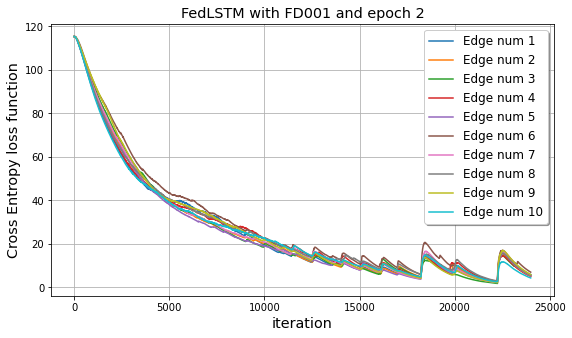

In [37]:
num_workers = 10
iteration_epoch = 3000
epoch = 2
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
cost_each_worker = np.zeros(shape=(num_workers, 4 * epoch *iteration_epoch))
for worker_i in range(num_workers):
    cost_each_worker[worker_i, :] = np.array(J[worker_i]).flatten()
    plt.plot(cost_each_worker[worker_i, :], label="Edge num " + str(worker_i+1))
plt.title("FedLSTM with FD001 and epoch 2", fontsize="x-large")
plt.ylabel("Cross Entropy loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
legened = plt.legend(shadow=True, fontsize='large')

dir_logdata_FD001_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_2/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_logdata_FD001_epoch_2))
plt.savefig('J_FD001_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.eps', format='eps', dpi=1200, bbox_inches='tight')
plt.savefig('J_FD001_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.png', format='png', dpi=1200, bbox_inches='tight')

### Plot test models

C:\Users\LO98E8~1\Temp\234/ipykernel_49572/3971602720.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


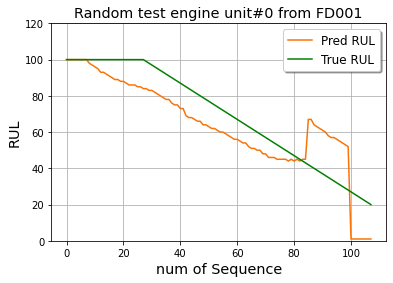

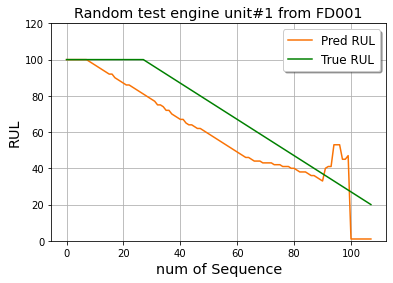

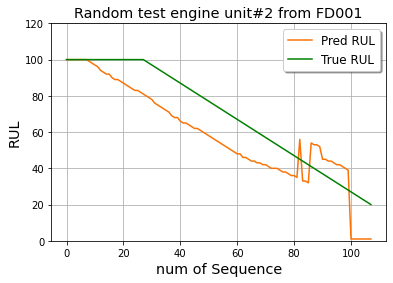

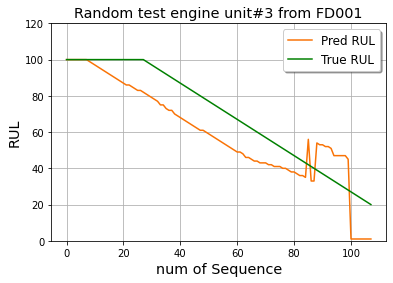

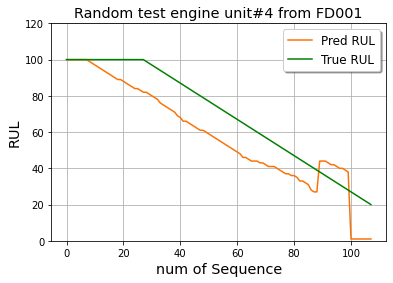

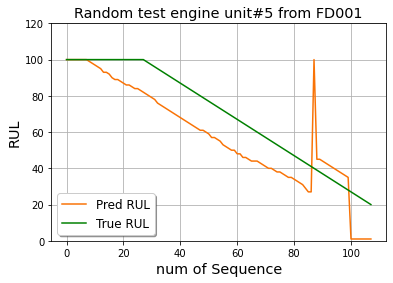

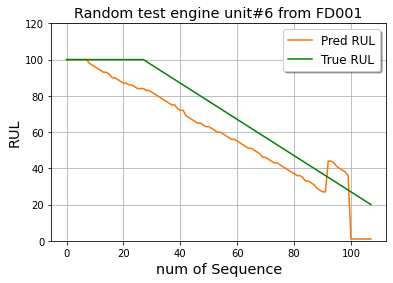

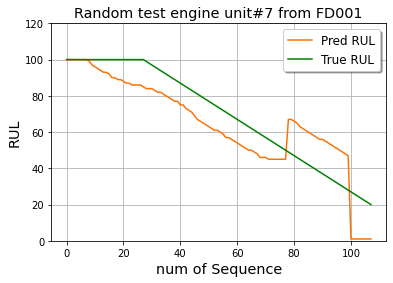

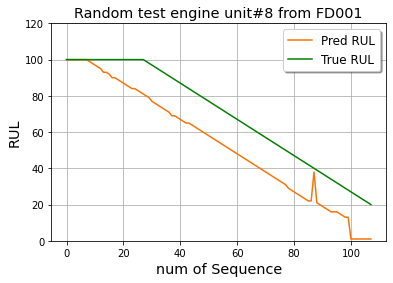

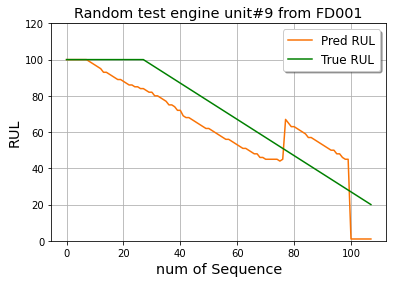

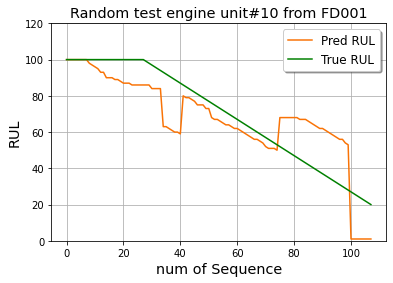

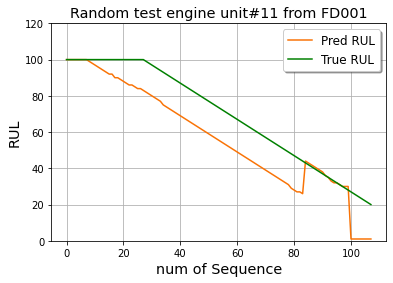

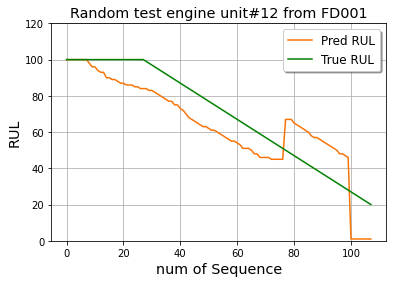

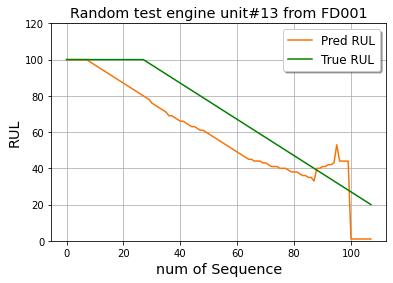

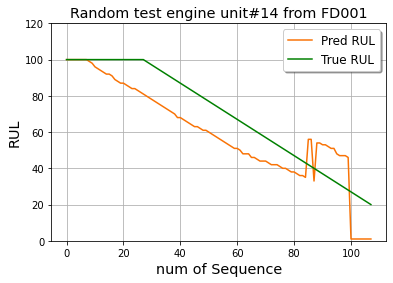

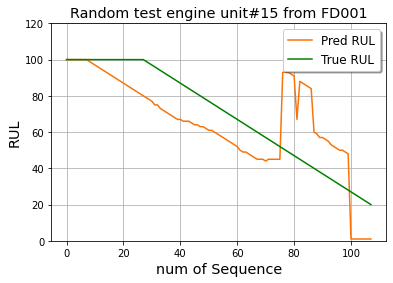

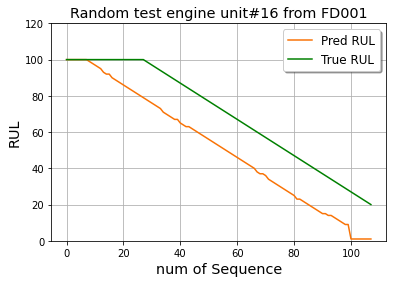

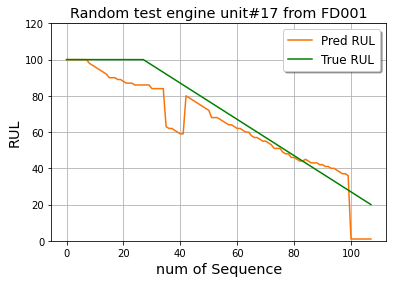

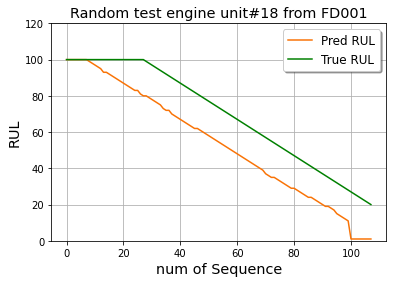

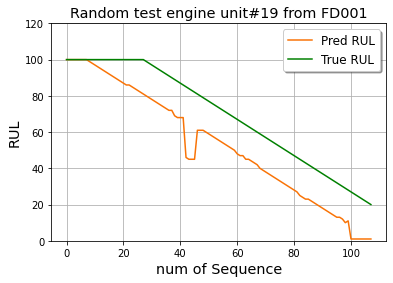

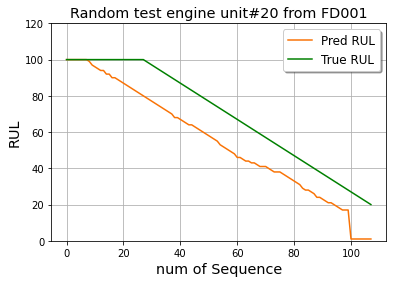

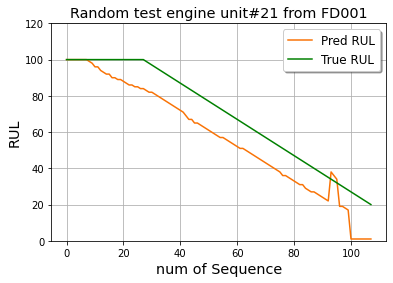

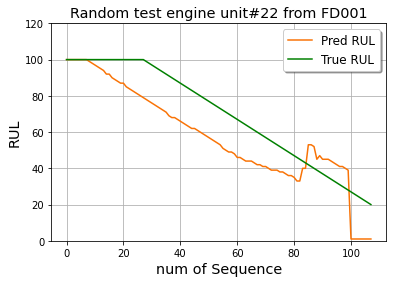

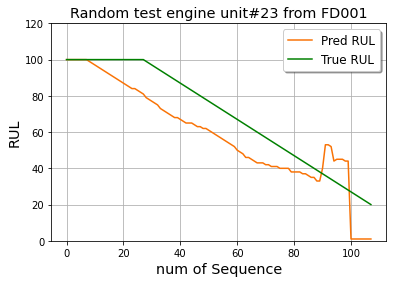

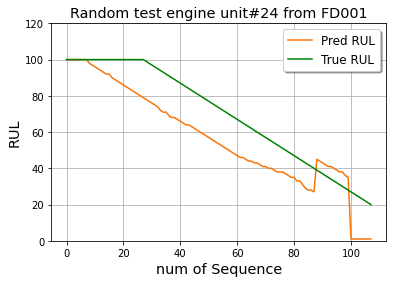

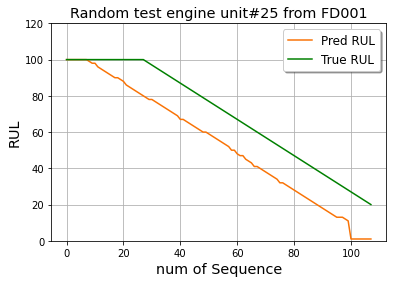

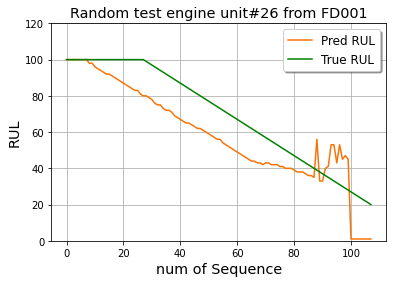

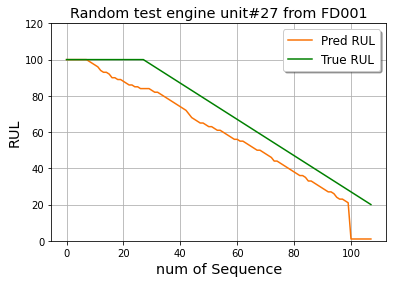

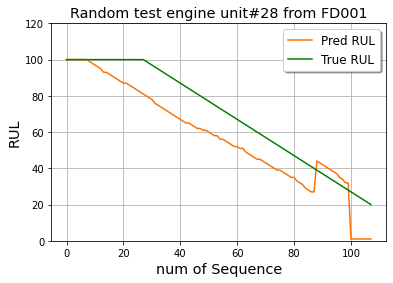

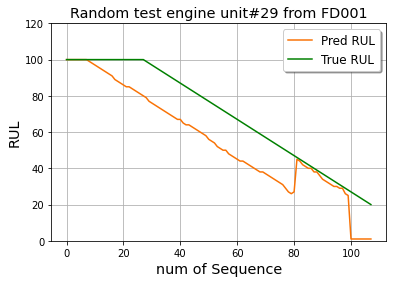

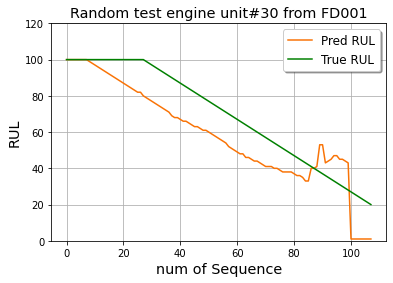

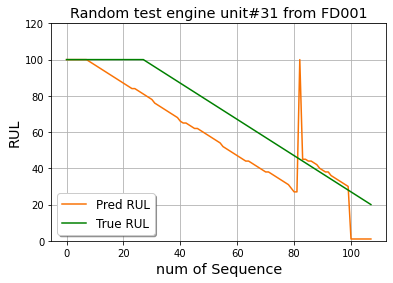

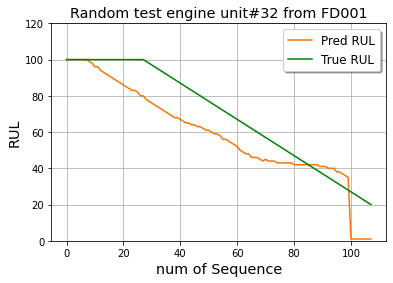

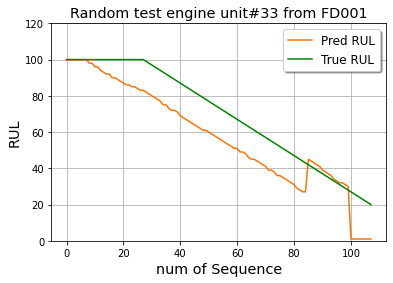

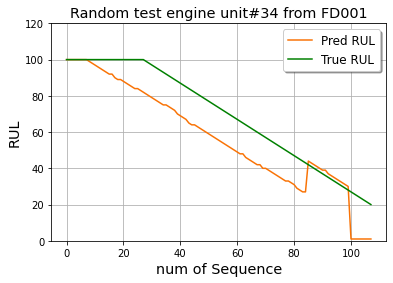

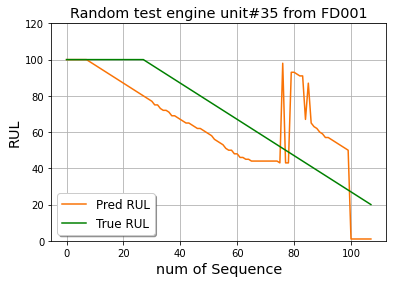

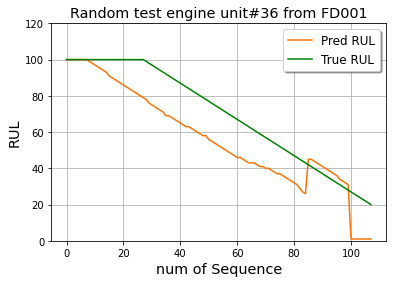

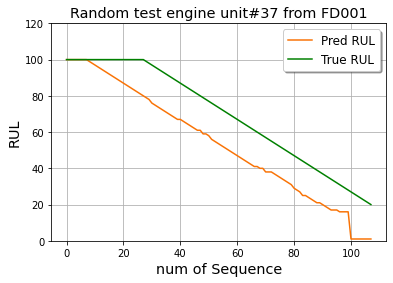

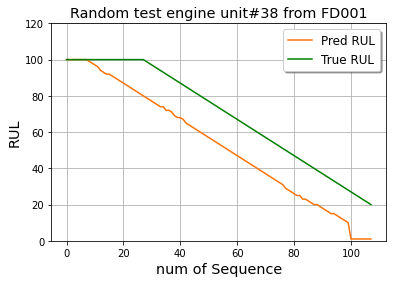

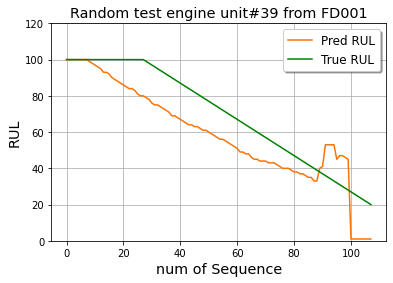

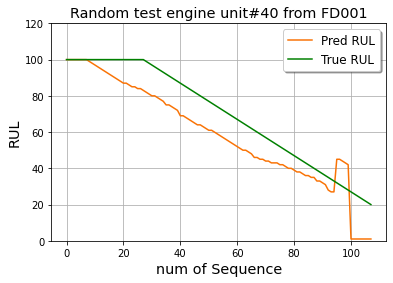

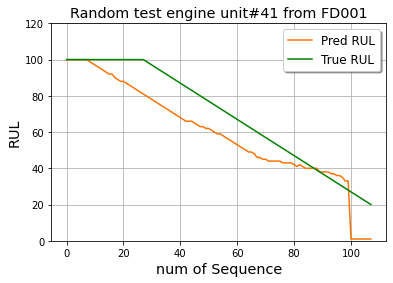

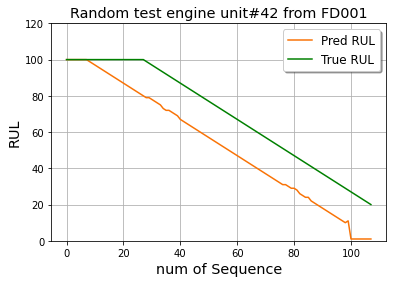

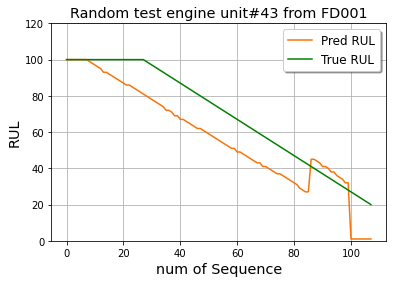

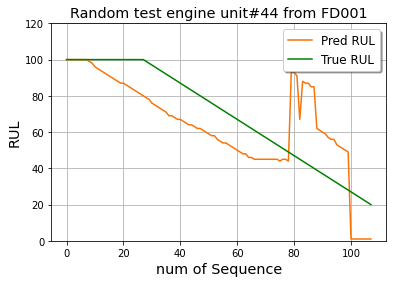

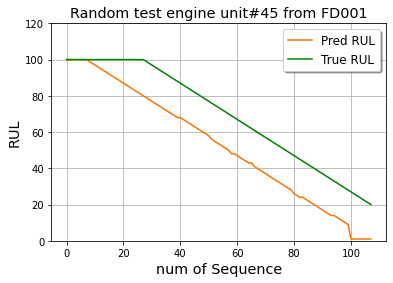

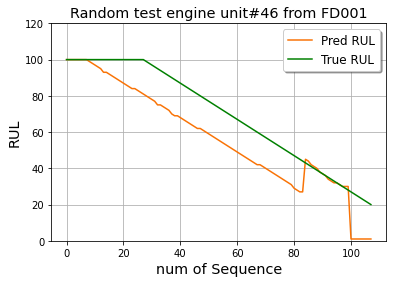

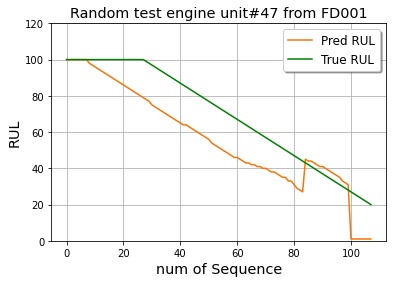

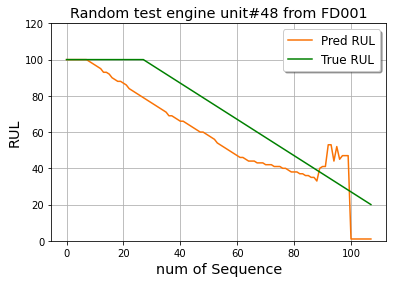

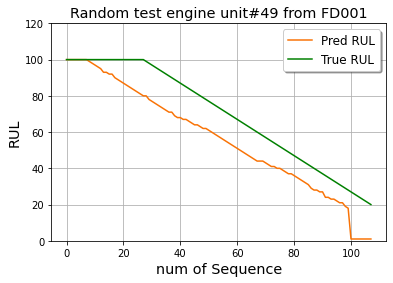

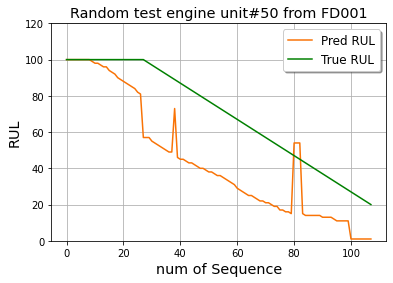

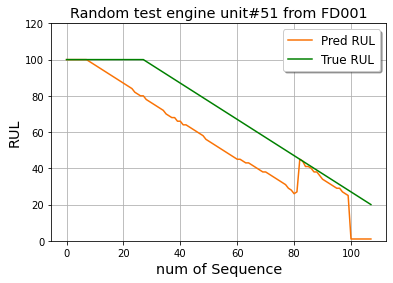

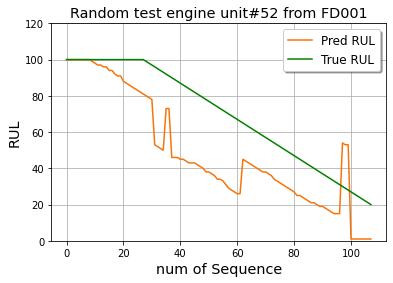

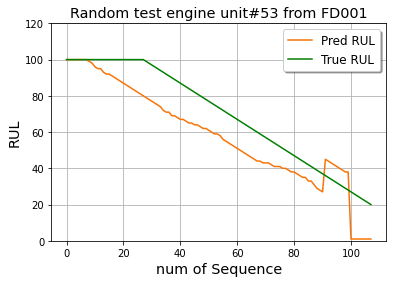

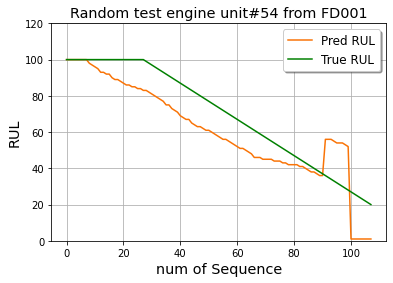

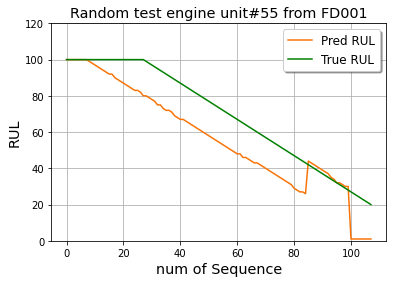

In [40]:
worker_test = LSTM()
fig={}
ax={}
for i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[i], array_params[0])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_hat, label='Pred RUL', color='#F97306')
    ax[i].plot(Y_test[worker_i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD001", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    plt.ylim(0, 120)
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].grid()
    ax[i].legend(shadow=True, fontsize='large')
    dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_2/"
    #plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_02"+str(worker_i)+".eps", format='eps', dpi=1200)
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_02"+str(worker_i)+".png", format='png', dpi=1200)

In [41]:
# Save Specific figures
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_2/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[27].savefig("FD001 RUL prediction with FedLSTM and epoch 2 for machine number_" + str(27) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[27].savefig("FD001 RUL prediction with FedLSTM and epoch 2 for machine number_" + str(27) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### RMSE and SCORE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[30.95048428]


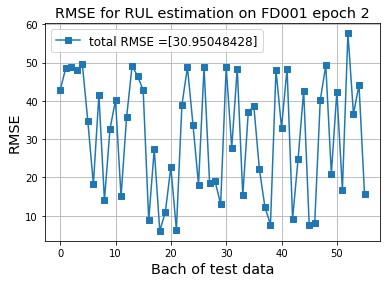

In [42]:
# RMSE and Scoring factor epoch 2
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


RMSE = np.zeros(shape=(len(X_test),1))


for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    RMSE[worker_i] = rmse(Y_hat, Y_test[worker_i])

fig, ax = plt.subplots()
plt.plot(RMSE, label='RMSE', marker = 's')
plt.title("RMSE for RUL estimation on FD001 epoch 2", fontsize="x-large")
plt.ylabel("RMSE", fontsize="x-large")
plt.xlabel("Bach of test data", fontsize="x-large")
plt.grid()

RMSE_epoch_2 = np.sum(RMSE, axis=0)/len(X_test)
labels = []
labels.append("total RMSE ="+str(RMSE_epoch_2))

plt.legend(labels, loc='best', fontsize='large')


print(RMSE_epoch_2)
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD001 epoch 2.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD001 epoch 2.png", format='png', dpi=1200, bbox_inches='tight')

[-85.25138012 -86.86997656 -87.28682955 -86.63540891 -86.59590508
 -64.28055607 -66.6284311  -84.38596126 -64.26130826 -81.22485317
 -83.77378644 -57.29774143 -83.92238713 -87.28112412 -87.06738133
 -82.34367867 -49.50684761 -80.13265715 -36.61755504 -53.33517118
 -78.83157499 -24.95388915 -86.07065804 -87.02098767 -84.76262471
 -72.99428795 -87.33482134 -72.59100603 -67.1882986  -46.75315311
 -87.09567283 -35.27001874 -87.63555549 -57.68623204 -85.08910164
 -81.29188621 -71.72169477 -60.0710665  -44.59908856 -87.36338101
 -83.36044294 -86.60666573 -50.79735023 -76.95699089 -83.92751809
 -44.61557677  -1.96157147 -87.20616378 -87.60318672 -76.32374079
 -85.72162565 -62.53199993 -87.38358157 -85.5844092  -86.34246308
 -57.30160304]
Final value for SCORE: -72.2365862399781


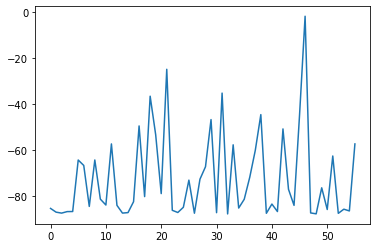

In [44]:
def each_score(predictions, targets):
    tmp = np.zeros(shape=(1, len(predictions)))
    for i in range(len(predictions)):
        Yi = predictions[i] - targets[i]
        if Yi >= 0:
            tmp[:, i] = (np.exp(Yi/10)-1)   
        else:
            tmp[:, i] = np.exp(Yi/13)-1
    return tmp
    
SCORE = np.zeros(shape=(len(X_test), X_test[0].shape[0]))

for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    SCORE[worker_i, :] = each_score(Y_hat, Y_test[worker_i])
    
print(np.sum(SCORE, axis=1))
plt.plot(np.sum(SCORE, axis=1))
print("Final value for SCORE:",np.sum(SCORE)/len(X_test))

## Load Cost functions and Parameters

In [101]:
import numpy as np
import pickle
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

dir_logdata_FD001_epoch_2: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/LogData/epoch_2/ "    
# Load cost from a PKL file
a_file = open(dir_logdata_FD001_epoch_2 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "rb")
J = pickle.load(a_file)
a_file.close()

# Load params data from a PKL file
a_file = open(dir_logdata_FD001_epoch_2 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_02.pkl", "rb")
array_params = pickle.load(a_file)
print(array_params)
a_file.close()

[{'Wf': array([[-0.18564977,  0.0322141 , -0.04818845, ..., -0.12048841,
         0.09804777,  0.05325   ],
       [-0.06109197,  0.09811411, -0.04168961, ...,  0.08114126,
         0.08047905,  0.05512676],
       [-0.12158022, -0.13627538, -0.17668155, ..., -0.20193493,
         0.20272957,  0.12999881],
       ...,
       [ 0.01255876,  0.16984161,  0.03624951, ..., -0.08108413,
         0.04121908,  0.00478767],
       [ 0.02036318,  0.06390896, -0.02934949, ...,  0.06846599,
         0.09238949,  0.08252651],
       [ 0.04791726,  0.01360442, -0.01159031, ...,  0.07645322,
         0.05202115,  0.05020851]]), 'bf': array([[1.05032015],
       [1.08373612],
       [1.08920687],
       [1.02828693],
       [1.0825476 ],
       [1.14573225],
       [1.04020056],
       [1.06803859],
       [1.07327751],
       [1.0113719 ],
       [1.0307025 ],
       [1.02641318],
       [1.07471422],
       [1.07047969],
       [1.10095669],
       [1.0111647 ],
       [1.06367949],
       [1.00765